# COMP5328 - Advanced Machine Learning

## Assignment 2: Noise Robustness Classifiers

- Tutors: Siyu Xu
- Group members:
    - Kaiyue Wang (ID: 530402325, UniKey: kwan5221)
    - Peng Huang (ID: 530203700, UniKey: phua0038)
    - Shoudi Huang (ID: 500478204, Unikey: shua9875)

## 1. Initialization

In [ ]:
WORKSPACE_PATH = ""

ENABLE_DEBUG = False
ENABLE_DISPLAY_DATASET_EXAMPLE = True
ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE = True

ENABLE_EXPERIMENTS_ON_FashionMNIST0_5 = True
ENABLE_EXPERIMENTS_ON_FashionMNIST0_6 = True
ENABLE_EXPERIMENTS_ON_CIFAR = True

ENABLE_COLAB = True
ENABLE_GPU = True

Import libs

In [ ]:
# import basic libs
import os
import gc
import time
import copy
import json
import numpy
import joblib
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from datetime import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt
np = numpy # if GPU is available, we may use `cupy` instead of `numpy` in some where

# import pytorch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models
import torchvision.transforms
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, mean_squared_error, mean_absolute_error


Mount google drive for load datasets and save logs

In [ ]:
if ENABLE_COLAB:
    try:
        # libraries for downloading files from google drive.
        from pydrive.auth import GoogleAuth
        from google.colab import drive
        from pydrive.drive import GoogleDrive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials

        # mount google drive for save logs.
        if os.path.isdir('/content/drive'):
            print('/content/drive exists.')
        else:
            print('/content/drive does not exist.')
            drive.mount('/content/drive')

        # please check the WORKSPACE_PATH is right to your Google Drive
        WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/"

        # download data set to runtime.
        # if os.path.isdir('Assignment2Data'):
        #     print('./Assignment2Data exists.')
        # else:
        #     print('./Assignment2Data does not exist.')
        #     auth.authenticate_user()
        #     gauth = GoogleAuth()
        #     gauth.credentials = GoogleCredentials.get_application_default()
        #     drive = GoogleDrive(gauth)
        #     file_id = '1WRNmUDmC1xrwyFd2GHuETF0DRk7clXiZ' # This is the dataset share id
        #     download = drive.CreateFile({'id': file_id})
        #     download.GetContentFile('Assignment2Data.zip')

        #     # unzip the download file.
        #     !unzip Assignment2Data.zip -d Assignment2Data

    except Exception as e:
        print("Colab Unavailable")
        ENABLE_COLAB = False

/content/drive does not exist.
Mounted at /content/drive


Detecting GPU availability

In [ ]:
device = 'cpu'

if ENABLE_GPU:
    try:
        # import tensorflow as tf
        # print("Num GPUs Available: ", len(
        #     tf.config.experimental.list_physical_devices('GPU')))
        # if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
        #     import cupy

        print("Num GPUs Available: ", torch.cuda.device_count())
        if torch.cuda.device_count() >= 1:
            import cupy
        else:
            print("GPU Unavailable")
            ENABLE_GPU = False

    except Exception as e:
        print("GPU Unavailable")
        ENABLE_GPU = False

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

Num GPUs Available:  0
GPU Unavailable


Creating a log file for logging during runtime

In [ ]:
if not os.path.exists(WORKSPACE_PATH + 'log'):
    os.makedirs(WORKSPACE_PATH + 'log')

current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_filepath = WORKSPACE_PATH + f"log/{current_time}.log"
log_file = open(log_filepath, 'w')


def print_log(text, level="<info>"):
    log_file.write(
        f"{level} [{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}] {text}\r\n")
    log_file.flush()
    print(text)

In [ ]:
print_log("Start to write: " + log_filepath)

Start to write: /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-06_14-09-35.log


Function for save object to disk

In [ ]:
def save_obj(obj, name = ""):
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    filepath = WORKSPACE_PATH + f"log/{current_time}_{name}.obj"
    joblib.dump(obj, filepath)
    return filepath

## 2. Prepare Datasets

### 2.1 Load dataset

In [ ]:
dataset_filepath_list = [
    "datasets/FashionMNIST0.5.npz",
    "datasets/FashionMNIST0.6.npz",
    "datasets/CIFAR.npz"
]

ds = {}
for filepath in dataset_filepath_list:
    dataset = np.load(WORKSPACE_PATH+filepath)
    filename = filepath.split('/')[-1].replace('.npz', '')
    ds[filename] = {}
    for key in dataset.keys():
        if dataset[key][0].shape == (28, 28):
            ds[filename][key] = np.expand_dims(dataset[key], axis=1)
        elif dataset[key][0].shape == (32, 32, 3):
            ds[filename][key] = dataset[key].transpose((0, 3, 1, 2))
        else:
            ds[filename][key] = dataset[key]
        log = f'ds["{filename}"]["{key}"] shape: {ds[filename][key].shape}, '
        log += f'range: ({ds[filename][key].min()}, {ds[filename][key].max()}), '
        log += f'dtype: ({ds[filename][key].dtype})'
        print_log(log)

ds["FashionMNIST0.5"]["Xtr"] shape: (18000, 1, 28, 28), range: (0, 255), dtype: (uint8)
ds["FashionMNIST0.5"]["Str"] shape: (18000,), range: (0, 2), dtype: (int64)
ds["FashionMNIST0.5"]["Xts"] shape: (3000, 1, 28, 28), range: (0, 255), dtype: (uint8)
ds["FashionMNIST0.5"]["Yts"] shape: (3000,), range: (0, 2), dtype: (int64)
ds["FashionMNIST0.6"]["Xtr"] shape: (18000, 1, 28, 28), range: (0, 255), dtype: (uint8)
ds["FashionMNIST0.6"]["Str"] shape: (18000,), range: (0, 2), dtype: (int64)
ds["FashionMNIST0.6"]["Xts"] shape: (3000, 1, 28, 28), range: (0, 255), dtype: (uint8)
ds["FashionMNIST0.6"]["Yts"] shape: (3000,), range: (0, 2), dtype: (int64)
ds["CIFAR"]["Xtr"] shape: (15000, 3, 32, 32), range: (0, 255), dtype: (uint8)
ds["CIFAR"]["Str"] shape: (15000,), range: (0, 2), dtype: (int64)
ds["CIFAR"]["Xts"] shape: (3000, 3, 32, 32), range: (0, 255), dtype: (uint8)
ds["CIFAR"]["Yts"] shape: (3000,), range: (0, 2), dtype: (int64)


### 2.2 Display datasets samples

In [ ]:
# display samples in dataset by randomly choice in each catagory.
def display_dataset_samples(X, Y, cmap=None):
    cols = 18
    label_list = list(set(Y))

    fig, axs = plt.subplots(ncols=cols, nrows=len(
        label_list), figsize=(cols, int(len(label_list))+0.01))

    for row in range(len(label_list)):
        image_ids = np.where(Y == label_list[row])[0]

        axs[row, 0].text(0.0, 0.5, s=f'label {label_list[row]}')
        axs[row, 0].axis('off')
        axs[row, -1].text(0.2, 0.5, s=f'{len(image_ids)} samples')
        axs[row, -1].axis('off')

        for col in range(1, cols -1):
            image_id = np.random.choice(image_ids)
            image_ids = image_ids[image_ids != image_id]
            axs[row, col].imshow(X[image_id].transpose((1, 2, 0)), cmap=cmap)
            axs[row, col].axis('off')
            # axs[row, col].set_title(str(image_id))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()


# Display image samples on one row (max 10 images)
def display_samples(images, titles=None):
    if len(images) > 10:
        print("Warning: More than 10 images provided. Only displaying the first 10.")

    fig, axs = plt.subplots(1, 10, figsize=(12, 2))

    for i in range(10):
        if i < len(images):
            if titles != None:
                axs[i].set_title(titles[i])
            axs[i].imshow(images[i].transpose((1, 2, 0)), cmap='gray')
            axs[i].axis('off')
        else:
            axs[i].axis('off')

    plt.show()

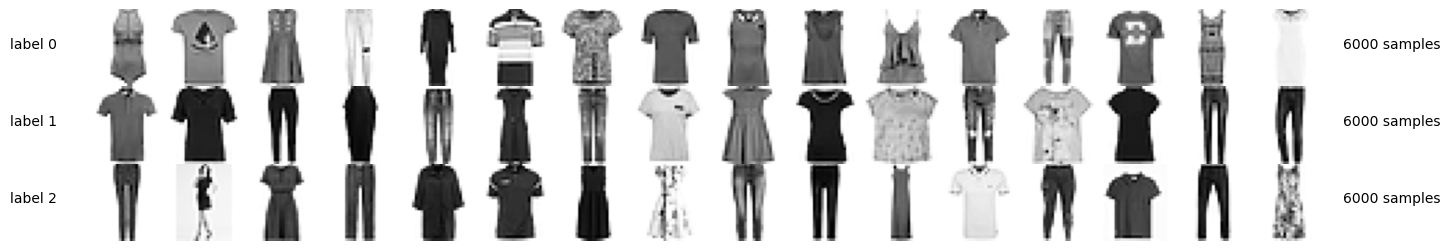

In [ ]:
if ENABLE_DISPLAY_DATASET_EXAMPLE:
    display_dataset_samples(ds["FashionMNIST0.5"]["Xtr"], ds["FashionMNIST0.5"]["Str"], cmap="Greys")

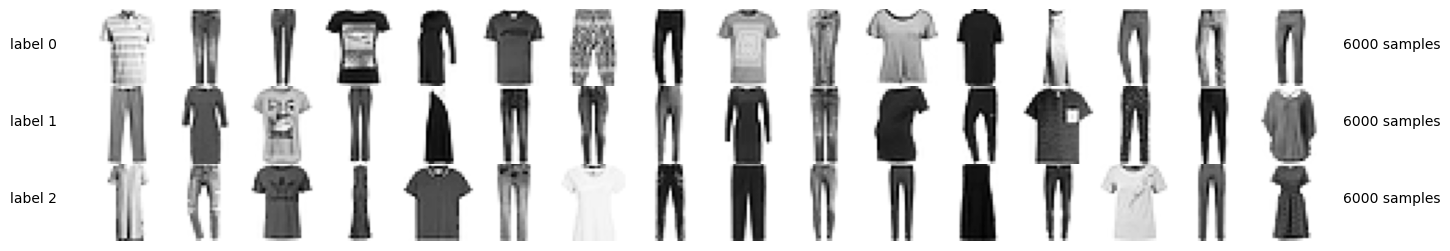

In [ ]:
if ENABLE_DISPLAY_DATASET_EXAMPLE:
    display_dataset_samples(ds["FashionMNIST0.6"]["Xtr"], ds["FashionMNIST0.6"]["Str"], cmap="Greys")

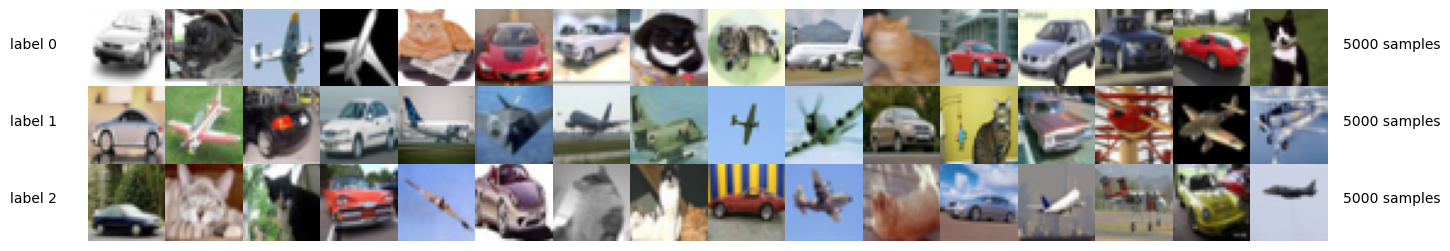

In [ ]:
if ENABLE_DISPLAY_DATASET_EXAMPLE:
    display_dataset_samples(ds["CIFAR"]["Xtr"], ds["CIFAR"]["Str"])

### 2.3 Pre-processing

#### 2.3.1 Normalization

$$
x_{\text{scaled}} = \dfrac{x - \min(x)}{\max(x) - \min(x)} = \dfrac{x}{255}
$$

In [ ]:
def normalize_data_by_dividing_255(X):
    return X / 255.0

In [ ]:
gc.collect()

for dataset in ds.keys():
    ds[dataset]['Xtr_normalized'] = normalize_data_by_dividing_255(ds[dataset]['Xtr'])
    ds[dataset]['Xts_normalized'] = normalize_data_by_dividing_255(ds[dataset]['Xts'])

gc.collect()

0

### 2.4 Function for split datasets into training and validation sets

In [ ]:
class DatasetArray(Dataset):
    # Class for using the DataLoader function in pytorch.

    def __init__(self, data, labels=None, transform=None):
        if type(labels) != type(None):
            self.data_arr = np.asarray(data).astype(np.float32)
            self.label_arr = np.asarray(labels).astype(np.int64)
        else:
            tmp_arr = np.asarray(data)
            self.data_arr = tmp_arr[:,:-1].astype(np.float32)
            self.label_arr = tmp_arr[:,-1].astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data_arr)

    def __getitem__(self, index):

        data = self.data_arr[index]
        label = self.label_arr[index]

        if self.transform is not None:
            data = self.transform(data)

        return (data, label)


def get_train_valid_dataloader(X, y, batch_size, valid_ratio, random_state=None):
    # Split the dataset into training and validation sets.
    # X, y: Input features and labels.
    # batch_size: Number of samples per batch.
    # valid_ratio: Ratio for validation set.
    # random_state: Random seed
    # return train_loader and valid_loader

    X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, shuffle=True, stratify=y,
            test_size=valid_ratio,
            random_state=random_state)

    # Create a DataLoader for the training set.
    train_loader = DataLoader(
        DatasetArray(data=X_train, labels=y_train),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    # Create a DataLoader for the validation set.
    valid_loader = DataLoader(
        DatasetArray(data=X_valid, labels=y_valid),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    return train_loader, valid_loader

def get_test_dataloader(X, y, batch_size):
    # X, y: Input features and labels.
    # return test_loader

    test_loader = DataLoader(
        DatasetArray(data=X, labels=y),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    return test_loader

## 3. Classifier Models

Function for training and validation

In [ ]:
def seed_torch(seed=1029):
    # Fix all random seeds for repeating the expriement result.
    # When all random seeds are fixed, the python runtime environment becomes deterministic.

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # If multi-GPUs are used.
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def one_hot_embedding(labels, num_classes):
    # Embedding labels to one-hot form.
    # labels: (LongTensor) class labels, sized [N,].
    # num_classes: (int) number of classes.
    # Returns: (tensor) encoded labels, sized [N, #classes].

    y = torch.eye(num_classes)
    return y[labels]


def accuracy(output, target, topk=(1,)):
    # Calcuate the accuracy according to the prediction and the true label.
    # Computes the precision@k for the specified values of k.

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    # A helper function which is used to record the experiment results.

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


In [ ]:
seed_torch(0)

In [ ]:
def model_train(model, optimizer, criterion, train_loader, transition_matrix=None, label_noise_method=None):
    # Training a pytorch nn_model.

    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(tqdm(train_loader)):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        if label_noise_method == "T_REVISION":
            preds, revision_transition_matrix = model(data, t_revision=True)
            loss = criterion(preds, targets, transition_matrix=transition_matrix.to(device), revision=revision_transition_matrix.to(device))
        elif label_noise_method == "IMPORTANCE_REWEIGHTING":
            preds = model(data)
            loss = criterion(preds, targets, transition_matrix=transition_matrix.to(device))
        else:
            preds = model(data)
            loss = criterion(preds, targets)

        # set all gradients to zero
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update all gradients
        optimizer.step()

        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))

        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    return top1_acc_meter.avg, loss_meter.avg

In [ ]:
def model_valid(model, criterion, valid_loader, transition_matrix=None, label_noise_method=None):
    # Validation or testing of a nn_model.

    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to eval mode
    model.eval()
    for step, (data, targets) in enumerate(valid_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        if label_noise_method == "T_REVISION":
            preds, revision_transition_matrix = model(data, t_revision=True)
            loss = criterion(preds, targets, transition_matrix=transition_matrix.to(device), revision=revision_transition_matrix.to(device))
        elif label_noise_method == "IMPORTANCE_REWEIGHTING":
            preds = model(data)
            loss = criterion(preds, targets, transition_matrix=transition_matrix.to(device))
        else:
            preds = model(data)
            loss = criterion(preds, targets)

        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))

        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    return top1_acc_meter.avg, loss_meter.avg

model_test = model_valid

In [ ]:
def model_train_and_valid(model, optimizer, criterion, train_loader, valid_loader, epochs=10, transition_matrix=None, label_noise_method=None):
    # Run epochs for training and validating model on train_loader and valid_loader.

    # Init dict and list to store training, validation history and parameters.
    train_history = {"accuracy":[], "loss":[]}
    valid_history = {"accuracy":[], "loss":[]}
    models = []

    for epoch in range(1, epochs+1):
        accuracy_train, loss_train = model_train(model, optimizer, criterion, train_loader,
                                                 transition_matrix=transition_matrix, label_noise_method=label_noise_method)
        accuracy_valid, loss_valid = model_valid(model, criterion, valid_loader,
                                                 transition_matrix=transition_matrix, label_noise_method=label_noise_method)

        # save model to disk
        model_path = WORKSPACE_PATH + f"log/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_model"
        model_path += f"_Epoch_{epoch}_{epochs}_Acc_{accuracy_train:.2f}_{accuracy_valid:.2f}_Loss_{loss_train:.2f}_{loss_valid:.2f}.pytorch"
        torch.save(model, model_path)

        # append history info
        train_history["accuracy"].append(accuracy_train)
        train_history["loss"].append(loss_train)
        valid_history["accuracy"].append(accuracy_valid)
        valid_history["loss"].append(loss_valid)
        models.append(model_path)

        log = f"epoch:{epoch}/{epochs}, ACC(train):{accuracy_train:.06f}, Loss(train):{loss_train:.06f}, "
        log += f"ACC(valid):{accuracy_valid:.06f}, Loss(valid):{loss_valid:.06f}"
        print(log)

    return {"train_history":train_history, "valid_history":valid_history, "models":models}


Function for prediction

In [ ]:
def model_predict(model, test_loader):
    # Make predictions for samples of test_loader.

    # Set the model to evaluation mode
    model.eval()
    all_outputs = torch.tensor([], device=device)

    with torch.no_grad():
        for step, (data, targets) in enumerate(test_loader):
            data = data.to(device)
            labels = targets.to(device)
            outputs = model(data) # predict
            all_outputs = torch.cat((all_outputs, outputs), 0)

        # Get the output from the softmax layer
        outputs = F.softmax(all_outputs, dim=1)

        # Get pred values from the model
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()

    return y_pred, outputs


Function for performance evaluation

In [ ]:
def model_evaluation(y_pred, y_true):
    # Returns a dictionary containing many evaluation metrics

    return {
        'f1_list': f1_score(y_true, y_pred, average=None),
        'f1_macro_average': f1_score(y_true, y_pred, average='macro'),
        'precision_list': precision_score(y_true, y_pred, average=None),
        'precision_macro_average': precision_score(y_true, y_pred, average='macro'),
        'recall_list': recall_score(y_true, y_pred, average=None),
        'recall_macro_average': recall_score(y_true, y_pred, average='macro'),
        'classification_report': classification_report(y_true, y_pred),
        'accuracy_score': accuracy_score(y_true, y_pred)
    }


Function for display training and validation history

In [ ]:
def display_train_and_valid_history(history):
    # Display a line chart for traning and validating history

    fig, ax = plt.subplots(1, 2, figsize=(10, 1.5))

    ax[0].plot(history['train_history']['accuracy'])
    ax[0].plot(history['valid_history']['accuracy'])
    ax[0].set_title('top1 acc')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    # ax[1].legend(['train', 'val'], loc='center left', bbox_to_anchor=(1, 0.5))

    ax[1].plot(history['train_history']['loss'])
    ax[1].plot(history['valid_history']['loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

### 3.1 CNN model for FashionMNIST0.5 and FashionMNIST0.6

In [ ]:
class CNN_model_FASHION(nn.Module):
    # Define a CNN architecture for FASHIONMNIST datasets.

    def __init__(self, conv1=10, conv2=20, fcn1=15):
        super(CNN_model_FASHION, self).__init__()

        # 1@28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1, kernel_size=3)
        # 10@26x26
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 10@13x13
        self.conv2 = nn.Conv2d(in_channels=conv1, out_channels=conv2, kernel_size=3)
        # 20@11x11
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 20@5x5

        self.fcn_input_channels = 5*5*conv2
        self.fc1 = nn.Linear(self.fcn_input_channels, fcn1)
        # 15 neurons
        self.fc2 = nn.Linear(fcn1, 3)
        # 3 neuron

        # noise adaption layer
        self.delta_T = nn.Linear(3, 3, False)
        nn.init.zeros_(self.delta_T.weight)

    def forward(self, x, t_revision=False):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.fcn_input_channels)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Return the parameters of noise adaption layer when using T-Revision method
        if t_revision:
          return x, self.delta_T.weight
        else:
          return x

model_sample = CNN_model_FASHION()
total_params = sum(p.numel() for p in model_sample.parameters())
print(f"total_params:{total_params}")


total_params:9492


### 3.2 CNN model for CIFAR

In [ ]:
class CNN_model_CIFAR(nn.Module):
    # Define a CNN architecture for CIFAR dataset.

    def __init__(self, conv1=10, conv2=20, fcn1=15):
        super(CNN_model_CIFAR, self).__init__()

        # 1@32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1, kernel_size=3)
        # 10@30x30
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 10@15x15
        self.conv2 = nn.Conv2d(in_channels=conv1, out_channels=conv2, kernel_size=3)
        # 20@13x13
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 20@6x6

        self.fcn_input_channels = 6*6*conv2
        self.fc1 = nn.Linear(self.fcn_input_channels, fcn1)
        # 15 neurons
        self.fc2 = nn.Linear(fcn1, 3)
        # 3 neurons

        # noise adaption layer
        self.delta_T = nn.Linear(3, 3, False)
        nn.init.zeros_(self.delta_T.weight)

    def forward(self, x, t_revision=False):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.fcn_input_channels)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Return the parameters of noise adaption layer when using T-Revision method
        if t_revision:
          return x, self.delta_T.weight
        else:
          return x

model_sample = CNN_model_CIFAR()
total_params = sum(p.numel() for p in model_sample.parameters())
print(f"total_params:{total_params}")


total_params:12972


## 4. Transition Matrix Estimator


### 4.1 Function for estimate transition matrix


In [ ]:
def estimate_tmatrix(num_classes, outputs, y_pred, average=True):
    # Function to estimate the transition matrix based on the noisy class posterior
    # param num_classes: Number of classes
    # param outputs: Outputs from the softmax function
    # param y_pred: Prediction values
    # param average: Average the probabilities for each layer P(Y^{~}=i | x)
    # return T: Estimated transition matrix

    T = np.empty((num_classes, num_classes))
    # Iterate over the number of classes

    for i in range(num_classes):

        # Average the probability per column
        if average:
            # Get the samples with this predicted class
            # Get the samples of these indexes P(Y^=i | X=Xi)
            Xi_outputs = outputs[(y_pred == i)]

            T[i, :] = np.mean(Xi_outputs, axis=0)

        else:
            # Get the argmax
            idx = np.argmax(outputs[:, i])
            # Iterave over each label to fill the matrix
            for j in np.arange(num_classes):
                T[i, j] = outputs[idx, j]

    return T

Function for generate heatmaps

In [ ]:
def generate_heatmaps(data_list, labels=None, colors=None, vmin=None, vmax=None):
    # Function for generate heatmaps for transition matrix.

    if colors == None:
        colors = ['Greys'] * len(data_list)
    if vmin == None:
        vmin = [0] * len(data_list)
    if vmax == None:
        vmax = [1] * len(data_list)
    if labels == None:
        labels = range(1, len(data_list)+1)

    fig, axes = plt.subplots(1, len(data_list), figsize=(len(data_list)*(5/3), 1.5))

    for i in range(len(data_list)):

        ax = axes[i] if (len(data_list) != 1) else axes

        sns.heatmap(data_list[i], ax=ax, cmap=colors[i], annot=True, fmt=".2f", cbar=False, edgecolor='none', vmin=vmin[i], vmax=vmax[i], annot_kws={'color': 'black'})
        ax.set_title(labels[i])
        ax.set(xticklabels=[], yticklabels=[], xlabel='', ylabel='')
        ax.axis("off")

    plt.show()


### 4.2 FashionMNIST0.5 dataset's transition matrix

Known transition matrix for FashionMNIST0.5

In [ ]:
ds["FashionMNIST0.5"]["transition_matrix"] = torch.from_numpy(np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.5, 0.2],
    [0.2, 0.3, 0.5]
])).float()

Train an estimator model on FashionMNIST0.5

100%|██████████| 113/113 [00:02<00:00, 45.23it/s]


epoch:1/20, ACC(train):40.069444, Loss(train):1.082561, ACC(valid):42.027778, Loss(valid):1.069301


100%|██████████| 113/113 [00:02<00:00, 45.06it/s]


epoch:2/20, ACC(train):45.638889, Loss(train):1.057867, ACC(valid):48.000000, Loss(valid):1.045784


100%|██████████| 113/113 [00:02<00:00, 45.46it/s]


epoch:3/20, ACC(train):47.027778, Loss(train):1.049476, ACC(valid):48.361111, Loss(valid):1.046528


100%|██████████| 113/113 [00:02<00:00, 45.87it/s]


epoch:4/20, ACC(train):47.506944, Loss(train):1.050265, ACC(valid):47.472222, Loss(valid):1.047331


100%|██████████| 113/113 [00:02<00:00, 46.27it/s]


epoch:5/20, ACC(train):47.604167, Loss(train):1.049595, ACC(valid):48.500000, Loss(valid):1.042489


100%|██████████| 113/113 [00:02<00:00, 43.74it/s]


epoch:6/20, ACC(train):47.777778, Loss(train):1.044625, ACC(valid):48.888889, Loss(valid):1.039706


100%|██████████| 113/113 [00:02<00:00, 45.24it/s]


epoch:7/20, ACC(train):47.652778, Loss(train):1.046250, ACC(valid):48.777778, Loss(valid):1.041198


100%|██████████| 113/113 [00:02<00:00, 43.48it/s]


epoch:8/20, ACC(train):47.944444, Loss(train):1.044468, ACC(valid):48.583333, Loss(valid):1.045500


100%|██████████| 113/113 [00:02<00:00, 43.62it/s]


epoch:9/20, ACC(train):48.194444, Loss(train):1.046250, ACC(valid):47.638889, Loss(valid):1.047896


100%|██████████| 113/113 [00:02<00:00, 44.48it/s]


epoch:10/20, ACC(train):47.840278, Loss(train):1.043774, ACC(valid):49.277778, Loss(valid):1.037898


100%|██████████| 113/113 [00:02<00:00, 45.24it/s]


epoch:11/20, ACC(train):48.194444, Loss(train):1.041393, ACC(valid):49.166667, Loss(valid):1.042210


100%|██████████| 113/113 [00:02<00:00, 44.76it/s]


epoch:12/20, ACC(train):47.923611, Loss(train):1.041116, ACC(valid):48.611111, Loss(valid):1.045409


100%|██████████| 113/113 [00:02<00:00, 44.67it/s]


epoch:13/20, ACC(train):48.458333, Loss(train):1.037811, ACC(valid):48.777778, Loss(valid):1.044296


100%|██████████| 113/113 [00:02<00:00, 45.05it/s]


epoch:14/20, ACC(train):47.812500, Loss(train):1.042913, ACC(valid):49.027778, Loss(valid):1.042224


100%|██████████| 113/113 [00:02<00:00, 44.87it/s]


epoch:15/20, ACC(train):48.319444, Loss(train):1.038495, ACC(valid):47.888889, Loss(valid):1.045795


100%|██████████| 113/113 [00:02<00:00, 44.11it/s]


epoch:16/20, ACC(train):48.361111, Loss(train):1.037860, ACC(valid):49.416667, Loss(valid):1.058652


100%|██████████| 113/113 [00:02<00:00, 45.44it/s]


epoch:17/20, ACC(train):48.937500, Loss(train):1.034883, ACC(valid):49.138889, Loss(valid):1.049577


100%|██████████| 113/113 [00:02<00:00, 46.99it/s]


epoch:18/20, ACC(train):48.722222, Loss(train):1.035018, ACC(valid):47.694444, Loss(valid):1.050725


100%|██████████| 113/113 [00:02<00:00, 46.38it/s]


epoch:19/20, ACC(train):48.506944, Loss(train):1.033057, ACC(valid):48.861111, Loss(valid):1.049154


100%|██████████| 113/113 [00:02<00:00, 46.21it/s]


epoch:20/20, ACC(train):48.416667, Loss(train):1.031366, ACC(valid):48.833333, Loss(valid):1.053485


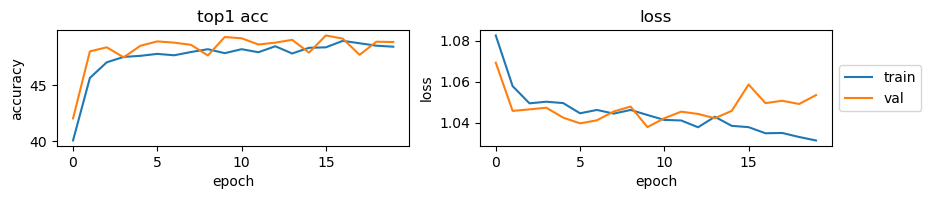

best_model_path: log/2023-11-06_22-59-04_model_Epoch_16_20_Acc_48.36_49.42_Loss_1.04_1.06.pytorch


In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    train_loader, valid_loader = get_train_valid_dataloader(
                                    ds["FashionMNIST0.5"]['Xtr_normalized'],
                                    ds["FashionMNIST0.5"]['Str'],
                                    batch_size=128,
                                    valid_ratio=0.2,
                                    random_state=None)

    model = CNN_model_FASHION(conv1=10, conv2=20, fcn1=15)

    history = model_train_and_valid(
                    model,
                    optimizer=torch.optim.SGD( params = model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.90 ),
                    criterion=nn.CrossEntropyLoss(),
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    epochs=20)

    display_train_and_valid_history(history)

    # load best model
    best_model_id = np.argmax(history["valid_history"]["accuracy"])
    model = torch.load(history["models"][best_model_id])
    print(f"best_model_path: {history['models'][best_model_id]}")

Estimate transition matrix and compare it with known transition matrix

$$\text{MAE} = \dfrac{1}{c\times c} \sum_{i=1}^{c} \sum_{j=1}^{c} |t_{i,j}-\hat{t}_{i,j}|$$

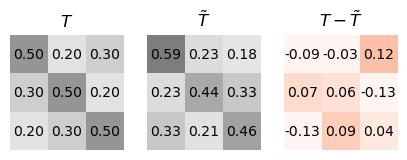

Estimate transition matrix error (MAE): 0.0837


In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    y_pred, outputs = model_predict(model, train_loader)
    transition_matrix_estimated= estimate_tmatrix(num_classes=3, outputs=outputs.cpu().numpy(), y_pred=y_pred)
    ds["FashionMNIST0.5"]["transition_matrix_estimated"] = torch.from_numpy(transition_matrix_estimated).float()

    generate_heatmaps([ds["FashionMNIST0.5"]["transition_matrix"],
                    ds["FashionMNIST0.5"]["transition_matrix_estimated"],
                    ds["FashionMNIST0.5"]["transition_matrix"] - ds["FashionMNIST0.5"]["transition_matrix_estimated"]],
                    ['$T$', '$\~{T}$', '$T-\~{T}$'],
                    colors=["Greys", "Greys", "Reds"],
                    vmax=[1,1,0.5])

    MAE = mean_absolute_error(ds["FashionMNIST0.5"]["transition_matrix"].numpy(), ds["FashionMNIST0.5"]["transition_matrix_estimated"].numpy())
    print(f'Estimate transition matrix error (MAE): {MAE:.04f}')

### 4.3 FashionMNIST0.6 dataset's transition matrix

Known transition matrix for FashionMNIST0.5

In [ ]:
ds["FashionMNIST0.6"]["transition_matrix"] = torch.from_numpy(np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])).float()

Train an estimator model on FashionMNIST0.6

100%|██████████| 113/113 [00:02<00:00, 45.14it/s]


epoch:1/20, ACC(train):33.888889, Loss(train):1.100360, ACC(valid):33.333333, Loss(valid):1.098928


100%|██████████| 113/113 [00:02<00:00, 42.78it/s]


epoch:2/20, ACC(train):35.652778, Loss(train):1.097680, ACC(valid):38.583333, Loss(valid):1.091902


100%|██████████| 113/113 [00:02<00:00, 47.73it/s]


epoch:3/20, ACC(train):37.791667, Loss(train):1.093731, ACC(valid):37.750000, Loss(valid):1.093630


100%|██████████| 113/113 [00:02<00:00, 45.38it/s]


epoch:4/20, ACC(train):38.902778, Loss(train):1.093345, ACC(valid):39.805556, Loss(valid):1.089486


100%|██████████| 113/113 [00:02<00:00, 44.86it/s]


epoch:5/20, ACC(train):39.187500, Loss(train):1.091303, ACC(valid):39.777778, Loss(valid):1.088967


100%|██████████| 113/113 [00:02<00:00, 43.49it/s]


epoch:6/20, ACC(train):38.916667, Loss(train):1.093219, ACC(valid):39.833333, Loss(valid):1.089260


100%|██████████| 113/113 [00:03<00:00, 37.31it/s]


epoch:7/20, ACC(train):39.013889, Loss(train):1.092108, ACC(valid):39.916667, Loss(valid):1.089911


100%|██████████| 113/113 [00:02<00:00, 44.37it/s]


epoch:8/20, ACC(train):39.402778, Loss(train):1.091343, ACC(valid):39.944444, Loss(valid):1.088050


100%|██████████| 113/113 [00:02<00:00, 46.30it/s]


epoch:9/20, ACC(train):38.729167, Loss(train):1.092179, ACC(valid):39.833333, Loss(valid):1.090064


100%|██████████| 113/113 [00:02<00:00, 43.22it/s]


epoch:10/20, ACC(train):38.972222, Loss(train):1.091243, ACC(valid):36.944444, Loss(valid):1.093273


100%|██████████| 113/113 [00:02<00:00, 45.26it/s]


epoch:11/20, ACC(train):39.388889, Loss(train):1.090210, ACC(valid):39.972222, Loss(valid):1.088893


100%|██████████| 113/113 [00:02<00:00, 45.44it/s]


epoch:12/20, ACC(train):39.826389, Loss(train):1.089837, ACC(valid):40.194444, Loss(valid):1.088758


100%|██████████| 113/113 [00:02<00:00, 42.91it/s]


epoch:13/20, ACC(train):39.881944, Loss(train):1.089043, ACC(valid):39.222222, Loss(valid):1.090563


100%|██████████| 113/113 [00:02<00:00, 42.76it/s]


epoch:14/20, ACC(train):39.791667, Loss(train):1.088836, ACC(valid):39.916667, Loss(valid):1.088956


100%|██████████| 113/113 [00:02<00:00, 44.37it/s]


epoch:15/20, ACC(train):39.430556, Loss(train):1.088608, ACC(valid):35.416667, Loss(valid):1.100135


100%|██████████| 113/113 [00:02<00:00, 42.00it/s]


epoch:16/20, ACC(train):39.500000, Loss(train):1.089086, ACC(valid):36.361111, Loss(valid):1.098009


100%|██████████| 113/113 [00:02<00:00, 44.34it/s]


epoch:17/20, ACC(train):39.895833, Loss(train):1.087916, ACC(valid):39.638889, Loss(valid):1.091265


100%|██████████| 113/113 [00:02<00:00, 40.74it/s]


epoch:18/20, ACC(train):40.076389, Loss(train):1.086699, ACC(valid):38.583333, Loss(valid):1.097479


100%|██████████| 113/113 [00:02<00:00, 41.49it/s]


epoch:19/20, ACC(train):39.486111, Loss(train):1.088368, ACC(valid):36.944444, Loss(valid):1.093346


100%|██████████| 113/113 [00:02<00:00, 41.75it/s]


epoch:20/20, ACC(train):39.840278, Loss(train):1.086110, ACC(valid):36.944444, Loss(valid):1.095474


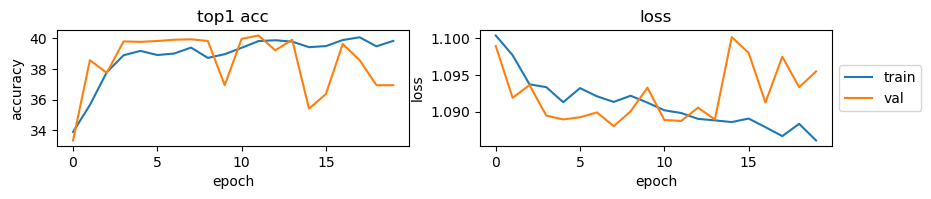

best_model_path: log/2023-11-06_23-02-08_model_Epoch_12_20_Acc_39.83_40.19_Loss_1.09_1.09.pytorch


In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    train_loader, valid_loader = get_train_valid_dataloader(
                                    ds["FashionMNIST0.6"]['Xtr_normalized'],
                                    ds["FashionMNIST0.6"]['Str'],
                                    batch_size=128,
                                    valid_ratio=0.2,
                                    random_state=None)

    model = CNN_model_FASHION(conv1=10, conv2=20, fcn1=15)

    history = model_train_and_valid(
                    model,
                    optimizer=torch.optim.SGD( params = model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.90 ),
                    criterion=nn.CrossEntropyLoss(),
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    epochs=20)

    display_train_and_valid_history(history)

    # load best model
    best_model_id = np.argmax(history["valid_history"]["accuracy"])
    model = torch.load(history["models"][best_model_id])
    print(f"best_model_path: {history['models'][best_model_id]}")

Estimate transition matrix and compare it with known transition matrix

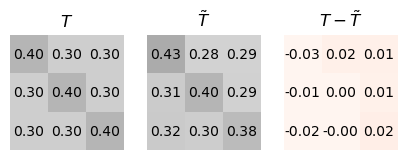

Estimate transition matrix error (MAE): 0.0143


In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    y_pred, outputs = model_predict(model, train_loader)
    transition_matrix_estimated= estimate_tmatrix(num_classes=3, outputs=outputs.cpu().numpy(), y_pred=y_pred)
    ds["FashionMNIST0.6"]["transition_matrix_estimated"] = torch.from_numpy(transition_matrix_estimated).float()

    generate_heatmaps([ds["FashionMNIST0.6"]["transition_matrix"],
                    ds["FashionMNIST0.6"]["transition_matrix_estimated"],
                    ds["FashionMNIST0.6"]["transition_matrix"] - ds["FashionMNIST0.6"]["transition_matrix_estimated"]],
                    ['$T$', '$\~{T}$', '$T-\~{T}$'],
                    colors=["Greys", "Greys", "Reds"],
                    vmax=[1,1,0.5])

    MAE = mean_absolute_error(ds["FashionMNIST0.6"]["transition_matrix"].numpy(), ds["FashionMNIST0.6"]["transition_matrix_estimated"].numpy())
    print(f'Estimate transition matrix error (MAE): {MAE:.04f}')

### 4.3 CIFAR dataset's transition matrix

Train an estimator model on CIFAR

100%|██████████| 94/94 [00:03<00:00, 30.56it/s]


epoch:1/20, ACC(train):33.750000, Loss(train):1.100122, ACC(valid):33.333333, Loss(valid):1.100975


100%|██████████| 94/94 [00:03<00:00, 31.16it/s]


epoch:2/20, ACC(train):33.266667, Loss(train):1.100084, ACC(valid):33.600000, Loss(valid):1.098362


100%|██████████| 94/94 [00:03<00:00, 30.74it/s]


epoch:3/20, ACC(train):33.750000, Loss(train):1.099380, ACC(valid):33.200000, Loss(valid):1.100666


100%|██████████| 94/94 [00:02<00:00, 31.76it/s]


epoch:4/20, ACC(train):34.100000, Loss(train):1.098427, ACC(valid):34.300000, Loss(valid):1.097826


100%|██████████| 94/94 [00:03<00:00, 29.76it/s]


epoch:5/20, ACC(train):35.650000, Loss(train):1.096516, ACC(valid):33.600000, Loss(valid):1.103848


100%|██████████| 94/94 [00:03<00:00, 30.48it/s]


epoch:6/20, ACC(train):32.491667, Loss(train):1.100719, ACC(valid):32.966667, Loss(valid):1.104400


100%|██████████| 94/94 [00:02<00:00, 33.11it/s]


epoch:7/20, ACC(train):33.741667, Loss(train):1.100235, ACC(valid):33.333333, Loss(valid):1.102303


100%|██████████| 94/94 [00:02<00:00, 32.58it/s]


epoch:8/20, ACC(train):33.341667, Loss(train):1.100120, ACC(valid):33.900000, Loss(valid):1.099548


100%|██████████| 94/94 [00:03<00:00, 29.76it/s]


epoch:9/20, ACC(train):34.716667, Loss(train):1.098517, ACC(valid):34.166667, Loss(valid):1.099268


100%|██████████| 94/94 [00:02<00:00, 32.65it/s]


epoch:10/20, ACC(train):35.275000, Loss(train):1.095638, ACC(valid):35.933333, Loss(valid):1.098815


100%|██████████| 94/94 [00:02<00:00, 32.14it/s]


epoch:11/20, ACC(train):36.216667, Loss(train):1.095793, ACC(valid):35.000000, Loss(valid):1.096534


100%|██████████| 94/94 [00:02<00:00, 32.04it/s]


epoch:12/20, ACC(train):36.200000, Loss(train):1.095206, ACC(valid):36.033333, Loss(valid):1.095998


100%|██████████| 94/94 [00:02<00:00, 31.49it/s]


epoch:13/20, ACC(train):36.425000, Loss(train):1.093266, ACC(valid):35.100000, Loss(valid):1.097961


100%|██████████| 94/94 [00:02<00:00, 32.76it/s]


epoch:14/20, ACC(train):37.166667, Loss(train):1.091316, ACC(valid):37.366667, Loss(valid):1.094244


100%|██████████| 94/94 [00:03<00:00, 29.28it/s]


epoch:15/20, ACC(train):36.883333, Loss(train):1.088901, ACC(valid):34.166667, Loss(valid):1.100864


100%|██████████| 94/94 [00:02<00:00, 32.50it/s]


epoch:16/20, ACC(train):37.200000, Loss(train):1.089578, ACC(valid):36.500000, Loss(valid):1.107624


100%|██████████| 94/94 [00:03<00:00, 31.22it/s]


epoch:17/20, ACC(train):38.591667, Loss(train):1.085588, ACC(valid):36.400000, Loss(valid):1.099682


100%|██████████| 94/94 [00:03<00:00, 30.78it/s]


epoch:18/20, ACC(train):38.166667, Loss(train):1.085437, ACC(valid):36.266667, Loss(valid):1.101005


100%|██████████| 94/94 [00:03<00:00, 29.48it/s]


epoch:19/20, ACC(train):38.616667, Loss(train):1.084592, ACC(valid):38.300000, Loss(valid):1.096477


100%|██████████| 94/94 [00:03<00:00, 29.44it/s]


epoch:20/20, ACC(train):39.525000, Loss(train):1.082057, ACC(valid):37.800000, Loss(valid):1.095774


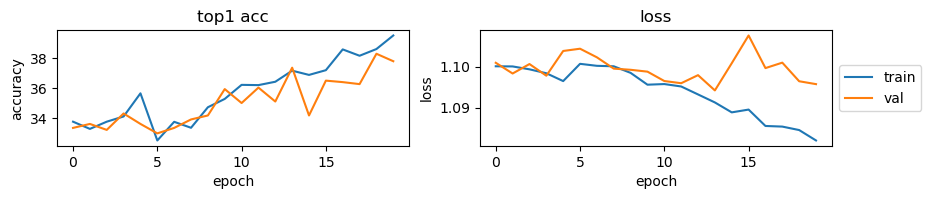

best_model_path: log/2023-11-06_23-03-38_model_Epoch_19_20_Acc_38.62_38.30_Loss_1.08_1.10.pytorch


In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    train_loader, valid_loader = get_train_valid_dataloader(
                                    ds["CIFAR"]['Xtr_normalized'],
                                    ds["CIFAR"]['Str'],
                                    batch_size=128,
                                    valid_ratio=0.2,
                                    random_state=None)
    model = None
    gc.collect()
    model = CNN_model_CIFAR(conv1=10, conv2=20, fcn1=15)

    history = model_train_and_valid(
                    model,
                    optimizer=torch.optim.SGD( params = model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.90 ),
                    criterion=nn.CrossEntropyLoss(),
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    epochs=20)

    display_train_and_valid_history(history)

    # load best model
    best_model_id = np.argmax(history["valid_history"]["accuracy"])
    model = torch.load(history["models"][best_model_id])
    print(f"best_model_path: {history['models'][best_model_id]}")

Estimate transition matrix

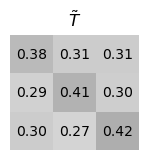

In [ ]:
if ENABLE_TRAINSITION_MATRIX_ESTIMATOR_EXAMPLE:

    y_pred, outputs = model_predict(model, train_loader)
    transition_matrix_estimated= estimate_tmatrix(num_classes=3, outputs=outputs.cpu().numpy(), y_pred=y_pred)
    ds["CIFAR"]["transition_matrix_estimated"] = torch.from_numpy(transition_matrix_estimated).float()

    generate_heatmaps([ds["CIFAR"]["transition_matrix_estimated"]],
                    ['$\~{T}$'],
                    colors=["Greys"],
                    vmax=[1])

## 5. Label noise robust methods

### 5.1 Importance Reweighting

Beta is
$$\beta(X, \hat{Y}) = \frac{P_D(Y | X)}{P_{\overline{D}}(\hat{Y} | X)}$$

loss is
$$\hat{f}_n = \underset{f \in \mathcal{F}}{\arg\min} \, \frac{1}{n} \sum_{i=1}^{n} \beta(X_i, \hat{Y}_i) \ell(f(X_i), \hat{Y}_i)$$


In [ ]:
class importance_reweighting_loss(torch.nn.Module):
    def __init__(self):
        super(importance_reweighting_loss, self).__init__()

    def forward(self, out, target, transition_matrix):
        loss = 0.0
        out_softmax = F.softmax(out, dim=1)

        for i in range(len(target)):
            softmax = torch.unsqueeze(out_softmax[i], 0)

            # calculate beta with transition_matrix
            numerator = softmax[:, target[i]]
            denominator = torch.matmul(transition_matrix.t(), softmax.t()).t()[:, target[i]]
            beta = Variable(numerator / denominator, requires_grad=True)

            # calculate loss
            loss += beta * F.cross_entropy(torch.unsqueeze(out[i], 0), torch.unsqueeze(target[i], 0))

        return loss / len(target)

### 5.2 $T$-Revision

$$\underset{\hat{T} + \Delta T, f}{\arg\min}\frac{1}{n} \sum_{i=1}^{n} \frac{g_{\bar{Y}_i}(X_i)}{((\hat{T} + \Delta T)^T g)_{\bar{Y}_i}(X_i)} \cdot \ell(f(X_i), \bar{Y}_i)$$

In [ ]:
class t_revision_loss(torch.nn.Module):
    def __init__(self):
        super(t_revision_loss, self).__init__()

    def forward(self, out, target, transition_matrix, revision):
        delta_transition_matrix = revision
        loss = 0.0
        out_softmax = F.softmax(out, dim=1)

        for i in range(len(target)):
            temp_softmax = torch.unsqueeze(out_softmax[i], 0)

            # calculate weight with transition_matrix and delta_transition_matrix
            numerator = temp_softmax[:, target[i]]
            denominator = torch.matmul((transition_matrix + delta_transition_matrix).t(), temp_softmax.t()).t()[:, target[i]]
            weight = (numerator / denominator)

            # calculate loss
            loss += weight * F.cross_entropy(torch.unsqueeze(out[i], 0), torch.unsqueeze(target[i], 0))

        return loss / len(target)

## 6. Experiments


### 6.1 Function for running experiments

In [ ]:
def run_experiment(cfg):
    ret = {"cfg":None}

    # build the model
    model = cfg["model_class"](**cfg["model_hyperparameters"])
    if ENABLE_GPU:
        model = nn.DataParallel(model)
    model.to(device)


    # train the model without robust learning method
    if cfg["label_noise_method"] == "BASELINE":
        ret["history"] = model_train_and_valid(
            model,
            optimizer=cfg["model_train_optimizer"]( params=model.parameters(), **cfg["model_train_optimizer_parameters"] ),
            criterion=cfg["model_train_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_train_epochs"],
            label_noise_method="BASELINE")


    # train the model by importance reweighting method with known flip rate
    if cfg["label_noise_method"] == "IMPORTANCE_REWEIGHTING" and cfg["transition_matrix_type"] == "KNOWN":
        ret["history"] = model_train_and_valid(
            model,
            optimizer=cfg["model_train_optimizer"]( params=model.parameters(), **cfg["model_train_optimizer_parameters"] ),
            criterion=cfg["model_train_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_train_epochs"],
            transition_matrix=cfg["transition_matrix"],
            label_noise_method="IMPORTANCE_REWEIGHTING")


    # train the model by importance reweighting method with unknown flip rate
    if cfg["label_noise_method"] == "IMPORTANCE_REWEIGHTING" and cfg["transition_matrix_type"] == "ESTIMATE":
        # train estimator
        history_estimator = model_train_and_valid(
            model,
            optimizer=cfg["model_estimate_optimizer"]( params=model.parameters(), **cfg["model_estimate_optimizer_parameters"] ),
            criterion=cfg["model_estimate_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_estimate_epochs"],
            label_noise_method="BASELINE")

        # load best model
        best_model_id = np.argmax(history_estimator["valid_history"]["accuracy"])
        model = torch.load(history_estimator["models"][best_model_id])
        cfg["transition_matrix_estimate_model_id"] = best_model_id
        print(f"best_model_id: {best_model_id}")

        # estimate transition matrix
        y_pred, outputs = model_predict(model, cfg["train_loader"])
        transition_matrix_estimated= estimate_tmatrix(num_classes=3, outputs=outputs.cpu().numpy(), y_pred=y_pred)
        cfg["transition_matrix_estimated"]  = torch.from_numpy(transition_matrix_estimated).float()
        print(f"transition_matrix_estimated: \n{cfg['transition_matrix_estimated']}")

        # train with transition matrix using importance reweighting methods
        history_reweighting = model_train_and_valid(
            model,
            optimizer=cfg["model_train_optimizer"]( params=model.parameters(), **cfg["model_train_optimizer_parameters"] ),
            criterion=cfg["model_train_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_train_epochs"],
            transition_matrix=cfg["transition_matrix_estimated"],
            label_noise_method="IMPORTANCE_REWEIGHTING")

        ret["history"] = [history_estimator, history_reweighting]


    # train the model by T-Revision method with known flip rate
    if cfg["label_noise_method"] == "T_REVISION" and cfg["transition_matrix_type"] == "KNOWN":
        history_reweighting = model_train_and_valid(
            model,
            optimizer=cfg["model_train_optimizer"]( params=model.parameters(), **cfg["model_train_optimizer_parameters"] ),
            criterion=cfg["model_train_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_train_epochs"],
            transition_matrix=cfg["transition_matrix"],
            label_noise_method="IMPORTANCE_REWEIGHTING")

        history_revision = model_train_and_valid(
            model,
            optimizer=cfg["model_revision_optimizer"]( params=model.parameters(), **cfg["model_revision_optimizer_parameters"] ),
            criterion=cfg["model_revision_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_revision_epochs"],
            transition_matrix=cfg["transition_matrix"],
            label_noise_method="T_REVISION")

        ret["history"] = [history_reweighting, history_revision]


    # train the model by T-Revision method with unknown flip rate
    if cfg["label_noise_method"] == "T_REVISION" and cfg["transition_matrix_type"] == "ESTIMATE":
        # train estimator
        history_estimator = model_train_and_valid(
            model,
            optimizer=cfg["model_estimate_optimizer"]( params=model.parameters(), **cfg["model_estimate_optimizer_parameters"] ),
            criterion=cfg["model_estimate_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_estimate_epochs"],
            label_noise_method="BASELINE")

        # load best model
        best_model_id = np.argmax(history_estimator["valid_history"]["accuracy"])
        model = torch.load(history_estimator["models"][best_model_id])
        cfg["transition_matrix_estimate_model_id"] = best_model_id
        print(f"best_model_id: {best_model_id}")

        # estimate transition matrix
        y_pred, outputs = model_predict(model, cfg["train_loader"])
        transition_matrix_estimated= estimate_tmatrix(num_classes=3, outputs=outputs.cpu().numpy(), y_pred=y_pred)
        cfg["transition_matrix_estimated"]  = torch.from_numpy(transition_matrix_estimated).float()
        print(f"transition_matrix_estimated: \n{cfg['transition_matrix_estimated']}")

        # train with transition matrix using importance reweighting methods
        history_reweighting = model_train_and_valid(
            model,
            optimizer=cfg["model_train_optimizer"]( params=model.parameters(), **cfg["model_train_optimizer_parameters"] ),
            criterion=cfg["model_train_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_train_epochs"],
            transition_matrix=cfg["transition_matrix_estimated"],
            label_noise_method="IMPORTANCE_REWEIGHTING")

        # load best model
        best_model_id = np.argmax(history_reweighting["valid_history"]["accuracy"])
        model = torch.load(history_reweighting["models"][best_model_id])
        cfg["reweighting_model_id"] = best_model_id
        print(f"reweighting_model_id: {best_model_id}")

        history_revision = model_train_and_valid(
            model,
            optimizer=cfg["model_revision_optimizer"]( params=model.parameters(), **cfg["model_revision_optimizer_parameters"] ),
            criterion=cfg["model_revision_criterion"],
            train_loader=cfg["train_loader"],
            valid_loader=cfg["valid_loader"],
            epochs=cfg["model_revision_epochs"],
            transition_matrix=cfg["transition_matrix_estimated"],
            label_noise_method="T_REVISION")

        ret["history"] = [history_estimator, history_reweighting, history_revision]
        # ret["history"] = [history_revision]


    # test the model
    ret["accuracy"], ret["loss"] = model_test(
        model,
        criterion=cfg["model_test_criterion"],
        valid_loader=cfg["test_loader"])


    # prediction for test_loader
    y_pred, _ = model_predict(model, cfg["test_loader"])
    y_true = [y for  _, targets in cfg["test_loader"] for y in targets.numpy().tolist()]

    # calculate scores
    ret["scores"] = model_evaluation(y_true, y_pred)

    print("Accuracy:%f, Loss:%f " % (ret["accuracy"], ret["loss"]))

    ret["cfg"] = cfg
    return ret


Function for build randomly sampling (x10) experiments cfg list

In [ ]:
def build_cross_validation_experiment_cfg_list(cfg_list, dataset, cross_valid_num=3, batch_size=128):

    cfg_cv_list = []

    for i in range(1, cross_valid_num+1):

        # randomly sampling train_loader and valid_loader from whole training set.
        train_loader, valid_loader = get_train_valid_dataloader(
            ds[dataset]['Xtr_normalized'],
            ds[dataset]['Str'],
            batch_size=batch_size,
            valid_ratio=0.2,
            random_state=i)

        # get the test_loader
        test_loader = get_test_dataloader(
            ds[dataset]['Xts_normalized'],
            ds[dataset]['Yts'],
            batch_size=batch_size)

        # append train_loader, valid_loader and test_loader to cfg_list
        for i in range(0, len(cfg_list)):
            cfg = copy.deepcopy(cfg_list[i])
            cfg["name"] = f'{dataset}_{cfg["label_noise_method"]}_TRANSITION_MATRIX_{cfg["transition_matrix_type"]}'
            cfg["cross_valid_id"] = i
            cfg["dataset"] = dataset
            cfg["train_loader"] = train_loader
            cfg["valid_loader"] = valid_loader
            cfg["test_loader"] = test_loader
            if cfg["transition_matrix_type"] == "KNOWN":
                cfg["transition_matrix"] = ds[dataset]["transition_matrix"]
            cfg_cv_list.append(cfg)

    return cfg_cv_list

Run all experiments in the experiment list

In [ ]:
def run_experiment_list(cfg_list):

    experiment_resuts = []

    # Run each experiment in the cfg_list
    for i, cfg in enumerate(cfg_list):

        print_log(f'{i+1}/{len(cfg_list)}, (Experiment START), {repr(cfg)}')

        ret = run_experiment(cfg)

        print_log(f'{i+1}/{len(cfg_list)}, (Experiment FINISH)')

        # remove the loader for save memory
        ret["cfg"]["train_loader"] = None
        ret["cfg"]["valid_loader"] = None
        ret["cfg"]["test_loader"] = None

        # append results
        experiment_resuts.append(ret)

    return experiment_resuts

Function for generate charts and tables

In [ ]:
# For simplify the strings
simple_str = {
    'BASELINE_TRANSITION_MATRIX_DISABLED': 'Baseline',
    'IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN': 'Importance Reweighting',
    'T_REVISION_TRANSITION_MATRIX_KNOWN': 'T-Revision',
    'IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE': 'Importance Reweighting\n(with estimator)',
    'T_REVISION_TRANSITION_MATRIX_ESTIMATE': 'T-Revision\n(with estimator)'
}

In [ ]:
def generate_experiment_results_chart(experiments_results):
    # function for generate experiment results by line chart

    # extract the experiment names
    experiment_names = []
    for n in [i['cfg']['name'] for i in experiments_results]:
        if n not in experiment_names:
            experiment_names.append(n)

    # collect the results by experiment names
    results = {}
    for experiment_name in experiment_names:
        try:
            type(results[experiment_name]["accuracy"])
        except:
            results[experiment_name] = {"accuracy":[]}

        results[experiment_name]["accuracy"] = [i['accuracy'] for i in experiments_results if i['cfg']['name'] == experiment_name]


    cross_valid_num = len(results[list(results.keys())[0]]['accuracy'])

    # plot the chart
    plt.figure(figsize=(5, 3))
    linestyles = ['-', '--', '-.', ':']
    markstyles = ['o', 'v', 's', '*', 'X', 'p']
    xlabels = range(1, cross_valid_num+1)

    for i, (label, data) in enumerate(results.items()):

        for k,v in simple_str.items():
            if k in label:
                plt.plot(xlabels, data['accuracy'], label=v,
                        linestyle=linestyles[i % len(linestyles)], marker=markstyles[i % len(markstyles)])
                break

    plt.xlabel("sub-experiments")
    plt.xticks(xlabels, [f'{i}' for i in range(1, cross_valid_num+1)])

    plt.ylabel('Accuracy')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.4),
                handlelength=2, borderaxespad=0., labelspacing=1)
    plt.show()


In [ ]:
def generate_experiment_results_boxplot(experiments_results, ymin=60, ymax=95):
    # function for generate experiment results by box plot

    # ignore old version warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # extract the experiment names
    experiment_names = []
    for n in [i['cfg']['name'] for i in experiments_results]:
        if n not in experiment_names:
            experiment_names.append(n)

    # collect the results by experiment names
    results = {}
    for experiment_name in experiment_names:
        try:
            type(results[experiment_name]["accuracy"])
        except:
            results[experiment_name] = {"accuracy":[]}

        results[experiment_name]["accuracy"] = [i['accuracy'] for i in experiments_results if i['cfg']['name'] == experiment_name]

    # convert list to pandas DataFrame
    df_list = []
    for label, values in results.items():
        df = pd.DataFrame(values)
        for k,v in simple_str.items():
            if k in label:
                df['Category'] = v
                break
        df_list.append(df)
    full_df = pd.concat(df_list)
    full_df.rename(columns={'accuracy': 'Accuracy'}, inplace=True)

    # plot the chart
    flierprops = dict(marker='o', markerfacecolor='red', markersize=10,
                    linestyle='none', markeredgecolor='red')

    plt.figure(figsize=(7, 3))
    sns.boxplot(x='Category', y='Accuracy', data=full_df, color='lightgray', flierprops=flierprops)
    sns.swarmplot(x='Category', y='Accuracy', data=full_df, palette=["red", "blue", "green"], legend=False, alpha=0.6)
    plt.ylim(ymin, ymax)
    plt.xlabel('')
    plt.show()



Function for generate table

In [ ]:
def generate_experiment_results_table(experiments_results):
    # function for generate experiment results by table

    # extract the experiment names
    experiment_names = []
    for n in [i['cfg']['name'] for i in experiments_results]:
        if n not in experiment_names:
            experiment_names.append(n)

    # for each experiment_name
    cols = []
    results = {}
    for experiment_name in experiment_names:

        # init keys in the dict object
        try:
            type(results[experiment_name]["recall_0"])
            type(results[experiment_name]["recall_1"])
            type(results[experiment_name]["recall_2"])
            type(results[experiment_name]["precision_0"])
            type(results[experiment_name]["precision_1"])
            type(results[experiment_name]["precision_2"])
            type(results[experiment_name]["f1_score_0"])
            type(results[experiment_name]["f1_score_1"])
            type(results[experiment_name]["f1_score_2"])
            type(results[experiment_name]["recall_macro_average"])
            type(results[experiment_name]["precision_macro_average"])
            type(results[experiment_name]["f1_score_macro_average"])
            type(results[experiment_name]["accuracy_score"])

        except:
            results[experiment_name] = {"recall_0":[]}
            results[experiment_name] = {"recall_1":[]}
            results[experiment_name] = {"recall_2":[]}
            results[experiment_name] = {"precision_0":[]}
            results[experiment_name] = {"precision_1":[]}
            results[experiment_name] = {"precision_2":[]}
            results[experiment_name] = {"f1_score_0":[]}
            results[experiment_name] = {"f1_score_1":[]}
            results[experiment_name] = {"f1_score_2":[]}
            results[experiment_name] = {"recall_macro_average":[]}
            results[experiment_name] = {"precision_macro_average":[]}
            results[experiment_name] = {"f1_score_macro_average":[]}
            results[experiment_name] = {"accuracy_score":[]}

        # calculate the mean and standard devision
        results[experiment_name]["recall_0"] =                      [i['scores']['recall_list'][0] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["recall_1"] =                      [i['scores']['recall_list'][1] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["recall_2"] =                      [i['scores']['recall_list'][2] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["precision_0"] =                   [i['scores']['precision_list'][0] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["precision_1"] =                   [i['scores']['precision_list'][1] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["precision_2"] =                   [i['scores']['precision_list'][2] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["f1_score_0"] =                    [i['scores']['f1_list'][0] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["f1_score_1"] =                    [i['scores']['f1_list'][1] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["f1_score_2"] =                    [i['scores']['f1_list'][2] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["recall_macro_average"] =          [i['scores']['recall_macro_average'] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["precision_macro_average"] =       [i['scores']['precision_macro_average'] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["f1_score_macro_average"] =        [i['scores']['f1_macro_average'] for i in experiments_results if i['cfg']['name'] == experiment_name]
        results[experiment_name]["accuracy_score"] =                [i['scores']['accuracy_score'] for i in experiments_results if i['cfg']['name'] == experiment_name]

        results[experiment_name]["recall_0_mean"] =                 np.mean(results[experiment_name]["recall_0"])
        results[experiment_name]["recall_1_mean"] =                 np.mean(results[experiment_name]["recall_1"])
        results[experiment_name]["recall_2_mean"] =                 np.mean(results[experiment_name]["recall_2"])
        results[experiment_name]["precision_0_mean"] =              np.mean(results[experiment_name]["precision_0"])
        results[experiment_name]["precision_1_mean"] =              np.mean(results[experiment_name]["precision_1"])
        results[experiment_name]["precision_2_mean"] =              np.mean(results[experiment_name]["precision_2"])
        results[experiment_name]["f1_score_0_mean"] =               np.mean(results[experiment_name]["f1_score_0"])
        results[experiment_name]["f1_score_1_mean"] =               np.mean(results[experiment_name]["f1_score_1"])
        results[experiment_name]["f1_score_2_mean"] =               np.mean(results[experiment_name]["f1_score_2"])
        results[experiment_name]["recall_macro_average_mean"] =     np.mean(results[experiment_name]["recall_macro_average"])
        results[experiment_name]["precision_macro_average_mean"] =  np.mean(results[experiment_name]["precision_macro_average"])
        results[experiment_name]["f1_score_macro_average_mean"] =   np.mean(results[experiment_name]["f1_score_macro_average"])
        results[experiment_name]["accuracy_score_mean"] =           np.mean(results[experiment_name]["accuracy_score"])

        results[experiment_name]["recall_0_std"] =                  np.std(results[experiment_name]["recall_0"])
        results[experiment_name]["recall_1_std"] =                  np.std(results[experiment_name]["recall_1"])
        results[experiment_name]["recall_2_std"] =                  np.std(results[experiment_name]["recall_2"])
        results[experiment_name]["precision_0_std"] =               np.std(results[experiment_name]["precision_0"])
        results[experiment_name]["precision_1_std"] =               np.std(results[experiment_name]["precision_1"])
        results[experiment_name]["precision_2_std"] =               np.std(results[experiment_name]["precision_2"])
        results[experiment_name]["f1_score_0_std"] =                np.std(results[experiment_name]["f1_score_0"])
        results[experiment_name]["f1_score_1_std"] =                np.std(results[experiment_name]["f1_score_1"])
        results[experiment_name]["f1_score_2_std"] =                np.std(results[experiment_name]["f1_score_2"])
        results[experiment_name]["recall_macro_average_std"] =      np.std(results[experiment_name]["recall_macro_average"])
        results[experiment_name]["precision_macro_average_std"] =   np.std(results[experiment_name]["precision_macro_average"])
        results[experiment_name]["f1_score_macro_average_std"] =    np.std(results[experiment_name]["f1_score_macro_average"])
        results[experiment_name]["accuracy_score_std"] =            np.std(results[experiment_name]["accuracy_score"])

        col = [results[experiment_name]["recall_0_mean"],
               results[experiment_name]["recall_0_std"],
               results[experiment_name]["recall_1_mean"],
               results[experiment_name]["recall_1_std"],
               results[experiment_name]["recall_2_mean"],
               results[experiment_name]["recall_2_std"],
               results[experiment_name]["precision_0_mean"],
               results[experiment_name]["precision_0_std"],
               results[experiment_name]["precision_1_mean"],
               results[experiment_name]["precision_1_std"],
               results[experiment_name]["precision_2_mean"],
               results[experiment_name]["precision_2_std"],
               results[experiment_name]["f1_score_0_mean"],
               results[experiment_name]["f1_score_0_std"],
               results[experiment_name]["f1_score_1_mean"],
               results[experiment_name]["f1_score_1_std"],
               results[experiment_name]["f1_score_2_mean"],
               results[experiment_name]["f1_score_2_std"],
               results[experiment_name]["recall_macro_average_mean"],
               results[experiment_name]["recall_macro_average_std"],
               results[experiment_name]["precision_macro_average_mean"],
               results[experiment_name]["precision_macro_average_std"],
               results[experiment_name]["f1_score_macro_average_mean"],
               results[experiment_name]["f1_score_macro_average_std"],
               results[experiment_name]["accuracy_score_mean"],
               results[experiment_name]["accuracy_score_std"]]

        cols.append(col)

    rows = np.array(cols).T

    keys = ["recall_0_mean",
            "recall_0_std",
            "recall_1_mean",
            "recall_1_std",
            "recall_2_mean",
            "recall_2_std",
            "precision_0_mean",
            "precision_0_std",
            "precision_1_mean",
            "precision_1_std",
            "precision_2_mean",
            "precision_2_std",
            "f1_score_0_mean",
            "f1_score_0_std",
            "f1_score_1_mean",
            "f1_score_1_std",
            "f1_score_2_mean",
            "f1_score_2_std",
            "recall_macro_average_mean",
            "recall_macro_average_std",
            "precision_macro_average_mean",
            "precision_macro_average_std",
            "f1_score_macro_average_mean",
            "f1_score_macro_average_std",
            "accuracy_score_mean",
            "accuracy_score_std",]

    # generate latex table string
    latex_str ="               & " + " & ".join(experiment_names) + "  \\\\\r\n"
    for i, row in enumerate(rows):
        max_value = max(row)
        min_value = min(row)
        formatted_list = ["{:.4f}".format(num) if num != max_value and num != min_value else "{{{:.4f}}}".format(num) if num == max_value else "({:.4f})".format(num) for num in row]
        formatted_string = "   &   ".join(formatted_list)
        latex_str += f"{keys[i]:30} &   " + formatted_string + "  \\\\\r\n"

    return latex_str.replace("_"," ")


### 6.2 Experiments on FashionMNIST0.5 Dataset

CNN Model

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:

    model_class = CNN_model_FASHION
    model_hyperparameters = { "conv1":10, "conv2":20, "fcn1":15 }

Baseline experiment

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:

    baseline_cfg = {
        "name": "",
        "label_noise_method": "BASELINE",
        "transition_matrix_type": "DISABLED",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": nn.CrossEntropyLoss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.1, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([baseline_cfg], dataset="FashionMNIST0.5", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf4bf0a0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf593130>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf593310>}


100%|██████████| 113/113 [00:05<00:00, 22.08it/s]


epoch:1/20, ACC(train):43.166667, Loss(train):1.069981, ACC(valid):46.583333, Loss(valid):1.048349


100%|██████████| 113/113 [00:05<00:00, 19.67it/s]


epoch:2/20, ACC(train):46.347222, Loss(train):1.055613, ACC(valid):47.194444, Loss(valid):1.047584


100%|██████████| 113/113 [00:03<00:00, 32.60it/s]


epoch:3/20, ACC(train):47.236111, Loss(train):1.050271, ACC(valid):49.000000, Loss(valid):1.043153


100%|██████████| 113/113 [00:03<00:00, 31.97it/s]


epoch:4/20, ACC(train):46.812500, Loss(train):1.051803, ACC(valid):48.138889, Loss(valid):1.054229


100%|██████████| 113/113 [00:04<00:00, 22.94it/s]


epoch:5/20, ACC(train):47.145833, Loss(train):1.049314, ACC(valid):48.444444, Loss(valid):1.043914


100%|██████████| 113/113 [00:03<00:00, 32.01it/s]


epoch:6/20, ACC(train):47.854167, Loss(train):1.046249, ACC(valid):49.166667, Loss(valid):1.040235


100%|██████████| 113/113 [00:03<00:00, 32.14it/s]


epoch:7/20, ACC(train):47.520833, Loss(train):1.047275, ACC(valid):49.500000, Loss(valid):1.040920


100%|██████████| 113/113 [00:04<00:00, 23.21it/s]


epoch:8/20, ACC(train):48.187500, Loss(train):1.043408, ACC(valid):46.805556, Loss(valid):1.044784


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


epoch:9/20, ACC(train):47.750000, Loss(train):1.045907, ACC(valid):49.333333, Loss(valid):1.044687


100%|██████████| 113/113 [00:03<00:00, 32.65it/s]


epoch:10/20, ACC(train):47.756944, Loss(train):1.042138, ACC(valid):45.944444, Loss(valid):1.055561


100%|██████████| 113/113 [00:04<00:00, 24.69it/s]


epoch:11/20, ACC(train):47.847222, Loss(train):1.043347, ACC(valid):49.277778, Loss(valid):1.038699


100%|██████████| 113/113 [00:03<00:00, 32.85it/s]


epoch:12/20, ACC(train):48.138889, Loss(train):1.039962, ACC(valid):49.611111, Loss(valid):1.038907


100%|██████████| 113/113 [00:03<00:00, 32.79it/s]


epoch:13/20, ACC(train):47.631944, Loss(train):1.040595, ACC(valid):49.138889, Loss(valid):1.040096


100%|██████████| 113/113 [00:04<00:00, 27.24it/s]


epoch:14/20, ACC(train):48.465278, Loss(train):1.036428, ACC(valid):49.194444, Loss(valid):1.040066


100%|██████████| 113/113 [00:03<00:00, 29.22it/s]


epoch:15/20, ACC(train):48.083333, Loss(train):1.038401, ACC(valid):49.361111, Loss(valid):1.042769


100%|██████████| 113/113 [00:03<00:00, 32.75it/s]


epoch:16/20, ACC(train):48.326389, Loss(train):1.034691, ACC(valid):49.361111, Loss(valid):1.052475


100%|██████████| 113/113 [00:03<00:00, 30.89it/s]


epoch:17/20, ACC(train):47.888889, Loss(train):1.038297, ACC(valid):46.027778, Loss(valid):1.057512


100%|██████████| 113/113 [00:04<00:00, 26.32it/s]


epoch:18/20, ACC(train):48.256944, Loss(train):1.036117, ACC(valid):48.555556, Loss(valid):1.045794


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:19/20, ACC(train):48.416667, Loss(train):1.032046, ACC(valid):49.583333, Loss(valid):1.049956


100%|██████████| 113/113 [00:03<00:00, 33.50it/s]


epoch:20/20, ACC(train):48.604167, Loss(train):1.029858, ACC(valid):49.527778, Loss(valid):1.044555
Accuracy:92.466667, Loss:0.741488 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf591d80>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf591e10>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5934f0>}

100%|██████████| 113/113 [00:04<00:00, 25.29it/s]


epoch:1/20, ACC(train):40.972222, Loss(train):1.080265, ACC(valid):46.027778, Loss(valid):1.056401


100%|██████████| 113/113 [00:03<00:00, 32.31it/s]


epoch:2/20, ACC(train):46.881944, Loss(train):1.051828, ACC(valid):47.444444, Loss(valid):1.061623


100%|██████████| 113/113 [00:03<00:00, 32.88it/s]


epoch:3/20, ACC(train):47.784722, Loss(train):1.047179, ACC(valid):47.833333, Loss(valid):1.055547


100%|██████████| 113/113 [00:04<00:00, 23.55it/s]


epoch:4/20, ACC(train):47.604167, Loss(train):1.045488, ACC(valid):47.250000, Loss(valid):1.050799


100%|██████████| 113/113 [00:03<00:00, 32.90it/s]


epoch:5/20, ACC(train):48.034722, Loss(train):1.044679, ACC(valid):48.500000, Loss(valid):1.046175


100%|██████████| 113/113 [00:03<00:00, 32.96it/s]


epoch:6/20, ACC(train):48.270833, Loss(train):1.040838, ACC(valid):47.611111, Loss(valid):1.058457


100%|██████████| 113/113 [00:04<00:00, 23.39it/s]


epoch:7/20, ACC(train):48.270833, Loss(train):1.039126, ACC(valid):46.638889, Loss(valid):1.053107


100%|██████████| 113/113 [00:03<00:00, 32.89it/s]


epoch:8/20, ACC(train):48.645833, Loss(train):1.038191, ACC(valid):47.666667, Loss(valid):1.049560


100%|██████████| 113/113 [00:03<00:00, 33.14it/s]


epoch:9/20, ACC(train):48.430556, Loss(train):1.037436, ACC(valid):48.305556, Loss(valid):1.047092


100%|██████████| 113/113 [00:04<00:00, 23.76it/s]


epoch:10/20, ACC(train):48.298611, Loss(train):1.037793, ACC(valid):47.805556, Loss(valid):1.046422


100%|██████████| 113/113 [00:03<00:00, 33.55it/s]


epoch:11/20, ACC(train):48.638889, Loss(train):1.035323, ACC(valid):47.500000, Loss(valid):1.047470


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:12/20, ACC(train):48.368056, Loss(train):1.036735, ACC(valid):47.750000, Loss(valid):1.054844


100%|██████████| 113/113 [00:04<00:00, 27.02it/s]


epoch:13/20, ACC(train):48.715278, Loss(train):1.034533, ACC(valid):48.194444, Loss(valid):1.050595


100%|██████████| 113/113 [00:03<00:00, 30.13it/s]


epoch:14/20, ACC(train):48.986111, Loss(train):1.030387, ACC(valid):48.388889, Loss(valid):1.051250


100%|██████████| 113/113 [00:03<00:00, 33.28it/s]


epoch:15/20, ACC(train):49.062500, Loss(train):1.029438, ACC(valid):46.250000, Loss(valid):1.055298


100%|██████████| 113/113 [00:03<00:00, 31.46it/s]


epoch:16/20, ACC(train):49.013889, Loss(train):1.028209, ACC(valid):47.611111, Loss(valid):1.051719


100%|██████████| 113/113 [00:04<00:00, 26.08it/s]


epoch:17/20, ACC(train):49.423611, Loss(train):1.025545, ACC(valid):47.500000, Loss(valid):1.056621


100%|██████████| 113/113 [00:03<00:00, 33.10it/s]


epoch:18/20, ACC(train):49.409722, Loss(train):1.021588, ACC(valid):46.500000, Loss(valid):1.059963


100%|██████████| 113/113 [00:03<00:00, 33.15it/s]


epoch:19/20, ACC(train):49.631944, Loss(train):1.022791, ACC(valid):46.222222, Loss(valid):1.061945


100%|██████████| 113/113 [00:04<00:00, 23.43it/s]


epoch:20/20, ACC(train):49.437500, Loss(train):1.020033, ACC(valid):46.250000, Loss(valid):1.061450
Accuracy:82.133333, Loss:0.838021 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590280>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590cd0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590580>}

100%|██████████| 113/113 [00:03<00:00, 31.56it/s]


epoch:1/20, ACC(train):39.166667, Loss(train):1.084923, ACC(valid):47.055556, Loss(valid):1.059052


100%|██████████| 113/113 [00:03<00:00, 32.12it/s]


epoch:2/20, ACC(train):46.597222, Loss(train):1.058312, ACC(valid):47.944444, Loss(valid):1.050227


100%|██████████| 113/113 [00:04<00:00, 23.98it/s]


epoch:3/20, ACC(train):47.500000, Loss(train):1.051531, ACC(valid):47.250000, Loss(valid):1.052235


100%|██████████| 113/113 [00:03<00:00, 32.52it/s]


epoch:4/20, ACC(train):47.812500, Loss(train):1.048102, ACC(valid):46.944444, Loss(valid):1.049640


100%|██████████| 113/113 [00:03<00:00, 32.90it/s]


epoch:5/20, ACC(train):47.548611, Loss(train):1.048557, ACC(valid):47.638889, Loss(valid):1.050239


100%|██████████| 113/113 [00:04<00:00, 23.59it/s]


epoch:6/20, ACC(train):47.819444, Loss(train):1.046512, ACC(valid):48.111111, Loss(valid):1.051393


100%|██████████| 113/113 [00:03<00:00, 33.22it/s]


epoch:7/20, ACC(train):48.166667, Loss(train):1.045457, ACC(valid):47.944444, Loss(valid):1.047260


100%|██████████| 113/113 [00:03<00:00, 33.24it/s]


epoch:8/20, ACC(train):47.881944, Loss(train):1.045737, ACC(valid):47.083333, Loss(valid):1.059770


100%|██████████| 113/113 [00:04<00:00, 23.39it/s]


epoch:9/20, ACC(train):48.284722, Loss(train):1.042006, ACC(valid):48.222222, Loss(valid):1.051987


100%|██████████| 113/113 [00:03<00:00, 33.23it/s]


epoch:10/20, ACC(train):48.194444, Loss(train):1.041747, ACC(valid):48.222222, Loss(valid):1.047666


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


epoch:11/20, ACC(train):48.291667, Loss(train):1.041436, ACC(valid):46.472222, Loss(valid):1.057950


100%|██████████| 113/113 [00:04<00:00, 26.25it/s]


epoch:12/20, ACC(train):48.451389, Loss(train):1.040438, ACC(valid):47.666667, Loss(valid):1.050123


100%|██████████| 113/113 [00:03<00:00, 30.92it/s]


epoch:13/20, ACC(train):48.631944, Loss(train):1.037960, ACC(valid):48.555556, Loss(valid):1.044746


100%|██████████| 113/113 [00:03<00:00, 33.79it/s]


epoch:14/20, ACC(train):48.652778, Loss(train):1.038369, ACC(valid):48.555556, Loss(valid):1.048930


100%|██████████| 113/113 [00:03<00:00, 30.91it/s]


epoch:15/20, ACC(train):48.847222, Loss(train):1.035193, ACC(valid):48.194444, Loss(valid):1.048661


100%|██████████| 113/113 [00:04<00:00, 26.80it/s]


epoch:16/20, ACC(train):49.027778, Loss(train):1.033439, ACC(valid):47.527778, Loss(valid):1.051684


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:17/20, ACC(train):48.861111, Loss(train):1.033164, ACC(valid):48.361111, Loss(valid):1.046575


100%|██████████| 113/113 [00:03<00:00, 33.64it/s]


epoch:18/20, ACC(train):48.743056, Loss(train):1.031911, ACC(valid):47.916667, Loss(valid):1.059268


100%|██████████| 113/113 [00:04<00:00, 23.76it/s]


epoch:19/20, ACC(train):48.645833, Loss(train):1.035669, ACC(valid):46.805556, Loss(valid):1.049349


100%|██████████| 113/113 [00:03<00:00, 33.67it/s]


epoch:20/20, ACC(train):49.118056, Loss(train):1.029909, ACC(valid):47.027778, Loss(valid):1.053103
Accuracy:85.566667, Loss:0.802430 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf592b30>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf537d90>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf536da0>}

100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:1/20, ACC(train):38.180556, Loss(train):1.088373, ACC(valid):46.055556, Loss(valid):1.064146


100%|██████████| 113/113 [00:04<00:00, 23.54it/s]


epoch:2/20, ACC(train):47.215278, Loss(train):1.053197, ACC(valid):46.777778, Loss(valid):1.056238


100%|██████████| 113/113 [00:03<00:00, 33.13it/s]


epoch:3/20, ACC(train):47.430556, Loss(train):1.049045, ACC(valid):44.000000, Loss(valid):1.069572


100%|██████████| 113/113 [00:03<00:00, 33.56it/s]


epoch:4/20, ACC(train):47.222222, Loss(train):1.047503, ACC(valid):44.555556, Loss(valid):1.061507


100%|██████████| 113/113 [00:04<00:00, 23.50it/s]


epoch:5/20, ACC(train):48.118056, Loss(train):1.045147, ACC(valid):47.194444, Loss(valid):1.053719


100%|██████████| 113/113 [00:03<00:00, 33.22it/s]


epoch:6/20, ACC(train):47.993056, Loss(train):1.043813, ACC(valid):46.083333, Loss(valid):1.053343


100%|██████████| 113/113 [00:03<00:00, 33.21it/s]


epoch:7/20, ACC(train):48.458333, Loss(train):1.043096, ACC(valid):46.972222, Loss(valid):1.056214


100%|██████████| 113/113 [00:04<00:00, 25.83it/s]


epoch:8/20, ACC(train):48.090278, Loss(train):1.043011, ACC(valid):46.472222, Loss(valid):1.054703


100%|██████████| 113/113 [00:03<00:00, 31.21it/s]


epoch:9/20, ACC(train):48.388889, Loss(train):1.040930, ACC(valid):47.944444, Loss(valid):1.051944


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


epoch:10/20, ACC(train):48.388889, Loss(train):1.039620, ACC(valid):47.055556, Loss(valid):1.058052


100%|██████████| 113/113 [00:03<00:00, 29.93it/s]


epoch:11/20, ACC(train):48.250000, Loss(train):1.040286, ACC(valid):48.055556, Loss(valid):1.053610


100%|██████████| 113/113 [00:04<00:00, 27.11it/s]


epoch:12/20, ACC(train):48.722222, Loss(train):1.036995, ACC(valid):46.750000, Loss(valid):1.050322


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


epoch:13/20, ACC(train):48.381944, Loss(train):1.037238, ACC(valid):47.805556, Loss(valid):1.055361


100%|██████████| 113/113 [00:03<00:00, 33.02it/s]


epoch:14/20, ACC(train):48.493056, Loss(train):1.036738, ACC(valid):46.555556, Loss(valid):1.058114


100%|██████████| 113/113 [00:04<00:00, 23.92it/s]


epoch:15/20, ACC(train):48.416667, Loss(train):1.035483, ACC(valid):46.888889, Loss(valid):1.057851


100%|██████████| 113/113 [00:03<00:00, 33.67it/s]


epoch:16/20, ACC(train):48.701389, Loss(train):1.033540, ACC(valid):46.861111, Loss(valid):1.056971


100%|██████████| 113/113 [00:03<00:00, 33.53it/s]


epoch:17/20, ACC(train):48.930556, Loss(train):1.033841, ACC(valid):47.111111, Loss(valid):1.050785


100%|██████████| 113/113 [00:04<00:00, 23.52it/s]


epoch:18/20, ACC(train):48.847222, Loss(train):1.030542, ACC(valid):46.527778, Loss(valid):1.054671


100%|██████████| 113/113 [00:03<00:00, 33.21it/s]


epoch:19/20, ACC(train):48.361111, Loss(train):1.031531, ACC(valid):46.888889, Loss(valid):1.057389


100%|██████████| 113/113 [00:03<00:00, 33.24it/s]


epoch:20/20, ACC(train):48.951389, Loss(train):1.028156, ACC(valid):46.305556, Loss(valid):1.060297
Accuracy:87.300000, Loss:0.775523 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5340d0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf535180>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5369b0>}

100%|██████████| 113/113 [00:04<00:00, 22.91it/s]


epoch:1/20, ACC(train):42.062500, Loss(train):1.074826, ACC(valid):48.361111, Loss(valid):1.046329


100%|██████████| 113/113 [00:03<00:00, 32.29it/s]


epoch:2/20, ACC(train):46.861111, Loss(train):1.052845, ACC(valid):48.805556, Loss(valid):1.048514


100%|██████████| 113/113 [00:03<00:00, 32.11it/s]


epoch:3/20, ACC(train):47.152778, Loss(train):1.051356, ACC(valid):49.055556, Loss(valid):1.044550


100%|██████████| 113/113 [00:04<00:00, 23.32it/s]


epoch:4/20, ACC(train):47.125000, Loss(train):1.048101, ACC(valid):49.222222, Loss(valid):1.037774


100%|██████████| 113/113 [00:03<00:00, 32.23it/s]


epoch:5/20, ACC(train):47.659722, Loss(train):1.046663, ACC(valid):48.166667, Loss(valid):1.044039


100%|██████████| 113/113 [00:03<00:00, 32.53it/s]


epoch:6/20, ACC(train):47.673611, Loss(train):1.044842, ACC(valid):49.388889, Loss(valid):1.039175


100%|██████████| 113/113 [00:04<00:00, 25.09it/s]


epoch:7/20, ACC(train):47.715278, Loss(train):1.043284, ACC(valid):49.638889, Loss(valid):1.038725


100%|██████████| 113/113 [00:03<00:00, 31.41it/s]


epoch:8/20, ACC(train):47.805556, Loss(train):1.043933, ACC(valid):49.472222, Loss(valid):1.042236


100%|██████████| 113/113 [00:03<00:00, 32.39it/s]


epoch:9/20, ACC(train):47.944444, Loss(train):1.041217, ACC(valid):49.333333, Loss(valid):1.043512


100%|██████████| 113/113 [00:04<00:00, 26.60it/s]


epoch:10/20, ACC(train):48.152778, Loss(train):1.040677, ACC(valid):49.388889, Loss(valid):1.041242


100%|██████████| 113/113 [00:03<00:00, 28.91it/s]


epoch:11/20, ACC(train):48.291667, Loss(train):1.038983, ACC(valid):48.527778, Loss(valid):1.046373


100%|██████████| 113/113 [00:03<00:00, 32.38it/s]


epoch:12/20, ACC(train):48.180556, Loss(train):1.038289, ACC(valid):49.083333, Loss(valid):1.039946


100%|██████████| 113/113 [00:03<00:00, 29.29it/s]


epoch:13/20, ACC(train):48.097222, Loss(train):1.037233, ACC(valid):48.833333, Loss(valid):1.045519


100%|██████████| 113/113 [00:04<00:00, 26.79it/s]


epoch:14/20, ACC(train):48.541667, Loss(train):1.032938, ACC(valid):48.611111, Loss(valid):1.048103


100%|██████████| 113/113 [00:03<00:00, 32.64it/s]


epoch:15/20, ACC(train):48.423611, Loss(train):1.033942, ACC(valid):47.166667, Loss(valid):1.050805


100%|██████████| 113/113 [00:03<00:00, 32.51it/s]


epoch:16/20, ACC(train):48.326389, Loss(train):1.035096, ACC(valid):47.333333, Loss(valid):1.049287


100%|██████████| 113/113 [00:04<00:00, 24.39it/s]


epoch:17/20, ACC(train):48.798611, Loss(train):1.030672, ACC(valid):48.527778, Loss(valid):1.047717


100%|██████████| 113/113 [00:03<00:00, 32.73it/s]


epoch:18/20, ACC(train):48.569444, Loss(train):1.031379, ACC(valid):48.861111, Loss(valid):1.045616


100%|██████████| 113/113 [00:03<00:00, 32.53it/s]


epoch:19/20, ACC(train):49.131944, Loss(train):1.027161, ACC(valid):48.805556, Loss(valid):1.050160


100%|██████████| 113/113 [00:04<00:00, 23.31it/s]


epoch:20/20, ACC(train):48.791667, Loss(train):1.025046, ACC(valid):45.888889, Loss(valid):1.055521
Accuracy:82.900000, Loss:0.842536 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf535d50>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf534e20>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5340a0>}

100%|██████████| 113/113 [00:03<00:00, 31.78it/s]


epoch:1/20, ACC(train):36.229167, Loss(train):1.095244, ACC(valid):40.333333, Loss(valid):1.077048


100%|██████████| 113/113 [00:03<00:00, 32.20it/s]


epoch:2/20, ACC(train):42.770833, Loss(train):1.073101, ACC(valid):45.694444, Loss(valid):1.058352


100%|██████████| 113/113 [00:04<00:00, 22.88it/s]


epoch:3/20, ACC(train):46.243056, Loss(train):1.057216, ACC(valid):46.972222, Loss(valid):1.050979


100%|██████████| 113/113 [00:03<00:00, 31.94it/s]


epoch:4/20, ACC(train):47.250000, Loss(train):1.050901, ACC(valid):47.777778, Loss(valid):1.044820


100%|██████████| 113/113 [00:03<00:00, 32.40it/s]


epoch:5/20, ACC(train):47.333333, Loss(train):1.048446, ACC(valid):48.611111, Loss(valid):1.045196


100%|██████████| 113/113 [00:04<00:00, 23.02it/s]


epoch:6/20, ACC(train):47.159722, Loss(train):1.051132, ACC(valid):47.027778, Loss(valid):1.050406


100%|██████████| 113/113 [00:03<00:00, 32.27it/s]


epoch:7/20, ACC(train):47.812500, Loss(train):1.048736, ACC(valid):48.805556, Loss(valid):1.043635


100%|██████████| 113/113 [00:03<00:00, 32.22it/s]


epoch:8/20, ACC(train):47.868056, Loss(train):1.045963, ACC(valid):47.888889, Loss(valid):1.047291


100%|██████████| 113/113 [00:04<00:00, 23.11it/s]


epoch:9/20, ACC(train):47.715278, Loss(train):1.044145, ACC(valid):48.944444, Loss(valid):1.041468


100%|██████████| 113/113 [00:03<00:00, 32.29it/s]


epoch:10/20, ACC(train):48.152778, Loss(train):1.043413, ACC(valid):48.916667, Loss(valid):1.044154


100%|██████████| 113/113 [00:03<00:00, 32.41it/s]


epoch:11/20, ACC(train):47.902778, Loss(train):1.043845, ACC(valid):48.777778, Loss(valid):1.043805


100%|██████████| 113/113 [00:04<00:00, 23.44it/s]


epoch:12/20, ACC(train):47.854167, Loss(train):1.043293, ACC(valid):48.861111, Loss(valid):1.045462


100%|██████████| 113/113 [00:03<00:00, 32.56it/s]


epoch:13/20, ACC(train):48.576389, Loss(train):1.038636, ACC(valid):48.388889, Loss(valid):1.047871


100%|██████████| 113/113 [00:03<00:00, 32.76it/s]


epoch:14/20, ACC(train):48.215278, Loss(train):1.039435, ACC(valid):48.805556, Loss(valid):1.044271


100%|██████████| 113/113 [00:04<00:00, 25.54it/s]


epoch:15/20, ACC(train):48.458333, Loss(train):1.037817, ACC(valid):47.444444, Loss(valid):1.051199


100%|██████████| 113/113 [00:03<00:00, 31.06it/s]


epoch:16/20, ACC(train):48.597222, Loss(train):1.037910, ACC(valid):49.111111, Loss(valid):1.048427


100%|██████████| 113/113 [00:03<00:00, 32.24it/s]


epoch:17/20, ACC(train):48.479167, Loss(train):1.037605, ACC(valid):49.416667, Loss(valid):1.046385


100%|██████████| 113/113 [00:04<00:00, 28.24it/s]


epoch:18/20, ACC(train):48.145833, Loss(train):1.037376, ACC(valid):48.750000, Loss(valid):1.047593


100%|██████████| 113/113 [00:04<00:00, 27.96it/s]


epoch:19/20, ACC(train):48.604167, Loss(train):1.034743, ACC(valid):48.166667, Loss(valid):1.046024


100%|██████████| 113/113 [00:03<00:00, 32.64it/s]


epoch:20/20, ACC(train):48.687500, Loss(train):1.034627, ACC(valid):48.638889, Loss(valid):1.049016
Accuracy:92.266667, Loss:0.742414 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf537a60>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf537e80>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf537c10>}

100%|██████████| 113/113 [00:04<00:00, 27.91it/s]


epoch:1/20, ACC(train):40.187500, Loss(train):1.081462, ACC(valid):46.805556, Loss(valid):1.051381


100%|██████████| 113/113 [00:04<00:00, 27.68it/s]


epoch:2/20, ACC(train):46.402778, Loss(train):1.056826, ACC(valid):49.027778, Loss(valid):1.045453


100%|██████████| 113/113 [00:03<00:00, 32.27it/s]


epoch:3/20, ACC(train):47.562500, Loss(train):1.047555, ACC(valid):48.611111, Loss(valid):1.052191


100%|██████████| 113/113 [00:03<00:00, 29.91it/s]


epoch:4/20, ACC(train):47.743056, Loss(train):1.047077, ACC(valid):49.222222, Loss(valid):1.048779


100%|██████████| 113/113 [00:04<00:00, 26.00it/s]


epoch:5/20, ACC(train):48.090278, Loss(train):1.045877, ACC(valid):49.027778, Loss(valid):1.044669


100%|██████████| 113/113 [00:03<00:00, 32.54it/s]


epoch:6/20, ACC(train):47.513889, Loss(train):1.045639, ACC(valid):48.777778, Loss(valid):1.050185


100%|██████████| 113/113 [00:03<00:00, 32.56it/s]


epoch:7/20, ACC(train):47.833333, Loss(train):1.044667, ACC(valid):48.472222, Loss(valid):1.051803


100%|██████████| 113/113 [00:04<00:00, 23.69it/s]


epoch:8/20, ACC(train):47.944444, Loss(train):1.043664, ACC(valid):49.194444, Loss(valid):1.043668


100%|██████████| 113/113 [00:03<00:00, 32.66it/s]


epoch:9/20, ACC(train):48.159722, Loss(train):1.041766, ACC(valid):48.944444, Loss(valid):1.053264


100%|██████████| 113/113 [00:03<00:00, 32.74it/s]


epoch:10/20, ACC(train):47.993056, Loss(train):1.042244, ACC(valid):49.250000, Loss(valid):1.042881


100%|██████████| 113/113 [00:04<00:00, 23.13it/s]


epoch:11/20, ACC(train):48.416667, Loss(train):1.039239, ACC(valid):49.416667, Loss(valid):1.044907


100%|██████████| 113/113 [00:03<00:00, 32.22it/s]


epoch:12/20, ACC(train):48.500000, Loss(train):1.037398, ACC(valid):48.194444, Loss(valid):1.060627


100%|██████████| 113/113 [00:03<00:00, 32.72it/s]


epoch:13/20, ACC(train):47.888889, Loss(train):1.040524, ACC(valid):49.138889, Loss(valid):1.049648


100%|██████████| 113/113 [00:04<00:00, 23.45it/s]


epoch:14/20, ACC(train):48.472222, Loss(train):1.036350, ACC(valid):49.361111, Loss(valid):1.046072


100%|██████████| 113/113 [00:03<00:00, 32.79it/s]


epoch:15/20, ACC(train):48.618056, Loss(train):1.034227, ACC(valid):48.277778, Loss(valid):1.051909


100%|██████████| 113/113 [00:03<00:00, 32.73it/s]


epoch:16/20, ACC(train):48.708333, Loss(train):1.033785, ACC(valid):49.027778, Loss(valid):1.048886


100%|██████████| 113/113 [00:04<00:00, 24.80it/s]


epoch:17/20, ACC(train):48.458333, Loss(train):1.033210, ACC(valid):49.250000, Loss(valid):1.047970


100%|██████████| 113/113 [00:03<00:00, 32.45it/s]


epoch:18/20, ACC(train):48.868056, Loss(train):1.032748, ACC(valid):47.916667, Loss(valid):1.058284


100%|██████████| 113/113 [00:03<00:00, 32.84it/s]


epoch:19/20, ACC(train):48.166667, Loss(train):1.033654, ACC(valid):48.722222, Loss(valid):1.048210


100%|██████████| 113/113 [00:04<00:00, 27.13it/s]


epoch:20/20, ACC(train):48.881944, Loss(train):1.028901, ACC(valid):48.611111, Loss(valid):1.053780
Accuracy:89.333333, Loss:0.804404 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf536a40>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf536ad0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf535030>}

100%|██████████| 113/113 [00:03<00:00, 32.06it/s]


epoch:1/20, ACC(train):41.319444, Loss(train):1.076696, ACC(valid):44.250000, Loss(valid):1.069272


100%|██████████| 113/113 [00:03<00:00, 32.38it/s]


epoch:2/20, ACC(train):47.270833, Loss(train):1.050290, ACC(valid):43.388889, Loss(valid):1.070660


100%|██████████| 113/113 [00:04<00:00, 25.98it/s]


epoch:3/20, ACC(train):47.840278, Loss(train):1.046030, ACC(valid):46.750000, Loss(valid):1.064881


100%|██████████| 113/113 [00:03<00:00, 29.91it/s]


epoch:4/20, ACC(train):48.208333, Loss(train):1.044622, ACC(valid):46.722222, Loss(valid):1.059863


100%|██████████| 113/113 [00:03<00:00, 32.25it/s]


epoch:5/20, ACC(train):48.194444, Loss(train):1.044422, ACC(valid):44.972222, Loss(valid):1.067604


100%|██████████| 113/113 [00:04<00:00, 27.80it/s]


epoch:6/20, ACC(train):48.125000, Loss(train):1.042959, ACC(valid):47.250000, Loss(valid):1.062957


100%|██████████| 113/113 [00:04<00:00, 27.49it/s]


epoch:7/20, ACC(train):48.541667, Loss(train):1.040994, ACC(valid):46.638889, Loss(valid):1.064335


100%|██████████| 113/113 [00:03<00:00, 31.82it/s]


epoch:8/20, ACC(train):48.472222, Loss(train):1.040673, ACC(valid):45.277778, Loss(valid):1.067069


100%|██████████| 113/113 [00:03<00:00, 29.99it/s]


epoch:9/20, ACC(train):48.354167, Loss(train):1.041019, ACC(valid):46.722222, Loss(valid):1.059254


100%|██████████| 113/113 [00:04<00:00, 25.98it/s]


epoch:10/20, ACC(train):48.736111, Loss(train):1.038781, ACC(valid):46.611111, Loss(valid):1.068499


100%|██████████| 113/113 [00:03<00:00, 32.33it/s]


epoch:11/20, ACC(train):48.486111, Loss(train):1.038894, ACC(valid):46.500000, Loss(valid):1.060089


100%|██████████| 113/113 [00:03<00:00, 32.43it/s]


epoch:12/20, ACC(train):48.680556, Loss(train):1.037043, ACC(valid):44.777778, Loss(valid):1.063283


100%|██████████| 113/113 [00:04<00:00, 24.16it/s]


epoch:13/20, ACC(train):48.625000, Loss(train):1.036994, ACC(valid):46.888889, Loss(valid):1.073611


100%|██████████| 113/113 [00:03<00:00, 32.08it/s]


epoch:14/20, ACC(train):48.541667, Loss(train):1.036053, ACC(valid):46.833333, Loss(valid):1.066531


100%|██████████| 113/113 [00:03<00:00, 32.58it/s]


epoch:15/20, ACC(train):48.652778, Loss(train):1.036419, ACC(valid):46.277778, Loss(valid):1.059872


100%|██████████| 113/113 [00:04<00:00, 23.20it/s]


epoch:16/20, ACC(train):48.687500, Loss(train):1.035254, ACC(valid):46.555556, Loss(valid):1.065680


100%|██████████| 113/113 [00:03<00:00, 32.45it/s]


epoch:17/20, ACC(train):48.937500, Loss(train):1.031641, ACC(valid):46.888889, Loss(valid):1.061433


100%|██████████| 113/113 [00:03<00:00, 32.59it/s]


epoch:18/20, ACC(train):48.784722, Loss(train):1.033125, ACC(valid):45.777778, Loss(valid):1.067801


100%|██████████| 113/113 [00:04<00:00, 23.16it/s]


epoch:19/20, ACC(train):48.847222, Loss(train):1.033649, ACC(valid):46.861111, Loss(valid):1.061483


100%|██████████| 113/113 [00:03<00:00, 32.71it/s]


epoch:20/20, ACC(train):48.895833, Loss(train):1.031413, ACC(valid):46.027778, Loss(valid):1.069414
Accuracy:90.433333, Loss:0.698345 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf537790>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf534f40>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d80d0>}

100%|██████████| 113/113 [00:03<00:00, 32.66it/s]


epoch:1/20, ACC(train):37.902778, Loss(train):1.089574, ACC(valid):39.555556, Loss(valid):1.079714


100%|██████████| 113/113 [00:04<00:00, 23.21it/s]


epoch:2/20, ACC(train):44.680556, Loss(train):1.063986, ACC(valid):46.638889, Loss(valid):1.051023


100%|██████████| 113/113 [00:03<00:00, 33.05it/s]


epoch:3/20, ACC(train):46.798611, Loss(train):1.054076, ACC(valid):47.138889, Loss(valid):1.050336


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]


epoch:4/20, ACC(train):47.777778, Loss(train):1.047343, ACC(valid):47.333333, Loss(valid):1.046005


100%|██████████| 113/113 [00:04<00:00, 24.27it/s]


epoch:5/20, ACC(train):48.138889, Loss(train):1.046986, ACC(valid):46.583333, Loss(valid):1.048319


100%|██████████| 113/113 [00:03<00:00, 32.61it/s]


epoch:6/20, ACC(train):48.215278, Loss(train):1.045146, ACC(valid):46.888889, Loss(valid):1.051032


100%|██████████| 113/113 [00:03<00:00, 32.84it/s]


epoch:7/20, ACC(train):47.708333, Loss(train):1.047393, ACC(valid):47.500000, Loss(valid):1.052839


100%|██████████| 113/113 [00:04<00:00, 26.66it/s]


epoch:8/20, ACC(train):48.229167, Loss(train):1.043971, ACC(valid):47.388889, Loss(valid):1.045603


100%|██████████| 113/113 [00:03<00:00, 30.32it/s]


epoch:9/20, ACC(train):48.340278, Loss(train):1.041542, ACC(valid):46.944444, Loss(valid):1.058434


100%|██████████| 113/113 [00:03<00:00, 33.24it/s]


epoch:10/20, ACC(train):48.166667, Loss(train):1.044021, ACC(valid):47.222222, Loss(valid):1.049335


100%|██████████| 113/113 [00:03<00:00, 31.74it/s]


epoch:11/20, ACC(train):48.506944, Loss(train):1.040860, ACC(valid):46.805556, Loss(valid):1.049478


100%|██████████| 113/113 [00:04<00:00, 25.78it/s]


epoch:12/20, ACC(train):48.583333, Loss(train):1.039102, ACC(valid):47.055556, Loss(valid):1.052840


100%|██████████| 113/113 [00:03<00:00, 33.28it/s]


epoch:13/20, ACC(train):48.687500, Loss(train):1.039937, ACC(valid):46.722222, Loss(valid):1.047176


100%|██████████| 113/113 [00:03<00:00, 33.13it/s]


epoch:14/20, ACC(train):48.416667, Loss(train):1.037725, ACC(valid):47.416667, Loss(valid):1.053779


100%|██████████| 113/113 [00:04<00:00, 23.40it/s]


epoch:15/20, ACC(train):48.819444, Loss(train):1.037364, ACC(valid):47.500000, Loss(valid):1.054647


100%|██████████| 113/113 [00:03<00:00, 33.43it/s]


epoch:16/20, ACC(train):48.708333, Loss(train):1.035682, ACC(valid):47.277778, Loss(valid):1.058472


100%|██████████| 113/113 [00:03<00:00, 33.19it/s]


epoch:17/20, ACC(train):48.722222, Loss(train):1.035506, ACC(valid):46.833333, Loss(valid):1.049624


100%|██████████| 113/113 [00:04<00:00, 23.32it/s]


epoch:18/20, ACC(train):49.083333, Loss(train):1.033384, ACC(valid):47.166667, Loss(valid):1.050472


100%|██████████| 113/113 [00:03<00:00, 33.41it/s]


epoch:19/20, ACC(train):48.701389, Loss(train):1.033018, ACC(valid):46.777778, Loss(valid):1.055683


100%|██████████| 113/113 [00:03<00:00, 33.23it/s]


epoch:20/20, ACC(train):48.826389, Loss(train):1.032171, ACC(valid):45.972222, Loss(valid):1.054279
Accuracy:87.433333, Loss:0.792584 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.5_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d83d0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8490>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d85e0>

100%|██████████| 113/113 [00:04<00:00, 22.98it/s]


epoch:1/20, ACC(train):44.361111, Loss(train):1.067588, ACC(valid):46.277778, Loss(valid):1.058407


100%|██████████| 113/113 [00:03<00:00, 32.63it/s]


epoch:2/20, ACC(train):47.145833, Loss(train):1.051863, ACC(valid):48.166667, Loss(valid):1.046377


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]


epoch:3/20, ACC(train):47.277778, Loss(train):1.050457, ACC(valid):48.444444, Loss(valid):1.045577


100%|██████████| 113/113 [00:04<00:00, 25.28it/s]


epoch:4/20, ACC(train):47.590278, Loss(train):1.047648, ACC(valid):48.444444, Loss(valid):1.045618


100%|██████████| 113/113 [00:03<00:00, 31.96it/s]


epoch:5/20, ACC(train):48.229167, Loss(train):1.044630, ACC(valid):48.500000, Loss(valid):1.047793


100%|██████████| 113/113 [00:03<00:00, 33.02it/s]


epoch:6/20, ACC(train):48.256944, Loss(train):1.043243, ACC(valid):47.694444, Loss(valid):1.048821


100%|██████████| 113/113 [00:04<00:00, 28.22it/s]


epoch:7/20, ACC(train):47.659722, Loss(train):1.044900, ACC(valid):48.277778, Loss(valid):1.049021


100%|██████████| 113/113 [00:03<00:00, 28.29it/s]


epoch:8/20, ACC(train):48.430556, Loss(train):1.040750, ACC(valid):47.555556, Loss(valid):1.062288


100%|██████████| 113/113 [00:03<00:00, 33.60it/s]


epoch:9/20, ACC(train):48.076389, Loss(train):1.043429, ACC(valid):47.444444, Loss(valid):1.050627


100%|██████████| 113/113 [00:03<00:00, 33.63it/s]


epoch:10/20, ACC(train):48.298611, Loss(train):1.040594, ACC(valid):47.222222, Loss(valid):1.056058


100%|██████████| 113/113 [00:04<00:00, 24.58it/s]


epoch:11/20, ACC(train):48.534722, Loss(train):1.039576, ACC(valid):48.194444, Loss(valid):1.052336


100%|██████████| 113/113 [00:03<00:00, 33.22it/s]


epoch:12/20, ACC(train):48.784722, Loss(train):1.036862, ACC(valid):48.055556, Loss(valid):1.049058


100%|██████████| 113/113 [00:03<00:00, 33.18it/s]


epoch:13/20, ACC(train):48.701389, Loss(train):1.035792, ACC(valid):48.083333, Loss(valid):1.054080


100%|██████████| 113/113 [00:04<00:00, 23.50it/s]


epoch:14/20, ACC(train):48.819444, Loss(train):1.034319, ACC(valid):47.916667, Loss(valid):1.055112


100%|██████████| 113/113 [00:03<00:00, 33.41it/s]


epoch:15/20, ACC(train):48.722222, Loss(train):1.032241, ACC(valid):48.333333, Loss(valid):1.052241


100%|██████████| 113/113 [00:03<00:00, 33.16it/s]


epoch:16/20, ACC(train):49.159722, Loss(train):1.031589, ACC(valid):48.194444, Loss(valid):1.062572


100%|██████████| 113/113 [00:04<00:00, 24.63it/s]


epoch:17/20, ACC(train):48.840278, Loss(train):1.029772, ACC(valid):48.000000, Loss(valid):1.050621


100%|██████████| 113/113 [00:03<00:00, 33.43it/s]


epoch:18/20, ACC(train):49.131944, Loss(train):1.027385, ACC(valid):48.250000, Loss(valid):1.055785


100%|██████████| 113/113 [00:03<00:00, 33.55it/s]


epoch:19/20, ACC(train):48.715278, Loss(train):1.026638, ACC(valid):44.305556, Loss(valid):1.070568


100%|██████████| 113/113 [00:04<00:00, 28.22it/s]


epoch:20/20, ACC(train):49.145833, Loss(train):1.025200, ACC(valid):46.222222, Loss(valid):1.073467
Accuracy:79.366667, Loss:0.764799 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_18-33-29_experiment_results.obj


Train CNN model by using Importance Reweighting method (with known flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:

    importance_reweighting_cfg = {
        "name": "",
        "label_noise_method": "IMPORTANCE_REWEIGHTING",
        "transition_matrix_type": "KNOWN",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([importance_reweighting_cfg], dataset="FashionMNIST0.5", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5927d0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf592fb0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5922c0>, 'transition_matrix': tensor([[0.5000, 0.2000, 0.3000],
        [0.3000, 0.5000, 0.2000],
        [0.2000, 0.30

100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:1/20, ACC(train):36.923611, Loss(train):1.093311, ACC(valid):44.472222, Loss(valid):1.074939


100%|██████████| 113/113 [00:09<00:00, 12.07it/s]


epoch:2/20, ACC(train):44.013889, Loss(train):0.912890, ACC(valid):45.027778, Loss(valid):0.739107


100%|██████████| 113/113 [00:06<00:00, 18.19it/s]


epoch:3/20, ACC(train):46.361111, Loss(train):0.717191, ACC(valid):47.250000, Loss(valid):0.696168


100%|██████████| 113/113 [00:07<00:00, 15.36it/s]


epoch:4/20, ACC(train):46.395833, Loss(train):0.716413, ACC(valid):48.861111, Loss(valid):0.658110


100%|██████████| 113/113 [00:07<00:00, 16.01it/s]


epoch:5/20, ACC(train):47.131944, Loss(train):0.679801, ACC(valid):47.916667, Loss(valid):0.723443


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:6/20, ACC(train):47.312500, Loss(train):0.684939, ACC(valid):48.583333, Loss(valid):0.700126


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:7/20, ACC(train):47.458333, Loss(train):0.676979, ACC(valid):47.944444, Loss(valid):0.643339


100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:8/20, ACC(train):47.625000, Loss(train):0.662891, ACC(valid):49.083333, Loss(valid):0.610377


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:9/20, ACC(train):47.430556, Loss(train):0.639593, ACC(valid):49.194444, Loss(valid):0.635546


100%|██████████| 113/113 [00:06<00:00, 16.85it/s]


epoch:10/20, ACC(train):47.673611, Loss(train):0.656383, ACC(valid):49.222222, Loss(valid):0.665630


100%|██████████| 113/113 [00:06<00:00, 16.93it/s]


epoch:11/20, ACC(train):47.486111, Loss(train):0.654567, ACC(valid):49.277778, Loss(valid):0.575421


100%|██████████| 113/113 [00:07<00:00, 15.25it/s]


epoch:12/20, ACC(train):47.465278, Loss(train):0.641835, ACC(valid):49.361111, Loss(valid):0.637850


100%|██████████| 113/113 [00:06<00:00, 18.15it/s]


epoch:13/20, ACC(train):47.916667, Loss(train):0.647469, ACC(valid):49.111111, Loss(valid):0.562154


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:14/20, ACC(train):47.972222, Loss(train):0.646760, ACC(valid):49.083333, Loss(valid):0.577370


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:15/20, ACC(train):47.847222, Loss(train):0.649243, ACC(valid):49.166667, Loss(valid):0.583562


100%|██████████| 113/113 [00:07<00:00, 15.71it/s]


epoch:16/20, ACC(train):48.125000, Loss(train):0.640614, ACC(valid):49.222222, Loss(valid):0.615677


100%|██████████| 113/113 [00:07<00:00, 15.78it/s]


epoch:17/20, ACC(train):48.055556, Loss(train):0.635135, ACC(valid):48.944444, Loss(valid):0.621186


100%|██████████| 113/113 [00:06<00:00, 17.99it/s]


epoch:18/20, ACC(train):48.201389, Loss(train):0.644817, ACC(valid):49.194444, Loss(valid):0.643524


100%|██████████| 113/113 [00:07<00:00, 15.25it/s]


epoch:19/20, ACC(train):48.138889, Loss(train):0.629585, ACC(valid):49.000000, Loss(valid):0.672963


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:20/20, ACC(train):48.201389, Loss(train):0.634466, ACC(valid):49.111111, Loss(valid):0.593571
Accuracy:91.333333, Loss:0.430897 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590850>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5936d0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 15.48it/s]


epoch:1/20, ACC(train):35.402778, Loss(train):1.093877, ACC(valid):33.861111, Loss(valid):1.086588


100%|██████████| 113/113 [00:07<00:00, 15.69it/s]


epoch:2/20, ACC(train):39.541667, Loss(train):1.008207, ACC(valid):39.805556, Loss(valid):0.885567


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:3/20, ACC(train):42.041667, Loss(train):0.829373, ACC(valid):45.861111, Loss(valid):0.708211


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:4/20, ACC(train):45.118056, Loss(train):0.709327, ACC(valid):46.333333, Loss(valid):0.706008


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:5/20, ACC(train):45.916667, Loss(train):0.702431, ACC(valid):46.861111, Loss(valid):0.627238


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:6/20, ACC(train):46.368056, Loss(train):0.683307, ACC(valid):45.527778, Loss(valid):0.707540


100%|██████████| 113/113 [00:06<00:00, 17.23it/s]


epoch:7/20, ACC(train):46.555556, Loss(train):0.694778, ACC(valid):46.666667, Loss(valid):0.670199


100%|██████████| 113/113 [00:06<00:00, 16.51it/s]


epoch:8/20, ACC(train):46.437500, Loss(train):0.670304, ACC(valid):46.166667, Loss(valid):0.683261


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:9/20, ACC(train):47.152778, Loss(train):0.677548, ACC(valid):47.611111, Loss(valid):0.628742


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:10/20, ACC(train):47.277778, Loss(train):0.648802, ACC(valid):47.111111, Loss(valid):0.676169


100%|██████████| 113/113 [00:07<00:00, 15.04it/s]


epoch:11/20, ACC(train):47.638889, Loss(train):0.653660, ACC(valid):47.638889, Loss(valid):0.726025


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:12/20, ACC(train):47.423611, Loss(train):0.643639, ACC(valid):47.916667, Loss(valid):0.677230


100%|██████████| 113/113 [00:07<00:00, 16.04it/s]


epoch:13/20, ACC(train):47.777778, Loss(train):0.643801, ACC(valid):47.861111, Loss(valid):0.678396


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:14/20, ACC(train):47.881944, Loss(train):0.653055, ACC(valid):47.277778, Loss(valid):0.708769


100%|██████████| 113/113 [00:06<00:00, 18.14it/s]


epoch:15/20, ACC(train):47.833333, Loss(train):0.630553, ACC(valid):47.472222, Loss(valid):0.671033


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:16/20, ACC(train):47.993056, Loss(train):0.640940, ACC(valid):48.722222, Loss(valid):0.550362


100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:17/20, ACC(train):48.208333, Loss(train):0.622449, ACC(valid):47.694444, Loss(valid):0.626860


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:18/20, ACC(train):47.736111, Loss(train):0.621610, ACC(valid):48.555556, Loss(valid):0.686031


100%|██████████| 113/113 [00:06<00:00, 16.23it/s]


epoch:19/20, ACC(train):48.256944, Loss(train):0.643497, ACC(valid):48.472222, Loss(valid):0.650551


100%|██████████| 113/113 [00:06<00:00, 17.72it/s]


epoch:20/20, ACC(train):48.298611, Loss(train):0.633462, ACC(valid):47.194444, Loss(valid):0.608494
Accuracy:88.366667, Loss:0.458392 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf591ae0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5908e0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:1/20, ACC(train):35.847222, Loss(train):1.094642, ACC(valid):39.194444, Loss(valid):1.093026


100%|██████████| 113/113 [00:06<00:00, 18.15it/s]


epoch:2/20, ACC(train):40.993056, Loss(train):1.006026, ACC(valid):45.472222, Loss(valid):0.820009


100%|██████████| 113/113 [00:07<00:00, 15.21it/s]


epoch:3/20, ACC(train):44.430556, Loss(train):0.771835, ACC(valid):46.805556, Loss(valid):0.643786


100%|██████████| 113/113 [00:06<00:00, 16.77it/s]


epoch:4/20, ACC(train):45.826389, Loss(train):0.666753, ACC(valid):47.138889, Loss(valid):0.695140


100%|██████████| 113/113 [00:06<00:00, 17.16it/s]


epoch:5/20, ACC(train):46.569444, Loss(train):0.673775, ACC(valid):46.305556, Loss(valid):0.752400


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:6/20, ACC(train):46.687500, Loss(train):0.675758, ACC(valid):46.500000, Loss(valid):0.639716


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:7/20, ACC(train):47.354167, Loss(train):0.640077, ACC(valid):47.555556, Loss(valid):0.676568


100%|██████████| 113/113 [00:07<00:00, 15.24it/s]


epoch:8/20, ACC(train):47.375000, Loss(train):0.651851, ACC(valid):48.027778, Loss(valid):0.593797


100%|██████████| 113/113 [00:06<00:00, 18.17it/s]


epoch:9/20, ACC(train):47.763889, Loss(train):0.621310, ACC(valid):47.388889, Loss(valid):0.671633


100%|██████████| 113/113 [00:07<00:00, 16.02it/s]


epoch:10/20, ACC(train):47.666667, Loss(train):0.629307, ACC(valid):47.888889, Loss(valid):0.609763


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:11/20, ACC(train):47.562500, Loss(train):0.619470, ACC(valid):48.055556, Loss(valid):0.582237


100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:12/20, ACC(train):47.652778, Loss(train):0.630081, ACC(valid):47.638889, Loss(valid):0.573576


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:13/20, ACC(train):48.013889, Loss(train):0.605890, ACC(valid):47.694444, Loss(valid):0.571446


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:14/20, ACC(train):48.020833, Loss(train):0.609094, ACC(valid):48.194444, Loss(valid):0.520202


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


epoch:15/20, ACC(train):48.208333, Loss(train):0.598097, ACC(valid):47.611111, Loss(valid):0.658355


100%|██████████| 113/113 [00:06<00:00, 16.56it/s]


epoch:16/20, ACC(train):48.180556, Loss(train):0.632454, ACC(valid):47.972222, Loss(valid):0.635183


100%|██████████| 113/113 [00:06<00:00, 17.70it/s]


epoch:17/20, ACC(train):47.784722, Loss(train):0.599177, ACC(valid):45.416667, Loss(valid):0.646085


100%|██████████| 113/113 [00:07<00:00, 15.04it/s]


epoch:18/20, ACC(train):48.145833, Loss(train):0.581553, ACC(valid):47.500000, Loss(valid):0.610812


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:19/20, ACC(train):48.236111, Loss(train):0.599156, ACC(valid):48.000000, Loss(valid):0.557213


100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


epoch:20/20, ACC(train):48.020833, Loss(train):0.592478, ACC(valid):47.472222, Loss(valid):0.594101
Accuracy:88.366667, Loss:0.432310 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5377f0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9ea0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 16.40it/s]


epoch:1/20, ACC(train):34.090278, Loss(train):1.095637, ACC(valid):39.527778, Loss(valid):1.095962


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


epoch:2/20, ACC(train):40.583333, Loss(train):1.036062, ACC(valid):44.138889, Loss(valid):0.837051


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:3/20, ACC(train):42.847222, Loss(train):0.797993, ACC(valid):44.027778, Loss(valid):0.706536


100%|██████████| 113/113 [00:06<00:00, 18.04it/s]


epoch:4/20, ACC(train):44.215278, Loss(train):0.711280, ACC(valid):46.027778, Loss(valid):0.707935


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:5/20, ACC(train):46.180556, Loss(train):0.688941, ACC(valid):46.861111, Loss(valid):0.675727


100%|██████████| 113/113 [00:06<00:00, 17.37it/s]


epoch:6/20, ACC(train):47.208333, Loss(train):0.681973, ACC(valid):46.500000, Loss(valid):0.669341


100%|██████████| 113/113 [00:06<00:00, 16.50it/s]


epoch:7/20, ACC(train):47.319444, Loss(train):0.673728, ACC(valid):46.444444, Loss(valid):0.615931


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:8/20, ACC(train):47.909722, Loss(train):0.642510, ACC(valid):47.138889, Loss(valid):0.645982


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:9/20, ACC(train):48.125000, Loss(train):0.649129, ACC(valid):47.277778, Loss(valid):0.644793


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:10/20, ACC(train):48.006944, Loss(train):0.645446, ACC(valid):47.277778, Loss(valid):0.729537


100%|██████████| 113/113 [00:06<00:00, 17.95it/s]


epoch:11/20, ACC(train):48.187500, Loss(train):0.646730, ACC(valid):47.472222, Loss(valid):0.671677


100%|██████████| 113/113 [00:07<00:00, 15.41it/s]


epoch:12/20, ACC(train):48.243056, Loss(train):0.645969, ACC(valid):47.388889, Loss(valid):0.642768


100%|██████████| 113/113 [00:06<00:00, 16.30it/s]


epoch:13/20, ACC(train):48.159722, Loss(train):0.638202, ACC(valid):47.138889, Loss(valid):0.611808


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:14/20, ACC(train):48.402778, Loss(train):0.641068, ACC(valid):47.416667, Loss(valid):0.604248


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


epoch:15/20, ACC(train):48.416667, Loss(train):0.638480, ACC(valid):47.138889, Loss(valid):0.532595


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:16/20, ACC(train):48.548611, Loss(train):0.612416, ACC(valid):47.638889, Loss(valid):0.606478


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:17/20, ACC(train):48.451389, Loss(train):0.619038, ACC(valid):47.666667, Loss(valid):0.570988


100%|██████████| 113/113 [00:06<00:00, 17.86it/s]


epoch:18/20, ACC(train):48.631944, Loss(train):0.615313, ACC(valid):47.555556, Loss(valid):0.636164


100%|██████████| 113/113 [00:06<00:00, 16.39it/s]


epoch:19/20, ACC(train):48.486111, Loss(train):0.623200, ACC(valid):47.694444, Loss(valid):0.680669


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:20/20, ACC(train):48.680556, Loss(train):0.629209, ACC(valid):47.861111, Loss(valid):0.611342
Accuracy:92.666667, Loss:0.405023 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9420>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d96f0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


epoch:1/20, ACC(train):35.611111, Loss(train):1.097001, ACC(valid):41.972222, Loss(valid):1.093348


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:2/20, ACC(train):40.208333, Loss(train):1.023463, ACC(valid):40.361111, Loss(valid):0.867826


100%|██████████| 113/113 [00:06<00:00, 17.91it/s]


epoch:3/20, ACC(train):41.020833, Loss(train):0.831360, ACC(valid):46.500000, Loss(valid):0.833976


100%|██████████| 113/113 [00:06<00:00, 16.22it/s]


epoch:4/20, ACC(train):44.881944, Loss(train):0.756118, ACC(valid):46.861111, Loss(valid):0.706480


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:5/20, ACC(train):45.840278, Loss(train):0.680035, ACC(valid):47.666667, Loss(valid):0.662798


100%|██████████| 113/113 [00:06<00:00, 18.06it/s]


epoch:6/20, ACC(train):46.604167, Loss(train):0.671991, ACC(valid):47.611111, Loss(valid):0.629269


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:7/20, ACC(train):46.833333, Loss(train):0.664641, ACC(valid):44.388889, Loss(valid):0.598545


100%|██████████| 113/113 [00:06<00:00, 18.04it/s]


epoch:8/20, ACC(train):46.659722, Loss(train):0.637302, ACC(valid):47.305556, Loss(valid):0.697949


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


epoch:9/20, ACC(train):47.076389, Loss(train):0.643656, ACC(valid):48.777778, Loss(valid):0.604704


100%|██████████| 113/113 [00:06<00:00, 16.48it/s]


epoch:10/20, ACC(train):47.243056, Loss(train):0.649895, ACC(valid):47.805556, Loss(valid):0.676849


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:11/20, ACC(train):47.312500, Loss(train):0.653875, ACC(valid):48.777778, Loss(valid):0.575081


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:12/20, ACC(train):47.090278, Loss(train):0.626809, ACC(valid):48.805556, Loss(valid):0.615586


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:13/20, ACC(train):47.361111, Loss(train):0.622840, ACC(valid):49.027778, Loss(valid):0.655849


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:14/20, ACC(train):47.506944, Loss(train):0.632161, ACC(valid):48.444444, Loss(valid):0.593468


100%|██████████| 113/113 [00:06<00:00, 17.63it/s]


epoch:15/20, ACC(train):47.673611, Loss(train):0.634165, ACC(valid):48.861111, Loss(valid):0.622545


100%|██████████| 113/113 [00:06<00:00, 16.44it/s]


epoch:16/20, ACC(train):47.736111, Loss(train):0.637023, ACC(valid):48.750000, Loss(valid):0.585119


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


epoch:17/20, ACC(train):47.944444, Loss(train):0.621122, ACC(valid):48.888889, Loss(valid):0.654451


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:18/20, ACC(train):47.597222, Loss(train):0.633496, ACC(valid):48.750000, Loss(valid):0.495583


100%|██████████| 113/113 [00:07<00:00, 15.26it/s]


epoch:19/20, ACC(train):47.826389, Loss(train):0.615961, ACC(valid):48.055556, Loss(valid):0.637266


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:20/20, ACC(train):47.722222, Loss(train):0.621071, ACC(valid):49.083333, Loss(valid):0.559538
Accuracy:91.966667, Loss:0.361861 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf536260>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d99c0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 16.17it/s]


epoch:1/20, ACC(train):33.784722, Loss(train):1.093742, ACC(valid):37.972222, Loss(valid):1.095221


100%|██████████| 113/113 [00:07<00:00, 15.50it/s]


epoch:2/20, ACC(train):39.416667, Loss(train):1.053804, ACC(valid):40.527778, Loss(valid):0.922850


100%|██████████| 113/113 [00:06<00:00, 18.49it/s]


epoch:3/20, ACC(train):41.062500, Loss(train):0.802408, ACC(valid):43.666667, Loss(valid):0.781517


100%|██████████| 113/113 [00:07<00:00, 15.35it/s]


epoch:4/20, ACC(train):43.256944, Loss(train):0.772789, ACC(valid):46.166667, Loss(valid):0.764070


100%|██████████| 113/113 [00:06<00:00, 18.11it/s]


epoch:5/20, ACC(train):45.506944, Loss(train):0.729241, ACC(valid):43.972222, Loss(valid):0.757427


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:6/20, ACC(train):45.125000, Loss(train):0.732852, ACC(valid):46.916667, Loss(valid):0.802256


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


epoch:7/20, ACC(train):46.111111, Loss(train):0.713194, ACC(valid):47.555556, Loss(valid):0.694860


100%|██████████| 113/113 [00:06<00:00, 17.18it/s]


epoch:8/20, ACC(train):46.368056, Loss(train):0.679698, ACC(valid):45.694444, Loss(valid):0.725678


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:9/20, ACC(train):46.416667, Loss(train):0.678457, ACC(valid):47.416667, Loss(valid):0.702844


100%|██████████| 113/113 [00:06<00:00, 18.23it/s]


epoch:10/20, ACC(train):46.909722, Loss(train):0.669849, ACC(valid):46.777778, Loss(valid):0.716235


100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


epoch:11/20, ACC(train):46.895833, Loss(train):0.667572, ACC(valid):47.638889, Loss(valid):0.656878


100%|██████████| 113/113 [00:06<00:00, 18.41it/s]


epoch:12/20, ACC(train):47.027778, Loss(train):0.647639, ACC(valid):47.222222, Loss(valid):0.658707


100%|██████████| 113/113 [00:07<00:00, 15.47it/s]


epoch:13/20, ACC(train):47.291667, Loss(train):0.659022, ACC(valid):48.472222, Loss(valid):0.646192


100%|██████████| 113/113 [00:06<00:00, 16.58it/s]


epoch:14/20, ACC(train):47.388889, Loss(train):0.639751, ACC(valid):48.138889, Loss(valid):0.681348


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:15/20, ACC(train):47.847222, Loss(train):0.639996, ACC(valid):48.555556, Loss(valid):0.637136


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:16/20, ACC(train):47.687500, Loss(train):0.641325, ACC(valid):48.166667, Loss(valid):0.642645


100%|██████████| 113/113 [00:06<00:00, 18.34it/s]


epoch:17/20, ACC(train):47.972222, Loss(train):0.637724, ACC(valid):47.777778, Loss(valid):0.627171


100%|██████████| 113/113 [00:07<00:00, 15.31it/s]


epoch:18/20, ACC(train):48.041667, Loss(train):0.620351, ACC(valid):47.750000, Loss(valid):0.627683


100%|██████████| 113/113 [00:06<00:00, 18.31it/s]


epoch:19/20, ACC(train):48.256944, Loss(train):0.636824, ACC(valid):47.388889, Loss(valid):0.633796


100%|██████████| 113/113 [00:07<00:00, 15.90it/s]


epoch:20/20, ACC(train):47.916667, Loss(train):0.631591, ACC(valid):48.305556, Loss(valid):0.610355
Accuracy:90.433333, Loss:0.400633 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d80a0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8190>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 14.86it/s]


epoch:1/20, ACC(train):35.736111, Loss(train):1.096394, ACC(valid):39.944444, Loss(valid):1.095433


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:2/20, ACC(train):39.208333, Loss(train):1.062431, ACC(valid):40.611111, Loss(valid):0.977811


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:3/20, ACC(train):40.534722, Loss(train):0.889331, ACC(valid):44.416667, Loss(valid):0.826826


100%|██████████| 113/113 [00:06<00:00, 17.87it/s]


epoch:4/20, ACC(train):42.701389, Loss(train):0.814925, ACC(valid):41.083333, Loss(valid):0.687910


100%|██████████| 113/113 [00:07<00:00, 15.58it/s]


epoch:5/20, ACC(train):44.708333, Loss(train):0.734825, ACC(valid):45.166667, Loss(valid):0.757719


100%|██████████| 113/113 [00:07<00:00, 16.00it/s]


epoch:6/20, ACC(train):45.784722, Loss(train):0.733262, ACC(valid):47.027778, Loss(valid):0.583715


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]


epoch:7/20, ACC(train):46.527778, Loss(train):0.676278, ACC(valid):47.750000, Loss(valid):0.625798


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:8/20, ACC(train):47.055556, Loss(train):0.674153, ACC(valid):46.555556, Loss(valid):0.620996


100%|██████████| 113/113 [00:06<00:00, 17.98it/s]


epoch:9/20, ACC(train):46.916667, Loss(train):0.647991, ACC(valid):47.916667, Loss(valid):0.669698


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:10/20, ACC(train):47.263889, Loss(train):0.656046, ACC(valid):47.666667, Loss(valid):0.663359


100%|██████████| 113/113 [00:06<00:00, 16.71it/s]


epoch:11/20, ACC(train):47.770833, Loss(train):0.656949, ACC(valid):47.500000, Loss(valid):0.593000


100%|██████████| 113/113 [00:06<00:00, 17.22it/s]


epoch:12/20, ACC(train):47.902778, Loss(train):0.652209, ACC(valid):48.333333, Loss(valid):0.622072


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:13/20, ACC(train):47.506944, Loss(train):0.629166, ACC(valid):48.777778, Loss(valid):0.631923


100%|██████████| 113/113 [00:06<00:00, 18.29it/s]


epoch:14/20, ACC(train):47.979167, Loss(train):0.637983, ACC(valid):48.583333, Loss(valid):0.635526


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:15/20, ACC(train):48.201389, Loss(train):0.628216, ACC(valid):48.777778, Loss(valid):0.674265


100%|██████████| 113/113 [00:06<00:00, 18.16it/s]


epoch:16/20, ACC(train):48.111111, Loss(train):0.638265, ACC(valid):49.000000, Loss(valid):0.668896


100%|██████████| 113/113 [00:07<00:00, 15.68it/s]


epoch:17/20, ACC(train):48.388889, Loss(train):0.630722, ACC(valid):48.694444, Loss(valid):0.606508


100%|██████████| 113/113 [00:07<00:00, 15.69it/s]


epoch:18/20, ACC(train):48.145833, Loss(train):0.632766, ACC(valid):49.055556, Loss(valid):0.630512


100%|██████████| 113/113 [00:06<00:00, 18.11it/s]


epoch:19/20, ACC(train):48.500000, Loss(train):0.620113, ACC(valid):48.777778, Loss(valid):0.637527


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


epoch:20/20, ACC(train):48.312500, Loss(train):0.617847, ACC(valid):48.666667, Loss(valid):0.495396
Accuracy:92.000000, Loss:0.332077 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da080>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9f00>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:1/20, ACC(train):33.465278, Loss(train):1.091221, ACC(valid):39.444444, Loss(valid):1.089543


100%|██████████| 113/113 [00:07<00:00, 15.41it/s]


epoch:2/20, ACC(train):41.645833, Loss(train):1.022182, ACC(valid):41.500000, Loss(valid):0.769872


100%|██████████| 113/113 [00:07<00:00, 15.36it/s]


epoch:3/20, ACC(train):45.069444, Loss(train):0.642135, ACC(valid):44.861111, Loss(valid):0.641175


100%|██████████| 113/113 [00:06<00:00, 17.69it/s]


epoch:4/20, ACC(train):46.319444, Loss(train):0.520842, ACC(valid):43.777778, Loss(valid):0.498703


100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:5/20, ACC(train):46.604167, Loss(train):0.525030, ACC(valid):43.388889, Loss(valid):0.509477


100%|██████████| 113/113 [00:06<00:00, 17.64it/s]


epoch:6/20, ACC(train):47.118056, Loss(train):0.493174, ACC(valid):45.666667, Loss(valid):0.474509


100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:7/20, ACC(train):47.215278, Loss(train):0.491284, ACC(valid):44.555556, Loss(valid):0.480125


100%|██████████| 113/113 [00:06<00:00, 16.27it/s]


epoch:8/20, ACC(train):47.840278, Loss(train):0.464351, ACC(valid):46.138889, Loss(valid):0.481483


100%|██████████| 113/113 [00:06<00:00, 17.57it/s]


epoch:9/20, ACC(train):47.868056, Loss(train):0.471871, ACC(valid):42.611111, Loss(valid):0.496831


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:10/20, ACC(train):47.645833, Loss(train):0.453180, ACC(valid):46.861111, Loss(valid):0.469425


100%|██████████| 113/113 [00:06<00:00, 17.88it/s]


epoch:11/20, ACC(train):47.645833, Loss(train):0.467490, ACC(valid):47.000000, Loss(valid):0.418363


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:12/20, ACC(train):47.888889, Loss(train):0.440288, ACC(valid):47.055556, Loss(valid):0.477297


100%|██████████| 113/113 [00:06<00:00, 17.40it/s]


epoch:13/20, ACC(train):48.118056, Loss(train):0.445966, ACC(valid):46.472222, Loss(valid):0.469529


100%|██████████| 113/113 [00:06<00:00, 16.43it/s]


epoch:14/20, ACC(train):48.055556, Loss(train):0.435316, ACC(valid):46.944444, Loss(valid):0.400493


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:15/20, ACC(train):48.333333, Loss(train):0.437083, ACC(valid):47.000000, Loss(valid):0.396135


100%|██████████| 113/113 [00:06<00:00, 17.75it/s]


epoch:16/20, ACC(train):48.368056, Loss(train):0.422139, ACC(valid):46.694444, Loss(valid):0.418779


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:17/20, ACC(train):48.444444, Loss(train):0.429923, ACC(valid):46.166667, Loss(valid):0.432559


100%|██████████| 113/113 [00:06<00:00, 17.57it/s]


epoch:18/20, ACC(train):48.270833, Loss(train):0.435105, ACC(valid):47.166667, Loss(valid):0.470212


100%|██████████| 113/113 [00:07<00:00, 16.03it/s]


epoch:19/20, ACC(train):48.395833, Loss(train):0.430828, ACC(valid):47.138889, Loss(valid):0.437426


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:20/20, ACC(train):48.548611, Loss(train):0.425326, ACC(valid):46.305556, Loss(valid):0.481762
Accuracy:87.600000, Loss:0.401581 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da3e0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da4a0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:1/20, ACC(train):33.652778, Loss(train):1.096324, ACC(valid):33.583333, Loss(valid):1.097032


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:2/20, ACC(train):37.326389, Loss(train):1.093707, ACC(valid):41.055556, Loss(valid):1.088644


100%|██████████| 113/113 [00:06<00:00, 18.27it/s]


epoch:3/20, ACC(train):42.562500, Loss(train):0.979478, ACC(valid):40.500000, Loss(valid):0.767455


100%|██████████| 113/113 [00:07<00:00, 15.93it/s]


epoch:4/20, ACC(train):44.520833, Loss(train):0.753882, ACC(valid):44.722222, Loss(valid):0.777080


100%|██████████| 113/113 [00:07<00:00, 15.56it/s]


epoch:5/20, ACC(train):46.069444, Loss(train):0.714669, ACC(valid):46.250000, Loss(valid):0.679342


100%|██████████| 113/113 [00:06<00:00, 18.31it/s]


epoch:6/20, ACC(train):46.770833, Loss(train):0.659295, ACC(valid):45.722222, Loss(valid):0.695209


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


epoch:7/20, ACC(train):47.229167, Loss(train):0.660894, ACC(valid):47.388889, Loss(valid):0.630240


100%|██████████| 113/113 [00:06<00:00, 18.37it/s]


epoch:8/20, ACC(train):47.430556, Loss(train):0.636365, ACC(valid):46.416667, Loss(valid):0.636957


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:9/20, ACC(train):47.666667, Loss(train):0.623741, ACC(valid):47.111111, Loss(valid):0.595220


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:10/20, ACC(train):47.493056, Loss(train):0.640224, ACC(valid):47.361111, Loss(valid):0.561945


100%|██████████| 113/113 [00:06<00:00, 16.52it/s]


epoch:11/20, ACC(train):47.868056, Loss(train):0.624567, ACC(valid):47.444444, Loss(valid):0.623708


100%|██████████| 113/113 [00:07<00:00, 15.34it/s]


epoch:12/20, ACC(train):48.034722, Loss(train):0.643502, ACC(valid):47.361111, Loss(valid):0.607063


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:13/20, ACC(train):48.194444, Loss(train):0.642577, ACC(valid):47.777778, Loss(valid):0.674821


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


epoch:14/20, ACC(train):47.930556, Loss(train):0.611084, ACC(valid):47.777778, Loss(valid):0.627646


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:15/20, ACC(train):48.208333, Loss(train):0.628628, ACC(valid):47.583333, Loss(valid):0.616463


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:16/20, ACC(train):48.500000, Loss(train):0.619705, ACC(valid):47.722222, Loss(valid):0.635816


100%|██████████| 113/113 [00:06<00:00, 16.78it/s]


epoch:17/20, ACC(train):48.291667, Loss(train):0.617434, ACC(valid):47.666667, Loss(valid):0.609008


100%|██████████| 113/113 [00:06<00:00, 17.38it/s]


epoch:18/20, ACC(train):48.430556, Loss(train):0.626448, ACC(valid):47.916667, Loss(valid):0.559676


100%|██████████| 113/113 [00:07<00:00, 15.24it/s]


epoch:19/20, ACC(train):48.458333, Loss(train):0.614058, ACC(valid):47.305556, Loss(valid):0.668636


100%|██████████| 113/113 [00:06<00:00, 17.99it/s]


epoch:20/20, ACC(train):48.534722, Loss(train):0.608780, ACC(valid):47.472222, Loss(valid):0.584014
Accuracy:91.033333, Loss:0.400431 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.5_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da710>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da9e0>, 'test_loader': <torch.utils.data.dataloader.Da

100%|██████████| 113/113 [00:07<00:00, 15.26it/s]


epoch:1/20, ACC(train):33.750000, Loss(train):1.095011, ACC(valid):40.694444, Loss(valid):1.096699


100%|██████████| 113/113 [00:06<00:00, 17.50it/s]


epoch:2/20, ACC(train):39.500000, Loss(train):1.088949, ACC(valid):40.055556, Loss(valid):1.053377


100%|██████████| 113/113 [00:06<00:00, 16.66it/s]


epoch:3/20, ACC(train):41.166667, Loss(train):0.990646, ACC(valid):44.361111, Loss(valid):0.978274


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:4/20, ACC(train):42.201389, Loss(train):0.890841, ACC(valid):44.722222, Loss(valid):0.826701


100%|██████████| 113/113 [00:06<00:00, 18.20it/s]


epoch:5/20, ACC(train):43.951389, Loss(train):0.740693, ACC(valid):45.777778, Loss(valid):0.804257


100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:6/20, ACC(train):46.062500, Loss(train):0.689993, ACC(valid):45.666667, Loss(valid):0.597122


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:7/20, ACC(train):45.909722, Loss(train):0.670390, ACC(valid):47.083333, Loss(valid):0.770607


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:8/20, ACC(train):47.180556, Loss(train):0.659802, ACC(valid):47.055556, Loss(valid):0.719272


100%|██████████| 113/113 [00:06<00:00, 16.55it/s]


epoch:9/20, ACC(train):47.326389, Loss(train):0.637575, ACC(valid):47.694444, Loss(valid):0.633538


100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


epoch:10/20, ACC(train):47.701389, Loss(train):0.631831, ACC(valid):47.333333, Loss(valid):0.660487


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:11/20, ACC(train):47.493056, Loss(train):0.638535, ACC(valid):47.111111, Loss(valid):0.663389


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:12/20, ACC(train):47.868056, Loss(train):0.631129, ACC(valid):46.555556, Loss(valid):0.671191


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:13/20, ACC(train):47.965278, Loss(train):0.644482, ACC(valid):47.888889, Loss(valid):0.577604


100%|██████████| 113/113 [00:06<00:00, 17.61it/s]


epoch:14/20, ACC(train):47.645833, Loss(train):0.600803, ACC(valid):46.388889, Loss(valid):0.727237


100%|██████████| 113/113 [00:06<00:00, 16.35it/s]


epoch:15/20, ACC(train):47.798611, Loss(train):0.638904, ACC(valid):47.694444, Loss(valid):0.574161


100%|██████████| 113/113 [00:07<00:00, 15.35it/s]


epoch:16/20, ACC(train):48.201389, Loss(train):0.606748, ACC(valid):45.916667, Loss(valid):0.633442


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:17/20, ACC(train):48.041667, Loss(train):0.614442, ACC(valid):48.027778, Loss(valid):0.595284


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:18/20, ACC(train):48.388889, Loss(train):0.605974, ACC(valid):47.527778, Loss(valid):0.644492


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:19/20, ACC(train):48.152778, Loss(train):0.617278, ACC(valid):47.444444, Loss(valid):0.655495


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:20/20, ACC(train):48.479167, Loss(train):0.616393, ACC(valid):48.222222, Loss(valid):0.592538
Accuracy:90.833333, Loss:0.426546 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_18-59-43_experiment_results.obj


Train CNN model by using T-Revision method (with known flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:

    t_revision_cfg = {
        "name": "",
        "label_noise_method": "T_REVISION",
        "transition_matrix_type": "KNOWN",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_revision_criterion": t_revision_loss(),
        "model_revision_optimizer": torch.optim.Adam,
        "model_revision_optimizer_parameters": { "lr": 0.000001, "weight_decay": 0.0001 },
        "model_revision_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([t_revision_cfg], dataset="FashionMNIST0.5", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590970>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5907c0>, '

100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:1/20, ACC(train):38.208333, Loss(train):1.094086, ACC(valid):44.527778, Loss(valid):1.075620


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:2/20, ACC(train):41.298611, Loss(train):0.924920, ACC(valid):44.611111, Loss(valid):0.810435


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:3/20, ACC(train):43.756944, Loss(train):0.763640, ACC(valid):46.388889, Loss(valid):0.726292


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:4/20, ACC(train):45.444444, Loss(train):0.739028, ACC(valid):46.861111, Loss(valid):0.640744


100%|██████████| 113/113 [00:07<00:00, 15.59it/s]


epoch:5/20, ACC(train):45.611111, Loss(train):0.706504, ACC(valid):47.111111, Loss(valid):0.571967


100%|██████████| 113/113 [00:07<00:00, 15.77it/s]


epoch:6/20, ACC(train):46.576389, Loss(train):0.691032, ACC(valid):48.361111, Loss(valid):0.680694


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]


epoch:7/20, ACC(train):46.645833, Loss(train):0.715618, ACC(valid):48.055556, Loss(valid):0.673425


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:8/20, ACC(train):46.708333, Loss(train):0.687604, ACC(valid):48.916667, Loss(valid):0.685007


100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


epoch:9/20, ACC(train):47.006944, Loss(train):0.671955, ACC(valid):48.027778, Loss(valid):0.695758


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:10/20, ACC(train):47.152778, Loss(train):0.671451, ACC(valid):49.527778, Loss(valid):0.697490


100%|██████████| 113/113 [00:06<00:00, 16.47it/s]


epoch:11/20, ACC(train):47.284722, Loss(train):0.665974, ACC(valid):49.472222, Loss(valid):0.658496


100%|██████████| 113/113 [00:06<00:00, 17.34it/s]


epoch:12/20, ACC(train):47.395833, Loss(train):0.671926, ACC(valid):49.138889, Loss(valid):0.639135


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:13/20, ACC(train):47.361111, Loss(train):0.663347, ACC(valid):48.527778, Loss(valid):0.624831


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:14/20, ACC(train):47.465278, Loss(train):0.663449, ACC(valid):49.388889, Loss(valid):0.620264


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:15/20, ACC(train):47.680556, Loss(train):0.642676, ACC(valid):49.250000, Loss(valid):0.646952


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]


epoch:16/20, ACC(train):47.527778, Loss(train):0.643720, ACC(valid):48.527778, Loss(valid):0.605964


100%|██████████| 113/113 [00:07<00:00, 16.12it/s]


epoch:17/20, ACC(train):47.625000, Loss(train):0.645056, ACC(valid):49.583333, Loss(valid):0.648709


100%|██████████| 113/113 [00:07<00:00, 15.05it/s]


epoch:18/20, ACC(train):47.861111, Loss(train):0.651737, ACC(valid):49.250000, Loss(valid):0.625523


100%|██████████| 113/113 [00:06<00:00, 17.88it/s]


epoch:19/20, ACC(train):47.930556, Loss(train):0.650452, ACC(valid):49.333333, Loss(valid):0.651503


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:20/20, ACC(train):48.006944, Loss(train):0.643894, ACC(valid):49.555556, Loss(valid):0.594612


100%|██████████| 113/113 [00:09<00:00, 12.18it/s]


epoch:1/20, ACC(train):48.486111, Loss(train):0.605362, ACC(valid):49.555556, Loss(valid):0.589056


100%|██████████| 113/113 [00:08<00:00, 13.38it/s]


epoch:2/20, ACC(train):48.493056, Loss(train):0.599826, ACC(valid):49.583333, Loss(valid):0.583445


100%|██████████| 113/113 [00:09<00:00, 11.89it/s]


epoch:3/20, ACC(train):48.472222, Loss(train):0.594210, ACC(valid):49.583333, Loss(valid):0.577758


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:4/20, ACC(train):48.423611, Loss(train):0.588529, ACC(valid):49.500000, Loss(valid):0.572031


100%|██████████| 113/113 [00:09<00:00, 11.62it/s]


epoch:5/20, ACC(train):48.451389, Loss(train):0.582784, ACC(valid):49.527778, Loss(valid):0.566222


100%|██████████| 113/113 [00:08<00:00, 13.41it/s]


epoch:6/20, ACC(train):48.437500, Loss(train):0.576963, ACC(valid):49.527778, Loss(valid):0.560358


100%|██████████| 113/113 [00:09<00:00, 12.29it/s]


epoch:7/20, ACC(train):48.409722, Loss(train):0.571077, ACC(valid):49.500000, Loss(valid):0.554436


100%|██████████| 113/113 [00:09<00:00, 11.94it/s]


epoch:8/20, ACC(train):48.402778, Loss(train):0.565142, ACC(valid):49.500000, Loss(valid):0.548492


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:9/20, ACC(train):48.381944, Loss(train):0.559157, ACC(valid):49.444444, Loss(valid):0.542502


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:10/20, ACC(train):48.361111, Loss(train):0.553127, ACC(valid):49.472222, Loss(valid):0.536471


100%|██████████| 113/113 [00:08<00:00, 12.80it/s]


epoch:11/20, ACC(train):48.361111, Loss(train):0.547070, ACC(valid):49.472222, Loss(valid):0.530406


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:12/20, ACC(train):48.395833, Loss(train):0.540991, ACC(valid):49.472222, Loss(valid):0.524330


100%|██████████| 113/113 [00:09<00:00, 11.96it/s]


epoch:13/20, ACC(train):48.409722, Loss(train):0.534896, ACC(valid):49.500000, Loss(valid):0.518214


100%|██████████| 113/113 [00:08<00:00, 12.82it/s]


epoch:14/20, ACC(train):48.402778, Loss(train):0.528778, ACC(valid):49.444444, Loss(valid):0.512046


100%|██████████| 113/113 [00:08<00:00, 13.15it/s]


epoch:15/20, ACC(train):48.395833, Loss(train):0.522606, ACC(valid):49.444444, Loss(valid):0.505869


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:16/20, ACC(train):48.368056, Loss(train):0.516372, ACC(valid):49.527778, Loss(valid):0.499618


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:17/20, ACC(train):48.354167, Loss(train):0.510097, ACC(valid):49.527778, Loss(valid):0.493388


100%|██████████| 113/113 [00:09<00:00, 12.37it/s]


epoch:18/20, ACC(train):48.326389, Loss(train):0.503799, ACC(valid):49.527778, Loss(valid):0.487084


100%|██████████| 113/113 [00:08<00:00, 13.49it/s]


epoch:19/20, ACC(train):48.340278, Loss(train):0.497457, ACC(valid):49.500000, Loss(valid):0.480762


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:20/20, ACC(train):48.354167, Loss(train):0.491090, ACC(valid):49.500000, Loss(valid):0.474462
Accuracy:92.433333, Loss:0.310759 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


epoch:1/20, ACC(train):34.569444, Loss(train):1.093385, ACC(valid):37.666667, Loss(valid):1.092506


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:2/20, ACC(train):42.187500, Loss(train):1.004809, ACC(valid):46.888889, Loss(valid):0.837629


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:3/20, ACC(train):45.847222, Loss(train):0.684662, ACC(valid):47.361111, Loss(valid):0.620967


100%|██████████| 113/113 [00:06<00:00, 17.47it/s]


epoch:4/20, ACC(train):46.597222, Loss(train):0.616170, ACC(valid):46.722222, Loss(valid):0.664172


100%|██████████| 113/113 [00:06<00:00, 16.84it/s]


epoch:5/20, ACC(train):47.131944, Loss(train):0.664096, ACC(valid):47.194444, Loss(valid):0.717175


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:6/20, ACC(train):47.062500, Loss(train):0.654274, ACC(valid):47.444444, Loss(valid):0.691140


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:7/20, ACC(train):47.500000, Loss(train):0.649639, ACC(valid):47.583333, Loss(valid):0.684217


100%|██████████| 113/113 [00:07<00:00, 15.21it/s]


epoch:8/20, ACC(train):47.645833, Loss(train):0.639667, ACC(valid):47.083333, Loss(valid):0.700951


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:9/20, ACC(train):47.506944, Loss(train):0.650708, ACC(valid):46.333333, Loss(valid):0.558361


100%|██████████| 113/113 [00:07<00:00, 15.56it/s]


epoch:10/20, ACC(train):47.812500, Loss(train):0.629812, ACC(valid):47.194444, Loss(valid):0.634636


100%|██████████| 113/113 [00:07<00:00, 15.66it/s]


epoch:11/20, ACC(train):47.631944, Loss(train):0.634087, ACC(valid):47.666667, Loss(valid):0.557852


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:12/20, ACC(train):47.729167, Loss(train):0.620498, ACC(valid):47.694444, Loss(valid):0.630542


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:13/20, ACC(train):47.701389, Loss(train):0.620775, ACC(valid):47.138889, Loss(valid):0.640116


100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:14/20, ACC(train):48.020833, Loss(train):0.610609, ACC(valid):47.472222, Loss(valid):0.663449


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


epoch:15/20, ACC(train):47.916667, Loss(train):0.637408, ACC(valid):47.611111, Loss(valid):0.653598


100%|██████████| 113/113 [00:06<00:00, 17.44it/s]


epoch:16/20, ACC(train):47.881944, Loss(train):0.619246, ACC(valid):47.888889, Loss(valid):0.624628


100%|██████████| 113/113 [00:06<00:00, 16.82it/s]


epoch:17/20, ACC(train):47.951389, Loss(train):0.634294, ACC(valid):48.250000, Loss(valid):0.583552


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:18/20, ACC(train):48.555556, Loss(train):0.620351, ACC(valid):46.777778, Loss(valid):0.685987


100%|██████████| 113/113 [00:06<00:00, 17.89it/s]


epoch:19/20, ACC(train):48.173611, Loss(train):0.619603, ACC(valid):47.777778, Loss(valid):0.643551


100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


epoch:20/20, ACC(train):48.423611, Loss(train):0.621505, ACC(valid):47.777778, Loss(valid):0.616581


100%|██████████| 113/113 [00:09<00:00, 12.17it/s]


epoch:1/20, ACC(train):48.652778, Loss(train):0.614420, ACC(valid):47.888889, Loss(valid):0.612039


100%|██████████| 113/113 [00:08<00:00, 13.51it/s]


epoch:2/20, ACC(train):48.659722, Loss(train):0.609941, ACC(valid):47.861111, Loss(valid):0.607370


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:3/20, ACC(train):48.645833, Loss(train):0.605372, ACC(valid):47.888889, Loss(valid):0.602630


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:4/20, ACC(train):48.618056, Loss(train):0.600737, ACC(valid):47.916667, Loss(valid):0.597820


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:5/20, ACC(train):48.604167, Loss(train):0.596034, ACC(valid):47.972222, Loss(valid):0.592935


100%|██████████| 113/113 [00:08<00:00, 13.53it/s]


epoch:6/20, ACC(train):48.631944, Loss(train):0.591276, ACC(valid):47.972222, Loss(valid):0.588024


100%|██████████| 113/113 [00:09<00:00, 12.23it/s]


epoch:7/20, ACC(train):48.680556, Loss(train):0.586451, ACC(valid):48.000000, Loss(valid):0.582999


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:8/20, ACC(train):48.666667, Loss(train):0.581555, ACC(valid):48.055556, Loss(valid):0.577920


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:9/20, ACC(train):48.652778, Loss(train):0.576590, ACC(valid):48.055556, Loss(valid):0.572771


100%|██████████| 113/113 [00:08<00:00, 13.64it/s]


epoch:10/20, ACC(train):48.645833, Loss(train):0.571553, ACC(valid):48.055556, Loss(valid):0.567532


100%|██████████| 113/113 [00:09<00:00, 12.42it/s]


epoch:11/20, ACC(train):48.631944, Loss(train):0.566443, ACC(valid):48.111111, Loss(valid):0.562244


100%|██████████| 113/113 [00:09<00:00, 12.01it/s]


epoch:12/20, ACC(train):48.618056, Loss(train):0.561259, ACC(valid):48.055556, Loss(valid):0.556852


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:13/20, ACC(train):48.625000, Loss(train):0.556003, ACC(valid):48.027778, Loss(valid):0.551391


100%|██████████| 113/113 [00:08<00:00, 12.87it/s]


epoch:14/20, ACC(train):48.604167, Loss(train):0.550681, ACC(valid):48.027778, Loss(valid):0.545878


100%|██████████| 113/113 [00:08<00:00, 12.84it/s]


epoch:15/20, ACC(train):48.576389, Loss(train):0.545276, ACC(valid):48.000000, Loss(valid):0.540263


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:16/20, ACC(train):48.576389, Loss(train):0.539786, ACC(valid):48.055556, Loss(valid):0.534582


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:17/20, ACC(train):48.569444, Loss(train):0.534212, ACC(valid):48.083333, Loss(valid):0.528807


100%|██████████| 113/113 [00:09<00:00, 12.54it/s]


epoch:18/20, ACC(train):48.583333, Loss(train):0.528545, ACC(valid):48.111111, Loss(valid):0.522961


100%|██████████| 113/113 [00:08<00:00, 13.58it/s]


epoch:19/20, ACC(train):48.590278, Loss(train):0.522790, ACC(valid):48.138889, Loss(valid):0.516981


100%|██████████| 113/113 [00:09<00:00, 11.88it/s]


epoch:20/20, ACC(train):48.604167, Loss(train):0.516941, ACC(valid):48.083333, Loss(valid):0.510926
Accuracy:91.500000, Loss:0.345553 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


epoch:1/20, ACC(train):36.194444, Loss(train):1.091684, ACC(valid):42.500000, Loss(valid):1.088260


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:2/20, ACC(train):40.652778, Loss(train):0.951368, ACC(valid):41.083333, Loss(valid):0.822306


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:3/20, ACC(train):42.736111, Loss(train):0.761183, ACC(valid):45.888889, Loss(valid):0.680541


100%|██████████| 113/113 [00:06<00:00, 17.65it/s]


epoch:4/20, ACC(train):45.055556, Loss(train):0.659032, ACC(valid):46.055556, Loss(valid):0.637562


100%|██████████| 113/113 [00:06<00:00, 16.38it/s]


epoch:5/20, ACC(train):46.076389, Loss(train):0.647138, ACC(valid):47.333333, Loss(valid):0.643731


100%|██████████| 113/113 [00:07<00:00, 14.99it/s]


epoch:6/20, ACC(train):46.694444, Loss(train):0.623525, ACC(valid):45.888889, Loss(valid):0.524379


100%|██████████| 113/113 [00:06<00:00, 17.62it/s]


epoch:7/20, ACC(train):47.020833, Loss(train):0.601404, ACC(valid):46.361111, Loss(valid):0.605680


100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


epoch:8/20, ACC(train):46.722222, Loss(train):0.658950, ACC(valid):47.833333, Loss(valid):0.572423


100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:9/20, ACC(train):47.597222, Loss(train):0.630272, ACC(valid):46.722222, Loss(valid):0.631030


100%|██████████| 113/113 [00:07<00:00, 15.74it/s]


epoch:10/20, ACC(train):47.208333, Loss(train):0.637229, ACC(valid):43.027778, Loss(valid):0.628689


100%|██████████| 113/113 [00:07<00:00, 15.70it/s]


epoch:11/20, ACC(train):47.750000, Loss(train):0.625171, ACC(valid):45.777778, Loss(valid):0.612696


100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:12/20, ACC(train):47.604167, Loss(train):0.627693, ACC(valid):46.722222, Loss(valid):0.548515


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:13/20, ACC(train):47.875000, Loss(train):0.627360, ACC(valid):48.166667, Loss(valid):0.607241


100%|██████████| 113/113 [00:06<00:00, 17.86it/s]


epoch:14/20, ACC(train):47.750000, Loss(train):0.602754, ACC(valid):48.388889, Loss(valid):0.626723


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:15/20, ACC(train):48.055556, Loss(train):0.626282, ACC(valid):48.555556, Loss(valid):0.589511


100%|██████████| 113/113 [00:06<00:00, 16.65it/s]


epoch:16/20, ACC(train):48.194444, Loss(train):0.623685, ACC(valid):48.333333, Loss(valid):0.621007


100%|██████████| 113/113 [00:06<00:00, 17.23it/s]


epoch:17/20, ACC(train):48.180556, Loss(train):0.608162, ACC(valid):48.083333, Loss(valid):0.633280


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:18/20, ACC(train):48.125000, Loss(train):0.607204, ACC(valid):48.305556, Loss(valid):0.559239


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:19/20, ACC(train):47.888889, Loss(train):0.622693, ACC(valid):47.888889, Loss(valid):0.642207


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:20/20, ACC(train):48.298611, Loss(train):0.623823, ACC(valid):48.194444, Loss(valid):0.567325


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:1/20, ACC(train):48.590278, Loss(train):0.569226, ACC(valid):48.194444, Loss(valid):0.561228


100%|██████████| 113/113 [00:08<00:00, 13.47it/s]


epoch:2/20, ACC(train):48.576389, Loss(train):0.563304, ACC(valid):48.194444, Loss(valid):0.555120


100%|██████████| 113/113 [00:09<00:00, 11.94it/s]


epoch:3/20, ACC(train):48.604167, Loss(train):0.557336, ACC(valid):48.194444, Loss(valid):0.548971


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:4/20, ACC(train):48.604167, Loss(train):0.551327, ACC(valid):48.194444, Loss(valid):0.542793


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:5/20, ACC(train):48.618056, Loss(train):0.545290, ACC(valid):48.222222, Loss(valid):0.536571


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:6/20, ACC(train):48.597222, Loss(train):0.539216, ACC(valid):48.222222, Loss(valid):0.530339


100%|██████████| 113/113 [00:09<00:00, 12.50it/s]


epoch:7/20, ACC(train):48.583333, Loss(train):0.533108, ACC(valid):48.194444, Loss(valid):0.524059


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:8/20, ACC(train):48.569444, Loss(train):0.526984, ACC(valid):48.222222, Loss(valid):0.517757


100%|██████████| 113/113 [00:09<00:00, 11.91it/s]


epoch:9/20, ACC(train):48.548611, Loss(train):0.520836, ACC(valid):48.277778, Loss(valid):0.511455


100%|██████████| 113/113 [00:08<00:00, 12.78it/s]


epoch:10/20, ACC(train):48.541667, Loss(train):0.514659, ACC(valid):48.305556, Loss(valid):0.505145


100%|██████████| 113/113 [00:08<00:00, 12.84it/s]


epoch:11/20, ACC(train):48.548611, Loss(train):0.508473, ACC(valid):48.305556, Loss(valid):0.498782


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:12/20, ACC(train):48.500000, Loss(train):0.502272, ACC(valid):48.277778, Loss(valid):0.492430


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:13/20, ACC(train):48.493056, Loss(train):0.496063, ACC(valid):48.277778, Loss(valid):0.486068


100%|██████████| 113/113 [00:09<00:00, 12.33it/s]


epoch:14/20, ACC(train):48.506944, Loss(train):0.489837, ACC(valid):48.333333, Loss(valid):0.479669


100%|██████████| 113/113 [00:08<00:00, 13.52it/s]


epoch:15/20, ACC(train):48.479167, Loss(train):0.483603, ACC(valid):48.333333, Loss(valid):0.473274


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:16/20, ACC(train):48.500000, Loss(train):0.477365, ACC(valid):48.361111, Loss(valid):0.466841


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:17/20, ACC(train):48.500000, Loss(train):0.471112, ACC(valid):48.277778, Loss(valid):0.460450


100%|██████████| 113/113 [00:09<00:00, 12.05it/s]


epoch:18/20, ACC(train):48.520833, Loss(train):0.464855, ACC(valid):48.277778, Loss(valid):0.454035


100%|██████████| 113/113 [00:08<00:00, 13.51it/s]


epoch:19/20, ACC(train):48.506944, Loss(train):0.458599, ACC(valid):48.277778, Loss(valid):0.447615


100%|██████████| 113/113 [00:09<00:00, 11.65it/s]


epoch:20/20, ACC(train):48.506944, Loss(train):0.452351, ACC(valid):48.277778, Loss(valid):0.441227
Accuracy:90.900000, Loss:0.347194 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:1/20, ACC(train):34.493056, Loss(train):1.088845, ACC(valid):35.583333, Loss(valid):1.082178


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:2/20, ACC(train):39.861111, Loss(train):0.986838, ACC(valid):42.611111, Loss(valid):0.857486


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:3/20, ACC(train):44.215278, Loss(train):0.709358, ACC(valid):43.694444, Loss(valid):0.667855


100%|██████████| 113/113 [00:06<00:00, 16.41it/s]


epoch:4/20, ACC(train):45.944444, Loss(train):0.614839, ACC(valid):46.000000, Loss(valid):0.607171


100%|██████████| 113/113 [00:06<00:00, 17.64it/s]


epoch:5/20, ACC(train):46.354167, Loss(train):0.657047, ACC(valid):46.083333, Loss(valid):0.622927


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:6/20, ACC(train):46.680556, Loss(train):0.634537, ACC(valid):46.250000, Loss(valid):0.623025


100%|██████████| 113/113 [00:06<00:00, 17.79it/s]


epoch:7/20, ACC(train):47.076389, Loss(train):0.641380, ACC(valid):46.166667, Loss(valid):0.702155


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:8/20, ACC(train):47.444444, Loss(train):0.644328, ACC(valid):46.666667, Loss(valid):0.602131


100%|██████████| 113/113 [00:06<00:00, 17.63it/s]


epoch:9/20, ACC(train):47.833333, Loss(train):0.630508, ACC(valid):46.555556, Loss(valid):0.672708


100%|██████████| 113/113 [00:06<00:00, 16.55it/s]


epoch:10/20, ACC(train):47.805556, Loss(train):0.642478, ACC(valid):47.194444, Loss(valid):0.537016


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


epoch:11/20, ACC(train):48.069444, Loss(train):0.614243, ACC(valid):47.472222, Loss(valid):0.608264


100%|██████████| 113/113 [00:06<00:00, 17.95it/s]


epoch:12/20, ACC(train):48.020833, Loss(train):0.613749, ACC(valid):47.361111, Loss(valid):0.647644


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:13/20, ACC(train):48.430556, Loss(train):0.621679, ACC(valid):46.861111, Loss(valid):0.676249


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:14/20, ACC(train):48.319444, Loss(train):0.625882, ACC(valid):47.333333, Loss(valid):0.589786


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


epoch:15/20, ACC(train):48.555556, Loss(train):0.624183, ACC(valid):46.666667, Loss(valid):0.647203


100%|██████████| 113/113 [00:06<00:00, 16.51it/s]


epoch:16/20, ACC(train):48.520833, Loss(train):0.629143, ACC(valid):47.194444, Loss(valid):0.596464


100%|██████████| 113/113 [00:06<00:00, 17.56it/s]


epoch:17/20, ACC(train):48.506944, Loss(train):0.611318, ACC(valid):46.694444, Loss(valid):0.517652


100%|██████████| 113/113 [00:07<00:00, 14.76it/s]


epoch:18/20, ACC(train):48.805556, Loss(train):0.603597, ACC(valid):47.444444, Loss(valid):0.641732


100%|██████████| 113/113 [00:06<00:00, 17.97it/s]


epoch:19/20, ACC(train):48.659722, Loss(train):0.612271, ACC(valid):46.944444, Loss(valid):0.649472


100%|██████████| 113/113 [00:07<00:00, 15.05it/s]


epoch:20/20, ACC(train):48.451389, Loss(train):0.610267, ACC(valid):47.055556, Loss(valid):0.580808


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:1/20, ACC(train):48.923611, Loss(train):0.577649, ACC(valid):47.055556, Loss(valid):0.576553


100%|██████████| 113/113 [00:08<00:00, 13.27it/s]


epoch:2/20, ACC(train):48.909722, Loss(train):0.573384, ACC(valid):47.083333, Loss(valid):0.572353


100%|██████████| 113/113 [00:09<00:00, 12.20it/s]


epoch:3/20, ACC(train):48.909722, Loss(train):0.569135, ACC(valid):47.083333, Loss(valid):0.568166


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:4/20, ACC(train):48.909722, Loss(train):0.564888, ACC(valid):47.111111, Loss(valid):0.563977


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:5/20, ACC(train):48.881944, Loss(train):0.560622, ACC(valid):47.166667, Loss(valid):0.559766


100%|██████████| 113/113 [00:08<00:00, 13.31it/s]


epoch:6/20, ACC(train):48.937500, Loss(train):0.556339, ACC(valid):47.166667, Loss(valid):0.555535


100%|██████████| 113/113 [00:09<00:00, 12.46it/s]


epoch:7/20, ACC(train):48.944444, Loss(train):0.552037, ACC(valid):47.138889, Loss(valid):0.551326


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:8/20, ACC(train):48.923611, Loss(train):0.547720, ACC(valid):47.166667, Loss(valid):0.547083


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:9/20, ACC(train):48.937500, Loss(train):0.543362, ACC(valid):47.138889, Loss(valid):0.542825


100%|██████████| 113/113 [00:08<00:00, 13.12it/s]


epoch:10/20, ACC(train):48.909722, Loss(train):0.538985, ACC(valid):47.138889, Loss(valid):0.538546


100%|██████████| 113/113 [00:08<00:00, 12.89it/s]


epoch:11/20, ACC(train):48.923611, Loss(train):0.534580, ACC(valid):47.138889, Loss(valid):0.534249


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:12/20, ACC(train):48.895833, Loss(train):0.530153, ACC(valid):47.111111, Loss(valid):0.529946


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:13/20, ACC(train):48.854167, Loss(train):0.525695, ACC(valid):47.083333, Loss(valid):0.525612


100%|██████████| 113/113 [00:09<00:00, 12.39it/s]


epoch:14/20, ACC(train):48.861111, Loss(train):0.521211, ACC(valid):47.027778, Loss(valid):0.521253


100%|██████████| 113/113 [00:08<00:00, 13.44it/s]


epoch:15/20, ACC(train):48.854167, Loss(train):0.516698, ACC(valid):47.000000, Loss(valid):0.516858


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:16/20, ACC(train):48.847222, Loss(train):0.512159, ACC(valid):46.972222, Loss(valid):0.512456


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:17/20, ACC(train):48.812500, Loss(train):0.507589, ACC(valid):46.972222, Loss(valid):0.508009


100%|██████████| 113/113 [00:09<00:00, 12.09it/s]


epoch:18/20, ACC(train):48.826389, Loss(train):0.502989, ACC(valid):46.944444, Loss(valid):0.503548


100%|██████████| 113/113 [00:08<00:00, 13.33it/s]


epoch:19/20, ACC(train):48.840278, Loss(train):0.498363, ACC(valid):46.972222, Loss(valid):0.499017


100%|██████████| 113/113 [00:09<00:00, 11.79it/s]


epoch:20/20, ACC(train):48.819444, Loss(train):0.493686, ACC(valid):46.972222, Loss(valid):0.494455
Accuracy:91.400000, Loss:0.370149 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.097920, ACC(valid):33.333333, Loss(valid):1.097939


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:2/20, ACC(train):35.673611, Loss(train):1.097127, ACC(valid):40.666667, Loss(valid):1.095558


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


epoch:3/20, ACC(train):39.541667, Loss(train):1.067869, ACC(valid):41.638889, Loss(valid):0.978236


100%|██████████| 113/113 [00:06<00:00, 16.78it/s]


epoch:4/20, ACC(train):40.215278, Loss(train):0.860643, ACC(valid):47.083333, Loss(valid):0.864680


100%|██████████| 113/113 [00:06<00:00, 17.14it/s]


epoch:5/20, ACC(train):42.034722, Loss(train):0.785208, ACC(valid):47.027778, Loss(valid):0.766513


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:6/20, ACC(train):45.048611, Loss(train):0.696401, ACC(valid):47.722222, Loss(valid):0.664968


100%|██████████| 113/113 [00:06<00:00, 17.78it/s]


epoch:7/20, ACC(train):46.888889, Loss(train):0.607454, ACC(valid):48.527778, Loss(valid):0.662816


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:8/20, ACC(train):47.229167, Loss(train):0.627055, ACC(valid):47.861111, Loss(valid):0.646204


100%|██████████| 113/113 [00:06<00:00, 17.93it/s]


epoch:9/20, ACC(train):47.326389, Loss(train):0.688566, ACC(valid):48.444444, Loss(valid):0.610516


100%|██████████| 113/113 [00:07<00:00, 15.85it/s]


epoch:10/20, ACC(train):47.395833, Loss(train):0.662514, ACC(valid):48.638889, Loss(valid):0.705171


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


epoch:11/20, ACC(train):47.381944, Loss(train):0.680382, ACC(valid):47.944444, Loss(valid):0.666545


100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:12/20, ACC(train):47.541667, Loss(train):0.670587, ACC(valid):49.111111, Loss(valid):0.633678


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:13/20, ACC(train):47.361111, Loss(train):0.657192, ACC(valid):48.305556, Loss(valid):0.633004


100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:14/20, ACC(train):47.840278, Loss(train):0.655875, ACC(valid):48.916667, Loss(valid):0.619897


100%|██████████| 113/113 [00:07<00:00, 14.87it/s]


epoch:15/20, ACC(train):47.916667, Loss(train):0.662428, ACC(valid):49.277778, Loss(valid):0.595638


100%|██████████| 113/113 [00:06<00:00, 16.56it/s]


epoch:16/20, ACC(train):47.888889, Loss(train):0.635871, ACC(valid):48.611111, Loss(valid):0.662315


100%|██████████| 113/113 [00:06<00:00, 17.36it/s]


epoch:17/20, ACC(train):48.048611, Loss(train):0.651679, ACC(valid):49.222222, Loss(valid):0.683248


100%|██████████| 113/113 [00:07<00:00, 14.87it/s]


epoch:18/20, ACC(train):47.972222, Loss(train):0.661556, ACC(valid):49.333333, Loss(valid):0.681193


100%|██████████| 113/113 [00:06<00:00, 17.96it/s]


epoch:19/20, ACC(train):48.250000, Loss(train):0.648042, ACC(valid):48.805556, Loss(valid):0.649564


100%|██████████| 113/113 [00:07<00:00, 14.93it/s]


epoch:20/20, ACC(train):48.159722, Loss(train):0.648417, ACC(valid):49.194444, Loss(valid):0.643208


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:1/20, ACC(train):48.118056, Loss(train):0.642197, ACC(valid):49.166667, Loss(valid):0.638672


100%|██████████| 113/113 [00:08<00:00, 13.38it/s]


epoch:2/20, ACC(train):48.131944, Loss(train):0.637655, ACC(valid):49.166667, Loss(valid):0.634084


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:3/20, ACC(train):48.125000, Loss(train):0.633069, ACC(valid):49.166667, Loss(valid):0.629452


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:4/20, ACC(train):48.125000, Loss(train):0.628437, ACC(valid):49.138889, Loss(valid):0.624767


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:5/20, ACC(train):48.104167, Loss(train):0.623747, ACC(valid):49.083333, Loss(valid):0.620014


100%|██████████| 113/113 [00:08<00:00, 13.17it/s]


epoch:6/20, ACC(train):48.131944, Loss(train):0.618986, ACC(valid):49.083333, Loss(valid):0.615190


100%|██████████| 113/113 [00:09<00:00, 12.42it/s]


epoch:7/20, ACC(train):48.138889, Loss(train):0.614171, ACC(valid):49.055556, Loss(valid):0.610334


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:8/20, ACC(train):48.131944, Loss(train):0.609298, ACC(valid):48.972222, Loss(valid):0.605408


100%|██████████| 113/113 [00:09<00:00, 11.74it/s]


epoch:9/20, ACC(train):48.125000, Loss(train):0.604345, ACC(valid):49.027778, Loss(valid):0.600442


100%|██████████| 113/113 [00:09<00:00, 12.52it/s]


epoch:10/20, ACC(train):48.131944, Loss(train):0.599323, ACC(valid):49.111111, Loss(valid):0.595399


100%|██████████| 113/113 [00:08<00:00, 13.17it/s]


epoch:11/20, ACC(train):48.104167, Loss(train):0.594235, ACC(valid):49.083333, Loss(valid):0.590268


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:12/20, ACC(train):48.111111, Loss(train):0.589078, ACC(valid):49.055556, Loss(valid):0.585105


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:13/20, ACC(train):48.111111, Loss(train):0.583850, ACC(valid):49.138889, Loss(valid):0.579886


100%|██████████| 113/113 [00:09<00:00, 11.96it/s]


epoch:14/20, ACC(train):48.062500, Loss(train):0.578558, ACC(valid):49.194444, Loss(valid):0.574586


100%|██████████| 113/113 [00:08<00:00, 13.24it/s]


epoch:15/20, ACC(train):48.055556, Loss(train):0.573199, ACC(valid):49.111111, Loss(valid):0.569259


100%|██████████| 113/113 [00:09<00:00, 11.61it/s]


epoch:16/20, ACC(train):48.048611, Loss(train):0.567777, ACC(valid):49.138889, Loss(valid):0.563876


100%|██████████| 113/113 [00:09<00:00, 11.68it/s]


epoch:17/20, ACC(train):48.020833, Loss(train):0.562306, ACC(valid):49.111111, Loss(valid):0.558455


100%|██████████| 113/113 [00:09<00:00, 11.75it/s]


epoch:18/20, ACC(train):48.041667, Loss(train):0.556784, ACC(valid):49.138889, Loss(valid):0.552971


100%|██████████| 113/113 [00:08<00:00, 13.45it/s]


epoch:19/20, ACC(train):48.020833, Loss(train):0.551193, ACC(valid):49.111111, Loss(valid):0.547446


100%|██████████| 113/113 [00:09<00:00, 12.11it/s]


epoch:20/20, ACC(train):48.000000, Loss(train):0.545566, ACC(valid):49.055556, Loss(valid):0.541897
Accuracy:91.166667, Loss:0.365982 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:1/20, ACC(train):35.861111, Loss(train):1.088514, ACC(valid):40.694444, Loss(valid):1.068095


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


epoch:2/20, ACC(train):40.368056, Loss(train):0.918637, ACC(valid):43.750000, Loss(valid):0.841776


100%|██████████| 113/113 [00:07<00:00, 15.42it/s]


epoch:3/20, ACC(train):42.444444, Loss(train):0.760875, ACC(valid):47.194444, Loss(valid):0.714930


100%|██████████| 113/113 [00:07<00:00, 15.72it/s]


epoch:4/20, ACC(train):45.590278, Loss(train):0.642177, ACC(valid):48.222222, Loss(valid):0.615193


100%|██████████| 113/113 [00:06<00:00, 17.72it/s]


epoch:5/20, ACC(train):47.243056, Loss(train):0.561745, ACC(valid):48.361111, Loss(valid):0.595248


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:6/20, ACC(train):47.284722, Loss(train):0.553952, ACC(valid):45.583333, Loss(valid):0.624096


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:7/20, ACC(train):47.541667, Loss(train):0.600876, ACC(valid):47.944444, Loss(valid):0.599293


100%|██████████| 113/113 [00:07<00:00, 14.99it/s]


epoch:8/20, ACC(train):47.597222, Loss(train):0.616883, ACC(valid):48.166667, Loss(valid):0.636538


100%|██████████| 113/113 [00:06<00:00, 16.56it/s]


epoch:9/20, ACC(train):47.548611, Loss(train):0.658561, ACC(valid):48.138889, Loss(valid):0.592917


100%|██████████| 113/113 [00:06<00:00, 16.91it/s]


epoch:10/20, ACC(train):47.680556, Loss(train):0.642030, ACC(valid):48.138889, Loss(valid):0.659514


100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


epoch:11/20, ACC(train):47.826389, Loss(train):0.652167, ACC(valid):48.388889, Loss(valid):0.649582


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:12/20, ACC(train):47.659722, Loss(train):0.644406, ACC(valid):48.583333, Loss(valid):0.617491


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]


epoch:13/20, ACC(train):47.902778, Loss(train):0.645849, ACC(valid):48.500000, Loss(valid):0.627348


100%|██████████| 113/113 [00:06<00:00, 17.62it/s]


epoch:14/20, ACC(train):48.006944, Loss(train):0.625016, ACC(valid):48.111111, Loss(valid):0.694210


100%|██████████| 113/113 [00:06<00:00, 16.25it/s]


epoch:15/20, ACC(train):48.020833, Loss(train):0.642642, ACC(valid):48.250000, Loss(valid):0.635130


100%|██████████| 113/113 [00:07<00:00, 15.38it/s]


epoch:16/20, ACC(train):48.069444, Loss(train):0.622178, ACC(valid):48.444444, Loss(valid):0.697140


100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:17/20, ACC(train):48.187500, Loss(train):0.647204, ACC(valid):48.472222, Loss(valid):0.625618


100%|██████████| 113/113 [00:07<00:00, 15.02it/s]


epoch:18/20, ACC(train):48.395833, Loss(train):0.620077, ACC(valid):46.694444, Loss(valid):0.719466


100%|██████████| 113/113 [00:06<00:00, 17.86it/s]


epoch:19/20, ACC(train):48.152778, Loss(train):0.634660, ACC(valid):47.333333, Loss(valid):0.663485


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:20/20, ACC(train):48.236111, Loss(train):0.623962, ACC(valid):48.333333, Loss(valid):0.612096


100%|██████████| 113/113 [00:09<00:00, 11.71it/s]


epoch:1/20, ACC(train):48.652778, Loss(train):0.610713, ACC(valid):48.305556, Loss(valid):0.607090


100%|██████████| 113/113 [00:08<00:00, 13.03it/s]


epoch:2/20, ACC(train):48.687500, Loss(train):0.605915, ACC(valid):48.277778, Loss(valid):0.602017


100%|██████████| 113/113 [00:08<00:00, 12.83it/s]


epoch:3/20, ACC(train):48.687500, Loss(train):0.601064, ACC(valid):48.333333, Loss(valid):0.596917


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:4/20, ACC(train):48.673611, Loss(train):0.596164, ACC(valid):48.305556, Loss(valid):0.591772


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:5/20, ACC(train):48.708333, Loss(train):0.591220, ACC(valid):48.305556, Loss(valid):0.586586


100%|██████████| 113/113 [00:08<00:00, 12.83it/s]


epoch:6/20, ACC(train):48.708333, Loss(train):0.586216, ACC(valid):48.388889, Loss(valid):0.581371


100%|██████████| 113/113 [00:08<00:00, 12.97it/s]


epoch:7/20, ACC(train):48.708333, Loss(train):0.581163, ACC(valid):48.333333, Loss(valid):0.576097


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:8/20, ACC(train):48.708333, Loss(train):0.576049, ACC(valid):48.277778, Loss(valid):0.570761


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:9/20, ACC(train):48.680556, Loss(train):0.570893, ACC(valid):48.333333, Loss(valid):0.565393


100%|██████████| 113/113 [00:09<00:00, 12.28it/s]


epoch:10/20, ACC(train):48.631944, Loss(train):0.565691, ACC(valid):48.361111, Loss(valid):0.560012


100%|██████████| 113/113 [00:08<00:00, 13.33it/s]


epoch:11/20, ACC(train):48.604167, Loss(train):0.560461, ACC(valid):48.361111, Loss(valid):0.554629


100%|██████████| 113/113 [00:09<00:00, 11.71it/s]


epoch:12/20, ACC(train):48.597222, Loss(train):0.555202, ACC(valid):48.388889, Loss(valid):0.549210


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:13/20, ACC(train):48.611111, Loss(train):0.549922, ACC(valid):48.388889, Loss(valid):0.543787


100%|██████████| 113/113 [00:09<00:00, 11.94it/s]


epoch:14/20, ACC(train):48.583333, Loss(train):0.544619, ACC(valid):48.416667, Loss(valid):0.538372


100%|██████████| 113/113 [00:08<00:00, 13.48it/s]


epoch:15/20, ACC(train):48.597222, Loss(train):0.539309, ACC(valid):48.472222, Loss(valid):0.532955


100%|██████████| 113/113 [00:09<00:00, 11.74it/s]


epoch:16/20, ACC(train):48.576389, Loss(train):0.533996, ACC(valid):48.444444, Loss(valid):0.527544


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:17/20, ACC(train):48.583333, Loss(train):0.528687, ACC(valid):48.472222, Loss(valid):0.522134


100%|██████████| 113/113 [00:09<00:00, 11.81it/s]


epoch:18/20, ACC(train):48.590278, Loss(train):0.523388, ACC(valid):48.388889, Loss(valid):0.516772


100%|██████████| 113/113 [00:08<00:00, 13.49it/s]


epoch:19/20, ACC(train):48.562500, Loss(train):0.518106, ACC(valid):48.444444, Loss(valid):0.511377


100%|██████████| 113/113 [00:09<00:00, 12.19it/s]


epoch:20/20, ACC(train):48.576389, Loss(train):0.512821, ACC(valid):48.416667, Loss(valid):0.506019
Accuracy:92.100000, Loss:0.339904 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:1/20, ACC(train):32.736111, Loss(train):1.097391, ACC(valid):33.750000, Loss(valid):1.097848


100%|██████████| 113/113 [00:06<00:00, 17.86it/s]


epoch:2/20, ACC(train):36.125000, Loss(train):1.095478, ACC(valid):40.250000, Loss(valid):1.090383


100%|██████████| 113/113 [00:07<00:00, 15.52it/s]


epoch:3/20, ACC(train):42.034722, Loss(train):0.982295, ACC(valid):41.222222, Loss(valid):0.794123


100%|██████████| 113/113 [00:07<00:00, 15.99it/s]


epoch:4/20, ACC(train):44.361111, Loss(train):0.677288, ACC(valid):46.888889, Loss(valid):0.584821


100%|██████████| 113/113 [00:06<00:00, 17.65it/s]


epoch:5/20, ACC(train):45.777778, Loss(train):0.587363, ACC(valid):46.972222, Loss(valid):0.605160


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:6/20, ACC(train):46.000000, Loss(train):0.635959, ACC(valid):46.916667, Loss(valid):0.645171


100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:7/20, ACC(train):46.604167, Loss(train):0.623978, ACC(valid):45.138889, Loss(valid):0.651180


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:8/20, ACC(train):46.395833, Loss(train):0.660497, ACC(valid):47.416667, Loss(valid):0.615906


100%|██████████| 113/113 [00:06<00:00, 17.28it/s]


epoch:9/20, ACC(train):46.847222, Loss(train):0.659450, ACC(valid):47.805556, Loss(valid):0.572997


100%|██████████| 113/113 [00:06<00:00, 16.54it/s]


epoch:10/20, ACC(train):46.909722, Loss(train):0.628852, ACC(valid):47.888889, Loss(valid):0.656052


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:11/20, ACC(train):47.048611, Loss(train):0.652390, ACC(valid):48.138889, Loss(valid):0.603659


100%|██████████| 113/113 [00:06<00:00, 17.96it/s]


epoch:12/20, ACC(train):46.979167, Loss(train):0.631123, ACC(valid):48.250000, Loss(valid):0.612772


100%|██████████| 113/113 [00:07<00:00, 14.86it/s]


epoch:13/20, ACC(train):47.361111, Loss(train):0.620404, ACC(valid):45.444444, Loss(valid):0.623319


100%|██████████| 113/113 [00:06<00:00, 17.93it/s]


epoch:14/20, ACC(train):47.597222, Loss(train):0.627688, ACC(valid):46.805556, Loss(valid):0.602203


100%|██████████| 113/113 [00:07<00:00, 15.34it/s]


epoch:15/20, ACC(train):47.555556, Loss(train):0.625752, ACC(valid):47.944444, Loss(valid):0.646777


100%|██████████| 113/113 [00:07<00:00, 16.03it/s]


epoch:16/20, ACC(train):47.652778, Loss(train):0.625386, ACC(valid):47.944444, Loss(valid):0.605891


100%|██████████| 113/113 [00:06<00:00, 17.64it/s]


epoch:17/20, ACC(train):47.437500, Loss(train):0.617935, ACC(valid):48.388889, Loss(valid):0.612872


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:18/20, ACC(train):47.701389, Loss(train):0.635554, ACC(valid):47.638889, Loss(valid):0.589201


100%|██████████| 113/113 [00:06<00:00, 17.66it/s]


epoch:19/20, ACC(train):47.875000, Loss(train):0.609348, ACC(valid):47.222222, Loss(valid):0.658888


100%|██████████| 113/113 [00:07<00:00, 14.87it/s]


epoch:20/20, ACC(train):47.687500, Loss(train):0.618532, ACC(valid):48.166667, Loss(valid):0.556131


100%|██████████| 113/113 [00:09<00:00, 11.74it/s]


epoch:1/20, ACC(train):48.340278, Loss(train):0.555705, ACC(valid):48.222222, Loss(valid):0.551465


100%|██████████| 113/113 [00:08<00:00, 13.41it/s]


epoch:2/20, ACC(train):48.319444, Loss(train):0.551279, ACC(valid):48.250000, Loss(valid):0.546828


100%|██████████| 113/113 [00:09<00:00, 12.22it/s]


epoch:3/20, ACC(train):48.284722, Loss(train):0.546858, ACC(valid):48.250000, Loss(valid):0.542180


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:4/20, ACC(train):48.284722, Loss(train):0.542441, ACC(valid):48.138889, Loss(valid):0.537556


100%|██████████| 113/113 [00:09<00:00, 11.60it/s]


epoch:5/20, ACC(train):48.298611, Loss(train):0.538024, ACC(valid):48.166667, Loss(valid):0.532902


100%|██████████| 113/113 [00:08<00:00, 13.11it/s]


epoch:6/20, ACC(train):48.263889, Loss(train):0.533593, ACC(valid):48.194444, Loss(valid):0.528253


100%|██████████| 113/113 [00:08<00:00, 12.67it/s]


epoch:7/20, ACC(train):48.263889, Loss(train):0.529138, ACC(valid):48.250000, Loss(valid):0.523573


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:8/20, ACC(train):48.250000, Loss(train):0.524664, ACC(valid):48.250000, Loss(valid):0.518838


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:9/20, ACC(train):48.222222, Loss(train):0.520178, ACC(valid):48.194444, Loss(valid):0.514110


100%|██████████| 113/113 [00:09<00:00, 12.38it/s]


epoch:10/20, ACC(train):48.208333, Loss(train):0.515659, ACC(valid):48.250000, Loss(valid):0.509352


100%|██████████| 113/113 [00:08<00:00, 13.36it/s]


epoch:11/20, ACC(train):48.180556, Loss(train):0.511121, ACC(valid):48.166667, Loss(valid):0.504551


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:12/20, ACC(train):48.173611, Loss(train):0.506550, ACC(valid):48.250000, Loss(valid):0.499710


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:13/20, ACC(train):48.152778, Loss(train):0.501949, ACC(valid):48.277778, Loss(valid):0.494857


100%|██████████| 113/113 [00:09<00:00, 12.01it/s]


epoch:14/20, ACC(train):48.166667, Loss(train):0.497319, ACC(valid):48.277778, Loss(valid):0.489965


100%|██████████| 113/113 [00:08<00:00, 13.07it/s]


epoch:15/20, ACC(train):48.159722, Loss(train):0.492657, ACC(valid):48.305556, Loss(valid):0.485047


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:16/20, ACC(train):48.159722, Loss(train):0.487952, ACC(valid):48.305556, Loss(valid):0.480088


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:17/20, ACC(train):48.131944, Loss(train):0.483204, ACC(valid):48.333333, Loss(valid):0.475086


100%|██████████| 113/113 [00:09<00:00, 11.69it/s]


epoch:18/20, ACC(train):48.125000, Loss(train):0.478433, ACC(valid):48.333333, Loss(valid):0.470059


100%|██████████| 113/113 [00:08<00:00, 13.41it/s]


epoch:19/20, ACC(train):48.104167, Loss(train):0.473634, ACC(valid):48.388889, Loss(valid):0.465004


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:20/20, ACC(train):48.111111, Loss(train):0.468801, ACC(valid):48.444444, Loss(valid):0.459923
Accuracy:91.600000, Loss:0.327703 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:1/20, ACC(train):35.645833, Loss(train):1.095963, ACC(valid):40.916667, Loss(valid):1.089819


100%|██████████| 113/113 [00:06<00:00, 17.74it/s]


epoch:2/20, ACC(train):43.326389, Loss(train):0.913985, ACC(valid):42.000000, Loss(valid):0.608179


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:3/20, ACC(train):45.166667, Loss(train):0.544939, ACC(valid):43.611111, Loss(valid):0.473032


100%|██████████| 113/113 [00:07<00:00, 15.70it/s]


epoch:4/20, ACC(train):45.944444, Loss(train):0.478844, ACC(valid):43.805556, Loss(valid):0.462236


100%|██████████| 113/113 [00:06<00:00, 17.60it/s]


epoch:5/20, ACC(train):46.145833, Loss(train):0.488500, ACC(valid):44.333333, Loss(valid):0.497760


100%|██████████| 113/113 [00:07<00:00, 14.86it/s]


epoch:6/20, ACC(train):46.423611, Loss(train):0.511775, ACC(valid):43.444444, Loss(valid):0.496646


100%|██████████| 113/113 [00:06<00:00, 17.72it/s]


epoch:7/20, ACC(train):46.812500, Loss(train):0.506424, ACC(valid):43.916667, Loss(valid):0.401115


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:8/20, ACC(train):47.097222, Loss(train):0.466978, ACC(valid):44.638889, Loss(valid):0.480442


100%|██████████| 113/113 [00:06<00:00, 16.46it/s]


epoch:9/20, ACC(train):47.458333, Loss(train):0.471719, ACC(valid):46.111111, Loss(valid):0.463893


100%|██████████| 113/113 [00:06<00:00, 17.01it/s]


epoch:10/20, ACC(train):47.847222, Loss(train):0.464875, ACC(valid):44.277778, Loss(valid):0.515682


100%|██████████| 113/113 [00:07<00:00, 14.99it/s]


epoch:11/20, ACC(train):47.340278, Loss(train):0.473566, ACC(valid):46.250000, Loss(valid):0.425928


100%|██████████| 113/113 [00:06<00:00, 17.87it/s]


epoch:12/20, ACC(train):47.854167, Loss(train):0.450167, ACC(valid):44.861111, Loss(valid):0.502700


100%|██████████| 113/113 [00:07<00:00, 14.94it/s]


epoch:13/20, ACC(train):48.055556, Loss(train):0.454297, ACC(valid):43.777778, Loss(valid):0.487160


100%|██████████| 113/113 [00:06<00:00, 17.67it/s]


epoch:14/20, ACC(train):47.861111, Loss(train):0.451264, ACC(valid):46.416667, Loss(valid):0.417492


100%|██████████| 113/113 [00:06<00:00, 16.17it/s]


epoch:15/20, ACC(train):48.013889, Loss(train):0.454323, ACC(valid):46.416667, Loss(valid):0.447446


100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


epoch:16/20, ACC(train):48.201389, Loss(train):0.440190, ACC(valid):44.555556, Loss(valid):0.431180


100%|██████████| 113/113 [00:06<00:00, 17.87it/s]


epoch:17/20, ACC(train):48.187500, Loss(train):0.442090, ACC(valid):46.277778, Loss(valid):0.407675


100%|██████████| 113/113 [00:07<00:00, 14.92it/s]


epoch:18/20, ACC(train):48.500000, Loss(train):0.438311, ACC(valid):42.500000, Loss(valid):0.457015


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


epoch:19/20, ACC(train):48.423611, Loss(train):0.440978, ACC(valid):46.083333, Loss(valid):0.408655


100%|██████████| 113/113 [00:07<00:00, 14.93it/s]


epoch:20/20, ACC(train):48.548611, Loss(train):0.431651, ACC(valid):45.916667, Loss(valid):0.456510


100%|██████████| 113/113 [00:09<00:00, 11.64it/s]


epoch:1/20, ACC(train):48.437500, Loss(train):0.452157, ACC(valid):46.055556, Loss(valid):0.453191


100%|██████████| 113/113 [00:08<00:00, 13.00it/s]


epoch:2/20, ACC(train):48.479167, Loss(train):0.449071, ACC(valid):46.000000, Loss(valid):0.449836


100%|██████████| 113/113 [00:09<00:00, 12.55it/s]


epoch:3/20, ACC(train):48.493056, Loss(train):0.445955, ACC(valid):45.916667, Loss(valid):0.446465


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:4/20, ACC(train):48.479167, Loss(train):0.442784, ACC(valid):46.000000, Loss(valid):0.443005


100%|██████████| 113/113 [00:09<00:00, 11.79it/s]


epoch:5/20, ACC(train):48.472222, Loss(train):0.439573, ACC(valid):46.000000, Loss(valid):0.439513


100%|██████████| 113/113 [00:09<00:00, 12.49it/s]


epoch:6/20, ACC(train):48.506944, Loss(train):0.436314, ACC(valid):46.083333, Loss(valid):0.435922


100%|██████████| 113/113 [00:08<00:00, 13.13it/s]


epoch:7/20, ACC(train):48.555556, Loss(train):0.433011, ACC(valid):46.194444, Loss(valid):0.432274


100%|██████████| 113/113 [00:09<00:00, 11.79it/s]


epoch:8/20, ACC(train):48.604167, Loss(train):0.429666, ACC(valid):46.222222, Loss(valid):0.428614


100%|██████████| 113/113 [00:09<00:00, 11.60it/s]


epoch:9/20, ACC(train):48.687500, Loss(train):0.426264, ACC(valid):46.416667, Loss(valid):0.424845


100%|██████████| 113/113 [00:09<00:00, 12.38it/s]


epoch:10/20, ACC(train):48.708333, Loss(train):0.422809, ACC(valid):46.444444, Loss(valid):0.421035


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:11/20, ACC(train):48.875000, Loss(train):0.419297, ACC(valid):46.500000, Loss(valid):0.417124


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:12/20, ACC(train):48.895833, Loss(train):0.415721, ACC(valid):46.527778, Loss(valid):0.413194


100%|██████████| 113/113 [00:09<00:00, 11.60it/s]


epoch:13/20, ACC(train):48.986111, Loss(train):0.412092, ACC(valid):46.500000, Loss(valid):0.409195


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:14/20, ACC(train):48.937500, Loss(train):0.408402, ACC(valid):46.555556, Loss(valid):0.405089


100%|██████████| 113/113 [00:08<00:00, 13.28it/s]


epoch:15/20, ACC(train):49.034722, Loss(train):0.404659, ACC(valid):46.472222, Loss(valid):0.400967


100%|██████████| 113/113 [00:09<00:00, 11.88it/s]


epoch:16/20, ACC(train):49.020833, Loss(train):0.400861, ACC(valid):46.583333, Loss(valid):0.396812


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:17/20, ACC(train):49.020833, Loss(train):0.397020, ACC(valid):46.527778, Loss(valid):0.392545


100%|██████████| 113/113 [00:09<00:00, 11.61it/s]


epoch:18/20, ACC(train):49.034722, Loss(train):0.393134, ACC(valid):46.555556, Loss(valid):0.388298


100%|██████████| 113/113 [00:08<00:00, 13.18it/s]


epoch:19/20, ACC(train):49.055556, Loss(train):0.389203, ACC(valid):46.638889, Loss(valid):0.384028


100%|██████████| 113/113 [00:09<00:00, 12.34it/s]


epoch:20/20, ACC(train):49.076389, Loss(train):0.385244, ACC(valid):46.750000, Loss(valid):0.379719
Accuracy:91.200000, Loss:0.297504 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 14.91it/s]


epoch:1/20, ACC(train):33.347222, Loss(train):1.094763, ACC(valid):34.027778, Loss(valid):1.097835


100%|██████████| 113/113 [00:06<00:00, 17.68it/s]


epoch:2/20, ACC(train):37.687500, Loss(train):1.097119, ACC(valid):40.194444, Loss(valid):1.095938


100%|██████████| 113/113 [00:07<00:00, 16.02it/s]


epoch:3/20, ACC(train):40.590278, Loss(train):1.049919, ACC(valid):43.277778, Loss(valid):0.900589


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:4/20, ACC(train):42.312500, Loss(train):0.756757, ACC(valid):41.305556, Loss(valid):0.680842


100%|██████████| 113/113 [00:06<00:00, 17.76it/s]


epoch:5/20, ACC(train):45.034722, Loss(train):0.607105, ACC(valid):45.111111, Loss(valid):0.555985


100%|██████████| 113/113 [00:07<00:00, 14.93it/s]


epoch:6/20, ACC(train):46.166667, Loss(train):0.544257, ACC(valid):46.305556, Loss(valid):0.572220


100%|██████████| 113/113 [00:06<00:00, 17.66it/s]


epoch:7/20, ACC(train):46.833333, Loss(train):0.529549, ACC(valid):46.111111, Loss(valid):0.563085


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]


epoch:8/20, ACC(train):47.423611, Loss(train):0.509277, ACC(valid):46.777778, Loss(valid):0.479150


100%|██████████| 113/113 [00:07<00:00, 15.87it/s]


epoch:9/20, ACC(train):47.527778, Loss(train):0.482019, ACC(valid):46.944444, Loss(valid):0.461595


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:10/20, ACC(train):47.513889, Loss(train):0.468459, ACC(valid):46.833333, Loss(valid):0.521063


100%|██████████| 113/113 [00:07<00:00, 14.91it/s]


epoch:11/20, ACC(train):47.562500, Loss(train):0.465262, ACC(valid):47.166667, Loss(valid):0.476575


100%|██████████| 113/113 [00:06<00:00, 17.69it/s]


epoch:12/20, ACC(train):47.729167, Loss(train):0.467003, ACC(valid):47.111111, Loss(valid):0.477302


100%|██████████| 113/113 [00:07<00:00, 14.88it/s]


epoch:13/20, ACC(train):47.916667, Loss(train):0.454263, ACC(valid):46.944444, Loss(valid):0.529324


100%|██████████| 113/113 [00:06<00:00, 16.87it/s]


epoch:14/20, ACC(train):48.375000, Loss(train):0.457126, ACC(valid):47.138889, Loss(valid):0.483505


100%|██████████| 113/113 [00:06<00:00, 16.60it/s]


epoch:15/20, ACC(train):48.548611, Loss(train):0.464688, ACC(valid):47.111111, Loss(valid):0.450065


100%|██████████| 113/113 [00:07<00:00, 14.85it/s]


epoch:16/20, ACC(train):48.180556, Loss(train):0.456366, ACC(valid):47.000000, Loss(valid):0.448147


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


epoch:17/20, ACC(train):48.416667, Loss(train):0.451806, ACC(valid):46.500000, Loss(valid):0.475858


100%|██████████| 113/113 [00:07<00:00, 14.86it/s]


epoch:18/20, ACC(train):48.305556, Loss(train):0.442925, ACC(valid):47.027778, Loss(valid):0.471711


100%|██████████| 113/113 [00:06<00:00, 17.70it/s]


epoch:19/20, ACC(train):48.479167, Loss(train):0.443405, ACC(valid):46.916667, Loss(valid):0.485763


100%|██████████| 113/113 [00:07<00:00, 15.90it/s]


epoch:20/20, ACC(train):48.506944, Loss(train):0.425332, ACC(valid):47.388889, Loss(valid):0.435257


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:1/20, ACC(train):48.847222, Loss(train):0.426003, ACC(valid):47.361111, Loss(valid):0.431957


100%|██████████| 113/113 [00:09<00:00, 12.30it/s]


epoch:2/20, ACC(train):48.861111, Loss(train):0.422893, ACC(valid):47.361111, Loss(valid):0.428655


100%|██████████| 113/113 [00:08<00:00, 13.36it/s]


epoch:3/20, ACC(train):48.840278, Loss(train):0.419775, ACC(valid):47.333333, Loss(valid):0.425350


100%|██████████| 113/113 [00:09<00:00, 11.65it/s]


epoch:4/20, ACC(train):48.826389, Loss(train):0.416648, ACC(valid):47.388889, Loss(valid):0.422024


100%|██████████| 113/113 [00:09<00:00, 11.75it/s]


epoch:5/20, ACC(train):48.819444, Loss(train):0.413520, ACC(valid):47.416667, Loss(valid):0.418695


100%|██████████| 113/113 [00:09<00:00, 12.13it/s]


epoch:6/20, ACC(train):48.826389, Loss(train):0.410382, ACC(valid):47.472222, Loss(valid):0.415375


100%|██████████| 113/113 [00:08<00:00, 13.20it/s]


epoch:7/20, ACC(train):48.847222, Loss(train):0.407242, ACC(valid):47.500000, Loss(valid):0.412021


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:8/20, ACC(train):48.847222, Loss(train):0.404088, ACC(valid):47.555556, Loss(valid):0.408693


100%|██████████| 113/113 [00:09<00:00, 11.58it/s]


epoch:9/20, ACC(train):48.812500, Loss(train):0.400924, ACC(valid):47.555556, Loss(valid):0.405342


100%|██████████| 113/113 [00:09<00:00, 11.57it/s]


epoch:10/20, ACC(train):48.826389, Loss(train):0.397747, ACC(valid):47.555556, Loss(valid):0.401988


100%|██████████| 113/113 [00:08<00:00, 13.24it/s]


epoch:11/20, ACC(train):48.798611, Loss(train):0.394559, ACC(valid):47.555556, Loss(valid):0.398622


100%|██████████| 113/113 [00:09<00:00, 12.13it/s]


epoch:12/20, ACC(train):48.798611, Loss(train):0.391363, ACC(valid):47.555556, Loss(valid):0.395268


100%|██████████| 113/113 [00:09<00:00, 11.62it/s]


epoch:13/20, ACC(train):48.840278, Loss(train):0.388161, ACC(valid):47.583333, Loss(valid):0.391878


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:14/20, ACC(train):48.833333, Loss(train):0.384947, ACC(valid):47.555556, Loss(valid):0.388484


100%|██████████| 113/113 [00:08<00:00, 12.76it/s]


epoch:15/20, ACC(train):48.826389, Loss(train):0.381721, ACC(valid):47.500000, Loss(valid):0.385082


100%|██████████| 113/113 [00:08<00:00, 12.86it/s]


epoch:16/20, ACC(train):48.840278, Loss(train):0.378481, ACC(valid):47.472222, Loss(valid):0.381635


100%|██████████| 113/113 [00:09<00:00, 11.71it/s]


epoch:17/20, ACC(train):48.854167, Loss(train):0.375216, ACC(valid):47.500000, Loss(valid):0.378187


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:18/20, ACC(train):48.847222, Loss(train):0.371928, ACC(valid):47.611111, Loss(valid):0.374698


100%|██████████| 113/113 [00:08<00:00, 12.64it/s]


epoch:19/20, ACC(train):48.847222, Loss(train):0.368591, ACC(valid):47.583333, Loss(valid):0.371159


100%|██████████| 113/113 [00:08<00:00, 12.95it/s]


epoch:20/20, ACC(train):48.826389, Loss(train):0.365164, ACC(valid):47.583333, Loss(valid):0.367524
Accuracy:92.633333, Loss:0.257600 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.5_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.5', 'train_loader': <torc

100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:1/20, ACC(train):37.152778, Loss(train):1.083266, ACC(valid):39.916667, Loss(valid):1.020846


100%|██████████| 113/113 [00:06<00:00, 16.27it/s]


epoch:2/20, ACC(train):41.402778, Loss(train):0.857543, ACC(valid):41.416667, Loss(valid):0.757531


100%|██████████| 113/113 [00:06<00:00, 17.14it/s]


epoch:3/20, ACC(train):45.215278, Loss(train):0.706761, ACC(valid):46.250000, Loss(valid):0.700467


100%|██████████| 113/113 [00:07<00:00, 14.89it/s]


epoch:4/20, ACC(train):46.458333, Loss(train):0.707652, ACC(valid):46.333333, Loss(valid):0.684050


100%|██████████| 113/113 [00:06<00:00, 17.77it/s]


epoch:5/20, ACC(train):46.687500, Loss(train):0.706585, ACC(valid):47.277778, Loss(valid):0.695133


100%|██████████| 113/113 [00:07<00:00, 14.92it/s]


epoch:6/20, ACC(train):47.097222, Loss(train):0.680365, ACC(valid):46.833333, Loss(valid):0.726201


100%|██████████| 113/113 [00:06<00:00, 17.11it/s]


epoch:7/20, ACC(train):47.152778, Loss(train):0.660361, ACC(valid):47.166667, Loss(valid):0.616066


100%|██████████| 113/113 [00:06<00:00, 16.27it/s]


epoch:8/20, ACC(train):47.604167, Loss(train):0.682575, ACC(valid):47.972222, Loss(valid):0.699301


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:9/20, ACC(train):47.770833, Loss(train):0.673610, ACC(valid):47.361111, Loss(valid):0.634754


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:10/20, ACC(train):47.673611, Loss(train):0.652428, ACC(valid):48.472222, Loss(valid):0.733941


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]


epoch:11/20, ACC(train):47.909722, Loss(train):0.650788, ACC(valid):47.611111, Loss(valid):0.655715


100%|██████████| 113/113 [00:06<00:00, 17.79it/s]


epoch:12/20, ACC(train):47.597222, Loss(train):0.656835, ACC(valid):47.833333, Loss(valid):0.642831


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:13/20, ACC(train):47.923611, Loss(train):0.644484, ACC(valid):47.972222, Loss(valid):0.705012


100%|██████████| 113/113 [00:07<00:00, 15.88it/s]


epoch:14/20, ACC(train):48.138889, Loss(train):0.654033, ACC(valid):48.111111, Loss(valid):0.608874


100%|██████████| 113/113 [00:06<00:00, 17.69it/s]


epoch:15/20, ACC(train):48.208333, Loss(train):0.643604, ACC(valid):48.083333, Loss(valid):0.554124


100%|██████████| 113/113 [00:07<00:00, 14.89it/s]


epoch:16/20, ACC(train):48.347222, Loss(train):0.632240, ACC(valid):47.666667, Loss(valid):0.583246


100%|██████████| 113/113 [00:06<00:00, 17.77it/s]


epoch:17/20, ACC(train):48.048611, Loss(train):0.632335, ACC(valid):47.583333, Loss(valid):0.657018


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:18/20, ACC(train):48.312500, Loss(train):0.629674, ACC(valid):48.277778, Loss(valid):0.583470


100%|██████████| 113/113 [00:06<00:00, 16.91it/s]


epoch:19/20, ACC(train):48.604167, Loss(train):0.618358, ACC(valid):48.250000, Loss(valid):0.612133


100%|██████████| 113/113 [00:06<00:00, 16.42it/s]


epoch:20/20, ACC(train):48.409722, Loss(train):0.636092, ACC(valid):47.666667, Loss(valid):0.666696


100%|██████████| 113/113 [00:09<00:00, 11.50it/s]


epoch:1/20, ACC(train):48.138889, Loss(train):0.673207, ACC(valid):47.555556, Loss(valid):0.662548


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:2/20, ACC(train):48.118056, Loss(train):0.669000, ACC(valid):47.583333, Loss(valid):0.658386


100%|██████████| 113/113 [00:08<00:00, 13.31it/s]


epoch:3/20, ACC(train):48.138889, Loss(train):0.664758, ACC(valid):47.583333, Loss(valid):0.654150


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:4/20, ACC(train):48.159722, Loss(train):0.660462, ACC(valid):47.555556, Loss(valid):0.649819


100%|██████████| 113/113 [00:09<00:00, 11.68it/s]


epoch:5/20, ACC(train):48.201389, Loss(train):0.656090, ACC(valid):47.472222, Loss(valid):0.645426


100%|██████████| 113/113 [00:09<00:00, 11.60it/s]


epoch:6/20, ACC(train):48.201389, Loss(train):0.651664, ACC(valid):47.500000, Loss(valid):0.640976


100%|██████████| 113/113 [00:08<00:00, 13.25it/s]


epoch:7/20, ACC(train):48.173611, Loss(train):0.647177, ACC(valid):47.416667, Loss(valid):0.636387


100%|██████████| 113/113 [00:09<00:00, 12.22it/s]


epoch:8/20, ACC(train):48.097222, Loss(train):0.642604, ACC(valid):47.500000, Loss(valid):0.631755


100%|██████████| 113/113 [00:09<00:00, 11.66it/s]


epoch:9/20, ACC(train):48.090278, Loss(train):0.637953, ACC(valid):47.500000, Loss(valid):0.627091


100%|██████████| 113/113 [00:09<00:00, 11.60it/s]


epoch:10/20, ACC(train):48.069444, Loss(train):0.633218, ACC(valid):47.583333, Loss(valid):0.622343


100%|██████████| 113/113 [00:08<00:00, 12.73it/s]


epoch:11/20, ACC(train):48.041667, Loss(train):0.628393, ACC(valid):47.472222, Loss(valid):0.617494


100%|██████████| 113/113 [00:08<00:00, 12.79it/s]


epoch:12/20, ACC(train):48.076389, Loss(train):0.623475, ACC(valid):47.527778, Loss(valid):0.612577


100%|██████████| 113/113 [00:09<00:00, 11.63it/s]


epoch:13/20, ACC(train):48.062500, Loss(train):0.618464, ACC(valid):47.555556, Loss(valid):0.607563


100%|██████████| 113/113 [00:09<00:00, 11.63it/s]


epoch:14/20, ACC(train):47.986111, Loss(train):0.613377, ACC(valid):47.583333, Loss(valid):0.602508


100%|██████████| 113/113 [00:09<00:00, 12.09it/s]


epoch:15/20, ACC(train):48.013889, Loss(train):0.608204, ACC(valid):47.611111, Loss(valid):0.597331


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:16/20, ACC(train):47.965278, Loss(train):0.602937, ACC(valid):47.611111, Loss(valid):0.592099


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:17/20, ACC(train):47.965278, Loss(train):0.597581, ACC(valid):47.500000, Loss(valid):0.586758


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:18/20, ACC(train):47.958333, Loss(train):0.592115, ACC(valid):47.555556, Loss(valid):0.581326


100%|██████████| 113/113 [00:09<00:00, 11.64it/s]


epoch:19/20, ACC(train):47.868056, Loss(train):0.586537, ACC(valid):47.611111, Loss(valid):0.575781


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:20/20, ACC(train):47.826389, Loss(train):0.580859, ACC(valid):47.611111, Loss(valid):0.570131
Accuracy:86.900000, Loss:0.509049 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_20-00-20_experiment_results.obj


The experiment results

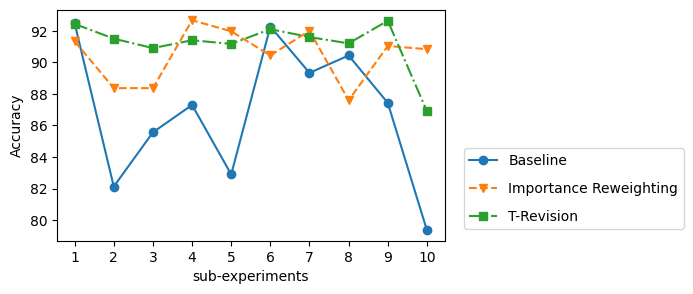

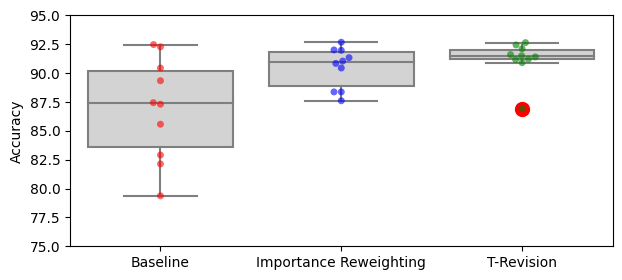

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:
    experiments_results = []
    for f in ["log/2023-11-04_18-33-29_experiment_results.obj", "log/2023-11-04_18-59-43_experiment_results.obj", "log/2023-11-04_20-00-20_experiment_results.obj"]:
        experiments_results += (joblib.load(WORKSPACE_PATH+f))
    generate_experiment_results_chart(experiments_results)
    generate_experiment_results_boxplot(experiments_results, ymin=75)

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_5:
    print(generate_experiment_results_table(experiments_results))

               & FashionMNIST0.5 BASELINE TRANSITION MATRIX DISABLED & FashionMNIST0.5 IMPORTANCE REWEIGHTING TRANSITION MATRIX KNOWN & FashionMNIST0.5 T REVISION TRANSITION MATRIX KNOWN  \\
recall 0 mean                  &   (0.8484)   &   0.8615   &   {0.8754}  \\
recall 0 std                   &   {0.0917}   &   (0.0364)   &   0.0459  \\
recall 1 mean                  &   (0.9100)   &   {0.9897}   &   0.9820  \\
recall 1 std                   &   {0.0734}   &   (0.0057)   &   0.0090  \\
recall 2 mean                  &   0.8864   &   (0.8771)   &   {0.8899}  \\
recall 2 std                   &   {0.0552}   &   (0.0231)   &   0.0271  \\
precision 0 mean               &   (0.8773)   &   {0.9571}   &   0.9413  \\
precision 0 std                &   {0.1084}   &   (0.0091)   &   0.0182  \\
precision 1 mean               &   0.9308   &   (0.9017)   &   {0.9312}  \\
precision 1 std                &   0.0261   &   {0.0275}   &   (0.0192)  \\
precision 2 mean               &   (0.7995)   &  

### 6.3 Experiments on FashionMNIST0.6 Dataset

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:

    model_class = CNN_model_FASHION
    model_hyperparameters = { "conv1":10, "conv2":20, "fcn1":15 }

Baseline experiment

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:

    baseline_cfg = {
        "name": "",
        "label_noise_method": "BASELINE",
        "transition_matrix_type": "DISABLED",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": nn.CrossEntropyLoss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.1, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([baseline_cfg], dataset="FashionMNIST0.6", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf535060>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5918a0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db0d0>}


100%|██████████| 113/113 [00:03<00:00, 31.60it/s]


epoch:1/20, ACC(train):33.854167, Loss(train):1.099325, ACC(valid):35.444444, Loss(valid):1.096900


100%|██████████| 113/113 [00:03<00:00, 32.98it/s]


epoch:2/20, ACC(train):35.000000, Loss(train):1.098161, ACC(valid):37.027778, Loss(valid):1.096358


100%|██████████| 113/113 [00:03<00:00, 28.71it/s]


epoch:3/20, ACC(train):36.548611, Loss(train):1.095840, ACC(valid):39.416667, Loss(valid):1.091816


100%|██████████| 113/113 [00:04<00:00, 28.15it/s]


epoch:4/20, ACC(train):37.243056, Loss(train):1.094772, ACC(valid):39.805556, Loss(valid):1.090432


100%|██████████| 113/113 [00:03<00:00, 33.40it/s]


epoch:5/20, ACC(train):37.597222, Loss(train):1.093955, ACC(valid):39.305556, Loss(valid):1.090980


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


epoch:6/20, ACC(train):38.125000, Loss(train):1.092890, ACC(valid):39.388889, Loss(valid):1.091981


100%|██████████| 113/113 [00:04<00:00, 25.10it/s]


epoch:7/20, ACC(train):38.368056, Loss(train):1.092623, ACC(valid):35.277778, Loss(valid):1.096823


100%|██████████| 113/113 [00:03<00:00, 33.60it/s]


epoch:8/20, ACC(train):38.687500, Loss(train):1.092308, ACC(valid):40.000000, Loss(valid):1.089302


100%|██████████| 113/113 [00:03<00:00, 33.47it/s]


epoch:9/20, ACC(train):39.138889, Loss(train):1.090965, ACC(valid):38.611111, Loss(valid):1.093118


100%|██████████| 113/113 [00:04<00:00, 23.65it/s]


epoch:10/20, ACC(train):38.701389, Loss(train):1.091185, ACC(valid):39.333333, Loss(valid):1.090962


100%|██████████| 113/113 [00:03<00:00, 33.48it/s]


epoch:11/20, ACC(train):39.069444, Loss(train):1.090387, ACC(valid):40.277778, Loss(valid):1.090846


100%|██████████| 113/113 [00:03<00:00, 33.61it/s]


epoch:12/20, ACC(train):38.979167, Loss(train):1.090601, ACC(valid):37.222222, Loss(valid):1.095749


100%|██████████| 113/113 [00:04<00:00, 24.65it/s]


epoch:13/20, ACC(train):38.750000, Loss(train):1.091747, ACC(valid):38.722222, Loss(valid):1.091610


100%|██████████| 113/113 [00:03<00:00, 33.59it/s]


epoch:14/20, ACC(train):39.631944, Loss(train):1.089114, ACC(valid):39.166667, Loss(valid):1.093370


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]


epoch:15/20, ACC(train):39.562500, Loss(train):1.089281, ACC(valid):39.444444, Loss(valid):1.092308


100%|██████████| 113/113 [00:04<00:00, 27.42it/s]


epoch:16/20, ACC(train):38.583333, Loss(train):1.091322, ACC(valid):37.944444, Loss(valid):1.093539


100%|██████████| 113/113 [00:03<00:00, 29.88it/s]


epoch:17/20, ACC(train):38.847222, Loss(train):1.088829, ACC(valid):39.000000, Loss(valid):1.094663


100%|██████████| 113/113 [00:03<00:00, 33.74it/s]


epoch:18/20, ACC(train):39.201389, Loss(train):1.088823, ACC(valid):39.694444, Loss(valid):1.091514


100%|██████████| 113/113 [00:03<00:00, 32.15it/s]


epoch:19/20, ACC(train):38.659722, Loss(train):1.090431, ACC(valid):38.861111, Loss(valid):1.090471


100%|██████████| 113/113 [00:04<00:00, 25.82it/s]


epoch:20/20, ACC(train):40.020833, Loss(train):1.087172, ACC(valid):39.027778, Loss(valid):1.092628
Accuracy:80.900000, Loss:0.952746 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dad10>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8370>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26daef0>}

100%|██████████| 113/113 [00:03<00:00, 32.49it/s]


epoch:1/20, ACC(train):33.833333, Loss(train):1.099738, ACC(valid):35.388889, Loss(valid):1.096542


100%|██████████| 113/113 [00:03<00:00, 31.32it/s]


epoch:2/20, ACC(train):35.430556, Loss(train):1.097596, ACC(valid):37.111111, Loss(valid):1.092324


100%|██████████| 113/113 [00:04<00:00, 25.50it/s]


epoch:3/20, ACC(train):38.194444, Loss(train):1.093715, ACC(valid):38.000000, Loss(valid):1.093320


100%|██████████| 113/113 [00:03<00:00, 32.41it/s]


epoch:4/20, ACC(train):38.722222, Loss(train):1.093074, ACC(valid):39.916667, Loss(valid):1.089456


100%|██████████| 113/113 [00:03<00:00, 32.17it/s]


epoch:5/20, ACC(train):38.361111, Loss(train):1.092708, ACC(valid):37.166667, Loss(valid):1.094648


100%|██████████| 113/113 [00:04<00:00, 23.95it/s]


epoch:6/20, ACC(train):38.944444, Loss(train):1.091397, ACC(valid):40.000000, Loss(valid):1.090094


100%|██████████| 113/113 [00:03<00:00, 32.57it/s]


epoch:7/20, ACC(train):38.736111, Loss(train):1.092578, ACC(valid):39.305556, Loss(valid):1.091282


100%|██████████| 113/113 [00:03<00:00, 32.86it/s]


epoch:8/20, ACC(train):38.493056, Loss(train):1.092374, ACC(valid):39.638889, Loss(valid):1.092576


100%|██████████| 113/113 [00:04<00:00, 23.51it/s]


epoch:9/20, ACC(train):39.062500, Loss(train):1.092101, ACC(valid):38.944444, Loss(valid):1.096056


100%|██████████| 113/113 [00:03<00:00, 32.67it/s]


epoch:10/20, ACC(train):38.965278, Loss(train):1.090559, ACC(valid):38.527778, Loss(valid):1.094012


100%|██████████| 113/113 [00:03<00:00, 33.19it/s]


epoch:11/20, ACC(train):39.048611, Loss(train):1.090138, ACC(valid):39.500000, Loss(valid):1.090538


100%|██████████| 113/113 [00:04<00:00, 23.69it/s]


epoch:12/20, ACC(train):39.347222, Loss(train):1.090763, ACC(valid):37.111111, Loss(valid):1.096677


100%|██████████| 113/113 [00:03<00:00, 32.80it/s]


epoch:13/20, ACC(train):39.583333, Loss(train):1.090057, ACC(valid):39.222222, Loss(valid):1.093701


100%|██████████| 113/113 [00:03<00:00, 32.90it/s]


epoch:14/20, ACC(train):39.527778, Loss(train):1.089007, ACC(valid):39.555556, Loss(valid):1.092369


100%|██████████| 113/113 [00:04<00:00, 26.39it/s]


epoch:15/20, ACC(train):38.833333, Loss(train):1.088818, ACC(valid):39.111111, Loss(valid):1.097173


100%|██████████| 113/113 [00:03<00:00, 30.35it/s]


epoch:16/20, ACC(train):39.368056, Loss(train):1.089348, ACC(valid):38.777778, Loss(valid):1.092600


100%|██████████| 113/113 [00:03<00:00, 32.95it/s]


epoch:17/20, ACC(train):39.597222, Loss(train):1.088061, ACC(valid):37.805556, Loss(valid):1.095948


100%|██████████| 113/113 [00:03<00:00, 29.70it/s]


epoch:18/20, ACC(train):39.534722, Loss(train):1.088180, ACC(valid):39.444444, Loss(valid):1.092480


100%|██████████| 113/113 [00:04<00:00, 26.85it/s]


epoch:19/20, ACC(train):39.284722, Loss(train):1.088454, ACC(valid):39.805556, Loss(valid):1.089619


100%|██████████| 113/113 [00:03<00:00, 33.18it/s]


epoch:20/20, ACC(train):39.736111, Loss(train):1.088163, ACC(valid):38.333333, Loss(valid):1.094622
Accuracy:76.733333, Loss:0.962562 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db7c0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da860>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9f00>}

100%|██████████| 113/113 [00:03<00:00, 30.25it/s]


epoch:1/20, ACC(train):33.812500, Loss(train):1.099796, ACC(valid):33.527778, Loss(valid):1.098552


100%|██████████| 113/113 [00:04<00:00, 26.52it/s]


epoch:2/20, ACC(train):36.118056, Loss(train):1.095789, ACC(valid):36.000000, Loss(valid):1.094869


100%|██████████| 113/113 [00:03<00:00, 32.90it/s]


epoch:3/20, ACC(train):38.291667, Loss(train):1.093733, ACC(valid):38.972222, Loss(valid):1.092676


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:4/20, ACC(train):38.458333, Loss(train):1.092419, ACC(valid):38.972222, Loss(valid):1.092026


100%|██████████| 113/113 [00:04<00:00, 24.13it/s]


epoch:5/20, ACC(train):39.125000, Loss(train):1.092304, ACC(valid):36.277778, Loss(valid):1.093577


100%|██████████| 113/113 [00:03<00:00, 32.96it/s]


epoch:6/20, ACC(train):38.986111, Loss(train):1.092459, ACC(valid):39.500000, Loss(valid):1.091325


100%|██████████| 113/113 [00:03<00:00, 33.31it/s]


epoch:7/20, ACC(train):39.041667, Loss(train):1.091679, ACC(valid):37.388889, Loss(valid):1.093799


100%|██████████| 113/113 [00:04<00:00, 23.41it/s]


epoch:8/20, ACC(train):39.236111, Loss(train):1.091412, ACC(valid):38.750000, Loss(valid):1.092490


100%|██████████| 113/113 [00:03<00:00, 33.12it/s]


epoch:9/20, ACC(train):39.201389, Loss(train):1.090900, ACC(valid):39.000000, Loss(valid):1.094897


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


epoch:10/20, ACC(train):39.340278, Loss(train):1.090886, ACC(valid):34.888889, Loss(valid):1.096023


100%|██████████| 113/113 [00:04<00:00, 24.18it/s]


epoch:11/20, ACC(train):38.965278, Loss(train):1.090718, ACC(valid):39.027778, Loss(valid):1.092528


100%|██████████| 113/113 [00:03<00:00, 33.22it/s]


epoch:12/20, ACC(train):39.298611, Loss(train):1.089841, ACC(valid):37.388889, Loss(valid):1.094047


100%|██████████| 113/113 [00:03<00:00, 32.79it/s]


epoch:13/20, ACC(train):39.638889, Loss(train):1.088934, ACC(valid):39.194444, Loss(valid):1.091902


100%|██████████| 113/113 [00:04<00:00, 26.90it/s]


epoch:14/20, ACC(train):39.791667, Loss(train):1.088006, ACC(valid):38.916667, Loss(valid):1.091779


100%|██████████| 113/113 [00:03<00:00, 30.10it/s]


epoch:15/20, ACC(train):39.944444, Loss(train):1.086871, ACC(valid):36.305556, Loss(valid):1.114825


100%|██████████| 113/113 [00:03<00:00, 33.44it/s]


epoch:16/20, ACC(train):39.451389, Loss(train):1.088308, ACC(valid):37.583333, Loss(valid):1.095292


100%|██████████| 113/113 [00:03<00:00, 30.32it/s]


epoch:17/20, ACC(train):39.854167, Loss(train):1.087256, ACC(valid):37.500000, Loss(valid):1.097377


100%|██████████| 113/113 [00:04<00:00, 26.64it/s]


epoch:18/20, ACC(train):39.666667, Loss(train):1.088461, ACC(valid):38.777778, Loss(valid):1.093683


100%|██████████| 113/113 [00:03<00:00, 33.42it/s]


epoch:19/20, ACC(train):39.513889, Loss(train):1.089581, ACC(valid):37.972222, Loss(valid):1.094577


100%|██████████| 113/113 [00:03<00:00, 33.05it/s]


epoch:20/20, ACC(train):39.534722, Loss(train):1.087573, ACC(valid):38.611111, Loss(valid):1.094455
Accuracy:80.333333, Loss:0.973479 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db970>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5924d0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d91b0>}

100%|██████████| 113/113 [00:04<00:00, 26.05it/s]


epoch:1/20, ACC(train):35.326389, Loss(train):1.097859, ACC(valid):39.416667, Loss(valid):1.092241


100%|██████████| 113/113 [00:03<00:00, 32.77it/s]


epoch:2/20, ACC(train):38.527778, Loss(train):1.093658, ACC(valid):37.083333, Loss(valid):1.093978


100%|██████████| 113/113 [00:03<00:00, 33.06it/s]


epoch:3/20, ACC(train):38.472222, Loss(train):1.092235, ACC(valid):38.972222, Loss(valid):1.091330


100%|██████████| 113/113 [00:04<00:00, 23.61it/s]


epoch:4/20, ACC(train):38.347222, Loss(train):1.093776, ACC(valid):37.250000, Loss(valid):1.096595


100%|██████████| 113/113 [00:03<00:00, 33.38it/s]


epoch:5/20, ACC(train):39.076389, Loss(train):1.091712, ACC(valid):39.305556, Loss(valid):1.092498


100%|██████████| 113/113 [00:03<00:00, 32.96it/s]


epoch:6/20, ACC(train):39.833333, Loss(train):1.090497, ACC(valid):38.444444, Loss(valid):1.094908


100%|██████████| 113/113 [00:04<00:00, 23.27it/s]


epoch:7/20, ACC(train):39.715278, Loss(train):1.089804, ACC(valid):37.333333, Loss(valid):1.097468


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:8/20, ACC(train):38.944444, Loss(train):1.090102, ACC(valid):39.027778, Loss(valid):1.092452


100%|██████████| 113/113 [00:03<00:00, 32.63it/s]


epoch:9/20, ACC(train):39.715278, Loss(train):1.089508, ACC(valid):39.416667, Loss(valid):1.093171


100%|██████████| 113/113 [00:04<00:00, 23.99it/s]


epoch:10/20, ACC(train):39.715278, Loss(train):1.089057, ACC(valid):38.750000, Loss(valid):1.093363


100%|██████████| 113/113 [00:03<00:00, 33.03it/s]


epoch:11/20, ACC(train):39.513889, Loss(train):1.089005, ACC(valid):37.166667, Loss(valid):1.097125


100%|██████████| 113/113 [00:03<00:00, 32.84it/s]


epoch:12/20, ACC(train):39.861111, Loss(train):1.088769, ACC(valid):39.583333, Loss(valid):1.091619


100%|██████████| 113/113 [00:04<00:00, 26.72it/s]


epoch:13/20, ACC(train):39.694444, Loss(train):1.087768, ACC(valid):38.944444, Loss(valid):1.092260


100%|██████████| 113/113 [00:03<00:00, 29.78it/s]


epoch:14/20, ACC(train):39.590278, Loss(train):1.087721, ACC(valid):39.083333, Loss(valid):1.093811


100%|██████████| 113/113 [00:03<00:00, 33.00it/s]


epoch:15/20, ACC(train):39.902778, Loss(train):1.087351, ACC(valid):38.555556, Loss(valid):1.093540


100%|██████████| 113/113 [00:03<00:00, 30.18it/s]


epoch:16/20, ACC(train):39.604167, Loss(train):1.088721, ACC(valid):38.888889, Loss(valid):1.094144


100%|██████████| 113/113 [00:04<00:00, 26.67it/s]


epoch:17/20, ACC(train):40.013889, Loss(train):1.087186, ACC(valid):38.944444, Loss(valid):1.093750


100%|██████████| 113/113 [00:03<00:00, 33.30it/s]


epoch:18/20, ACC(train):39.826389, Loss(train):1.085995, ACC(valid):35.972222, Loss(valid):1.104295


100%|██████████| 113/113 [00:03<00:00, 33.06it/s]


epoch:19/20, ACC(train):39.729167, Loss(train):1.083945, ACC(valid):39.361111, Loss(valid):1.092763


100%|██████████| 113/113 [00:04<00:00, 24.10it/s]


epoch:20/20, ACC(train):40.083333, Loss(train):1.084556, ACC(valid):38.083333, Loss(valid):1.096099
Accuracy:73.166667, Loss:0.985366 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db6a0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9e10>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8fd0>}

100%|██████████| 113/113 [00:03<00:00, 32.31it/s]


epoch:1/20, ACC(train):33.798611, Loss(train):1.100167, ACC(valid):36.555556, Loss(valid):1.095139


100%|██████████| 113/113 [00:03<00:00, 32.66it/s]


epoch:2/20, ACC(train):36.861111, Loss(train):1.096632, ACC(valid):37.138889, Loss(valid):1.096867


100%|██████████| 113/113 [00:04<00:00, 24.23it/s]


epoch:3/20, ACC(train):36.673611, Loss(train):1.094633, ACC(valid):38.388889, Loss(valid):1.094516


100%|██████████| 113/113 [00:03<00:00, 32.83it/s]


epoch:4/20, ACC(train):38.486111, Loss(train):1.092817, ACC(valid):38.277778, Loss(valid):1.092511


100%|██████████| 113/113 [00:03<00:00, 32.99it/s]


epoch:5/20, ACC(train):38.680556, Loss(train):1.092302, ACC(valid):36.666667, Loss(valid):1.099788


100%|██████████| 113/113 [00:04<00:00, 23.52it/s]


epoch:6/20, ACC(train):39.027778, Loss(train):1.089951, ACC(valid):38.250000, Loss(valid):1.093770


100%|██████████| 113/113 [00:03<00:00, 33.26it/s]


epoch:7/20, ACC(train):39.298611, Loss(train):1.090517, ACC(valid):38.361111, Loss(valid):1.094018


100%|██████████| 113/113 [00:03<00:00, 32.99it/s]


epoch:8/20, ACC(train):39.743056, Loss(train):1.088842, ACC(valid):38.722222, Loss(valid):1.092269


100%|██████████| 113/113 [00:04<00:00, 23.45it/s]


epoch:9/20, ACC(train):39.513889, Loss(train):1.089546, ACC(valid):37.694444, Loss(valid):1.094648


100%|██████████| 113/113 [00:03<00:00, 32.84it/s]


epoch:10/20, ACC(train):39.333333, Loss(train):1.089337, ACC(valid):37.777778, Loss(valid):1.095917


100%|██████████| 113/113 [00:03<00:00, 33.34it/s]


epoch:11/20, ACC(train):39.527778, Loss(train):1.087945, ACC(valid):37.111111, Loss(valid):1.094669


100%|██████████| 113/113 [00:04<00:00, 25.95it/s]


epoch:12/20, ACC(train):40.118056, Loss(train):1.085728, ACC(valid):37.138889, Loss(valid):1.108570


100%|██████████| 113/113 [00:03<00:00, 31.20it/s]


epoch:13/20, ACC(train):40.291667, Loss(train):1.086004, ACC(valid):37.444444, Loss(valid):1.096641


100%|██████████| 113/113 [00:03<00:00, 33.08it/s]


epoch:14/20, ACC(train):40.013889, Loss(train):1.086513, ACC(valid):37.194444, Loss(valid):1.099122


100%|██████████| 113/113 [00:03<00:00, 29.26it/s]


epoch:15/20, ACC(train):40.062500, Loss(train):1.085278, ACC(valid):36.305556, Loss(valid):1.100343


100%|██████████| 113/113 [00:04<00:00, 27.39it/s]


epoch:16/20, ACC(train):40.472222, Loss(train):1.082589, ACC(valid):36.555556, Loss(valid):1.106130


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


epoch:17/20, ACC(train):40.256944, Loss(train):1.084365, ACC(valid):37.000000, Loss(valid):1.097664


100%|██████████| 113/113 [00:03<00:00, 33.32it/s]


epoch:18/20, ACC(train):41.069444, Loss(train):1.082283, ACC(valid):37.055556, Loss(valid):1.100354


100%|██████████| 113/113 [00:04<00:00, 24.15it/s]


epoch:19/20, ACC(train):41.277778, Loss(train):1.080074, ACC(valid):36.833333, Loss(valid):1.104598


100%|██████████| 113/113 [00:03<00:00, 33.23it/s]


epoch:20/20, ACC(train):41.041667, Loss(train):1.077821, ACC(valid):37.222222, Loss(valid):1.113788
Accuracy:75.000000, Loss:0.944597 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9ab0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8a30>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8850>}

100%|██████████| 113/113 [00:03<00:00, 33.03it/s]


epoch:1/20, ACC(train):35.062500, Loss(train):1.097759, ACC(valid):37.000000, Loss(valid):1.095901


100%|██████████| 113/113 [00:04<00:00, 23.39it/s]


epoch:2/20, ACC(train):36.965278, Loss(train):1.096187, ACC(valid):36.472222, Loss(valid):1.096810


100%|██████████| 113/113 [00:03<00:00, 33.39it/s]


epoch:3/20, ACC(train):36.791667, Loss(train):1.095785, ACC(valid):36.444444, Loss(valid):1.095329


100%|██████████| 113/113 [00:03<00:00, 33.20it/s]


epoch:4/20, ACC(train):37.847222, Loss(train):1.093559, ACC(valid):38.916667, Loss(valid):1.093776


100%|██████████| 113/113 [00:04<00:00, 23.43it/s]


epoch:5/20, ACC(train):38.826389, Loss(train):1.092321, ACC(valid):39.194444, Loss(valid):1.091718


100%|██████████| 113/113 [00:03<00:00, 33.31it/s]


epoch:6/20, ACC(train):38.930556, Loss(train):1.092525, ACC(valid):37.944444, Loss(valid):1.092715


100%|██████████| 113/113 [00:03<00:00, 33.37it/s]


epoch:7/20, ACC(train):38.763889, Loss(train):1.091755, ACC(valid):39.055556, Loss(valid):1.091462


100%|██████████| 113/113 [00:04<00:00, 25.26it/s]


epoch:8/20, ACC(train):39.048611, Loss(train):1.090602, ACC(valid):38.861111, Loss(valid):1.091762


100%|██████████| 113/113 [00:03<00:00, 32.25it/s]


epoch:9/20, ACC(train):38.937500, Loss(train):1.092557, ACC(valid):37.444444, Loss(valid):1.094583


100%|██████████| 113/113 [00:03<00:00, 33.44it/s]


epoch:10/20, ACC(train):39.256944, Loss(train):1.090345, ACC(valid):39.666667, Loss(valid):1.091138


100%|██████████| 113/113 [00:03<00:00, 28.60it/s]


epoch:11/20, ACC(train):39.395833, Loss(train):1.090127, ACC(valid):38.083333, Loss(valid):1.094932


100%|██████████| 113/113 [00:04<00:00, 28.11it/s]


epoch:12/20, ACC(train):39.333333, Loss(train):1.090248, ACC(valid):38.916667, Loss(valid):1.093963


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


epoch:13/20, ACC(train):39.256944, Loss(train):1.089580, ACC(valid):39.611111, Loss(valid):1.091045


100%|██████████| 113/113 [00:03<00:00, 33.51it/s]


epoch:14/20, ACC(train):39.680556, Loss(train):1.089226, ACC(valid):39.083333, Loss(valid):1.092808


100%|██████████| 113/113 [00:04<00:00, 24.52it/s]


epoch:15/20, ACC(train):39.263889, Loss(train):1.089192, ACC(valid):39.083333, Loss(valid):1.090662


100%|██████████| 113/113 [00:03<00:00, 32.99it/s]


epoch:16/20, ACC(train):39.347222, Loss(train):1.088753, ACC(valid):38.888889, Loss(valid):1.092303


100%|██████████| 113/113 [00:03<00:00, 33.27it/s]


epoch:17/20, ACC(train):39.652778, Loss(train):1.088490, ACC(valid):37.416667, Loss(valid):1.097857


100%|██████████| 113/113 [00:04<00:00, 23.50it/s]


epoch:18/20, ACC(train):39.659722, Loss(train):1.087867, ACC(valid):38.500000, Loss(valid):1.102349


100%|██████████| 113/113 [00:03<00:00, 33.48it/s]


epoch:19/20, ACC(train):39.180556, Loss(train):1.088725, ACC(valid):39.000000, Loss(valid):1.092018


100%|██████████| 113/113 [00:03<00:00, 33.39it/s]


epoch:20/20, ACC(train):39.972222, Loss(train):1.086751, ACC(valid):39.027778, Loss(valid):1.096328
Accuracy:79.066667, Loss:0.916725 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dba60>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db4f0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26db400>}

100%|██████████| 113/113 [00:04<00:00, 23.16it/s]


epoch:1/20, ACC(train):33.680556, Loss(train):1.100398, ACC(valid):34.666667, Loss(valid):1.098135


100%|██████████| 113/113 [00:03<00:00, 32.90it/s]


epoch:2/20, ACC(train):36.180556, Loss(train):1.095905, ACC(valid):34.916667, Loss(valid):1.099815


100%|██████████| 113/113 [00:03<00:00, 32.75it/s]


epoch:3/20, ACC(train):38.152778, Loss(train):1.093332, ACC(valid):35.166667, Loss(valid):1.099507


100%|██████████| 113/113 [00:04<00:00, 24.54it/s]


epoch:4/20, ACC(train):38.069444, Loss(train):1.092038, ACC(valid):37.694444, Loss(valid):1.099174


100%|██████████| 113/113 [00:03<00:00, 32.69it/s]


epoch:5/20, ACC(train):39.034722, Loss(train):1.091349, ACC(valid):38.000000, Loss(valid):1.097130


100%|██████████| 113/113 [00:03<00:00, 32.65it/s]


epoch:6/20, ACC(train):39.270833, Loss(train):1.089833, ACC(valid):37.083333, Loss(valid):1.103001


100%|██████████| 113/113 [00:04<00:00, 27.33it/s]


epoch:7/20, ACC(train):39.104167, Loss(train):1.090362, ACC(valid):37.777778, Loss(valid):1.097421


100%|██████████| 113/113 [00:03<00:00, 29.64it/s]


epoch:8/20, ACC(train):39.069444, Loss(train):1.090796, ACC(valid):38.083333, Loss(valid):1.097936


100%|██████████| 113/113 [00:03<00:00, 33.02it/s]


epoch:9/20, ACC(train):39.645833, Loss(train):1.088570, ACC(valid):37.944444, Loss(valid):1.098180


100%|██████████| 113/113 [00:03<00:00, 30.71it/s]


epoch:10/20, ACC(train):39.430556, Loss(train):1.089283, ACC(valid):37.861111, Loss(valid):1.096934


100%|██████████| 113/113 [00:04<00:00, 26.18it/s]


epoch:11/20, ACC(train):39.534722, Loss(train):1.088452, ACC(valid):37.805556, Loss(valid):1.098494


100%|██████████| 113/113 [00:03<00:00, 33.25it/s]


epoch:12/20, ACC(train):39.520833, Loss(train):1.088109, ACC(valid):38.000000, Loss(valid):1.100785


100%|██████████| 113/113 [00:03<00:00, 33.26it/s]


epoch:13/20, ACC(train):39.562500, Loss(train):1.088716, ACC(valid):37.000000, Loss(valid):1.108475


100%|██████████| 113/113 [00:04<00:00, 23.43it/s]


epoch:14/20, ACC(train):39.819444, Loss(train):1.088701, ACC(valid):37.972222, Loss(valid):1.096024


100%|██████████| 113/113 [00:03<00:00, 33.36it/s]


epoch:15/20, ACC(train):39.381944, Loss(train):1.088029, ACC(valid):37.333333, Loss(valid):1.101072


100%|██████████| 113/113 [00:03<00:00, 33.00it/s]


epoch:16/20, ACC(train):39.409722, Loss(train):1.087037, ACC(valid):36.916667, Loss(valid):1.098702


100%|██████████| 113/113 [00:04<00:00, 23.45it/s]


epoch:17/20, ACC(train):39.493056, Loss(train):1.086908, ACC(valid):37.611111, Loss(valid):1.097664


100%|██████████| 113/113 [00:03<00:00, 33.05it/s]


epoch:18/20, ACC(train):39.805556, Loss(train):1.086259, ACC(valid):36.722222, Loss(valid):1.099884


100%|██████████| 113/113 [00:03<00:00, 32.99it/s]


epoch:19/20, ACC(train):39.923611, Loss(train):1.085878, ACC(valid):37.361111, Loss(valid):1.103258


100%|██████████| 113/113 [00:04<00:00, 25.42it/s]


epoch:20/20, ACC(train):40.027778, Loss(train):1.085881, ACC(valid):37.638889, Loss(valid):1.098610
Accuracy:73.333333, Loss:0.974559 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dbaf0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da200>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8ee0>}

100%|██████████| 113/113 [00:03<00:00, 33.49it/s]


epoch:1/20, ACC(train):33.423611, Loss(train):1.099790, ACC(valid):33.333333, Loss(valid):1.099545


100%|██████████| 113/113 [00:03<00:00, 33.06it/s]


epoch:2/20, ACC(train):35.604167, Loss(train):1.097276, ACC(valid):37.916667, Loss(valid):1.094239


100%|██████████| 113/113 [00:04<00:00, 26.08it/s]


epoch:3/20, ACC(train):37.451389, Loss(train):1.094845, ACC(valid):38.444444, Loss(valid):1.094085


100%|██████████| 113/113 [00:03<00:00, 30.73it/s]


epoch:4/20, ACC(train):38.097222, Loss(train):1.093784, ACC(valid):38.444444, Loss(valid):1.092574


100%|██████████| 113/113 [00:03<00:00, 32.98it/s]


epoch:5/20, ACC(train):38.715278, Loss(train):1.092461, ACC(valid):38.222222, Loss(valid):1.095763


100%|██████████| 113/113 [00:03<00:00, 29.41it/s]


epoch:6/20, ACC(train):39.083333, Loss(train):1.091091, ACC(valid):39.194444, Loss(valid):1.094039


100%|██████████| 113/113 [00:04<00:00, 27.11it/s]


epoch:7/20, ACC(train):39.652778, Loss(train):1.090728, ACC(valid):39.583333, Loss(valid):1.091147


100%|██████████| 113/113 [00:03<00:00, 32.97it/s]


epoch:8/20, ACC(train):39.673611, Loss(train):1.089288, ACC(valid):35.138889, Loss(valid):1.096448


100%|██████████| 113/113 [00:03<00:00, 33.70it/s]


epoch:9/20, ACC(train):38.562500, Loss(train):1.092069, ACC(valid):39.277778, Loss(valid):1.093697


100%|██████████| 113/113 [00:04<00:00, 24.34it/s]


epoch:10/20, ACC(train):39.395833, Loss(train):1.089852, ACC(valid):37.000000, Loss(valid):1.101145


100%|██████████| 113/113 [00:03<00:00, 33.03it/s]


epoch:11/20, ACC(train):39.562500, Loss(train):1.089266, ACC(valid):39.166667, Loss(valid):1.092669


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


epoch:12/20, ACC(train):39.430556, Loss(train):1.089741, ACC(valid):35.472222, Loss(valid):1.097735


100%|██████████| 113/113 [00:04<00:00, 23.29it/s]


epoch:13/20, ACC(train):39.888889, Loss(train):1.087484, ACC(valid):39.000000, Loss(valid):1.094888


100%|██████████| 113/113 [00:03<00:00, 32.47it/s]


epoch:14/20, ACC(train):40.083333, Loss(train):1.086199, ACC(valid):38.638889, Loss(valid):1.094327


100%|██████████| 113/113 [00:03<00:00, 33.19it/s]


epoch:15/20, ACC(train):39.805556, Loss(train):1.085619, ACC(valid):38.361111, Loss(valid):1.093185


100%|██████████| 113/113 [00:04<00:00, 23.74it/s]


epoch:16/20, ACC(train):39.736111, Loss(train):1.086817, ACC(valid):38.861111, Loss(valid):1.094162


100%|██████████| 113/113 [00:03<00:00, 33.25it/s]


epoch:17/20, ACC(train):39.722222, Loss(train):1.086013, ACC(valid):38.722222, Loss(valid):1.092941


100%|██████████| 113/113 [00:03<00:00, 33.08it/s]


epoch:18/20, ACC(train):40.034722, Loss(train):1.084409, ACC(valid):37.694444, Loss(valid):1.094369


100%|██████████| 113/113 [00:04<00:00, 27.22it/s]


epoch:19/20, ACC(train):40.715278, Loss(train):1.083846, ACC(valid):37.666667, Loss(valid):1.100303


100%|██████████| 113/113 [00:03<00:00, 29.76it/s]


epoch:20/20, ACC(train):40.361111, Loss(train):1.082232, ACC(valid):38.277778, Loss(valid):1.095917
Accuracy:75.066667, Loss:0.963272 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dab90>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0550>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0190>}

100%|██████████| 113/113 [00:03<00:00, 32.59it/s]


epoch:1/20, ACC(train):34.368056, Loss(train):1.098568, ACC(valid):37.027778, Loss(valid):1.094510


100%|██████████| 113/113 [00:04<00:00, 27.34it/s]


epoch:2/20, ACC(train):37.430556, Loss(train):1.094714, ACC(valid):39.777778, Loss(valid):1.091263


100%|██████████| 113/113 [00:03<00:00, 29.40it/s]


epoch:3/20, ACC(train):38.625000, Loss(train):1.092219, ACC(valid):36.027778, Loss(valid):1.095048


100%|██████████| 113/113 [00:03<00:00, 33.05it/s]


epoch:4/20, ACC(train):38.361111, Loss(train):1.092886, ACC(valid):37.388889, Loss(valid):1.097600


100%|██████████| 113/113 [00:03<00:00, 31.19it/s]


epoch:5/20, ACC(train):39.152778, Loss(train):1.091705, ACC(valid):39.055556, Loss(valid):1.092035


100%|██████████| 113/113 [00:04<00:00, 25.83it/s]


epoch:6/20, ACC(train):38.722222, Loss(train):1.091629, ACC(valid):38.472222, Loss(valid):1.094940


100%|██████████| 113/113 [00:03<00:00, 33.71it/s]


epoch:7/20, ACC(train):39.368056, Loss(train):1.091379, ACC(valid):39.444444, Loss(valid):1.091704


100%|██████████| 113/113 [00:03<00:00, 33.10it/s]


epoch:8/20, ACC(train):39.486111, Loss(train):1.090554, ACC(valid):39.027778, Loss(valid):1.092886


100%|██████████| 113/113 [00:04<00:00, 23.60it/s]


epoch:9/20, ACC(train):39.402778, Loss(train):1.089014, ACC(valid):38.861111, Loss(valid):1.093843


100%|██████████| 113/113 [00:03<00:00, 33.62it/s]


epoch:10/20, ACC(train):39.500000, Loss(train):1.088576, ACC(valid):39.305556, Loss(valid):1.095531


100%|██████████| 113/113 [00:03<00:00, 33.47it/s]


epoch:11/20, ACC(train):39.791667, Loss(train):1.087869, ACC(valid):39.444444, Loss(valid):1.094713


100%|██████████| 113/113 [00:04<00:00, 23.57it/s]


epoch:12/20, ACC(train):39.277778, Loss(train):1.089775, ACC(valid):38.833333, Loss(valid):1.096180


100%|██████████| 113/113 [00:03<00:00, 33.80it/s]


epoch:13/20, ACC(train):39.527778, Loss(train):1.087547, ACC(valid):38.472222, Loss(valid):1.094499


100%|██████████| 113/113 [00:03<00:00, 33.84it/s]


epoch:14/20, ACC(train):40.118056, Loss(train):1.085341, ACC(valid):39.277778, Loss(valid):1.095861


100%|██████████| 113/113 [00:04<00:00, 26.92it/s]


epoch:15/20, ACC(train):39.972222, Loss(train):1.085799, ACC(valid):39.472222, Loss(valid):1.092658


100%|██████████| 113/113 [00:03<00:00, 30.92it/s]


epoch:16/20, ACC(train):39.701389, Loss(train):1.087080, ACC(valid):39.138889, Loss(valid):1.093536


100%|██████████| 113/113 [00:03<00:00, 34.05it/s]


epoch:17/20, ACC(train):39.756944, Loss(train):1.084876, ACC(valid):38.777778, Loss(valid):1.095490


100%|██████████| 113/113 [00:03<00:00, 31.79it/s]


epoch:18/20, ACC(train):40.375000, Loss(train):1.084659, ACC(valid):38.916667, Loss(valid):1.095500


100%|██████████| 113/113 [00:04<00:00, 25.91it/s]


epoch:19/20, ACC(train):40.354167, Loss(train):1.084172, ACC(valid):39.305556, Loss(valid):1.099059


100%|██████████| 113/113 [00:03<00:00, 33.47it/s]


epoch:20/20, ACC(train):40.500000, Loss(train):1.083339, ACC(valid):37.305556, Loss(valid):1.098604
Accuracy:63.600000, Loss:0.998740 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.6_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c06d0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0730>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0be0>

100%|██████████| 113/113 [00:03<00:00, 32.18it/s]


epoch:1/20, ACC(train):34.215278, Loss(train):1.099226, ACC(valid):33.222222, Loss(valid):1.095952


100%|██████████| 113/113 [00:04<00:00, 24.84it/s]


epoch:2/20, ACC(train):35.020833, Loss(train):1.097841, ACC(valid):33.333333, Loss(valid):1.102628


100%|██████████| 113/113 [00:03<00:00, 32.88it/s]


epoch:3/20, ACC(train):35.743056, Loss(train):1.096738, ACC(valid):40.250000, Loss(valid):1.089693


100%|██████████| 113/113 [00:03<00:00, 33.04it/s]


epoch:4/20, ACC(train):38.375000, Loss(train):1.093386, ACC(valid):40.361111, Loss(valid):1.090585


100%|██████████| 113/113 [00:04<00:00, 23.27it/s]


epoch:5/20, ACC(train):38.361111, Loss(train):1.092757, ACC(valid):40.361111, Loss(valid):1.087109


100%|██████████| 113/113 [00:03<00:00, 33.19it/s]


epoch:6/20, ACC(train):38.729167, Loss(train):1.092984, ACC(valid):38.555556, Loss(valid):1.091868


100%|██████████| 113/113 [00:03<00:00, 33.43it/s]


epoch:7/20, ACC(train):38.972222, Loss(train):1.092249, ACC(valid):40.722222, Loss(valid):1.088331


100%|██████████| 113/113 [00:04<00:00, 23.45it/s]


epoch:8/20, ACC(train):39.090278, Loss(train):1.092131, ACC(valid):40.083333, Loss(valid):1.088757


100%|██████████| 113/113 [00:03<00:00, 33.26it/s]


epoch:9/20, ACC(train):38.951389, Loss(train):1.093101, ACC(valid):38.222222, Loss(valid):1.092796


100%|██████████| 113/113 [00:03<00:00, 33.42it/s]


epoch:10/20, ACC(train):39.159722, Loss(train):1.090922, ACC(valid):38.000000, Loss(valid):1.092547


100%|██████████| 113/113 [00:04<00:00, 26.72it/s]


epoch:11/20, ACC(train):38.548611, Loss(train):1.091978, ACC(valid):40.305556, Loss(valid):1.087206


100%|██████████| 113/113 [00:03<00:00, 30.13it/s]


epoch:12/20, ACC(train):39.250000, Loss(train):1.090503, ACC(valid):40.194444, Loss(valid):1.088745


100%|██████████| 113/113 [00:03<00:00, 33.30it/s]


epoch:13/20, ACC(train):38.847222, Loss(train):1.092318, ACC(valid):33.722222, Loss(valid):1.105813


100%|██████████| 113/113 [00:03<00:00, 30.72it/s]


epoch:14/20, ACC(train):38.756944, Loss(train):1.092013, ACC(valid):40.027778, Loss(valid):1.089312


100%|██████████| 113/113 [00:04<00:00, 26.49it/s]


epoch:15/20, ACC(train):39.277778, Loss(train):1.090526, ACC(valid):36.888889, Loss(valid):1.093113


100%|██████████| 113/113 [00:03<00:00, 33.15it/s]


epoch:16/20, ACC(train):39.465278, Loss(train):1.089059, ACC(valid):40.944444, Loss(valid):1.087932


100%|██████████| 113/113 [00:03<00:00, 33.52it/s]


epoch:17/20, ACC(train):39.680556, Loss(train):1.089085, ACC(valid):39.083333, Loss(valid):1.090250


100%|██████████| 113/113 [00:04<00:00, 23.49it/s]


epoch:18/20, ACC(train):39.951389, Loss(train):1.088125, ACC(valid):40.833333, Loss(valid):1.088315


100%|██████████| 113/113 [00:03<00:00, 33.36it/s]


epoch:19/20, ACC(train):39.493056, Loss(train):1.088381, ACC(valid):40.222222, Loss(valid):1.099318


100%|██████████| 113/113 [00:03<00:00, 33.59it/s]


epoch:20/20, ACC(train):39.486111, Loss(train):1.088681, ACC(valid):39.750000, Loss(valid):1.090635
Accuracy:83.133333, Loss:0.949882 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_20-14-41_experiment_results.obj


Train CNN model by using Importance Reweighting method (with known flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:

    importance_reweighting_cfg = {
        "name": "",
        "label_noise_method": "IMPORTANCE_REWEIGHTING",
        "transition_matrix_type": "KNOWN",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([importance_reweighting_cfg], dataset="FashionMNIST0.6", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d8250>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d85e0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d90c0>, 'transition_matrix': tensor([[0.4000, 0.3000, 0.3000],
        [0.3000, 0.4000, 0.3000],
        [0.3000, 0.30

100%|██████████| 113/113 [00:07<00:00, 15.72it/s]


epoch:1/20, ACC(train):33.208333, Loss(train):1.097788, ACC(valid):33.250000, Loss(valid):1.098406


100%|██████████| 113/113 [00:07<00:00, 16.09it/s]


epoch:2/20, ACC(train):34.263889, Loss(train):1.097188, ACC(valid):37.111111, Loss(valid):1.097179


100%|██████████| 113/113 [00:06<00:00, 18.17it/s]


epoch:3/20, ACC(train):34.965278, Loss(train):1.086472, ACC(valid):34.611111, Loss(valid):1.079206


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:4/20, ACC(train):36.208333, Loss(train):1.050300, ACC(valid):37.888889, Loss(valid):1.033179


100%|██████████| 113/113 [00:06<00:00, 18.20it/s]


epoch:5/20, ACC(train):37.020833, Loss(train):0.899658, ACC(valid):36.000000, Loss(valid):0.686757


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:6/20, ACC(train):38.083333, Loss(train):0.697553, ACC(valid):39.055556, Loss(valid):0.608379


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:7/20, ACC(train):38.423611, Loss(train):0.547470, ACC(valid):39.222222, Loss(valid):0.502922


100%|██████████| 113/113 [00:06<00:00, 16.34it/s]


epoch:8/20, ACC(train):38.965278, Loss(train):0.475524, ACC(valid):39.222222, Loss(valid):0.441018


100%|██████████| 113/113 [00:07<00:00, 15.24it/s]


epoch:9/20, ACC(train):38.798611, Loss(train):0.434617, ACC(valid):39.888889, Loss(valid):0.447784


100%|██████████| 113/113 [00:06<00:00, 17.93it/s]


epoch:10/20, ACC(train):39.284722, Loss(train):0.430751, ACC(valid):39.250000, Loss(valid):0.398366


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:11/20, ACC(train):39.319444, Loss(train):0.365758, ACC(valid):39.194444, Loss(valid):0.402952


100%|██████████| 113/113 [00:06<00:00, 18.22it/s]


epoch:12/20, ACC(train):39.486111, Loss(train):0.325205, ACC(valid):39.611111, Loss(valid):0.304367


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:13/20, ACC(train):39.430556, Loss(train):0.295596, ACC(valid):39.138889, Loss(valid):0.342826


100%|██████████| 113/113 [00:06<00:00, 16.96it/s]


epoch:14/20, ACC(train):39.784722, Loss(train):0.300942, ACC(valid):39.611111, Loss(valid):0.270823


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


epoch:15/20, ACC(train):39.631944, Loss(train):0.254011, ACC(valid):39.305556, Loss(valid):0.313711


100%|██████████| 113/113 [00:07<00:00, 15.34it/s]


epoch:16/20, ACC(train):39.513889, Loss(train):0.267312, ACC(valid):39.611111, Loss(valid):0.266132


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:17/20, ACC(train):39.875000, Loss(train):0.261594, ACC(valid):39.111111, Loss(valid):0.300726


100%|██████████| 113/113 [00:07<00:00, 15.40it/s]


epoch:18/20, ACC(train):39.854167, Loss(train):0.245744, ACC(valid):39.277778, Loss(valid):0.252937


100%|██████████| 113/113 [00:06<00:00, 18.11it/s]


epoch:19/20, ACC(train):39.777778, Loss(train):0.258153, ACC(valid):39.500000, Loss(valid):0.308101


100%|██████████| 113/113 [00:07<00:00, 15.63it/s]


epoch:20/20, ACC(train):39.645833, Loss(train):0.256275, ACC(valid):39.805556, Loss(valid):0.239208
Accuracy:87.733333, Loss:0.330866 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf536890>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da380>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 15.03it/s]


epoch:1/20, ACC(train):33.250000, Loss(train):1.093261, ACC(valid):33.333333, Loss(valid):1.093589


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:2/20, ACC(train):33.597222, Loss(train):1.094030, ACC(valid):33.805556, Loss(valid):1.091063


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:3/20, ACC(train):34.958333, Loss(train):1.070812, ACC(valid):33.833333, Loss(valid):1.038156


100%|██████████| 113/113 [00:06<00:00, 17.91it/s]


epoch:4/20, ACC(train):35.472222, Loss(train):1.025621, ACC(valid):36.750000, Loss(valid):0.979363


100%|██████████| 113/113 [00:07<00:00, 15.31it/s]


epoch:5/20, ACC(train):36.881944, Loss(train):0.899138, ACC(valid):36.805556, Loss(valid):0.789066


100%|██████████| 113/113 [00:07<00:00, 16.09it/s]


epoch:6/20, ACC(train):36.430556, Loss(train):0.783355, ACC(valid):37.416667, Loss(valid):0.845617


100%|██████████| 113/113 [00:06<00:00, 17.99it/s]


epoch:7/20, ACC(train):36.583333, Loss(train):0.785070, ACC(valid):38.194444, Loss(valid):0.786392


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:8/20, ACC(train):38.201389, Loss(train):0.696233, ACC(valid):40.055556, Loss(valid):0.622773


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:9/20, ACC(train):38.590278, Loss(train):0.593628, ACC(valid):39.750000, Loss(valid):0.574052


100%|██████████| 113/113 [00:07<00:00, 14.88it/s]


epoch:10/20, ACC(train):39.131944, Loss(train):0.516416, ACC(valid):40.194444, Loss(valid):0.463866


100%|██████████| 113/113 [00:06<00:00, 16.93it/s]


epoch:11/20, ACC(train):39.069444, Loss(train):0.426360, ACC(valid):40.027778, Loss(valid):0.433178


100%|██████████| 113/113 [00:06<00:00, 16.93it/s]


epoch:12/20, ACC(train):39.381944, Loss(train):0.437339, ACC(valid):40.138889, Loss(valid):0.358500


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:13/20, ACC(train):39.437500, Loss(train):0.366178, ACC(valid):39.944444, Loss(valid):0.354126


100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


epoch:14/20, ACC(train):39.493056, Loss(train):0.343182, ACC(valid):39.527778, Loss(valid):0.338871


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:15/20, ACC(train):39.388889, Loss(train):0.347707, ACC(valid):39.750000, Loss(valid):0.332424


100%|██████████| 113/113 [00:06<00:00, 17.84it/s]


epoch:16/20, ACC(train):39.375000, Loss(train):0.327437, ACC(valid):40.027778, Loss(valid):0.302770


100%|██████████| 113/113 [00:07<00:00, 16.07it/s]


epoch:17/20, ACC(train):39.611111, Loss(train):0.299087, ACC(valid):39.944444, Loss(valid):0.312837


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:18/20, ACC(train):39.631944, Loss(train):0.306151, ACC(valid):39.666667, Loss(valid):0.336990


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:19/20, ACC(train):39.652778, Loss(train):0.308945, ACC(valid):39.722222, Loss(valid):0.316255


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:20/20, ACC(train):39.562500, Loss(train):0.307892, ACC(valid):39.777778, Loss(valid):0.320860
Accuracy:88.266667, Loss:0.309275 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dbe20>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da350>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:1/20, ACC(train):32.965278, Loss(train):1.096877, ACC(valid):34.138889, Loss(valid):1.098348


100%|██████████| 113/113 [00:07<00:00, 15.85it/s]


epoch:2/20, ACC(train):32.888889, Loss(train):1.098185, ACC(valid):33.277778, Loss(valid):1.098139


100%|██████████| 113/113 [00:07<00:00, 15.74it/s]


epoch:3/20, ACC(train):34.833333, Loss(train):1.098087, ACC(valid):35.305556, Loss(valid):1.097691


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


epoch:4/20, ACC(train):35.868056, Loss(train):1.096689, ACC(valid):36.333333, Loss(valid):1.095498


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:5/20, ACC(train):36.097222, Loss(train):1.092979, ACC(valid):35.277778, Loss(valid):1.084205


100%|██████████| 113/113 [00:06<00:00, 17.91it/s]


epoch:6/20, ACC(train):36.423611, Loss(train):1.053813, ACC(valid):36.250000, Loss(valid):0.965952


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:7/20, ACC(train):36.631944, Loss(train):0.898182, ACC(valid):38.166667, Loss(valid):0.829982


100%|██████████| 113/113 [00:06<00:00, 16.59it/s]


epoch:8/20, ACC(train):37.347222, Loss(train):0.796325, ACC(valid):38.138889, Loss(valid):0.734982


100%|██████████| 113/113 [00:06<00:00, 17.31it/s]


epoch:9/20, ACC(train):38.111111, Loss(train):0.655916, ACC(valid):38.361111, Loss(valid):0.647292


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:10/20, ACC(train):38.645833, Loss(train):0.582385, ACC(valid):39.361111, Loss(valid):0.533715


100%|██████████| 113/113 [00:06<00:00, 17.75it/s]


epoch:11/20, ACC(train):38.895833, Loss(train):0.486844, ACC(valid):38.916667, Loss(valid):0.443525


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:12/20, ACC(train):39.541667, Loss(train):0.417876, ACC(valid):38.611111, Loss(valid):0.394215


100%|██████████| 113/113 [00:06<00:00, 17.69it/s]


epoch:13/20, ACC(train):39.138889, Loss(train):0.392072, ACC(valid):38.500000, Loss(valid):0.360112


100%|██████████| 113/113 [00:06<00:00, 16.36it/s]


epoch:14/20, ACC(train):39.618056, Loss(train):0.350787, ACC(valid):39.055556, Loss(valid):0.363229


100%|██████████| 113/113 [00:07<00:00, 15.21it/s]


epoch:15/20, ACC(train):39.479167, Loss(train):0.339506, ACC(valid):39.444444, Loss(valid):0.310573


100%|██████████| 113/113 [00:06<00:00, 17.99it/s]


epoch:16/20, ACC(train):39.694444, Loss(train):0.328644, ACC(valid):38.750000, Loss(valid):0.319452


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:17/20, ACC(train):39.555556, Loss(train):0.313226, ACC(valid):39.000000, Loss(valid):0.318839


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:18/20, ACC(train):39.708333, Loss(train):0.306837, ACC(valid):39.444444, Loss(valid):0.309568


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:19/20, ACC(train):39.750000, Loss(train):0.308545, ACC(valid):39.222222, Loss(valid):0.293998


100%|██████████| 113/113 [00:07<00:00, 15.93it/s]


epoch:20/20, ACC(train):39.930556, Loss(train):0.302709, ACC(valid):39.277778, Loss(valid):0.276460
Accuracy:90.233333, Loss:0.264979 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26da8c0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dab90>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:1/20, ACC(train):34.250000, Loss(train):1.094261, ACC(valid):37.944444, Loss(valid):1.096491


100%|██████████| 113/113 [00:07<00:00, 15.02it/s]


epoch:2/20, ACC(train):35.430556, Loss(train):1.086135, ACC(valid):38.250000, Loss(valid):1.067212


100%|██████████| 113/113 [00:06<00:00, 17.72it/s]


epoch:3/20, ACC(train):36.194444, Loss(train):0.986527, ACC(valid):35.916667, Loss(valid):0.905998


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:4/20, ACC(train):37.618056, Loss(train):0.838677, ACC(valid):38.916667, Loss(valid):0.706915


100%|██████████| 113/113 [00:07<00:00, 15.83it/s]


epoch:5/20, ACC(train):38.277778, Loss(train):0.651669, ACC(valid):36.861111, Loss(valid):0.568040


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]


epoch:6/20, ACC(train):38.770833, Loss(train):0.527242, ACC(valid):39.583333, Loss(valid):0.495224


100%|██████████| 113/113 [00:07<00:00, 15.02it/s]


epoch:7/20, ACC(train):38.541667, Loss(train):0.518171, ACC(valid):39.194444, Loss(valid):0.504650


100%|██████████| 113/113 [00:06<00:00, 17.79it/s]


epoch:8/20, ACC(train):39.000000, Loss(train):0.424834, ACC(valid):39.305556, Loss(valid):0.449049


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:9/20, ACC(train):39.243056, Loss(train):0.421270, ACC(valid):39.250000, Loss(valid):0.448722


100%|██████████| 113/113 [00:06<00:00, 16.47it/s]


epoch:10/20, ACC(train):39.166667, Loss(train):0.405509, ACC(valid):39.388889, Loss(valid):0.366818


100%|██████████| 113/113 [00:06<00:00, 17.24it/s]


epoch:11/20, ACC(train):39.458333, Loss(train):0.360048, ACC(valid):38.805556, Loss(valid):0.412401


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:12/20, ACC(train):39.361111, Loss(train):0.355950, ACC(valid):38.694444, Loss(valid):0.327519


100%|██████████| 113/113 [00:06<00:00, 17.58it/s]


epoch:13/20, ACC(train):39.111111, Loss(train):0.350692, ACC(valid):39.083333, Loss(valid):0.322514


100%|██████████| 113/113 [00:07<00:00, 14.91it/s]


epoch:14/20, ACC(train):39.423611, Loss(train):0.318816, ACC(valid):39.166667, Loss(valid):0.336031


100%|██████████| 113/113 [00:06<00:00, 17.12it/s]


epoch:15/20, ACC(train):39.680556, Loss(train):0.299887, ACC(valid):38.972222, Loss(valid):0.288092


100%|██████████| 113/113 [00:06<00:00, 16.29it/s]


epoch:16/20, ACC(train):39.791667, Loss(train):0.296202, ACC(valid):39.388889, Loss(valid):0.266369


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:17/20, ACC(train):39.763889, Loss(train):0.275503, ACC(valid):38.861111, Loss(valid):0.292170


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:18/20, ACC(train):39.701389, Loss(train):0.271760, ACC(valid):39.166667, Loss(valid):0.237383


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:19/20, ACC(train):39.743056, Loss(train):0.278447, ACC(valid):39.194444, Loss(valid):0.322323


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:20/20, ACC(train):40.076389, Loss(train):0.253376, ACC(valid):39.250000, Loss(valid):0.324161
Accuracy:87.333333, Loss:0.332922 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26dadd0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf592890>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 16.60it/s]


epoch:1/20, ACC(train):32.750000, Loss(train):1.092857, ACC(valid):33.333333, Loss(valid):1.097262


100%|██████████| 113/113 [00:07<00:00, 15.26it/s]


epoch:2/20, ACC(train):33.805556, Loss(train):1.097469, ACC(valid):33.333333, Loss(valid):1.097156


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:3/20, ACC(train):34.395833, Loss(train):1.097174, ACC(valid):37.055556, Loss(valid):1.097358


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:4/20, ACC(train):35.618056, Loss(train):1.091169, ACC(valid):37.277778, Loss(valid):1.086040


100%|██████████| 113/113 [00:06<00:00, 17.92it/s]


epoch:5/20, ACC(train):36.111111, Loss(train):1.025020, ACC(valid):37.388889, Loss(valid):0.966264


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:6/20, ACC(train):36.868056, Loss(train):0.885259, ACC(valid):37.972222, Loss(valid):0.802993


100%|██████████| 113/113 [00:06<00:00, 16.65it/s]


epoch:7/20, ACC(train):37.500000, Loss(train):0.770566, ACC(valid):37.944444, Loss(valid):0.694473


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


epoch:8/20, ACC(train):37.638889, Loss(train):0.650418, ACC(valid):37.722222, Loss(valid):0.662298


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:9/20, ACC(train):38.923611, Loss(train):0.582485, ACC(valid):38.305556, Loss(valid):0.558615


100%|██████████| 113/113 [00:06<00:00, 18.31it/s]


epoch:10/20, ACC(train):39.152778, Loss(train):0.470355, ACC(valid):37.527778, Loss(valid):0.462551


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:11/20, ACC(train):39.388889, Loss(train):0.417483, ACC(valid):38.722222, Loss(valid):0.387824


100%|██████████| 113/113 [00:06<00:00, 18.27it/s]


epoch:12/20, ACC(train):39.513889, Loss(train):0.376538, ACC(valid):38.277778, Loss(valid):0.364429


100%|██████████| 113/113 [00:07<00:00, 15.64it/s]


epoch:13/20, ACC(train):39.638889, Loss(train):0.354257, ACC(valid):39.138889, Loss(valid):0.322113


100%|██████████| 113/113 [00:07<00:00, 15.93it/s]


epoch:14/20, ACC(train):39.638889, Loss(train):0.298196, ACC(valid):38.777778, Loss(valid):0.317507


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:15/20, ACC(train):39.631944, Loss(train):0.317933, ACC(valid):38.944444, Loss(valid):0.318303


100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


epoch:16/20, ACC(train):39.743056, Loss(train):0.265346, ACC(valid):39.000000, Loss(valid):0.268055


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:17/20, ACC(train):39.888889, Loss(train):0.260221, ACC(valid):39.000000, Loss(valid):0.255165


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:18/20, ACC(train):39.979167, Loss(train):0.265952, ACC(valid):38.833333, Loss(valid):0.228630


100%|██████████| 113/113 [00:06<00:00, 17.38it/s]


epoch:19/20, ACC(train):39.819444, Loss(train):0.252415, ACC(valid):38.805556, Loss(valid):0.255165


100%|██████████| 113/113 [00:06<00:00, 16.92it/s]


epoch:20/20, ACC(train):40.138889, Loss(train):0.245818, ACC(valid):38.777778, Loss(valid):0.193545
Accuracy:89.100000, Loss:0.300999 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5905e0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5938b0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


epoch:1/20, ACC(train):34.291667, Loss(train):1.096270, ACC(valid):36.027778, Loss(valid):1.096931


100%|██████████| 113/113 [00:06<00:00, 18.16it/s]


epoch:2/20, ACC(train):36.229167, Loss(train):1.096687, ACC(valid):36.111111, Loss(valid):1.095332


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:3/20, ACC(train):36.326389, Loss(train):1.087319, ACC(valid):36.472222, Loss(valid):1.072018


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:4/20, ACC(train):36.430556, Loss(train):0.993218, ACC(valid):36.805556, Loss(valid):0.923877


100%|██████████| 113/113 [00:07<00:00, 16.08it/s]


epoch:5/20, ACC(train):36.986111, Loss(train):0.814465, ACC(valid):37.472222, Loss(valid):0.753691


100%|██████████| 113/113 [00:07<00:00, 15.42it/s]


epoch:6/20, ACC(train):37.208333, Loss(train):0.709394, ACC(valid):37.777778, Loss(valid):0.623828


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:7/20, ACC(train):37.541667, Loss(train):0.642458, ACC(valid):37.361111, Loss(valid):0.646859


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:8/20, ACC(train):38.423611, Loss(train):0.566138, ACC(valid):38.388889, Loss(valid):0.537465


100%|██████████| 113/113 [00:06<00:00, 18.05it/s]


epoch:9/20, ACC(train):38.604167, Loss(train):0.490658, ACC(valid):39.055556, Loss(valid):0.412959


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:10/20, ACC(train):38.875000, Loss(train):0.412227, ACC(valid):39.333333, Loss(valid):0.421231


100%|██████████| 113/113 [00:06<00:00, 16.90it/s]


epoch:11/20, ACC(train):39.090278, Loss(train):0.438978, ACC(valid):39.361111, Loss(valid):0.416668


100%|██████████| 113/113 [00:06<00:00, 17.13it/s]


epoch:12/20, ACC(train):39.229167, Loss(train):0.387587, ACC(valid):38.833333, Loss(valid):0.440698


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:13/20, ACC(train):39.513889, Loss(train):0.367535, ACC(valid):39.138889, Loss(valid):0.322919


100%|██████████| 113/113 [00:06<00:00, 17.74it/s]


epoch:14/20, ACC(train):39.500000, Loss(train):0.308546, ACC(valid):39.916667, Loss(valid):0.283385


100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


epoch:15/20, ACC(train):39.576389, Loss(train):0.284044, ACC(valid):39.166667, Loss(valid):0.263049


100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


epoch:16/20, ACC(train):39.520833, Loss(train):0.260643, ACC(valid):39.305556, Loss(valid):0.280979


100%|██████████| 113/113 [00:07<00:00, 15.86it/s]


epoch:17/20, ACC(train):39.597222, Loss(train):0.280647, ACC(valid):39.388889, Loss(valid):0.242501


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


epoch:18/20, ACC(train):39.902778, Loss(train):0.233563, ACC(valid):39.555556, Loss(valid):0.249441


100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:19/20, ACC(train):39.902778, Loss(train):0.255597, ACC(valid):39.138889, Loss(valid):0.232737


100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:20/20, ACC(train):39.777778, Loss(train):0.217650, ACC(valid):39.500000, Loss(valid):0.208011
Accuracy:89.833333, Loss:0.276577 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf590e20>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf5935b0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.090973, ACC(valid):33.333333, Loss(valid):1.092093


100%|██████████| 113/113 [00:07<00:00, 15.49it/s]


epoch:2/20, ACC(train):33.701389, Loss(train):1.093221, ACC(valid):33.416667, Loss(valid):1.085084


100%|██████████| 113/113 [00:07<00:00, 15.46it/s]


epoch:3/20, ACC(train):36.166667, Loss(train):1.077760, ACC(valid):34.583333, Loss(valid):1.043568


100%|██████████| 113/113 [00:06<00:00, 17.78it/s]


epoch:4/20, ACC(train):36.979167, Loss(train):0.956675, ACC(valid):34.500000, Loss(valid):0.786866


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:5/20, ACC(train):37.555556, Loss(train):0.746104, ACC(valid):34.722222, Loss(valid):0.616386


100%|██████████| 113/113 [00:06<00:00, 17.77it/s]


epoch:6/20, ACC(train):37.965278, Loss(train):0.702130, ACC(valid):35.750000, Loss(valid):0.626935


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:7/20, ACC(train):37.715278, Loss(train):0.564645, ACC(valid):34.972222, Loss(valid):0.530673


100%|██████████| 113/113 [00:06<00:00, 16.28it/s]


epoch:8/20, ACC(train):38.347222, Loss(train):0.576801, ACC(valid):35.055556, Loss(valid):0.542834


100%|██████████| 113/113 [00:06<00:00, 17.36it/s]


epoch:9/20, ACC(train):38.444444, Loss(train):0.528413, ACC(valid):35.361111, Loss(valid):0.501787


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:10/20, ACC(train):39.208333, Loss(train):0.467168, ACC(valid):37.777778, Loss(valid):0.446455


100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:11/20, ACC(train):39.562500, Loss(train):0.403787, ACC(valid):37.222222, Loss(valid):0.381008


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:12/20, ACC(train):39.409722, Loss(train):0.359025, ACC(valid):38.000000, Loss(valid):0.300764


100%|██████████| 113/113 [00:06<00:00, 17.37it/s]


epoch:13/20, ACC(train):39.743056, Loss(train):0.298144, ACC(valid):35.527778, Loss(valid):0.309507


100%|██████████| 113/113 [00:06<00:00, 16.32it/s]


epoch:14/20, ACC(train):39.361111, Loss(train):0.280895, ACC(valid):38.166667, Loss(valid):0.270672


100%|██████████| 113/113 [00:07<00:00, 14.98it/s]


epoch:15/20, ACC(train):39.680556, Loss(train):0.261670, ACC(valid):37.444444, Loss(valid):0.282241


100%|██████████| 113/113 [00:06<00:00, 17.64it/s]


epoch:16/20, ACC(train):39.854167, Loss(train):0.274409, ACC(valid):38.138889, Loss(valid):0.227609


100%|██████████| 113/113 [00:07<00:00, 14.84it/s]


epoch:17/20, ACC(train):39.784722, Loss(train):0.250337, ACC(valid):36.833333, Loss(valid):0.306270


100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:18/20, ACC(train):39.979167, Loss(train):0.228670, ACC(valid):38.222222, Loss(valid):0.244982


100%|██████████| 113/113 [00:07<00:00, 15.50it/s]


epoch:19/20, ACC(train):39.736111, Loss(train):0.239392, ACC(valid):38.305556, Loss(valid):0.237921


100%|██████████| 113/113 [00:07<00:00, 15.48it/s]


epoch:20/20, ACC(train):39.868056, Loss(train):0.240666, ACC(valid):38.194444, Loss(valid):0.225755
Accuracy:88.100000, Loss:0.338125 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814cf591630>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c14e0>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:1/20, ACC(train):33.388889, Loss(train):1.094373, ACC(valid):35.166667, Loss(valid):1.094574


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:2/20, ACC(train):35.312500, Loss(train):1.089088, ACC(valid):36.027778, Loss(valid):1.082180


100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:3/20, ACC(train):35.791667, Loss(train):1.070024, ACC(valid):36.722222, Loss(valid):1.059786


100%|██████████| 113/113 [00:07<00:00, 15.60it/s]


epoch:4/20, ACC(train):36.291667, Loss(train):0.992327, ACC(valid):37.416667, Loss(valid):0.898168


100%|██████████| 113/113 [00:07<00:00, 15.87it/s]


epoch:5/20, ACC(train):36.236111, Loss(train):0.808734, ACC(valid):35.305556, Loss(valid):0.792712


100%|██████████| 113/113 [00:06<00:00, 17.88it/s]


epoch:6/20, ACC(train):37.520833, Loss(train):0.706405, ACC(valid):38.250000, Loss(valid):0.670413


100%|██████████| 113/113 [00:07<00:00, 15.05it/s]


epoch:7/20, ACC(train):38.354167, Loss(train):0.598598, ACC(valid):37.777778, Loss(valid):0.542881


100%|██████████| 113/113 [00:06<00:00, 17.88it/s]


epoch:8/20, ACC(train):38.875000, Loss(train):0.489323, ACC(valid):38.666667, Loss(valid):0.497464


100%|██████████| 113/113 [00:07<00:00, 15.04it/s]


epoch:9/20, ACC(train):38.972222, Loss(train):0.418338, ACC(valid):38.833333, Loss(valid):0.438533


100%|██████████| 113/113 [00:06<00:00, 16.72it/s]


epoch:10/20, ACC(train):39.027778, Loss(train):0.441266, ACC(valid):39.333333, Loss(valid):0.350896


100%|██████████| 113/113 [00:06<00:00, 17.21it/s]


epoch:11/20, ACC(train):39.340278, Loss(train):0.324710, ACC(valid):39.111111, Loss(valid):0.356982


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]


epoch:12/20, ACC(train):39.229167, Loss(train):0.347275, ACC(valid):38.500000, Loss(valid):0.337010


100%|██████████| 113/113 [00:06<00:00, 17.80it/s]


epoch:13/20, ACC(train):39.458333, Loss(train):0.300950, ACC(valid):38.722222, Loss(valid):0.326873


100%|██████████| 113/113 [00:07<00:00, 15.02it/s]


epoch:14/20, ACC(train):39.701389, Loss(train):0.294442, ACC(valid):38.527778, Loss(valid):0.295588


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:15/20, ACC(train):39.263889, Loss(train):0.281278, ACC(valid):39.083333, Loss(valid):0.310280


100%|██████████| 113/113 [00:07<00:00, 15.94it/s]


epoch:16/20, ACC(train):39.687500, Loss(train):0.285754, ACC(valid):38.805556, Loss(valid):0.272889


100%|██████████| 113/113 [00:07<00:00, 15.25it/s]


epoch:17/20, ACC(train):39.812500, Loss(train):0.257327, ACC(valid):39.222222, Loss(valid):0.279606


100%|██████████| 113/113 [00:06<00:00, 18.04it/s]


epoch:18/20, ACC(train):39.798611, Loss(train):0.207462, ACC(valid):39.222222, Loss(valid):0.225845


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


epoch:19/20, ACC(train):39.486111, Loss(train):0.226930, ACC(valid):38.083333, Loss(valid):0.252277


100%|██████████| 113/113 [00:06<00:00, 17.97it/s]


epoch:20/20, ACC(train):39.909722, Loss(train):0.229132, ACC(valid):38.833333, Loss(valid):0.207941
Accuracy:89.466667, Loss:0.290485 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0a60>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0610>, 'test_loader': <torch.utils.data.dataloader.Dat

100%|██████████| 113/113 [00:07<00:00, 16.01it/s]


epoch:1/20, ACC(train):33.208333, Loss(train):1.095749, ACC(valid):34.500000, Loss(valid):1.098189


100%|██████████| 113/113 [00:07<00:00, 15.82it/s]


epoch:2/20, ACC(train):35.131944, Loss(train):1.094743, ACC(valid):35.083333, Loss(valid):1.092037


100%|██████████| 113/113 [00:06<00:00, 18.21it/s]


epoch:3/20, ACC(train):36.166667, Loss(train):1.076813, ACC(valid):33.944444, Loss(valid):1.027232


100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


epoch:4/20, ACC(train):36.048611, Loss(train):0.999675, ACC(valid):38.166667, Loss(valid):0.955149


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:5/20, ACC(train):36.472222, Loss(train):0.883760, ACC(valid):37.027778, Loss(valid):0.876982


100%|██████████| 113/113 [00:07<00:00, 15.31it/s]


epoch:6/20, ACC(train):37.208333, Loss(train):0.712113, ACC(valid):35.555556, Loss(valid):0.771081


100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


epoch:7/20, ACC(train):37.645833, Loss(train):0.742521, ACC(valid):37.972222, Loss(valid):0.667186


100%|██████████| 113/113 [00:06<00:00, 16.71it/s]


epoch:8/20, ACC(train):38.500000, Loss(train):0.618840, ACC(valid):39.222222, Loss(valid):0.547297


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:9/20, ACC(train):38.805556, Loss(train):0.488022, ACC(valid):39.305556, Loss(valid):0.492311


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:10/20, ACC(train):38.958333, Loss(train):0.456952, ACC(valid):39.750000, Loss(valid):0.369306


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:11/20, ACC(train):38.875000, Loss(train):0.399218, ACC(valid):39.027778, Loss(valid):0.485088


100%|██████████| 113/113 [00:06<00:00, 18.20it/s]


epoch:12/20, ACC(train):39.277778, Loss(train):0.406171, ACC(valid):39.055556, Loss(valid):0.425494


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:13/20, ACC(train):39.090278, Loss(train):0.393041, ACC(valid):39.277778, Loss(valid):0.346064


100%|██████████| 113/113 [00:06<00:00, 17.11it/s]


epoch:14/20, ACC(train):39.305556, Loss(train):0.334170, ACC(valid):39.805556, Loss(valid):0.331639


100%|██████████| 113/113 [00:06<00:00, 17.00it/s]


epoch:15/20, ACC(train):39.458333, Loss(train):0.339353, ACC(valid):39.694444, Loss(valid):0.322812


100%|██████████| 113/113 [00:07<00:00, 15.29it/s]


epoch:16/20, ACC(train):39.451389, Loss(train):0.349596, ACC(valid):39.916667, Loss(valid):0.316968


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:17/20, ACC(train):39.631944, Loss(train):0.293878, ACC(valid):39.527778, Loss(valid):0.306344


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:18/20, ACC(train):39.562500, Loss(train):0.327070, ACC(valid):39.416667, Loss(valid):0.290303


100%|██████████| 113/113 [00:06<00:00, 18.18it/s]


epoch:19/20, ACC(train):39.750000, Loss(train):0.289555, ACC(valid):39.750000, Loss(valid):0.296058


100%|██████████| 113/113 [00:07<00:00, 15.46it/s]


epoch:20/20, ACC(train):39.840278, Loss(train):0.279982, ACC(valid):38.527778, Loss(valid):0.300104
Accuracy:87.466667, Loss:0.328092 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.6_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c0a90>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26c12d0>, 'test_loader': <torch.utils.data.dataloader.Da

100%|██████████| 113/113 [00:07<00:00, 15.51it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.093817, ACC(valid):33.333333, Loss(valid):1.097528


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:2/20, ACC(train):33.347222, Loss(train):1.097776, ACC(valid):33.694444, Loss(valid):1.097889


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:3/20, ACC(train):34.847222, Loss(train):1.097688, ACC(valid):33.472222, Loss(valid):1.095210


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:4/20, ACC(train):33.798611, Loss(train):1.091760, ACC(valid):34.666667, Loss(valid):1.087520


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


epoch:5/20, ACC(train):36.118056, Loss(train):1.072054, ACC(valid):34.611111, Loss(valid):1.006005


100%|██████████| 113/113 [00:06<00:00, 16.83it/s]


epoch:6/20, ACC(train):36.625000, Loss(train):0.992971, ACC(valid):39.333333, Loss(valid):0.907877


100%|██████████| 113/113 [00:06<00:00, 17.41it/s]


epoch:7/20, ACC(train):37.826389, Loss(train):0.859744, ACC(valid):40.027778, Loss(valid):0.777542


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


epoch:8/20, ACC(train):38.520833, Loss(train):0.717437, ACC(valid):40.222222, Loss(valid):0.622903


100%|██████████| 113/113 [00:06<00:00, 17.97it/s]


epoch:9/20, ACC(train):38.826389, Loss(train):0.574893, ACC(valid):40.305556, Loss(valid):0.510241


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:10/20, ACC(train):38.875000, Loss(train):0.479745, ACC(valid):40.583333, Loss(valid):0.432188


100%|██████████| 113/113 [00:06<00:00, 17.96it/s]


epoch:11/20, ACC(train):39.000000, Loss(train):0.407956, ACC(valid):39.805556, Loss(valid):0.414905


100%|██████████| 113/113 [00:07<00:00, 15.67it/s]


epoch:12/20, ACC(train):39.055556, Loss(train):0.364260, ACC(valid):40.583333, Loss(valid):0.340694


100%|██████████| 113/113 [00:07<00:00, 16.01it/s]


epoch:13/20, ACC(train):39.298611, Loss(train):0.337998, ACC(valid):40.611111, Loss(valid):0.315959


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:14/20, ACC(train):39.263889, Loss(train):0.314816, ACC(valid):40.527778, Loss(valid):0.299557


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


epoch:15/20, ACC(train):39.215278, Loss(train):0.319778, ACC(valid):40.638889, Loss(valid):0.311571


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:16/20, ACC(train):39.381944, Loss(train):0.301600, ACC(valid):40.638889, Loss(valid):0.288058


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:17/20, ACC(train):39.340278, Loss(train):0.291632, ACC(valid):40.527778, Loss(valid):0.281190


100%|██████████| 113/113 [00:06<00:00, 17.54it/s]


epoch:18/20, ACC(train):39.527778, Loss(train):0.285904, ACC(valid):40.138889, Loss(valid):0.279209


100%|██████████| 113/113 [00:06<00:00, 16.60it/s]


epoch:19/20, ACC(train):39.493056, Loss(train):0.275914, ACC(valid):40.694444, Loss(valid):0.259324


100%|██████████| 113/113 [00:07<00:00, 14.89it/s]


epoch:20/20, ACC(train):39.611111, Loss(train):0.256876, ACC(valid):40.638889, Loss(valid):0.245547
Accuracy:90.066667, Loss:0.268017 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_20-40-59_experiment_results.obj


Train CNN model by using T-Revision method (with known flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:

    t_revision_cfg = {
        "name": "",
        "label_noise_method": "T_REVISION",
        "transition_matrix_type": "KNOWN",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.9 },
        "model_train_epochs": 20,
        "model_revision_criterion": t_revision_loss(),
        "model_revision_optimizer": torch.optim.Adam,
        "model_revision_optimizer_parameters": { "lr": 0.000001, "weight_decay": 0.0001 },
        "model_revision_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([t_revision_cfg], dataset="FashionMNIST0.6", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9180>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7814a26d9210>, '

100%|██████████| 113/113 [00:06<00:00, 18.39it/s]


epoch:1/20, ACC(train):33.222222, Loss(train):1.092257, ACC(valid):33.333333, Loss(valid):1.092292


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


epoch:2/20, ACC(train):34.638889, Loss(train):1.092742, ACC(valid):36.722222, Loss(valid):1.085876


100%|██████████| 113/113 [00:06<00:00, 17.70it/s]


epoch:3/20, ACC(train):36.395833, Loss(train):1.054868, ACC(valid):36.861111, Loss(valid):0.989027


100%|██████████| 113/113 [00:06<00:00, 17.04it/s]


epoch:4/20, ACC(train):37.472222, Loss(train):0.862405, ACC(valid):37.027778, Loss(valid):0.733281


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:5/20, ACC(train):37.611111, Loss(train):0.701395, ACC(valid):38.444444, Loss(valid):0.675823


100%|██████████| 113/113 [00:06<00:00, 18.25it/s]


epoch:6/20, ACC(train):38.597222, Loss(train):0.637009, ACC(valid):39.305556, Loss(valid):0.559918


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:7/20, ACC(train):38.819444, Loss(train):0.489235, ACC(valid):39.388889, Loss(valid):0.495884


100%|██████████| 113/113 [00:06<00:00, 18.26it/s]


epoch:8/20, ACC(train):39.041667, Loss(train):0.455085, ACC(valid):39.222222, Loss(valid):0.449192


100%|██████████| 113/113 [00:07<00:00, 15.32it/s]


epoch:9/20, ACC(train):39.083333, Loss(train):0.408324, ACC(valid):39.277778, Loss(valid):0.381910


100%|██████████| 113/113 [00:06<00:00, 17.39it/s]


epoch:10/20, ACC(train):39.229167, Loss(train):0.367223, ACC(valid):39.361111, Loss(valid):0.371146


100%|██████████| 113/113 [00:06<00:00, 17.22it/s]


epoch:11/20, ACC(train):39.201389, Loss(train):0.337430, ACC(valid):39.194444, Loss(valid):0.320885


100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


epoch:12/20, ACC(train):39.152778, Loss(train):0.331000, ACC(valid):39.444444, Loss(valid):0.370725


100%|██████████| 113/113 [00:06<00:00, 18.25it/s]


epoch:13/20, ACC(train):39.416667, Loss(train):0.309349, ACC(valid):39.222222, Loss(valid):0.315450


100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


epoch:14/20, ACC(train):39.437500, Loss(train):0.302038, ACC(valid):39.250000, Loss(valid):0.303135


100%|██████████| 113/113 [00:06<00:00, 18.11it/s]


epoch:15/20, ACC(train):39.513889, Loss(train):0.291937, ACC(valid):38.777778, Loss(valid):0.310730


100%|██████████| 113/113 [00:07<00:00, 15.52it/s]


epoch:16/20, ACC(train):39.375000, Loss(train):0.289808, ACC(valid):38.777778, Loss(valid):0.301040


100%|██████████| 113/113 [00:06<00:00, 16.78it/s]


epoch:17/20, ACC(train):39.541667, Loss(train):0.269542, ACC(valid):39.388889, Loss(valid):0.273449


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:18/20, ACC(train):39.541667, Loss(train):0.274504, ACC(valid):39.250000, Loss(valid):0.265822


100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


epoch:19/20, ACC(train):39.736111, Loss(train):0.267204, ACC(valid):39.305556, Loss(valid):0.293792


100%|██████████| 113/113 [00:06<00:00, 18.25it/s]


epoch:20/20, ACC(train):39.701389, Loss(train):0.253626, ACC(valid):39.611111, Loss(valid):0.253211


100%|██████████| 113/113 [00:09<00:00, 12.09it/s]


epoch:1/20, ACC(train):39.909722, Loss(train):0.240455, ACC(valid):39.555556, Loss(valid):0.250859


100%|██████████| 113/113 [00:09<00:00, 12.02it/s]


epoch:2/20, ACC(train):39.923611, Loss(train):0.238168, ACC(valid):39.555556, Loss(valid):0.248572


100%|██████████| 113/113 [00:08<00:00, 13.47it/s]


epoch:3/20, ACC(train):39.902778, Loss(train):0.235945, ACC(valid):39.583333, Loss(valid):0.246334


100%|██████████| 113/113 [00:08<00:00, 12.87it/s]


epoch:4/20, ACC(train):39.909722, Loss(train):0.233786, ACC(valid):39.583333, Loss(valid):0.244172


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:5/20, ACC(train):39.916667, Loss(train):0.231689, ACC(valid):39.666667, Loss(valid):0.242048


100%|██████████| 113/113 [00:09<00:00, 12.00it/s]


epoch:6/20, ACC(train):39.916667, Loss(train):0.229642, ACC(valid):39.583333, Loss(valid):0.239996


100%|██████████| 113/113 [00:08<00:00, 13.23it/s]


epoch:7/20, ACC(train):39.923611, Loss(train):0.227655, ACC(valid):39.583333, Loss(valid):0.237987


100%|██████████| 113/113 [00:08<00:00, 12.85it/s]


epoch:8/20, ACC(train):39.909722, Loss(train):0.225720, ACC(valid):39.527778, Loss(valid):0.236029


100%|██████████| 113/113 [00:09<00:00, 12.02it/s]


epoch:9/20, ACC(train):39.895833, Loss(train):0.223829, ACC(valid):39.500000, Loss(valid):0.234121


100%|██████████| 113/113 [00:09<00:00, 12.07it/s]


epoch:10/20, ACC(train):39.888889, Loss(train):0.221982, ACC(valid):39.527778, Loss(valid):0.232273


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:11/20, ACC(train):39.868056, Loss(train):0.220177, ACC(valid):39.416667, Loss(valid):0.230442


100%|██████████| 113/113 [00:08<00:00, 13.01it/s]


epoch:12/20, ACC(train):39.881944, Loss(train):0.218410, ACC(valid):39.388889, Loss(valid):0.228654


100%|██████████| 113/113 [00:09<00:00, 11.62it/s]


epoch:13/20, ACC(train):39.888889, Loss(train):0.216687, ACC(valid):39.388889, Loss(valid):0.226910


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:14/20, ACC(train):39.881944, Loss(train):0.215005, ACC(valid):39.416667, Loss(valid):0.225214


100%|██████████| 113/113 [00:08<00:00, 13.09it/s]


epoch:15/20, ACC(train):39.881944, Loss(train):0.213352, ACC(valid):39.444444, Loss(valid):0.223548


100%|██████████| 113/113 [00:08<00:00, 13.04it/s]


epoch:16/20, ACC(train):39.895833, Loss(train):0.211736, ACC(valid):39.444444, Loss(valid):0.221902


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:17/20, ACC(train):39.895833, Loss(train):0.210149, ACC(valid):39.416667, Loss(valid):0.220291


100%|██████████| 113/113 [00:09<00:00, 11.98it/s]


epoch:18/20, ACC(train):39.895833, Loss(train):0.208587, ACC(valid):39.444444, Loss(valid):0.218721


100%|██████████| 113/113 [00:08<00:00, 12.82it/s]


epoch:19/20, ACC(train):39.923611, Loss(train):0.207060, ACC(valid):39.472222, Loss(valid):0.217181


100%|██████████| 113/113 [00:08<00:00, 13.18it/s]


epoch:20/20, ACC(train):39.923611, Loss(train):0.205558, ACC(valid):39.472222, Loss(valid):0.215664
Accuracy:88.500000, Loss:0.336632 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.33it/s]


epoch:1/20, ACC(train):33.097222, Loss(train):1.096526, ACC(valid):33.333333, Loss(valid):1.097536


100%|██████████| 113/113 [00:06<00:00, 17.66it/s]


epoch:2/20, ACC(train):33.375000, Loss(train):1.097587, ACC(valid):33.333333, Loss(valid):1.098294


100%|██████████| 113/113 [00:06<00:00, 16.92it/s]


epoch:3/20, ACC(train):33.388889, Loss(train):1.097966, ACC(valid):37.361111, Loss(valid):1.098572


100%|██████████| 113/113 [00:07<00:00, 15.23it/s]


epoch:4/20, ACC(train):34.833333, Loss(train):1.098489, ACC(valid):37.583333, Loss(valid):1.098540


100%|██████████| 113/113 [00:06<00:00, 18.37it/s]


epoch:5/20, ACC(train):34.722222, Loss(train):1.097665, ACC(valid):35.361111, Loss(valid):1.098298


100%|██████████| 113/113 [00:07<00:00, 15.35it/s]


epoch:6/20, ACC(train):36.826389, Loss(train):1.098290, ACC(valid):37.888889, Loss(valid):1.098294


100%|██████████| 113/113 [00:06<00:00, 18.36it/s]


epoch:7/20, ACC(train):36.173611, Loss(train):1.097558, ACC(valid):37.138889, Loss(valid):1.097605


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:8/20, ACC(train):36.541667, Loss(train):1.094900, ACC(valid):38.222222, Loss(valid):1.094694


100%|██████████| 113/113 [00:06<00:00, 17.07it/s]


epoch:9/20, ACC(train):37.243056, Loss(train):1.079632, ACC(valid):37.527778, Loss(valid):1.065292


100%|██████████| 113/113 [00:06<00:00, 17.28it/s]


epoch:10/20, ACC(train):37.541667, Loss(train):0.983922, ACC(valid):38.361111, Loss(valid):0.860230


100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


epoch:11/20, ACC(train):38.527778, Loss(train):0.733671, ACC(valid):39.111111, Loss(valid):0.632805


100%|██████████| 113/113 [00:06<00:00, 18.14it/s]


epoch:12/20, ACC(train):38.812500, Loss(train):0.569215, ACC(valid):40.222222, Loss(valid):0.509894


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:13/20, ACC(train):39.305556, Loss(train):0.431572, ACC(valid):40.000000, Loss(valid):0.410466


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:14/20, ACC(train):39.090278, Loss(train):0.411336, ACC(valid):40.472222, Loss(valid):0.372390


100%|██████████| 113/113 [00:07<00:00, 15.63it/s]


epoch:15/20, ACC(train):39.166667, Loss(train):0.345851, ACC(valid):40.222222, Loss(valid):0.359755


100%|██████████| 113/113 [00:07<00:00, 16.01it/s]


epoch:16/20, ACC(train):39.284722, Loss(train):0.360207, ACC(valid):40.388889, Loss(valid):0.317508


100%|██████████| 113/113 [00:06<00:00, 18.13it/s]


epoch:17/20, ACC(train):39.548611, Loss(train):0.302794, ACC(valid):39.888889, Loss(valid):0.296396


100%|██████████| 113/113 [00:07<00:00, 15.18it/s]


epoch:18/20, ACC(train):39.361111, Loss(train):0.289747, ACC(valid):39.805556, Loss(valid):0.274957


100%|██████████| 113/113 [00:06<00:00, 18.10it/s]


epoch:19/20, ACC(train):39.402778, Loss(train):0.284850, ACC(valid):39.611111, Loss(valid):0.307056


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:20/20, ACC(train):39.562500, Loss(train):0.278222, ACC(valid):40.055556, Loss(valid):0.283811


100%|██████████| 113/113 [00:09<00:00, 11.54it/s]


epoch:1/20, ACC(train):39.652778, Loss(train):0.277288, ACC(valid):40.083333, Loss(valid):0.281597


100%|██████████| 113/113 [00:08<00:00, 13.30it/s]


epoch:2/20, ACC(train):39.645833, Loss(train):0.275087, ACC(valid):40.055556, Loss(valid):0.279411


100%|██████████| 113/113 [00:09<00:00, 12.37it/s]


epoch:3/20, ACC(train):39.694444, Loss(train):0.272930, ACC(valid):40.111111, Loss(valid):0.277273


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:4/20, ACC(train):39.708333, Loss(train):0.270817, ACC(valid):40.111111, Loss(valid):0.275182


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:5/20, ACC(train):39.736111, Loss(train):0.268740, ACC(valid):40.111111, Loss(valid):0.273129


100%|██████████| 113/113 [00:08<00:00, 13.20it/s]


epoch:6/20, ACC(train):39.777778, Loss(train):0.266696, ACC(valid):40.111111, Loss(valid):0.271100


100%|██████████| 113/113 [00:08<00:00, 12.67it/s]


epoch:7/20, ACC(train):39.770833, Loss(train):0.264682, ACC(valid):40.111111, Loss(valid):0.269106


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:8/20, ACC(train):39.777778, Loss(train):0.262695, ACC(valid):40.083333, Loss(valid):0.267119


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:9/20, ACC(train):39.784722, Loss(train):0.260734, ACC(valid):40.027778, Loss(valid):0.265174


100%|██████████| 113/113 [00:08<00:00, 12.70it/s]


epoch:10/20, ACC(train):39.770833, Loss(train):0.258802, ACC(valid):40.000000, Loss(valid):0.263259


100%|██████████| 113/113 [00:08<00:00, 13.21it/s]


epoch:11/20, ACC(train):39.784722, Loss(train):0.256901, ACC(valid):39.972222, Loss(valid):0.261380


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:12/20, ACC(train):39.791667, Loss(train):0.255026, ACC(valid):39.972222, Loss(valid):0.259521


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:13/20, ACC(train):39.805556, Loss(train):0.253174, ACC(valid):39.944444, Loss(valid):0.257687


100%|██████████| 113/113 [00:09<00:00, 12.51it/s]


epoch:14/20, ACC(train):39.784722, Loss(train):0.251347, ACC(valid):39.888889, Loss(valid):0.255876


100%|██████████| 113/113 [00:08<00:00, 13.60it/s]


epoch:15/20, ACC(train):39.770833, Loss(train):0.249541, ACC(valid):39.916667, Loss(valid):0.254082


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:16/20, ACC(train):39.777778, Loss(train):0.247753, ACC(valid):39.916667, Loss(valid):0.252312


100%|██████████| 113/113 [00:09<00:00, 11.89it/s]


epoch:17/20, ACC(train):39.736111, Loss(train):0.245984, ACC(valid):39.944444, Loss(valid):0.250566


100%|██████████| 113/113 [00:09<00:00, 12.15it/s]


epoch:18/20, ACC(train):39.736111, Loss(train):0.244233, ACC(valid):39.972222, Loss(valid):0.248823


100%|██████████| 113/113 [00:08<00:00, 13.46it/s]


epoch:19/20, ACC(train):39.777778, Loss(train):0.242497, ACC(valid):40.000000, Loss(valid):0.247096


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:20/20, ACC(train):39.784722, Loss(train):0.240777, ACC(valid):40.027778, Loss(valid):0.245394
Accuracy:88.933333, Loss:0.291299 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.36it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.092294, ACC(valid):33.333333, Loss(valid):1.094468


100%|██████████| 113/113 [00:06<00:00, 18.42it/s]


epoch:2/20, ACC(train):33.333333, Loss(train):1.095577, ACC(valid):33.333333, Loss(valid):1.092871


100%|██████████| 113/113 [00:07<00:00, 15.30it/s]


epoch:3/20, ACC(train):35.236111, Loss(train):1.095109, ACC(valid):33.333333, Loss(valid):1.087810


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:4/20, ACC(train):35.541667, Loss(train):1.079574, ACC(valid):35.666667, Loss(valid):1.067462


100%|██████████| 113/113 [00:06<00:00, 16.77it/s]


epoch:5/20, ACC(train):36.125000, Loss(train):1.031324, ACC(valid):36.583333, Loss(valid):0.979509


100%|██████████| 113/113 [00:07<00:00, 15.39it/s]


epoch:6/20, ACC(train):36.083333, Loss(train):0.911877, ACC(valid):37.083333, Loss(valid):0.847868


100%|██████████| 113/113 [00:06<00:00, 18.18it/s]


epoch:7/20, ACC(train):36.722222, Loss(train):0.742308, ACC(valid):38.000000, Loss(valid):0.759845


100%|██████████| 113/113 [00:07<00:00, 15.22it/s]


epoch:8/20, ACC(train):37.479167, Loss(train):0.766100, ACC(valid):37.500000, Loss(valid):0.702412


100%|██████████| 113/113 [00:06<00:00, 18.23it/s]


epoch:9/20, ACC(train):37.743056, Loss(train):0.634734, ACC(valid):39.083333, Loss(valid):0.677951


100%|██████████| 113/113 [00:07<00:00, 15.19it/s]


epoch:10/20, ACC(train):38.770833, Loss(train):0.576920, ACC(valid):39.027778, Loss(valid):0.507866


100%|██████████| 113/113 [00:06<00:00, 17.09it/s]


epoch:11/20, ACC(train):38.444444, Loss(train):0.483133, ACC(valid):37.000000, Loss(valid):0.511292


100%|██████████| 113/113 [00:06<00:00, 17.23it/s]


epoch:12/20, ACC(train):38.798611, Loss(train):0.478987, ACC(valid):38.222222, Loss(valid):0.456249


100%|██████████| 113/113 [00:07<00:00, 15.24it/s]


epoch:13/20, ACC(train):39.118056, Loss(train):0.421598, ACC(valid):38.805556, Loss(valid):0.396372


100%|██████████| 113/113 [00:06<00:00, 18.18it/s]


epoch:14/20, ACC(train):39.250000, Loss(train):0.370342, ACC(valid):38.527778, Loss(valid):0.380575


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:15/20, ACC(train):39.326389, Loss(train):0.320579, ACC(valid):38.944444, Loss(valid):0.321612


100%|██████████| 113/113 [00:06<00:00, 18.26it/s]


epoch:16/20, ACC(train):39.277778, Loss(train):0.355097, ACC(valid):39.222222, Loss(valid):0.305924


100%|██████████| 113/113 [00:07<00:00, 15.40it/s]


epoch:17/20, ACC(train):39.479167, Loss(train):0.300268, ACC(valid):39.027778, Loss(valid):0.295012


100%|██████████| 113/113 [00:07<00:00, 16.12it/s]


epoch:18/20, ACC(train):39.590278, Loss(train):0.322955, ACC(valid):38.583333, Loss(valid):0.318167


100%|██████████| 113/113 [00:06<00:00, 17.84it/s]


epoch:19/20, ACC(train):39.270833, Loss(train):0.310132, ACC(valid):38.777778, Loss(valid):0.279574


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:20/20, ACC(train):39.493056, Loss(train):0.291423, ACC(valid):38.555556, Loss(valid):0.288651


100%|██████████| 113/113 [00:08<00:00, 13.24it/s]


epoch:1/20, ACC(train):39.916667, Loss(train):0.285984, ACC(valid):38.527778, Loss(valid):0.286917


100%|██████████| 113/113 [00:08<00:00, 12.74it/s]


epoch:2/20, ACC(train):39.909722, Loss(train):0.284253, ACC(valid):38.500000, Loss(valid):0.285238


100%|██████████| 113/113 [00:09<00:00, 11.88it/s]


epoch:3/20, ACC(train):39.888889, Loss(train):0.282557, ACC(valid):38.444444, Loss(valid):0.283575


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:4/20, ACC(train):39.902778, Loss(train):0.280876, ACC(valid):38.444444, Loss(valid):0.281926


100%|██████████| 113/113 [00:08<00:00, 12.71it/s]


epoch:5/20, ACC(train):39.833333, Loss(train):0.279209, ACC(valid):38.444444, Loss(valid):0.280301


100%|██████████| 113/113 [00:08<00:00, 13.11it/s]


epoch:6/20, ACC(train):39.819444, Loss(train):0.277559, ACC(valid):38.416667, Loss(valid):0.278689


100%|██████████| 113/113 [00:09<00:00, 11.81it/s]


epoch:7/20, ACC(train):39.812500, Loss(train):0.275922, ACC(valid):38.444444, Loss(valid):0.277079


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:8/20, ACC(train):39.819444, Loss(train):0.274295, ACC(valid):38.444444, Loss(valid):0.275496


100%|██████████| 113/113 [00:09<00:00, 12.29it/s]


epoch:9/20, ACC(train):39.798611, Loss(train):0.272685, ACC(valid):38.388889, Loss(valid):0.273918


100%|██████████| 113/113 [00:08<00:00, 13.54it/s]


epoch:10/20, ACC(train):39.750000, Loss(train):0.271087, ACC(valid):38.388889, Loss(valid):0.272343


100%|██████████| 113/113 [00:09<00:00, 11.96it/s]


epoch:11/20, ACC(train):39.763889, Loss(train):0.269498, ACC(valid):38.472222, Loss(valid):0.270795


100%|██████████| 113/113 [00:09<00:00, 11.92it/s]


epoch:12/20, ACC(train):39.743056, Loss(train):0.267922, ACC(valid):38.555556, Loss(valid):0.269256


100%|██████████| 113/113 [00:09<00:00, 11.92it/s]


epoch:13/20, ACC(train):39.743056, Loss(train):0.266361, ACC(valid):38.555556, Loss(valid):0.267719


100%|██████████| 113/113 [00:08<00:00, 13.50it/s]


epoch:14/20, ACC(train):39.756944, Loss(train):0.264812, ACC(valid):38.472222, Loss(valid):0.266200


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:15/20, ACC(train):39.805556, Loss(train):0.263276, ACC(valid):38.500000, Loss(valid):0.264696


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:16/20, ACC(train):39.819444, Loss(train):0.261754, ACC(valid):38.500000, Loss(valid):0.263205


100%|██████████| 113/113 [00:09<00:00, 12.17it/s]


epoch:17/20, ACC(train):39.805556, Loss(train):0.260241, ACC(valid):38.416667, Loss(valid):0.261719


100%|██████████| 113/113 [00:08<00:00, 13.75it/s]


epoch:18/20, ACC(train):39.826389, Loss(train):0.258736, ACC(valid):38.416667, Loss(valid):0.260241


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:19/20, ACC(train):39.798611, Loss(train):0.257238, ACC(valid):38.416667, Loss(valid):0.258777


100%|██████████| 113/113 [00:09<00:00, 11.97it/s]


epoch:20/20, ACC(train):39.798611, Loss(train):0.255751, ACC(valid):38.444444, Loss(valid):0.257314
Accuracy:90.833333, Loss:0.248576 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:06<00:00, 17.14it/s]


epoch:1/20, ACC(train):33.486111, Loss(train):1.093842, ACC(valid):35.194444, Loss(valid):1.097675


100%|██████████| 113/113 [00:06<00:00, 16.93it/s]


epoch:2/20, ACC(train):35.145833, Loss(train):1.096760, ACC(valid):36.694444, Loss(valid):1.094318


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:3/20, ACC(train):36.409722, Loss(train):1.080940, ACC(valid):34.944444, Loss(valid):1.031752


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:4/20, ACC(train):37.229167, Loss(train):0.929335, ACC(valid):36.833333, Loss(valid):0.828704


100%|██████████| 113/113 [00:07<00:00, 15.14it/s]


epoch:5/20, ACC(train):37.472222, Loss(train):0.823996, ACC(valid):38.333333, Loss(valid):0.703596


100%|██████████| 113/113 [00:06<00:00, 18.04it/s]


epoch:6/20, ACC(train):38.583333, Loss(train):0.619236, ACC(valid):39.583333, Loss(valid):0.581822


100%|██████████| 113/113 [00:07<00:00, 15.69it/s]


epoch:7/20, ACC(train):39.166667, Loss(train):0.543244, ACC(valid):39.611111, Loss(valid):0.463197


100%|██████████| 113/113 [00:07<00:00, 15.94it/s]


epoch:8/20, ACC(train):39.180556, Loss(train):0.434961, ACC(valid):39.472222, Loss(valid):0.427030


100%|██████████| 113/113 [00:06<00:00, 17.96it/s]


epoch:9/20, ACC(train):39.180556, Loss(train):0.411637, ACC(valid):39.138889, Loss(valid):0.396427


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:10/20, ACC(train):39.631944, Loss(train):0.371309, ACC(valid):38.694444, Loss(valid):0.347496


100%|██████████| 113/113 [00:06<00:00, 17.82it/s]


epoch:11/20, ACC(train):39.458333, Loss(train):0.344756, ACC(valid):38.833333, Loss(valid):0.375297


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:12/20, ACC(train):39.562500, Loss(train):0.352536, ACC(valid):39.055556, Loss(valid):0.337443


100%|██████████| 113/113 [00:06<00:00, 17.28it/s]


epoch:13/20, ACC(train):39.576389, Loss(train):0.344819, ACC(valid):38.944444, Loss(valid):0.315200


100%|██████████| 113/113 [00:06<00:00, 16.47it/s]


epoch:14/20, ACC(train):39.812500, Loss(train):0.295729, ACC(valid):39.000000, Loss(valid):0.290351


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:15/20, ACC(train):39.826389, Loss(train):0.291044, ACC(valid):38.666667, Loss(valid):0.323696


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


epoch:16/20, ACC(train):39.923611, Loss(train):0.285332, ACC(valid):38.944444, Loss(valid):0.259958


100%|██████████| 113/113 [00:07<00:00, 14.95it/s]


epoch:17/20, ACC(train):39.902778, Loss(train):0.259767, ACC(valid):38.944444, Loss(valid):0.273634


100%|██████████| 113/113 [00:06<00:00, 17.63it/s]


epoch:18/20, ACC(train):39.951389, Loss(train):0.264474, ACC(valid):38.444444, Loss(valid):0.264348


100%|██████████| 113/113 [00:06<00:00, 16.18it/s]


epoch:19/20, ACC(train):39.805556, Loss(train):0.287216, ACC(valid):39.000000, Loss(valid):0.261633


100%|██████████| 113/113 [00:07<00:00, 15.25it/s]


epoch:20/20, ACC(train):39.895833, Loss(train):0.254811, ACC(valid):38.916667, Loss(valid):0.242569


100%|██████████| 113/113 [00:08<00:00, 13.39it/s]


epoch:1/20, ACC(train):40.111111, Loss(train):0.234775, ACC(valid):38.916667, Loss(valid):0.239815


100%|██████████| 113/113 [00:09<00:00, 11.70it/s]


epoch:2/20, ACC(train):40.097222, Loss(train):0.232093, ACC(valid):39.000000, Loss(valid):0.237150


100%|██████████| 113/113 [00:09<00:00, 11.69it/s]


epoch:3/20, ACC(train):40.076389, Loss(train):0.229487, ACC(valid):39.000000, Loss(valid):0.234559


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:4/20, ACC(train):40.090278, Loss(train):0.226963, ACC(valid):39.083333, Loss(valid):0.232049


100%|██████████| 113/113 [00:08<00:00, 13.22it/s]


epoch:5/20, ACC(train):40.083333, Loss(train):0.224529, ACC(valid):39.083333, Loss(valid):0.229623


100%|██████████| 113/113 [00:09<00:00, 12.33it/s]


epoch:6/20, ACC(train):40.069444, Loss(train):0.222178, ACC(valid):39.111111, Loss(valid):0.227300


100%|██████████| 113/113 [00:09<00:00, 11.75it/s]


epoch:7/20, ACC(train):40.083333, Loss(train):0.219901, ACC(valid):39.138889, Loss(valid):0.225008


100%|██████████| 113/113 [00:09<00:00, 11.78it/s]


epoch:8/20, ACC(train):40.076389, Loss(train):0.217699, ACC(valid):39.138889, Loss(valid):0.222815


100%|██████████| 113/113 [00:08<00:00, 12.71it/s]


epoch:9/20, ACC(train):40.062500, Loss(train):0.215561, ACC(valid):39.055556, Loss(valid):0.220665


100%|██████████| 113/113 [00:08<00:00, 12.67it/s]


epoch:10/20, ACC(train):40.062500, Loss(train):0.213483, ACC(valid):39.055556, Loss(valid):0.218583


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:11/20, ACC(train):40.041667, Loss(train):0.211467, ACC(valid):39.055556, Loss(valid):0.216569


100%|██████████| 113/113 [00:09<00:00, 11.79it/s]


epoch:12/20, ACC(train):40.041667, Loss(train):0.209504, ACC(valid):39.083333, Loss(valid):0.214603


100%|██████████| 113/113 [00:09<00:00, 12.33it/s]


epoch:13/20, ACC(train):40.034722, Loss(train):0.207597, ACC(valid):39.083333, Loss(valid):0.212684


100%|██████████| 113/113 [00:08<00:00, 13.24it/s]


epoch:14/20, ACC(train):40.034722, Loss(train):0.205741, ACC(valid):39.083333, Loss(valid):0.210829


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:15/20, ACC(train):40.020833, Loss(train):0.203936, ACC(valid):39.138889, Loss(valid):0.208996


100%|██████████| 113/113 [00:09<00:00, 11.88it/s]


epoch:16/20, ACC(train):40.013889, Loss(train):0.202175, ACC(valid):39.055556, Loss(valid):0.207221


100%|██████████| 113/113 [00:09<00:00, 12.11it/s]


epoch:17/20, ACC(train):40.020833, Loss(train):0.200462, ACC(valid):39.083333, Loss(valid):0.205490


100%|██████████| 113/113 [00:08<00:00, 13.37it/s]


epoch:18/20, ACC(train):40.020833, Loss(train):0.198786, ACC(valid):39.055556, Loss(valid):0.203792


100%|██████████| 113/113 [00:09<00:00, 11.73it/s]


epoch:19/20, ACC(train):40.006944, Loss(train):0.197153, ACC(valid):39.027778, Loss(valid):0.202141


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:20/20, ACC(train):40.000000, Loss(train):0.195560, ACC(valid):39.027778, Loss(valid):0.200522
Accuracy:89.666667, Loss:0.282895 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:06<00:00, 16.96it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.088201, ACC(valid):33.333333, Loss(valid):1.094915


100%|██████████| 113/113 [00:06<00:00, 17.22it/s]


epoch:2/20, ACC(train):34.013889, Loss(train):1.096967, ACC(valid):37.277778, Loss(valid):1.095624


100%|██████████| 113/113 [00:07<00:00, 15.17it/s]


epoch:3/20, ACC(train):34.368056, Loss(train):1.092680, ACC(valid):33.361111, Loss(valid):1.059101


100%|██████████| 113/113 [00:06<00:00, 18.13it/s]


epoch:4/20, ACC(train):35.437500, Loss(train):1.063000, ACC(valid):36.777778, Loss(valid):0.988200


100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:5/20, ACC(train):36.000000, Loss(train):0.975307, ACC(valid):36.722222, Loss(valid):0.793240


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:6/20, ACC(train):35.888889, Loss(train):0.863919, ACC(valid):38.138889, Loss(valid):0.848413


100%|██████████| 113/113 [00:07<00:00, 15.51it/s]


epoch:7/20, ACC(train):36.368056, Loss(train):0.800138, ACC(valid):36.944444, Loss(valid):0.682513


100%|██████████| 113/113 [00:07<00:00, 15.85it/s]


epoch:8/20, ACC(train):36.972222, Loss(train):0.775390, ACC(valid):36.555556, Loss(valid):0.714068


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:9/20, ACC(train):36.763889, Loss(train):0.729287, ACC(valid):37.944444, Loss(valid):0.763896


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:10/20, ACC(train):38.208333, Loss(train):0.674500, ACC(valid):38.222222, Loss(valid):0.646824


100%|██████████| 113/113 [00:06<00:00, 18.19it/s]


epoch:11/20, ACC(train):38.923611, Loss(train):0.581853, ACC(valid):38.333333, Loss(valid):0.508300


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:12/20, ACC(train):39.131944, Loss(train):0.461748, ACC(valid):38.055556, Loss(valid):0.420088


100%|██████████| 113/113 [00:06<00:00, 17.89it/s]


epoch:13/20, ACC(train):39.215278, Loss(train):0.396612, ACC(valid):38.027778, Loss(valid):0.420395


100%|██████████| 113/113 [00:07<00:00, 16.13it/s]


epoch:14/20, ACC(train):39.166667, Loss(train):0.414035, ACC(valid):38.000000, Loss(valid):0.405138


100%|██████████| 113/113 [00:07<00:00, 15.34it/s]


epoch:15/20, ACC(train):39.486111, Loss(train):0.371296, ACC(valid):38.194444, Loss(valid):0.407440


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:16/20, ACC(train):39.506944, Loss(train):0.349072, ACC(valid):38.416667, Loss(valid):0.352418


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:17/20, ACC(train):39.555556, Loss(train):0.370549, ACC(valid):38.472222, Loss(valid):0.317399


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:18/20, ACC(train):39.652778, Loss(train):0.335332, ACC(valid):38.416667, Loss(valid):0.311682


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:19/20, ACC(train):39.513889, Loss(train):0.336261, ACC(valid):38.361111, Loss(valid):0.319681


100%|██████████| 113/113 [00:06<00:00, 16.67it/s]


epoch:20/20, ACC(train):39.687500, Loss(train):0.319946, ACC(valid):38.805556, Loss(valid):0.330559


100%|██████████| 113/113 [00:08<00:00, 13.02it/s]


epoch:1/20, ACC(train):39.902778, Loss(train):0.326690, ACC(valid):38.805556, Loss(valid):0.326593


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:2/20, ACC(train):39.923611, Loss(train):0.322720, ACC(valid):38.722222, Loss(valid):0.322690


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:3/20, ACC(train):39.944444, Loss(train):0.318813, ACC(valid):38.722222, Loss(valid):0.318848


100%|██████████| 113/113 [00:09<00:00, 12.50it/s]


epoch:4/20, ACC(train):39.923611, Loss(train):0.314981, ACC(valid):38.722222, Loss(valid):0.315096


100%|██████████| 113/113 [00:08<00:00, 13.39it/s]


epoch:5/20, ACC(train):39.944444, Loss(train):0.311225, ACC(valid):38.722222, Loss(valid):0.311402


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:6/20, ACC(train):39.937500, Loss(train):0.307538, ACC(valid):38.694444, Loss(valid):0.307778


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:7/20, ACC(train):39.951389, Loss(train):0.303924, ACC(valid):38.694444, Loss(valid):0.304241


100%|██████████| 113/113 [00:09<00:00, 12.29it/s]


epoch:8/20, ACC(train):39.937500, Loss(train):0.300377, ACC(valid):38.694444, Loss(valid):0.300757


100%|██████████| 113/113 [00:08<00:00, 13.47it/s]


epoch:9/20, ACC(train):39.930556, Loss(train):0.296892, ACC(valid):38.694444, Loss(valid):0.297329


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:10/20, ACC(train):39.909722, Loss(train):0.293474, ACC(valid):38.694444, Loss(valid):0.293970


100%|██████████| 113/113 [00:09<00:00, 11.91it/s]


epoch:11/20, ACC(train):39.909722, Loss(train):0.290122, ACC(valid):38.694444, Loss(valid):0.290659


100%|██████████| 113/113 [00:09<00:00, 12.11it/s]


epoch:12/20, ACC(train):39.895833, Loss(train):0.286832, ACC(valid):38.694444, Loss(valid):0.287429


100%|██████████| 113/113 [00:08<00:00, 13.47it/s]


epoch:13/20, ACC(train):39.888889, Loss(train):0.283602, ACC(valid):38.694444, Loss(valid):0.284271


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:14/20, ACC(train):39.895833, Loss(train):0.280430, ACC(valid):38.722222, Loss(valid):0.281167


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:15/20, ACC(train):39.902778, Loss(train):0.277316, ACC(valid):38.694444, Loss(valid):0.278113


100%|██████████| 113/113 [00:09<00:00, 11.96it/s]


epoch:16/20, ACC(train):39.909722, Loss(train):0.274264, ACC(valid):38.666667, Loss(valid):0.275114


100%|██████████| 113/113 [00:08<00:00, 13.57it/s]


epoch:17/20, ACC(train):39.937500, Loss(train):0.271272, ACC(valid):38.666667, Loss(valid):0.272182


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:18/20, ACC(train):39.937500, Loss(train):0.268340, ACC(valid):38.722222, Loss(valid):0.269313


100%|██████████| 113/113 [00:09<00:00, 11.88it/s]


epoch:19/20, ACC(train):39.937500, Loss(train):0.265463, ACC(valid):38.694444, Loss(valid):0.266497


100%|██████████| 113/113 [00:09<00:00, 11.90it/s]


epoch:20/20, ACC(train):39.951389, Loss(train):0.262638, ACC(valid):38.638889, Loss(valid):0.263736
Accuracy:89.766667, Loss:0.284406 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:06<00:00, 17.67it/s]


epoch:1/20, ACC(train):33.333333, Loss(train):1.089968, ACC(valid):33.333333, Loss(valid):1.096505


100%|██████████| 113/113 [00:07<00:00, 15.21it/s]


epoch:2/20, ACC(train):33.500000, Loss(train):1.096425, ACC(valid):35.277778, Loss(valid):1.097231


100%|██████████| 113/113 [00:06<00:00, 18.21it/s]


epoch:3/20, ACC(train):35.256944, Loss(train):1.095882, ACC(valid):35.527778, Loss(valid):1.093836


100%|██████████| 113/113 [00:07<00:00, 15.72it/s]


epoch:4/20, ACC(train):36.020833, Loss(train):1.082929, ACC(valid):37.666667, Loss(valid):1.061029


100%|██████████| 113/113 [00:07<00:00, 15.71it/s]


epoch:5/20, ACC(train):37.034722, Loss(train):0.935896, ACC(valid):39.361111, Loss(valid):0.874167


100%|██████████| 113/113 [00:06<00:00, 17.95it/s]


epoch:6/20, ACC(train):37.805556, Loss(train):0.737118, ACC(valid):37.833333, Loss(valid):0.656537


100%|██████████| 113/113 [00:07<00:00, 15.28it/s]


epoch:7/20, ACC(train):39.000000, Loss(train):0.577566, ACC(valid):39.750000, Loss(valid):0.551456


100%|██████████| 113/113 [00:06<00:00, 18.17it/s]


epoch:8/20, ACC(train):39.208333, Loss(train):0.500522, ACC(valid):39.250000, Loss(valid):0.471362


100%|██████████| 113/113 [00:07<00:00, 15.12it/s]


epoch:9/20, ACC(train):39.187500, Loss(train):0.431061, ACC(valid):38.944444, Loss(valid):0.492310


100%|██████████| 113/113 [00:06<00:00, 16.95it/s]


epoch:10/20, ACC(train):39.222222, Loss(train):0.370424, ACC(valid):39.222222, Loss(valid):0.351801


100%|██████████| 113/113 [00:06<00:00, 16.72it/s]


epoch:11/20, ACC(train):39.298611, Loss(train):0.366556, ACC(valid):39.722222, Loss(valid):0.349321


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:12/20, ACC(train):39.444444, Loss(train):0.381191, ACC(valid):39.694444, Loss(valid):0.312199


100%|██████████| 113/113 [00:06<00:00, 18.02it/s]


epoch:13/20, ACC(train):39.381944, Loss(train):0.300624, ACC(valid):39.222222, Loss(valid):0.333913


100%|██████████| 113/113 [00:07<00:00, 15.13it/s]


epoch:14/20, ACC(train):39.631944, Loss(train):0.337540, ACC(valid):39.611111, Loss(valid):0.280233


100%|██████████| 113/113 [00:06<00:00, 17.91it/s]


epoch:15/20, ACC(train):39.423611, Loss(train):0.257170, ACC(valid):39.222222, Loss(valid):0.297870


100%|██████████| 113/113 [00:07<00:00, 15.64it/s]


epoch:16/20, ACC(train):39.743056, Loss(train):0.301157, ACC(valid):39.361111, Loss(valid):0.305704


100%|██████████| 113/113 [00:07<00:00, 15.86it/s]


epoch:17/20, ACC(train):39.638889, Loss(train):0.283033, ACC(valid):39.666667, Loss(valid):0.269561


100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:18/20, ACC(train):39.875000, Loss(train):0.247580, ACC(valid):39.416667, Loss(valid):0.259599


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:19/20, ACC(train):39.604167, Loss(train):0.257418, ACC(valid):39.472222, Loss(valid):0.247266


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:20/20, ACC(train):39.604167, Loss(train):0.246172, ACC(valid):39.638889, Loss(valid):0.266279


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:1/20, ACC(train):39.618056, Loss(train):0.264938, ACC(valid):39.527778, Loss(valid):0.263445


100%|██████████| 113/113 [00:09<00:00, 11.48it/s]


epoch:2/20, ACC(train):39.631944, Loss(train):0.262002, ACC(valid):39.555556, Loss(valid):0.260663


100%|██████████| 113/113 [00:09<00:00, 12.10it/s]


epoch:3/20, ACC(train):39.631944, Loss(train):0.259129, ACC(valid):39.555556, Loss(valid):0.257949


100%|██████████| 113/113 [00:08<00:00, 13.46it/s]


epoch:4/20, ACC(train):39.625000, Loss(train):0.256331, ACC(valid):39.500000, Loss(valid):0.255312


100%|██████████| 113/113 [00:09<00:00, 11.89it/s]


epoch:5/20, ACC(train):39.666667, Loss(train):0.253584, ACC(valid):39.527778, Loss(valid):0.252710


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:6/20, ACC(train):39.673611, Loss(train):0.250907, ACC(valid):39.527778, Loss(valid):0.250174


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:7/20, ACC(train):39.673611, Loss(train):0.248292, ACC(valid):39.555556, Loss(valid):0.247707


100%|██████████| 113/113 [00:08<00:00, 13.56it/s]


epoch:8/20, ACC(train):39.722222, Loss(train):0.245747, ACC(valid):39.611111, Loss(valid):0.245296


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:9/20, ACC(train):39.763889, Loss(train):0.243260, ACC(valid):39.666667, Loss(valid):0.242926


100%|██████████| 113/113 [00:09<00:00, 11.81it/s]


epoch:10/20, ACC(train):39.750000, Loss(train):0.240836, ACC(valid):39.666667, Loss(valid):0.240636


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:11/20, ACC(train):39.763889, Loss(train):0.238470, ACC(valid):39.638889, Loss(valid):0.238418


100%|██████████| 113/113 [00:08<00:00, 13.45it/s]


epoch:12/20, ACC(train):39.763889, Loss(train):0.236166, ACC(valid):39.611111, Loss(valid):0.236244


100%|██████████| 113/113 [00:09<00:00, 12.17it/s]


epoch:13/20, ACC(train):39.798611, Loss(train):0.233917, ACC(valid):39.583333, Loss(valid):0.234135


100%|██████████| 113/113 [00:09<00:00, 11.87it/s]


epoch:14/20, ACC(train):39.819444, Loss(train):0.231727, ACC(valid):39.611111, Loss(valid):0.232047


100%|██████████| 113/113 [00:09<00:00, 11.74it/s]


epoch:15/20, ACC(train):39.770833, Loss(train):0.229590, ACC(valid):39.583333, Loss(valid):0.230034


100%|██████████| 113/113 [00:08<00:00, 13.57it/s]


epoch:16/20, ACC(train):39.763889, Loss(train):0.227503, ACC(valid):39.611111, Loss(valid):0.228071


100%|██████████| 113/113 [00:09<00:00, 12.37it/s]


epoch:17/20, ACC(train):39.756944, Loss(train):0.225478, ACC(valid):39.583333, Loss(valid):0.226157


100%|██████████| 113/113 [00:09<00:00, 11.74it/s]


epoch:18/20, ACC(train):39.791667, Loss(train):0.223502, ACC(valid):39.583333, Loss(valid):0.224276


100%|██████████| 113/113 [00:09<00:00, 11.63it/s]


epoch:19/20, ACC(train):39.798611, Loss(train):0.221569, ACC(valid):39.611111, Loss(valid):0.222448


100%|██████████| 113/113 [00:08<00:00, 13.08it/s]


epoch:20/20, ACC(train):39.826389, Loss(train):0.219680, ACC(valid):39.666667, Loss(valid):0.220667
Accuracy:87.233333, Loss:0.354829 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:1/20, ACC(train):33.555556, Loss(train):1.094045, ACC(valid):34.722222, Loss(valid):1.095946


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:2/20, ACC(train):35.451389, Loss(train):1.089084, ACC(valid):34.444444, Loss(valid):1.074720


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:3/20, ACC(train):36.131944, Loss(train):0.977864, ACC(valid):34.805556, Loss(valid):0.858708


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:4/20, ACC(train):36.694444, Loss(train):0.794820, ACC(valid):34.500000, Loss(valid):0.792562


100%|██████████| 113/113 [00:06<00:00, 17.71it/s]


epoch:5/20, ACC(train):37.638889, Loss(train):0.676620, ACC(valid):36.250000, Loss(valid):0.708564


100%|██████████| 113/113 [00:07<00:00, 16.01it/s]


epoch:6/20, ACC(train):37.840278, Loss(train):0.636856, ACC(valid):35.194444, Loss(valid):0.655736


100%|██████████| 113/113 [00:07<00:00, 15.07it/s]


epoch:7/20, ACC(train):38.048611, Loss(train):0.586604, ACC(valid):35.833333, Loss(valid):0.557072


100%|██████████| 113/113 [00:06<00:00, 18.14it/s]


epoch:8/20, ACC(train):38.694444, Loss(train):0.561502, ACC(valid):36.444444, Loss(valid):0.509871


100%|██████████| 113/113 [00:07<00:00, 15.10it/s]


epoch:9/20, ACC(train):39.375000, Loss(train):0.470073, ACC(valid):37.305556, Loss(valid):0.439186


100%|██████████| 113/113 [00:06<00:00, 18.12it/s]


epoch:10/20, ACC(train):39.958333, Loss(train):0.419941, ACC(valid):38.222222, Loss(valid):0.367450


100%|██████████| 113/113 [00:07<00:00, 15.16it/s]


epoch:11/20, ACC(train):39.750000, Loss(train):0.341995, ACC(valid):37.583333, Loss(valid):0.347705


100%|██████████| 113/113 [00:06<00:00, 16.42it/s]


epoch:12/20, ACC(train):39.958333, Loss(train):0.317689, ACC(valid):37.638889, Loss(valid):0.275376


100%|██████████| 113/113 [00:06<00:00, 17.50it/s]


epoch:13/20, ACC(train):40.062500, Loss(train):0.275446, ACC(valid):37.666667, Loss(valid):0.298451


100%|██████████| 113/113 [00:07<00:00, 15.06it/s]


epoch:14/20, ACC(train):39.986111, Loss(train):0.256766, ACC(valid):38.083333, Loss(valid):0.248508


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:15/20, ACC(train):40.243056, Loss(train):0.234502, ACC(valid):38.027778, Loss(valid):0.239771


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:16/20, ACC(train):40.125000, Loss(train):0.238977, ACC(valid):38.138889, Loss(valid):0.212381


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:17/20, ACC(train):39.958333, Loss(train):0.217417, ACC(valid):37.861111, Loss(valid):0.215220


100%|██████████| 113/113 [00:07<00:00, 15.96it/s]


epoch:18/20, ACC(train):40.083333, Loss(train):0.221198, ACC(valid):37.777778, Loss(valid):0.211653


100%|██████████| 113/113 [00:07<00:00, 15.82it/s]


epoch:19/20, ACC(train):40.437500, Loss(train):0.213220, ACC(valid):37.555556, Loss(valid):0.196943


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:20/20, ACC(train):40.416667, Loss(train):0.197804, ACC(valid):37.861111, Loss(valid):0.190937


100%|██████████| 113/113 [00:09<00:00, 11.81it/s]


epoch:1/20, ACC(train):40.222222, Loss(train):0.187403, ACC(valid):37.805556, Loss(valid):0.188639


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:2/20, ACC(train):40.250000, Loss(train):0.185195, ACC(valid):37.750000, Loss(valid):0.186392


100%|██████████| 113/113 [00:08<00:00, 13.44it/s]


epoch:3/20, ACC(train):40.277778, Loss(train):0.183040, ACC(valid):37.722222, Loss(valid):0.184217


100%|██████████| 113/113 [00:09<00:00, 12.24it/s]


epoch:4/20, ACC(train):40.250000, Loss(train):0.180957, ACC(valid):37.722222, Loss(valid):0.182104


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:5/20, ACC(train):40.277778, Loss(train):0.178954, ACC(valid):37.611111, Loss(valid):0.180093


100%|██████████| 113/113 [00:09<00:00, 11.85it/s]


epoch:6/20, ACC(train):40.243056, Loss(train):0.177024, ACC(valid):37.638889, Loss(valid):0.178149


100%|██████████| 113/113 [00:08<00:00, 13.41it/s]


epoch:7/20, ACC(train):40.222222, Loss(train):0.175156, ACC(valid):37.611111, Loss(valid):0.176266


100%|██████████| 113/113 [00:09<00:00, 12.42it/s]


epoch:8/20, ACC(train):40.222222, Loss(train):0.173346, ACC(valid):37.583333, Loss(valid):0.174460


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:9/20, ACC(train):40.222222, Loss(train):0.171600, ACC(valid):37.527778, Loss(valid):0.172692


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:10/20, ACC(train):40.215278, Loss(train):0.169910, ACC(valid):37.472222, Loss(valid):0.171002


100%|██████████| 113/113 [00:08<00:00, 13.17it/s]


epoch:11/20, ACC(train):40.187500, Loss(train):0.168268, ACC(valid):37.444444, Loss(valid):0.169348


100%|██████████| 113/113 [00:08<00:00, 12.69it/s]


epoch:12/20, ACC(train):40.201389, Loss(train):0.166680, ACC(valid):37.416667, Loss(valid):0.167732


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:13/20, ACC(train):40.208333, Loss(train):0.165137, ACC(valid):37.416667, Loss(valid):0.166195


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:14/20, ACC(train):40.194444, Loss(train):0.163641, ACC(valid):37.361111, Loss(valid):0.164692


100%|██████████| 113/113 [00:08<00:00, 12.66it/s]


epoch:15/20, ACC(train):40.187500, Loss(train):0.162189, ACC(valid):37.388889, Loss(valid):0.163230


100%|██████████| 113/113 [00:08<00:00, 13.19it/s]


epoch:16/20, ACC(train):40.173611, Loss(train):0.160776, ACC(valid):37.388889, Loss(valid):0.161810


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:17/20, ACC(train):40.166667, Loss(train):0.159400, ACC(valid):37.388889, Loss(valid):0.160434


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:18/20, ACC(train):40.194444, Loss(train):0.158063, ACC(valid):37.305556, Loss(valid):0.159081


100%|██████████| 113/113 [00:09<00:00, 12.48it/s]


epoch:19/20, ACC(train):40.187500, Loss(train):0.156761, ACC(valid):37.333333, Loss(valid):0.157770


100%|██████████| 113/113 [00:08<00:00, 13.35it/s]


epoch:20/20, ACC(train):40.152778, Loss(train):0.155495, ACC(valid):37.305556, Loss(valid):0.156500
Accuracy:86.533333, Loss:0.428876 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:07<00:00, 15.27it/s]


epoch:1/20, ACC(train):34.125000, Loss(train):1.097060, ACC(valid):34.833333, Loss(valid):1.097960


100%|██████████| 113/113 [00:07<00:00, 15.85it/s]


epoch:2/20, ACC(train):34.479167, Loss(train):1.095974, ACC(valid):36.333333, Loss(valid):1.095704


100%|██████████| 113/113 [00:06<00:00, 17.96it/s]


epoch:3/20, ACC(train):35.854167, Loss(train):1.089293, ACC(valid):37.805556, Loss(valid):1.077453


100%|██████████| 113/113 [00:07<00:00, 14.94it/s]


epoch:4/20, ACC(train):37.236111, Loss(train):0.991099, ACC(valid):37.083333, Loss(valid):0.924498


100%|██████████| 113/113 [00:06<00:00, 17.62it/s]


epoch:5/20, ACC(train):37.270833, Loss(train):0.843907, ACC(valid):37.750000, Loss(valid):0.792489


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:6/20, ACC(train):37.104167, Loss(train):0.725694, ACC(valid):37.527778, Loss(valid):0.777545


100%|██████████| 113/113 [00:06<00:00, 17.11it/s]


epoch:7/20, ACC(train):38.333333, Loss(train):0.677154, ACC(valid):38.666667, Loss(valid):0.605665


100%|██████████| 113/113 [00:06<00:00, 16.74it/s]


epoch:8/20, ACC(train):39.138889, Loss(train):0.538639, ACC(valid):39.166667, Loss(valid):0.499750


100%|██████████| 113/113 [00:07<00:00, 14.87it/s]


epoch:9/20, ACC(train):39.027778, Loss(train):0.458814, ACC(valid):39.000000, Loss(valid):0.436296


100%|██████████| 113/113 [00:06<00:00, 17.99it/s]


epoch:10/20, ACC(train):39.083333, Loss(train):0.418430, ACC(valid):39.055556, Loss(valid):0.386268


100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:11/20, ACC(train):39.500000, Loss(train):0.346569, ACC(valid):39.083333, Loss(valid):0.319532


100%|██████████| 113/113 [00:06<00:00, 17.77it/s]


epoch:12/20, ACC(train):39.569444, Loss(train):0.326456, ACC(valid):38.944444, Loss(valid):0.306142


100%|██████████| 113/113 [00:07<00:00, 15.41it/s]


epoch:13/20, ACC(train):39.354167, Loss(train):0.312623, ACC(valid):39.277778, Loss(valid):0.299761


100%|██████████| 113/113 [00:07<00:00, 15.38it/s]


epoch:14/20, ACC(train):39.666667, Loss(train):0.284406, ACC(valid):39.777778, Loss(valid):0.290917


100%|██████████| 113/113 [00:06<00:00, 17.88it/s]


epoch:15/20, ACC(train):39.590278, Loss(train):0.286219, ACC(valid):38.722222, Loss(valid):0.265107


100%|██████████| 113/113 [00:07<00:00, 15.04it/s]


epoch:16/20, ACC(train):39.666667, Loss(train):0.280057, ACC(valid):39.222222, Loss(valid):0.274975


100%|██████████| 113/113 [00:06<00:00, 17.94it/s]


epoch:17/20, ACC(train):39.763889, Loss(train):0.267551, ACC(valid):39.222222, Loss(valid):0.251633


100%|██████████| 113/113 [00:07<00:00, 14.80it/s]


epoch:18/20, ACC(train):39.680556, Loss(train):0.273876, ACC(valid):38.916667, Loss(valid):0.277549


100%|██████████| 113/113 [00:06<00:00, 16.22it/s]


epoch:19/20, ACC(train):40.034722, Loss(train):0.295842, ACC(valid):39.138889, Loss(valid):0.236405


100%|██████████| 113/113 [00:06<00:00, 17.05it/s]


epoch:20/20, ACC(train):39.965278, Loss(train):0.235980, ACC(valid):39.416667, Loss(valid):0.255112


100%|██████████| 113/113 [00:09<00:00, 11.71it/s]


epoch:1/20, ACC(train):40.062500, Loss(train):0.253056, ACC(valid):39.361111, Loss(valid):0.252419


100%|██████████| 113/113 [00:09<00:00, 11.70it/s]


epoch:2/20, ACC(train):40.104167, Loss(train):0.250575, ACC(valid):39.388889, Loss(valid):0.249814


100%|██████████| 113/113 [00:08<00:00, 13.10it/s]


epoch:3/20, ACC(train):40.083333, Loss(train):0.248147, ACC(valid):39.388889, Loss(valid):0.247250


100%|██████████| 113/113 [00:09<00:00, 11.93it/s]


epoch:4/20, ACC(train):40.083333, Loss(train):0.245763, ACC(valid):39.444444, Loss(valid):0.244727


100%|██████████| 113/113 [00:09<00:00, 11.59it/s]


epoch:5/20, ACC(train):40.083333, Loss(train):0.243420, ACC(valid):39.444444, Loss(valid):0.242259


100%|██████████| 113/113 [00:09<00:00, 11.65it/s]


epoch:6/20, ACC(train):40.090278, Loss(train):0.241118, ACC(valid):39.444444, Loss(valid):0.239841


100%|██████████| 113/113 [00:08<00:00, 12.81it/s]


epoch:7/20, ACC(train):40.104167, Loss(train):0.238847, ACC(valid):39.500000, Loss(valid):0.237457


100%|██████████| 113/113 [00:08<00:00, 12.78it/s]


epoch:8/20, ACC(train):40.097222, Loss(train):0.236605, ACC(valid):39.500000, Loss(valid):0.235116


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:9/20, ACC(train):40.104167, Loss(train):0.234402, ACC(valid):39.500000, Loss(valid):0.232802


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:10/20, ACC(train):40.118056, Loss(train):0.232220, ACC(valid):39.555556, Loss(valid):0.230553


100%|██████████| 113/113 [00:09<00:00, 12.43it/s]


epoch:11/20, ACC(train):40.131944, Loss(train):0.230069, ACC(valid):39.555556, Loss(valid):0.228317


100%|██████████| 113/113 [00:08<00:00, 13.08it/s]


epoch:12/20, ACC(train):40.145833, Loss(train):0.227946, ACC(valid):39.527778, Loss(valid):0.226119


100%|██████████| 113/113 [00:09<00:00, 11.77it/s]


epoch:13/20, ACC(train):40.145833, Loss(train):0.225859, ACC(valid):39.527778, Loss(valid):0.223941


100%|██████████| 113/113 [00:09<00:00, 11.75it/s]


epoch:14/20, ACC(train):40.125000, Loss(train):0.223813, ACC(valid):39.527778, Loss(valid):0.221846


100%|██████████| 113/113 [00:09<00:00, 11.92it/s]


epoch:15/20, ACC(train):40.131944, Loss(train):0.221810, ACC(valid):39.500000, Loss(valid):0.219777


100%|██████████| 113/113 [00:08<00:00, 13.31it/s]


epoch:16/20, ACC(train):40.138889, Loss(train):0.219846, ACC(valid):39.527778, Loss(valid):0.217759


100%|██████████| 113/113 [00:09<00:00, 11.62it/s]


epoch:17/20, ACC(train):40.138889, Loss(train):0.217917, ACC(valid):39.500000, Loss(valid):0.215783


100%|██████████| 113/113 [00:09<00:00, 11.68it/s]


epoch:18/20, ACC(train):40.138889, Loss(train):0.216028, ACC(valid):39.527778, Loss(valid):0.213851


100%|██████████| 113/113 [00:09<00:00, 11.67it/s]


epoch:19/20, ACC(train):40.166667, Loss(train):0.214175, ACC(valid):39.527778, Loss(valid):0.211961


100%|██████████| 113/113 [00:08<00:00, 13.44it/s]


epoch:20/20, ACC(train):40.145833, Loss(train):0.212361, ACC(valid):39.500000, Loss(valid):0.210088
Accuracy:90.933333, Loss:0.253889 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torch

100%|██████████| 113/113 [00:06<00:00, 16.58it/s]


epoch:1/20, ACC(train):33.465278, Loss(train):1.092367, ACC(valid):33.388889, Loss(valid):1.096116


100%|██████████| 113/113 [00:07<00:00, 15.37it/s]


epoch:2/20, ACC(train):34.034722, Loss(train):1.096883, ACC(valid):33.750000, Loss(valid):1.097498


100%|██████████| 113/113 [00:06<00:00, 18.09it/s]


epoch:3/20, ACC(train):34.006944, Loss(train):1.093190, ACC(valid):35.750000, Loss(valid):1.093415


100%|██████████| 113/113 [00:07<00:00, 15.11it/s]


epoch:4/20, ACC(train):36.201389, Loss(train):1.089795, ACC(valid):37.555556, Loss(valid):1.072714


100%|██████████| 113/113 [00:06<00:00, 18.19it/s]


epoch:5/20, ACC(train):36.479167, Loss(train):0.995868, ACC(valid):37.000000, Loss(valid):0.853935


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:6/20, ACC(train):36.840278, Loss(train):0.778967, ACC(valid):37.777778, Loss(valid):0.687638


100%|██████████| 113/113 [00:07<00:00, 15.81it/s]


epoch:7/20, ACC(train):37.013889, Loss(train):0.724402, ACC(valid):38.055556, Loss(valid):0.728109


100%|██████████| 113/113 [00:06<00:00, 17.28it/s]


epoch:8/20, ACC(train):38.090278, Loss(train):0.647881, ACC(valid):38.083333, Loss(valid):0.677917


100%|██████████| 113/113 [00:07<00:00, 15.15it/s]


epoch:9/20, ACC(train):37.715278, Loss(train):0.576557, ACC(valid):38.861111, Loss(valid):0.547663


100%|██████████| 113/113 [00:06<00:00, 18.08it/s]


epoch:10/20, ACC(train):38.652778, Loss(train):0.548301, ACC(valid):39.250000, Loss(valid):0.565275


100%|██████████| 113/113 [00:07<00:00, 15.09it/s]


epoch:11/20, ACC(train):38.638889, Loss(train):0.519113, ACC(valid):39.583333, Loss(valid):0.529890


100%|██████████| 113/113 [00:06<00:00, 18.01it/s]


epoch:12/20, ACC(train):38.888889, Loss(train):0.466575, ACC(valid):39.305556, Loss(valid):0.417716


100%|██████████| 113/113 [00:07<00:00, 15.90it/s]


epoch:13/20, ACC(train):39.152778, Loss(train):0.386671, ACC(valid):39.472222, Loss(valid):0.381008


100%|██████████| 113/113 [00:07<00:00, 15.84it/s]


epoch:14/20, ACC(train):39.513889, Loss(train):0.350231, ACC(valid):39.583333, Loss(valid):0.290838


100%|██████████| 113/113 [00:06<00:00, 17.95it/s]


epoch:15/20, ACC(train):39.145833, Loss(train):0.320715, ACC(valid):39.416667, Loss(valid):0.320563


100%|██████████| 113/113 [00:07<00:00, 15.00it/s]


epoch:16/20, ACC(train):39.513889, Loss(train):0.320666, ACC(valid):39.666667, Loss(valid):0.305588


100%|██████████| 113/113 [00:06<00:00, 18.15it/s]


epoch:17/20, ACC(train):39.513889, Loss(train):0.292571, ACC(valid):39.527778, Loss(valid):0.297748


100%|██████████| 113/113 [00:07<00:00, 14.96it/s]


epoch:18/20, ACC(train):39.611111, Loss(train):0.297888, ACC(valid):39.694444, Loss(valid):0.276918


100%|██████████| 113/113 [00:06<00:00, 17.41it/s]


epoch:19/20, ACC(train):39.534722, Loss(train):0.244842, ACC(valid):39.388889, Loss(valid):0.260765


100%|██████████| 113/113 [00:06<00:00, 16.45it/s]


epoch:20/20, ACC(train):39.618056, Loss(train):0.278877, ACC(valid):39.833333, Loss(valid):0.255738


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:1/20, ACC(train):39.395833, Loss(train):0.254562, ACC(valid):39.833333, Loss(valid):0.252598


100%|██████████| 113/113 [00:09<00:00, 12.44it/s]


epoch:2/20, ACC(train):39.375000, Loss(train):0.251670, ACC(valid):39.750000, Loss(valid):0.249569


100%|██████████| 113/113 [00:08<00:00, 13.45it/s]


epoch:3/20, ACC(train):39.361111, Loss(train):0.248857, ACC(valid):39.777778, Loss(valid):0.246646


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:4/20, ACC(train):39.423611, Loss(train):0.246096, ACC(valid):39.777778, Loss(valid):0.243724


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:5/20, ACC(train):39.430556, Loss(train):0.243376, ACC(valid):39.805556, Loss(valid):0.240895


100%|██████████| 113/113 [00:09<00:00, 11.97it/s]


epoch:6/20, ACC(train):39.465278, Loss(train):0.240708, ACC(valid):39.722222, Loss(valid):0.238108


100%|██████████| 113/113 [00:08<00:00, 13.44it/s]


epoch:7/20, ACC(train):39.437500, Loss(train):0.238080, ACC(valid):39.722222, Loss(valid):0.235357


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:8/20, ACC(train):39.465278, Loss(train):0.235492, ACC(valid):39.833333, Loss(valid):0.232667


100%|██████████| 113/113 [00:09<00:00, 11.75it/s]


epoch:9/20, ACC(train):39.506944, Loss(train):0.232943, ACC(valid):39.777778, Loss(valid):0.229989


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:10/20, ACC(train):39.520833, Loss(train):0.230433, ACC(valid):39.805556, Loss(valid):0.227348


100%|██████████| 113/113 [00:08<00:00, 13.51it/s]


epoch:11/20, ACC(train):39.548611, Loss(train):0.227953, ACC(valid):39.833333, Loss(valid):0.224766


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:12/20, ACC(train):39.520833, Loss(train):0.225504, ACC(valid):39.833333, Loss(valid):0.222200


100%|██████████| 113/113 [00:09<00:00, 11.86it/s]


epoch:13/20, ACC(train):39.569444, Loss(train):0.223070, ACC(valid):39.805556, Loss(valid):0.219663


100%|██████████| 113/113 [00:09<00:00, 11.84it/s]


epoch:14/20, ACC(train):39.597222, Loss(train):0.220647, ACC(valid):39.888889, Loss(valid):0.217132


100%|██████████| 113/113 [00:08<00:00, 13.44it/s]


epoch:15/20, ACC(train):39.611111, Loss(train):0.218238, ACC(valid):39.944444, Loss(valid):0.214605


100%|██████████| 113/113 [00:09<00:00, 12.18it/s]


epoch:16/20, ACC(train):39.583333, Loss(train):0.215839, ACC(valid):40.000000, Loss(valid):0.212117


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:17/20, ACC(train):39.555556, Loss(train):0.213485, ACC(valid):39.972222, Loss(valid):0.209669


100%|██████████| 113/113 [00:09<00:00, 11.82it/s]


epoch:18/20, ACC(train):39.562500, Loss(train):0.211183, ACC(valid):40.055556, Loss(valid):0.207286


100%|██████████| 113/113 [00:08<00:00, 13.60it/s]


epoch:19/20, ACC(train):39.506944, Loss(train):0.208950, ACC(valid):40.027778, Loss(valid):0.204951


100%|██████████| 113/113 [00:09<00:00, 11.96it/s]


epoch:20/20, ACC(train):39.500000, Loss(train):0.206779, ACC(valid):40.000000, Loss(valid):0.202708
Accuracy:86.600000, Loss:0.411382 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'FashionMNIST0.6_T_REVISION_TRANSITION_MATRIX_KNOWN', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'KNOWN', 'model_class': <class '__main__.CNN_model_FASHION'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'FashionMNIST0.6', 'train_loader': <torc

100%|██████████| 113/113 [00:07<00:00, 15.01it/s]


epoch:1/20, ACC(train):33.833333, Loss(train):1.094153, ACC(valid):33.333333, Loss(valid):1.096654


100%|██████████| 113/113 [00:06<00:00, 18.07it/s]


epoch:2/20, ACC(train):34.256944, Loss(train):1.093722, ACC(valid):36.694444, Loss(valid):1.088146


100%|██████████| 113/113 [00:07<00:00, 15.20it/s]


epoch:3/20, ACC(train):35.854167, Loss(train):1.049315, ACC(valid):38.138889, Loss(valid):1.012121


100%|██████████| 113/113 [00:07<00:00, 15.89it/s]


epoch:4/20, ACC(train):36.812500, Loss(train):0.898107, ACC(valid):38.222222, Loss(valid):0.815124


100%|██████████| 113/113 [00:06<00:00, 17.85it/s]


epoch:5/20, ACC(train):38.006944, Loss(train):0.764471, ACC(valid):38.833333, Loss(valid):0.693819


100%|██████████| 113/113 [00:07<00:00, 15.08it/s]


epoch:6/20, ACC(train):37.854167, Loss(train):0.624747, ACC(valid):40.277778, Loss(valid):0.569850


100%|██████████| 113/113 [00:06<00:00, 18.03it/s]


epoch:7/20, ACC(train):38.729167, Loss(train):0.513924, ACC(valid):40.416667, Loss(valid):0.505166


100%|██████████| 113/113 [00:07<00:00, 14.88it/s]


epoch:8/20, ACC(train):38.840278, Loss(train):0.442061, ACC(valid):40.305556, Loss(valid):0.409107


100%|██████████| 113/113 [00:06<00:00, 17.25it/s]


epoch:9/20, ACC(train):39.006944, Loss(train):0.403467, ACC(valid):40.388889, Loss(valid):0.372131


100%|██████████| 113/113 [00:06<00:00, 16.49it/s]


epoch:10/20, ACC(train):39.006944, Loss(train):0.340597, ACC(valid):40.194444, Loss(valid):0.337083


100%|██████████| 113/113 [00:07<00:00, 14.97it/s]


epoch:11/20, ACC(train):39.229167, Loss(train):0.321462, ACC(valid):40.444444, Loss(valid):0.260042


100%|██████████| 113/113 [00:06<00:00, 17.81it/s]


epoch:12/20, ACC(train):39.145833, Loss(train):0.294715, ACC(valid):40.250000, Loss(valid):0.278156


100%|██████████| 113/113 [00:07<00:00, 14.91it/s]


epoch:13/20, ACC(train):39.048611, Loss(train):0.273102, ACC(valid):40.416667, Loss(valid):0.286026


100%|██████████| 113/113 [00:06<00:00, 17.73it/s]


epoch:14/20, ACC(train):39.381944, Loss(train):0.282202, ACC(valid):40.361111, Loss(valid):0.305963


100%|██████████| 113/113 [00:07<00:00, 15.44it/s]


epoch:15/20, ACC(train):39.152778, Loss(train):0.318205, ACC(valid):40.250000, Loss(valid):0.300470


100%|██████████| 113/113 [00:07<00:00, 15.58it/s]


epoch:16/20, ACC(train):39.159722, Loss(train):0.268963, ACC(valid):40.527778, Loss(valid):0.289857


100%|██████████| 113/113 [00:06<00:00, 18.00it/s]


epoch:17/20, ACC(train):39.256944, Loss(train):0.298111, ACC(valid):40.166667, Loss(valid):0.273054


100%|██████████| 113/113 [00:07<00:00, 14.90it/s]


epoch:18/20, ACC(train):39.333333, Loss(train):0.271081, ACC(valid):40.888889, Loss(valid):0.252067


100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


epoch:19/20, ACC(train):39.479167, Loss(train):0.269034, ACC(valid):40.222222, Loss(valid):0.267907


100%|██████████| 113/113 [00:07<00:00, 14.93it/s]


epoch:20/20, ACC(train):39.493056, Loss(train):0.259554, ACC(valid):40.444444, Loss(valid):0.284197


100%|██████████| 113/113 [00:09<00:00, 11.76it/s]


epoch:1/20, ACC(train):39.277778, Loss(train):0.285320, ACC(valid):40.388889, Loss(valid):0.280392


100%|██████████| 113/113 [00:08<00:00, 13.40it/s]


epoch:2/20, ACC(train):39.250000, Loss(train):0.281756, ACC(valid):40.472222, Loss(valid):0.276582


100%|██████████| 113/113 [00:09<00:00, 12.17it/s]


epoch:3/20, ACC(train):39.229167, Loss(train):0.278169, ACC(valid):40.555556, Loss(valid):0.272746


100%|██████████| 113/113 [00:09<00:00, 11.63it/s]


epoch:4/20, ACC(train):39.180556, Loss(train):0.274607, ACC(valid):40.444444, Loss(valid):0.268942


100%|██████████| 113/113 [00:09<00:00, 11.72it/s]


epoch:5/20, ACC(train):39.166667, Loss(train):0.271047, ACC(valid):40.472222, Loss(valid):0.265179


100%|██████████| 113/113 [00:08<00:00, 13.17it/s]


epoch:6/20, ACC(train):39.173611, Loss(train):0.267518, ACC(valid):40.472222, Loss(valid):0.261419


100%|██████████| 113/113 [00:09<00:00, 12.41it/s]


epoch:7/20, ACC(train):39.173611, Loss(train):0.264025, ACC(valid):40.527778, Loss(valid):0.257711


100%|██████████| 113/113 [00:09<00:00, 11.68it/s]


epoch:8/20, ACC(train):39.180556, Loss(train):0.260568, ACC(valid):40.472222, Loss(valid):0.254049


100%|██████████| 113/113 [00:09<00:00, 11.71it/s]


epoch:9/20, ACC(train):39.152778, Loss(train):0.257158, ACC(valid):40.472222, Loss(valid):0.250395


100%|██████████| 113/113 [00:08<00:00, 12.78it/s]


epoch:10/20, ACC(train):39.145833, Loss(train):0.253776, ACC(valid):40.444444, Loss(valid):0.246827


100%|██████████| 113/113 [00:08<00:00, 12.99it/s]


epoch:11/20, ACC(train):39.152778, Loss(train):0.250442, ACC(valid):40.444444, Loss(valid):0.243296


100%|██████████| 113/113 [00:09<00:00, 11.81it/s]


epoch:12/20, ACC(train):39.166667, Loss(train):0.247153, ACC(valid):40.555556, Loss(valid):0.239822


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:13/20, ACC(train):39.138889, Loss(train):0.243928, ACC(valid):40.555556, Loss(valid):0.236431


100%|██████████| 113/113 [00:09<00:00, 12.53it/s]


epoch:14/20, ACC(train):39.145833, Loss(train):0.240779, ACC(valid):40.611111, Loss(valid):0.233137


100%|██████████| 113/113 [00:08<00:00, 13.18it/s]


epoch:15/20, ACC(train):39.173611, Loss(train):0.237704, ACC(valid):40.611111, Loss(valid):0.229880


100%|██████████| 113/113 [00:09<00:00, 11.83it/s]


epoch:16/20, ACC(train):39.180556, Loss(train):0.234690, ACC(valid):40.555556, Loss(valid):0.226715


100%|██████████| 113/113 [00:09<00:00, 11.80it/s]


epoch:17/20, ACC(train):39.173611, Loss(train):0.231757, ACC(valid):40.583333, Loss(valid):0.223647


100%|██████████| 113/113 [00:09<00:00, 12.39it/s]


epoch:18/20, ACC(train):39.131944, Loss(train):0.228900, ACC(valid):40.527778, Loss(valid):0.220653


100%|██████████| 113/113 [00:08<00:00, 13.34it/s]


epoch:19/20, ACC(train):39.125000, Loss(train):0.226120, ACC(valid):40.555556, Loss(valid):0.217751


100%|██████████| 113/113 [00:09<00:00, 11.70it/s]


epoch:20/20, ACC(train):39.125000, Loss(train):0.223419, ACC(valid):40.555556, Loss(valid):0.214921
Accuracy:86.933333, Loss:0.362363 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_21-41-11_experiment_results.obj


The experiment results

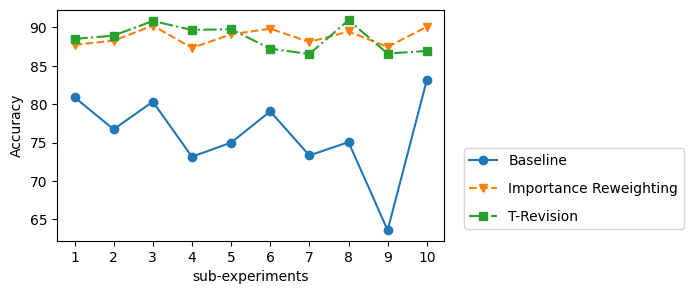

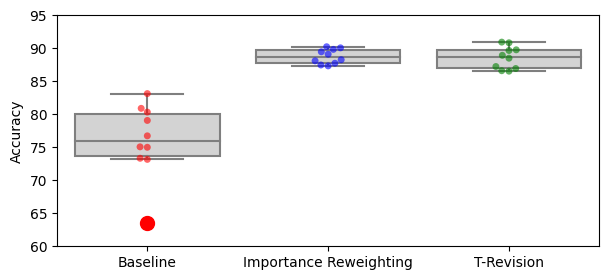

In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:
    experiments_results = []
    for f in ["log/2023-11-04_20-14-41_experiment_results.obj", "log/2023-11-04_20-40-59_experiment_results.obj", "log/2023-11-04_21-41-11_experiment_results.obj"]:
        experiments_results += (joblib.load(WORKSPACE_PATH+f))
    generate_experiment_results_chart(experiments_results)
    generate_experiment_results_boxplot(experiments_results)


In [ ]:
if ENABLE_EXPERIMENTS_ON_FashionMNIST0_6:
    print(generate_experiment_results_table(experiments_results))

               & FashionMNIST0.6 BASELINE TRANSITION MATRIX DISABLED & FashionMNIST0.6 IMPORTANCE REWEIGHTING TRANSITION MATRIX KNOWN & FashionMNIST0.6 T REVISION TRANSITION MATRIX KNOWN  \\
recall 0 mean                  &   (0.8605)   &   {0.8975}   &   0.8935  \\
recall 0 std                   &   {0.0776}   &   (0.0351)   &   0.0538  \\
recall 1 mean                  &   (0.8835)   &   0.9670   &   {0.9804}  \\
recall 1 std                   &   {0.1135}   &   0.0299   &   (0.0100)  \\
recall 2 mean                  &   (0.6749)   &   {0.8159}   &   0.8143  \\
recall 2 std                   &   {0.1054}   &   (0.0318)   &   0.0600  \\
precision 0 mean               &   (0.6350)   &   {0.8575}   &   0.8565  \\
precision 0 std                &   {0.1724}   &   (0.0434)   &   0.0670  \\
precision 1 mean               &   (0.8169)   &   {0.9198}   &   0.9128  \\
precision 1 std                &   {0.1147}   &   0.0222   &   (0.0217)  \\
precision 2 mean               &   (0.8291)   &  

### 6.4 Experiments on CIFAR Dataset

In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:

    model_class = CNN_model_CIFAR
    model_hyperparameters = { "conv1":10, "conv2":20, "fcn1":15 }

Baseline experiment

In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:

    baseline_cfg = {
        "name": "",
        "label_noise_method": "BASELINE",
        "transition_matrix_type": "DISABLED",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_train_criterion": nn.CrossEntropyLoss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.1, "weight_decay": 0.0001, "momentum": 0.90 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss()
    }

    cfg_cv_list = build_cross_validation_experiment_cfg_list([baseline_cfg], dataset="CIFAR", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a27130>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a27820>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a27b20>}


100%|██████████| 94/94 [00:03<00:00, 28.17it/s]


epoch:1/20, ACC(train):32.908333, Loss(train):1.101493, ACC(valid):33.333333, Loss(valid):1.098448


100%|██████████| 94/94 [00:04<00:00, 20.63it/s]


epoch:2/20, ACC(train):33.650000, Loss(train):1.100271, ACC(valid):33.633333, Loss(valid):1.098538


100%|██████████| 94/94 [00:03<00:00, 28.32it/s]


epoch:3/20, ACC(train):34.708333, Loss(train):1.097792, ACC(valid):34.266667, Loss(valid):1.096677


100%|██████████| 94/94 [00:03<00:00, 28.11it/s]


epoch:4/20, ACC(train):35.308333, Loss(train):1.096909, ACC(valid):33.500000, Loss(valid):1.103182


100%|██████████| 94/94 [00:04<00:00, 21.14it/s]


epoch:5/20, ACC(train):35.500000, Loss(train):1.096410, ACC(valid):34.300000, Loss(valid):1.099448


100%|██████████| 94/94 [00:03<00:00, 28.72it/s]


epoch:6/20, ACC(train):36.675000, Loss(train):1.094673, ACC(valid):35.700000, Loss(valid):1.097303


100%|██████████| 94/94 [00:03<00:00, 28.67it/s]


epoch:7/20, ACC(train):36.591667, Loss(train):1.094309, ACC(valid):34.500000, Loss(valid):1.095600


100%|██████████| 94/94 [00:03<00:00, 24.22it/s]


epoch:8/20, ACC(train):37.425000, Loss(train):1.093778, ACC(valid):36.366667, Loss(valid):1.096849


100%|██████████| 94/94 [00:03<00:00, 25.62it/s]


epoch:9/20, ACC(train):37.850000, Loss(train):1.090493, ACC(valid):34.800000, Loss(valid):1.098977


100%|██████████| 94/94 [00:03<00:00, 29.15it/s]


epoch:10/20, ACC(train):37.183333, Loss(train):1.091484, ACC(valid):37.333333, Loss(valid):1.093829


100%|██████████| 94/94 [00:03<00:00, 29.30it/s]


epoch:11/20, ACC(train):37.575000, Loss(train):1.088914, ACC(valid):36.966667, Loss(valid):1.097762


100%|██████████| 94/94 [00:04<00:00, 21.87it/s]


epoch:12/20, ACC(train):38.266667, Loss(train):1.085835, ACC(valid):35.133333, Loss(valid):1.096909


100%|██████████| 94/94 [00:03<00:00, 29.08it/s]


epoch:13/20, ACC(train):38.858333, Loss(train):1.083546, ACC(valid):36.533333, Loss(valid):1.096645


100%|██████████| 94/94 [00:03<00:00, 29.10it/s]


epoch:14/20, ACC(train):39.516667, Loss(train):1.080895, ACC(valid):35.133333, Loss(valid):1.098514


100%|██████████| 94/94 [00:04<00:00, 20.68it/s]


epoch:15/20, ACC(train):39.641667, Loss(train):1.079075, ACC(valid):36.200000, Loss(valid):1.099605


100%|██████████| 94/94 [00:03<00:00, 28.17it/s]


epoch:16/20, ACC(train):40.158333, Loss(train):1.075776, ACC(valid):36.600000, Loss(valid):1.104274


100%|██████████| 94/94 [00:03<00:00, 29.13it/s]


epoch:17/20, ACC(train):39.441667, Loss(train):1.076439, ACC(valid):36.266667, Loss(valid):1.100020


100%|██████████| 94/94 [00:04<00:00, 22.70it/s]


epoch:18/20, ACC(train):41.408333, Loss(train):1.070525, ACC(valid):35.800000, Loss(valid):1.100248


100%|██████████| 94/94 [00:03<00:00, 28.33it/s]


epoch:19/20, ACC(train):41.208333, Loss(train):1.065350, ACC(valid):34.800000, Loss(valid):1.106857


100%|██████████| 94/94 [00:03<00:00, 28.76it/s]


epoch:20/20, ACC(train):42.850000, Loss(train):1.058725, ACC(valid):35.166667, Loss(valid):1.119306
Accuracy:52.266667, Loss:1.007496 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a26170>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a27be0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a24b20>}


100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


epoch:1/20, ACC(train):33.608333, Loss(train):1.100015, ACC(valid):33.333333, Loss(valid):1.098650


100%|██████████| 94/94 [00:03<00:00, 24.73it/s]


epoch:2/20, ACC(train):34.091667, Loss(train):1.100104, ACC(valid):34.166667, Loss(valid):1.097173


100%|██████████| 94/94 [00:03<00:00, 26.27it/s]


epoch:3/20, ACC(train):34.808333, Loss(train):1.097772, ACC(valid):35.366667, Loss(valid):1.097875


100%|██████████| 94/94 [00:04<00:00, 20.89it/s]


epoch:4/20, ACC(train):34.158333, Loss(train):1.098857, ACC(valid):35.500000, Loss(valid):1.097234


100%|██████████| 94/94 [00:03<00:00, 26.18it/s]


epoch:5/20, ACC(train):35.491667, Loss(train):1.096059, ACC(valid):36.433333, Loss(valid):1.095194


100%|██████████| 94/94 [00:03<00:00, 26.80it/s]


epoch:6/20, ACC(train):35.175000, Loss(train):1.097131, ACC(valid):36.166667, Loss(valid):1.094202


100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


epoch:7/20, ACC(train):36.600000, Loss(train):1.093973, ACC(valid):35.533333, Loss(valid):1.096907


100%|██████████| 94/94 [00:03<00:00, 26.37it/s]


epoch:8/20, ACC(train):36.241667, Loss(train):1.092775, ACC(valid):35.300000, Loss(valid):1.099543


100%|██████████| 94/94 [00:03<00:00, 28.17it/s]


epoch:9/20, ACC(train):36.333333, Loss(train):1.093196, ACC(valid):34.600000, Loss(valid):1.098850


100%|██████████| 94/94 [00:03<00:00, 23.60it/s]


epoch:10/20, ACC(train):36.075000, Loss(train):1.093592, ACC(valid):36.700000, Loss(valid):1.093985


100%|██████████| 94/94 [00:03<00:00, 24.97it/s]


epoch:11/20, ACC(train):36.625000, Loss(train):1.091829, ACC(valid):35.266667, Loss(valid):1.099826


100%|██████████| 94/94 [00:03<00:00, 28.10it/s]


epoch:12/20, ACC(train):37.558333, Loss(train):1.088623, ACC(valid):36.400000, Loss(valid):1.096774


100%|██████████| 94/94 [00:03<00:00, 26.81it/s]


epoch:13/20, ACC(train):37.791667, Loss(train):1.089043, ACC(valid):35.633333, Loss(valid):1.100826


100%|██████████| 94/94 [00:04<00:00, 22.56it/s]


epoch:14/20, ACC(train):37.725000, Loss(train):1.089324, ACC(valid):36.333333, Loss(valid):1.097036


100%|██████████| 94/94 [00:03<00:00, 27.90it/s]


epoch:15/20, ACC(train):37.475000, Loss(train):1.086192, ACC(valid):34.666667, Loss(valid):1.105290


100%|██████████| 94/94 [00:03<00:00, 27.15it/s]


epoch:16/20, ACC(train):37.583333, Loss(train):1.083748, ACC(valid):36.200000, Loss(valid):1.105601


100%|██████████| 94/94 [00:04<00:00, 21.17it/s]


epoch:17/20, ACC(train):37.125000, Loss(train):1.084799, ACC(valid):35.133333, Loss(valid):1.102967


100%|██████████| 94/94 [00:03<00:00, 28.94it/s]


epoch:18/20, ACC(train):39.000000, Loss(train):1.080324, ACC(valid):36.566667, Loss(valid):1.105881


100%|██████████| 94/94 [00:03<00:00, 28.54it/s]


epoch:19/20, ACC(train):38.883333, Loss(train):1.080412, ACC(valid):35.600000, Loss(valid):1.103920


100%|██████████| 94/94 [00:04<00:00, 20.58it/s]


epoch:20/20, ACC(train):40.358333, Loss(train):1.073726, ACC(valid):36.766667, Loss(valid):1.103313
Accuracy:59.166667, Loss:1.011323 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a246d0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1a200>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a184c0>}


100%|██████████| 94/94 [00:03<00:00, 27.75it/s]


epoch:1/20, ACC(train):33.500000, Loss(train):1.100674, ACC(valid):33.333333, Loss(valid):1.100680


100%|██████████| 94/94 [00:03<00:00, 27.56it/s]


epoch:2/20, ACC(train):32.891667, Loss(train):1.099948, ACC(valid):33.333333, Loss(valid):1.101469


100%|██████████| 94/94 [00:04<00:00, 19.85it/s]


epoch:3/20, ACC(train):34.191667, Loss(train):1.099507, ACC(valid):33.300000, Loss(valid):1.102295


100%|██████████| 94/94 [00:03<00:00, 27.13it/s]


epoch:4/20, ACC(train):33.966667, Loss(train):1.099687, ACC(valid):33.333333, Loss(valid):1.100789


100%|██████████| 94/94 [00:03<00:00, 28.82it/s]


epoch:5/20, ACC(train):33.683333, Loss(train):1.100082, ACC(valid):35.966667, Loss(valid):1.097310


100%|██████████| 94/94 [00:04<00:00, 20.64it/s]


epoch:6/20, ACC(train):35.408333, Loss(train):1.097010, ACC(valid):36.100000, Loss(valid):1.096240


100%|██████████| 94/94 [00:03<00:00, 28.25it/s]


epoch:7/20, ACC(train):35.683333, Loss(train):1.096129, ACC(valid):36.033333, Loss(valid):1.102808


100%|██████████| 94/94 [00:03<00:00, 29.17it/s]


epoch:8/20, ACC(train):34.933333, Loss(train):1.098090, ACC(valid):34.966667, Loss(valid):1.095971


100%|██████████| 94/94 [00:04<00:00, 22.98it/s]


epoch:9/20, ACC(train):36.383333, Loss(train):1.094518, ACC(valid):35.433333, Loss(valid):1.095325


100%|██████████| 94/94 [00:03<00:00, 26.76it/s]


epoch:10/20, ACC(train):36.916667, Loss(train):1.093317, ACC(valid):35.900000, Loss(valid):1.098190


100%|██████████| 94/94 [00:03<00:00, 29.09it/s]


epoch:11/20, ACC(train):36.741667, Loss(train):1.094533, ACC(valid):36.200000, Loss(valid):1.096990


100%|██████████| 94/94 [00:03<00:00, 27.91it/s]


epoch:12/20, ACC(train):37.658333, Loss(train):1.091182, ACC(valid):34.500000, Loss(valid):1.100919


100%|██████████| 94/94 [00:04<00:00, 22.91it/s]


epoch:13/20, ACC(train):37.325000, Loss(train):1.090494, ACC(valid):35.566667, Loss(valid):1.099136


100%|██████████| 94/94 [00:03<00:00, 29.13it/s]


epoch:14/20, ACC(train):37.983333, Loss(train):1.088400, ACC(valid):34.600000, Loss(valid):1.105003


100%|██████████| 94/94 [00:03<00:00, 29.28it/s]


epoch:15/20, ACC(train):38.391667, Loss(train):1.088178, ACC(valid):35.133333, Loss(valid):1.098831


100%|██████████| 94/94 [00:04<00:00, 20.67it/s]


epoch:16/20, ACC(train):37.858333, Loss(train):1.087975, ACC(valid):35.533333, Loss(valid):1.100124


100%|██████████| 94/94 [00:03<00:00, 28.47it/s]


epoch:17/20, ACC(train):38.883333, Loss(train):1.085361, ACC(valid):35.533333, Loss(valid):1.097224


100%|██████████| 94/94 [00:03<00:00, 27.86it/s]


epoch:18/20, ACC(train):39.508333, Loss(train):1.082161, ACC(valid):35.033333, Loss(valid):1.104023


100%|██████████| 94/94 [00:04<00:00, 21.73it/s]


epoch:19/20, ACC(train):39.766667, Loss(train):1.079274, ACC(valid):35.466667, Loss(valid):1.105800


100%|██████████| 94/94 [00:03<00:00, 29.17it/s]


epoch:20/20, ACC(train):40.433333, Loss(train):1.076598, ACC(valid):35.333333, Loss(valid):1.110013
Accuracy:57.833333, Loss:0.999006 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1a800>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a18070>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1a440>}


100%|██████████| 94/94 [00:03<00:00, 26.93it/s]


epoch:1/20, ACC(train):33.791667, Loss(train):1.099921, ACC(valid):33.700000, Loss(valid):1.098339


100%|██████████| 94/94 [00:04<00:00, 19.75it/s]


epoch:2/20, ACC(train):34.741667, Loss(train):1.099865, ACC(valid):34.400000, Loss(valid):1.099440


100%|██████████| 94/94 [00:03<00:00, 27.72it/s]


epoch:3/20, ACC(train):34.816667, Loss(train):1.098417, ACC(valid):33.433333, Loss(valid):1.099815


100%|██████████| 94/94 [00:03<00:00, 27.13it/s]


epoch:4/20, ACC(train):36.083333, Loss(train):1.096530, ACC(valid):33.866667, Loss(valid):1.099027


100%|██████████| 94/94 [00:04<00:00, 20.90it/s]


epoch:5/20, ACC(train):35.850000, Loss(train):1.095684, ACC(valid):36.266667, Loss(valid):1.095385


100%|██████████| 94/94 [00:03<00:00, 27.34it/s]


epoch:6/20, ACC(train):36.991667, Loss(train):1.093177, ACC(valid):35.766667, Loss(valid):1.093661


100%|██████████| 94/94 [00:03<00:00, 26.03it/s]


epoch:7/20, ACC(train):37.850000, Loss(train):1.090089, ACC(valid):35.300000, Loss(valid):1.098276


100%|██████████| 94/94 [00:04<00:00, 21.22it/s]


epoch:8/20, ACC(train):37.300000, Loss(train):1.092144, ACC(valid):35.900000, Loss(valid):1.096447


100%|██████████| 94/94 [00:03<00:00, 27.15it/s]


epoch:9/20, ACC(train):37.200000, Loss(train):1.090295, ACC(valid):35.833333, Loss(valid):1.095841


100%|██████████| 94/94 [00:03<00:00, 27.17it/s]


epoch:10/20, ACC(train):38.658333, Loss(train):1.087517, ACC(valid):35.100000, Loss(valid):1.099083


100%|██████████| 94/94 [00:03<00:00, 23.81it/s]


epoch:11/20, ACC(train):39.416667, Loss(train):1.085448, ACC(valid):35.966667, Loss(valid):1.098332


100%|██████████| 94/94 [00:03<00:00, 24.96it/s]


epoch:12/20, ACC(train):38.491667, Loss(train):1.085305, ACC(valid):34.966667, Loss(valid):1.103221


100%|██████████| 94/94 [00:03<00:00, 28.43it/s]


epoch:13/20, ACC(train):39.900000, Loss(train):1.080673, ACC(valid):36.200000, Loss(valid):1.095473


100%|██████████| 94/94 [00:03<00:00, 27.73it/s]


epoch:14/20, ACC(train):40.766667, Loss(train):1.077119, ACC(valid):34.433333, Loss(valid):1.105708


100%|██████████| 94/94 [00:04<00:00, 22.10it/s]


epoch:15/20, ACC(train):40.558333, Loss(train):1.076303, ACC(valid):36.266667, Loss(valid):1.101033


100%|██████████| 94/94 [00:03<00:00, 28.47it/s]


epoch:16/20, ACC(train):41.633333, Loss(train):1.070958, ACC(valid):36.333333, Loss(valid):1.106895


100%|██████████| 94/94 [00:03<00:00, 28.51it/s]


epoch:17/20, ACC(train):41.641667, Loss(train):1.067181, ACC(valid):35.266667, Loss(valid):1.103561


100%|██████████| 94/94 [00:04<00:00, 20.32it/s]


epoch:18/20, ACC(train):42.541667, Loss(train):1.059023, ACC(valid):35.066667, Loss(valid):1.111623


100%|██████████| 94/94 [00:03<00:00, 27.55it/s]


epoch:19/20, ACC(train):44.125000, Loss(train):1.049499, ACC(valid):35.333333, Loss(valid):1.146780


100%|██████████| 94/94 [00:03<00:00, 27.66it/s]


epoch:20/20, ACC(train):44.733333, Loss(train):1.043365, ACC(valid):35.600000, Loss(valid):1.137326
Accuracy:45.566667, Loss:1.050199 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1aec0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1ada0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a19ff0>}


100%|██████████| 94/94 [00:04<00:00, 20.14it/s]


epoch:1/20, ACC(train):32.991667, Loss(train):1.099836, ACC(valid):33.333333, Loss(valid):1.102859


100%|██████████| 94/94 [00:03<00:00, 27.55it/s]


epoch:2/20, ACC(train):34.158333, Loss(train):1.098908, ACC(valid):35.633333, Loss(valid):1.095865


100%|██████████| 94/94 [00:03<00:00, 28.35it/s]


epoch:3/20, ACC(train):32.816667, Loss(train):1.100832, ACC(valid):33.333333, Loss(valid):1.099825


100%|██████████| 94/94 [00:04<00:00, 20.52it/s]


epoch:4/20, ACC(train):34.216667, Loss(train):1.099143, ACC(valid):33.633333, Loss(valid):1.095815


100%|██████████| 94/94 [00:03<00:00, 28.29it/s]


epoch:5/20, ACC(train):33.500000, Loss(train):1.100078, ACC(valid):36.900000, Loss(valid):1.099621


100%|██████████| 94/94 [00:03<00:00, 28.35it/s]


epoch:6/20, ACC(train):35.200000, Loss(train):1.098021, ACC(valid):36.666667, Loss(valid):1.097436


100%|██████████| 94/94 [00:04<00:00, 21.48it/s]


epoch:7/20, ACC(train):35.508333, Loss(train):1.096642, ACC(valid):33.400000, Loss(valid):1.096295


100%|██████████| 94/94 [00:03<00:00, 27.12it/s]


epoch:8/20, ACC(train):36.116667, Loss(train):1.096122, ACC(valid):37.600000, Loss(valid):1.092080


100%|██████████| 94/94 [00:03<00:00, 27.82it/s]


epoch:9/20, ACC(train):36.783333, Loss(train):1.094536, ACC(valid):38.200000, Loss(valid):1.089615


100%|██████████| 94/94 [00:04<00:00, 23.26it/s]


epoch:10/20, ACC(train):37.350000, Loss(train):1.091894, ACC(valid):38.333333, Loss(valid):1.092621


100%|██████████| 94/94 [00:03<00:00, 25.21it/s]


epoch:11/20, ACC(train):37.341667, Loss(train):1.093036, ACC(valid):37.266667, Loss(valid):1.094171


100%|██████████| 94/94 [00:03<00:00, 28.43it/s]


epoch:12/20, ACC(train):37.558333, Loss(train):1.091221, ACC(valid):38.066667, Loss(valid):1.093114


100%|██████████| 94/94 [00:03<00:00, 27.00it/s]


epoch:13/20, ACC(train):37.591667, Loss(train):1.090034, ACC(valid):37.100000, Loss(valid):1.095058


100%|██████████| 94/94 [00:04<00:00, 22.20it/s]


epoch:14/20, ACC(train):38.308333, Loss(train):1.088666, ACC(valid):37.066667, Loss(valid):1.093710


100%|██████████| 94/94 [00:03<00:00, 28.27it/s]


epoch:15/20, ACC(train):37.975000, Loss(train):1.087876, ACC(valid):36.200000, Loss(valid):1.096101


100%|██████████| 94/94 [00:03<00:00, 27.51it/s]


epoch:16/20, ACC(train):38.908333, Loss(train):1.084156, ACC(valid):35.433333, Loss(valid):1.095728


100%|██████████| 94/94 [00:04<00:00, 20.22it/s]


epoch:17/20, ACC(train):38.750000, Loss(train):1.085323, ACC(valid):37.366667, Loss(valid):1.093987


100%|██████████| 94/94 [00:03<00:00, 27.98it/s]


epoch:18/20, ACC(train):39.166667, Loss(train):1.082493, ACC(valid):37.466667, Loss(valid):1.095263


100%|██████████| 94/94 [00:03<00:00, 27.74it/s]


epoch:19/20, ACC(train):40.183333, Loss(train):1.078359, ACC(valid):37.566667, Loss(valid):1.098824


100%|██████████| 94/94 [00:04<00:00, 20.58it/s]


epoch:20/20, ACC(train):39.583333, Loss(train):1.078148, ACC(valid):36.400000, Loss(valid):1.113485
Accuracy:48.266667, Loss:1.030024 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a19450>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1aaa0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1a080>}


100%|██████████| 94/94 [00:03<00:00, 27.67it/s]


epoch:1/20, ACC(train):33.916667, Loss(train):1.100191, ACC(valid):33.333333, Loss(valid):1.099578


100%|██████████| 94/94 [00:03<00:00, 27.45it/s]


epoch:2/20, ACC(train):33.191667, Loss(train):1.101010, ACC(valid):33.200000, Loss(valid):1.098429


100%|██████████| 94/94 [00:04<00:00, 19.99it/s]


epoch:3/20, ACC(train):34.650000, Loss(train):1.098983, ACC(valid):32.233333, Loss(valid):1.098183


100%|██████████| 94/94 [00:03<00:00, 27.21it/s]


epoch:4/20, ACC(train):35.200000, Loss(train):1.096755, ACC(valid):33.366667, Loss(valid):1.104511


100%|██████████| 94/94 [00:03<00:00, 26.36it/s]


epoch:5/20, ACC(train):34.341667, Loss(train):1.099639, ACC(valid):36.633333, Loss(valid):1.098412


100%|██████████| 94/94 [00:04<00:00, 19.44it/s]


epoch:6/20, ACC(train):35.266667, Loss(train):1.098175, ACC(valid):33.333333, Loss(valid):1.097955


100%|██████████| 94/94 [00:03<00:00, 26.43it/s]


epoch:7/20, ACC(train):36.258333, Loss(train):1.095808, ACC(valid):34.133333, Loss(valid):1.099317


100%|██████████| 94/94 [00:03<00:00, 26.17it/s]


epoch:8/20, ACC(train):35.700000, Loss(train):1.096658, ACC(valid):35.800000, Loss(valid):1.097089


100%|██████████| 94/94 [00:04<00:00, 20.11it/s]


epoch:9/20, ACC(train):35.175000, Loss(train):1.097229, ACC(valid):34.866667, Loss(valid):1.098224


100%|██████████| 94/94 [00:03<00:00, 25.84it/s]


epoch:10/20, ACC(train):36.800000, Loss(train):1.094243, ACC(valid):34.333333, Loss(valid):1.097965


100%|██████████| 94/94 [00:03<00:00, 26.60it/s]


epoch:11/20, ACC(train):36.325000, Loss(train):1.095528, ACC(valid):35.933333, Loss(valid):1.094887


100%|██████████| 94/94 [00:04<00:00, 19.95it/s]


epoch:12/20, ACC(train):35.866667, Loss(train):1.097072, ACC(valid):36.633333, Loss(valid):1.094189


100%|██████████| 94/94 [00:03<00:00, 27.58it/s]


epoch:13/20, ACC(train):36.666667, Loss(train):1.094544, ACC(valid):36.400000, Loss(valid):1.096150


100%|██████████| 94/94 [00:03<00:00, 28.67it/s]


epoch:14/20, ACC(train):36.900000, Loss(train):1.094420, ACC(valid):36.966667, Loss(valid):1.094005


100%|██████████| 94/94 [00:04<00:00, 23.32it/s]


epoch:15/20, ACC(train):36.625000, Loss(train):1.092937, ACC(valid):37.166667, Loss(valid):1.092467


100%|██████████| 94/94 [00:03<00:00, 25.92it/s]


epoch:16/20, ACC(train):36.875000, Loss(train):1.092136, ACC(valid):36.266667, Loss(valid):1.092777


100%|██████████| 94/94 [00:03<00:00, 27.21it/s]


epoch:17/20, ACC(train):38.033333, Loss(train):1.090410, ACC(valid):36.533333, Loss(valid):1.099169


100%|██████████| 94/94 [00:03<00:00, 25.52it/s]


epoch:18/20, ACC(train):37.050000, Loss(train):1.092659, ACC(valid):36.066667, Loss(valid):1.094896


100%|██████████| 94/94 [00:03<00:00, 23.84it/s]


epoch:19/20, ACC(train):37.683333, Loss(train):1.091657, ACC(valid):35.700000, Loss(valid):1.094060


100%|██████████| 94/94 [00:03<00:00, 27.76it/s]


epoch:20/20, ACC(train):38.416667, Loss(train):1.088210, ACC(valid):36.100000, Loss(valid):1.094651
Accuracy:53.733333, Loss:1.042271 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1a230>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1bdf0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1bfd0>}


100%|██████████| 94/94 [00:04<00:00, 22.90it/s]


epoch:1/20, ACC(train):33.525000, Loss(train):1.101678, ACC(valid):33.333333, Loss(valid):1.098295


100%|██████████| 94/94 [00:03<00:00, 23.51it/s]


epoch:2/20, ACC(train):34.658333, Loss(train):1.098638, ACC(valid):33.466667, Loss(valid):1.102946


100%|██████████| 94/94 [00:03<00:00, 26.73it/s]


epoch:3/20, ACC(train):34.008333, Loss(train):1.100072, ACC(valid):33.333333, Loss(valid):1.100485


100%|██████████| 94/94 [00:04<00:00, 23.12it/s]


epoch:4/20, ACC(train):33.716667, Loss(train):1.099350, ACC(valid):34.933333, Loss(valid):1.097170


100%|██████████| 94/94 [00:03<00:00, 23.82it/s]


epoch:5/20, ACC(train):35.091667, Loss(train):1.098341, ACC(valid):35.700000, Loss(valid):1.095144


100%|██████████| 94/94 [00:03<00:00, 27.20it/s]


epoch:6/20, ACC(train):35.083333, Loss(train):1.098169, ACC(valid):36.100000, Loss(valid):1.096041


100%|██████████| 94/94 [00:03<00:00, 24.24it/s]


epoch:7/20, ACC(train):35.716667, Loss(train):1.096886, ACC(valid):36.066667, Loss(valid):1.095718


100%|██████████| 94/94 [00:04<00:00, 22.33it/s]


epoch:8/20, ACC(train):36.033333, Loss(train):1.097105, ACC(valid):32.833333, Loss(valid):1.096687


100%|██████████| 94/94 [00:03<00:00, 27.32it/s]


epoch:9/20, ACC(train):36.125000, Loss(train):1.095668, ACC(valid):35.800000, Loss(valid):1.095075


100%|██████████| 94/94 [00:03<00:00, 27.23it/s]


epoch:10/20, ACC(train):36.841667, Loss(train):1.094737, ACC(valid):35.533333, Loss(valid):1.099376


100%|██████████| 94/94 [00:04<00:00, 21.82it/s]


epoch:11/20, ACC(train):36.500000, Loss(train):1.094300, ACC(valid):37.166667, Loss(valid):1.098330


100%|██████████| 94/94 [00:03<00:00, 27.92it/s]


epoch:12/20, ACC(train):37.008333, Loss(train):1.092778, ACC(valid):35.166667, Loss(valid):1.096714


100%|██████████| 94/94 [00:03<00:00, 27.48it/s]


epoch:13/20, ACC(train):36.925000, Loss(train):1.093070, ACC(valid):35.900000, Loss(valid):1.096006


100%|██████████| 94/94 [00:04<00:00, 20.31it/s]


epoch:14/20, ACC(train):37.425000, Loss(train):1.090910, ACC(valid):37.000000, Loss(valid):1.095420


100%|██████████| 94/94 [00:03<00:00, 27.07it/s]


epoch:15/20, ACC(train):38.433333, Loss(train):1.088308, ACC(valid):36.200000, Loss(valid):1.095513


100%|██████████| 94/94 [00:03<00:00, 27.58it/s]


epoch:16/20, ACC(train):39.266667, Loss(train):1.085979, ACC(valid):36.500000, Loss(valid):1.096101


100%|██████████| 94/94 [00:04<00:00, 20.55it/s]


epoch:17/20, ACC(train):39.266667, Loss(train):1.084007, ACC(valid):36.100000, Loss(valid):1.094857


100%|██████████| 94/94 [00:03<00:00, 26.35it/s]


epoch:18/20, ACC(train):39.866667, Loss(train):1.080292, ACC(valid):35.766667, Loss(valid):1.101627


100%|██████████| 94/94 [00:03<00:00, 27.16it/s]


epoch:19/20, ACC(train):39.658333, Loss(train):1.080682, ACC(valid):35.800000, Loss(valid):1.095354


100%|██████████| 94/94 [00:04<00:00, 19.82it/s]


epoch:20/20, ACC(train):40.100000, Loss(train):1.078249, ACC(valid):35.600000, Loss(valid):1.101342
Accuracy:53.800000, Loss:1.009543 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a193c0>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a19c30>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1ba60>}


100%|██████████| 94/94 [00:03<00:00, 26.99it/s]


epoch:1/20, ACC(train):33.100000, Loss(train):1.101089, ACC(valid):33.333333, Loss(valid):1.099531


100%|██████████| 94/94 [00:03<00:00, 25.74it/s]


epoch:2/20, ACC(train):33.550000, Loss(train):1.099151, ACC(valid):33.600000, Loss(valid):1.098894


100%|██████████| 94/94 [00:04<00:00, 19.82it/s]


epoch:3/20, ACC(train):34.291667, Loss(train):1.099055, ACC(valid):34.633333, Loss(valid):1.098313


100%|██████████| 94/94 [00:03<00:00, 26.65it/s]


epoch:4/20, ACC(train):34.800000, Loss(train):1.097862, ACC(valid):33.800000, Loss(valid):1.101802


100%|██████████| 94/94 [00:03<00:00, 27.41it/s]


epoch:5/20, ACC(train):35.375000, Loss(train):1.095949, ACC(valid):36.000000, Loss(valid):1.095651


100%|██████████| 94/94 [00:04<00:00, 20.09it/s]


epoch:6/20, ACC(train):36.433333, Loss(train):1.094286, ACC(valid):34.833333, Loss(valid):1.097809


100%|██████████| 94/94 [00:03<00:00, 27.58it/s]


epoch:7/20, ACC(train):36.583333, Loss(train):1.094845, ACC(valid):34.500000, Loss(valid):1.097403


100%|██████████| 94/94 [00:03<00:00, 28.22it/s]


epoch:8/20, ACC(train):37.208333, Loss(train):1.093369, ACC(valid):38.166667, Loss(valid):1.092923


100%|██████████| 94/94 [00:04<00:00, 21.40it/s]


epoch:9/20, ACC(train):37.966667, Loss(train):1.090459, ACC(valid):35.433333, Loss(valid):1.097518


100%|██████████| 94/94 [00:03<00:00, 28.33it/s]


epoch:10/20, ACC(train):37.683333, Loss(train):1.090160, ACC(valid):37.133333, Loss(valid):1.095584


100%|██████████| 94/94 [00:03<00:00, 28.18it/s]


epoch:11/20, ACC(train):37.733333, Loss(train):1.088871, ACC(valid):38.433333, Loss(valid):1.093354


100%|██████████| 94/94 [00:04<00:00, 23.18it/s]


epoch:12/20, ACC(train):38.116667, Loss(train):1.088860, ACC(valid):37.466667, Loss(valid):1.096856


100%|██████████| 94/94 [00:03<00:00, 25.25it/s]


epoch:13/20, ACC(train):38.991667, Loss(train):1.085417, ACC(valid):36.233333, Loss(valid):1.094577


100%|██████████| 94/94 [00:03<00:00, 27.95it/s]


epoch:14/20, ACC(train):39.216667, Loss(train):1.084448, ACC(valid):36.833333, Loss(valid):1.100455


100%|██████████| 94/94 [00:03<00:00, 27.75it/s]


epoch:15/20, ACC(train):39.633333, Loss(train):1.082819, ACC(valid):35.366667, Loss(valid):1.100771


100%|██████████| 94/94 [00:04<00:00, 22.03it/s]


epoch:16/20, ACC(train):38.891667, Loss(train):1.082252, ACC(valid):36.566667, Loss(valid):1.100648


100%|██████████| 94/94 [00:03<00:00, 28.29it/s]


epoch:17/20, ACC(train):39.641667, Loss(train):1.079231, ACC(valid):35.966667, Loss(valid):1.108773


100%|██████████| 94/94 [00:03<00:00, 28.06it/s]


epoch:18/20, ACC(train):40.158333, Loss(train):1.077146, ACC(valid):36.733333, Loss(valid):1.116683


100%|██████████| 94/94 [00:04<00:00, 20.38it/s]


epoch:19/20, ACC(train):39.858333, Loss(train):1.075703, ACC(valid):35.200000, Loss(valid):1.107424


100%|██████████| 94/94 [00:03<00:00, 28.05it/s]


epoch:20/20, ACC(train):40.750000, Loss(train):1.070171, ACC(valid):35.900000, Loss(valid):1.103434
Accuracy:51.166667, Loss:1.027305 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a19b70>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a18910>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a18c70>}


100%|██████████| 94/94 [00:03<00:00, 26.36it/s]


epoch:1/20, ACC(train):33.500000, Loss(train):1.100084, ACC(valid):33.333333, Loss(valid):1.102160


100%|██████████| 94/94 [00:04<00:00, 20.63it/s]


epoch:2/20, ACC(train):33.291667, Loss(train):1.101275, ACC(valid):33.333333, Loss(valid):1.098851


100%|██████████| 94/94 [00:03<00:00, 27.72it/s]


epoch:3/20, ACC(train):33.441667, Loss(train):1.100126, ACC(valid):33.333333, Loss(valid):1.098847


100%|██████████| 94/94 [00:03<00:00, 26.12it/s]


epoch:4/20, ACC(train):33.925000, Loss(train):1.099603, ACC(valid):33.333333, Loss(valid):1.099630


100%|██████████| 94/94 [00:04<00:00, 20.23it/s]


epoch:5/20, ACC(train):34.658333, Loss(train):1.098917, ACC(valid):33.333333, Loss(valid):1.105528


100%|██████████| 94/94 [00:03<00:00, 28.17it/s]


epoch:6/20, ACC(train):33.600000, Loss(train):1.099414, ACC(valid):34.800000, Loss(valid):1.098698


100%|██████████| 94/94 [00:03<00:00, 27.14it/s]


epoch:7/20, ACC(train):34.691667, Loss(train):1.097674, ACC(valid):36.300000, Loss(valid):1.096392


100%|██████████| 94/94 [00:04<00:00, 20.26it/s]


epoch:8/20, ACC(train):35.333333, Loss(train):1.097352, ACC(valid):35.266667, Loss(valid):1.096491


100%|██████████| 94/94 [00:03<00:00, 27.68it/s]


epoch:9/20, ACC(train):36.008333, Loss(train):1.096665, ACC(valid):33.833333, Loss(valid):1.098214


100%|██████████| 94/94 [00:03<00:00, 27.19it/s]


epoch:10/20, ACC(train):36.350000, Loss(train):1.094825, ACC(valid):36.633333, Loss(valid):1.103184


100%|██████████| 94/94 [00:04<00:00, 21.27it/s]


epoch:11/20, ACC(train):36.850000, Loss(train):1.094751, ACC(valid):33.866667, Loss(valid):1.101005


100%|██████████| 94/94 [00:03<00:00, 27.86it/s]


epoch:12/20, ACC(train):36.991667, Loss(train):1.092944, ACC(valid):34.233333, Loss(valid):1.099753


100%|██████████| 94/94 [00:03<00:00, 27.21it/s]


epoch:13/20, ACC(train):37.291667, Loss(train):1.091616, ACC(valid):36.700000, Loss(valid):1.094883


100%|██████████| 94/94 [00:04<00:00, 21.51it/s]


epoch:14/20, ACC(train):37.408333, Loss(train):1.090435, ACC(valid):36.400000, Loss(valid):1.096291


100%|██████████| 94/94 [00:03<00:00, 26.33it/s]


epoch:15/20, ACC(train):38.450000, Loss(train):1.087438, ACC(valid):34.966667, Loss(valid):1.098076


100%|██████████| 94/94 [00:03<00:00, 27.12it/s]


epoch:16/20, ACC(train):37.708333, Loss(train):1.090663, ACC(valid):35.433333, Loss(valid):1.102565


100%|██████████| 94/94 [00:03<00:00, 24.14it/s]


epoch:17/20, ACC(train):39.008333, Loss(train):1.084799, ACC(valid):35.900000, Loss(valid):1.105490


100%|██████████| 94/94 [00:04<00:00, 23.43it/s]


epoch:18/20, ACC(train):38.125000, Loss(train):1.084775, ACC(valid):34.466667, Loss(valid):1.099560


100%|██████████| 94/94 [00:03<00:00, 27.12it/s]


epoch:19/20, ACC(train):39.341667, Loss(train):1.082487, ACC(valid):35.466667, Loss(valid):1.112594


100%|██████████| 94/94 [00:03<00:00, 26.21it/s]


epoch:20/20, ACC(train):40.341667, Loss(train):1.076549, ACC(valid):34.433333, Loss(valid):1.103199
Accuracy:50.966667, Loss:1.048810 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'CIFAR_BASELINE_TRANSITION_MATRIX_DISABLED', 'label_noise_method': 'BASELINE', 'transition_matrix_type': 'DISABLED', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_train_criterion': CrossEntropyLoss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a18970>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a18820>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8a1bf40>}


100%|██████████| 94/94 [00:03<00:00, 25.37it/s]


epoch:1/20, ACC(train):33.566667, Loss(train):1.100575, ACC(valid):33.333333, Loss(valid):1.102714


100%|██████████| 94/94 [00:03<00:00, 27.17it/s]


epoch:2/20, ACC(train):33.550000, Loss(train):1.099720, ACC(valid):35.233333, Loss(valid):1.097571


100%|██████████| 94/94 [00:03<00:00, 24.93it/s]


epoch:3/20, ACC(train):34.741667, Loss(train):1.096917, ACC(valid):37.000000, Loss(valid):1.096599


100%|██████████| 94/94 [00:03<00:00, 23.84it/s]


epoch:4/20, ACC(train):35.416667, Loss(train):1.097408, ACC(valid):35.200000, Loss(valid):1.097617


100%|██████████| 94/94 [00:03<00:00, 27.34it/s]


epoch:5/20, ACC(train):35.100000, Loss(train):1.097621, ACC(valid):34.233333, Loss(valid):1.099299


100%|██████████| 94/94 [00:03<00:00, 27.38it/s]


epoch:6/20, ACC(train):35.408333, Loss(train):1.097147, ACC(valid):35.633333, Loss(valid):1.097150


100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


epoch:7/20, ACC(train):36.291667, Loss(train):1.093952, ACC(valid):34.033333, Loss(valid):1.103440


100%|██████████| 94/94 [00:03<00:00, 27.61it/s]


epoch:8/20, ACC(train):36.608333, Loss(train):1.094144, ACC(valid):35.933333, Loss(valid):1.098720


100%|██████████| 94/94 [00:03<00:00, 27.57it/s]


epoch:9/20, ACC(train):36.541667, Loss(train):1.094034, ACC(valid):35.866667, Loss(valid):1.096528


100%|██████████| 94/94 [00:04<00:00, 20.01it/s]


epoch:10/20, ACC(train):36.391667, Loss(train):1.091839, ACC(valid):36.100000, Loss(valid):1.097483


100%|██████████| 94/94 [00:03<00:00, 28.07it/s]


epoch:11/20, ACC(train):37.525000, Loss(train):1.090826, ACC(valid):36.300000, Loss(valid):1.095538


100%|██████████| 94/94 [00:03<00:00, 26.15it/s]


epoch:12/20, ACC(train):37.533333, Loss(train):1.090003, ACC(valid):36.333333, Loss(valid):1.098983


100%|██████████| 94/94 [00:04<00:00, 20.17it/s]


epoch:13/20, ACC(train):37.550000, Loss(train):1.090082, ACC(valid):35.233333, Loss(valid):1.098264


100%|██████████| 94/94 [00:03<00:00, 27.73it/s]


epoch:14/20, ACC(train):38.083333, Loss(train):1.088181, ACC(valid):37.500000, Loss(valid):1.094656


100%|██████████| 94/94 [00:03<00:00, 27.65it/s]


epoch:15/20, ACC(train):38.683333, Loss(train):1.087134, ACC(valid):36.166667, Loss(valid):1.093995


100%|██████████| 94/94 [00:04<00:00, 20.04it/s]


epoch:16/20, ACC(train):39.266667, Loss(train):1.085789, ACC(valid):36.100000, Loss(valid):1.101049


100%|██████████| 94/94 [00:03<00:00, 26.52it/s]


epoch:17/20, ACC(train):39.433333, Loss(train):1.082051, ACC(valid):37.166667, Loss(valid):1.097482


100%|██████████| 94/94 [00:03<00:00, 27.65it/s]


epoch:18/20, ACC(train):39.850000, Loss(train):1.078353, ACC(valid):37.600000, Loss(valid):1.094379


100%|██████████| 94/94 [00:04<00:00, 20.46it/s]


epoch:19/20, ACC(train):40.216667, Loss(train):1.077327, ACC(valid):34.333333, Loss(valid):1.105616


100%|██████████| 94/94 [00:03<00:00, 28.03it/s]


epoch:20/20, ACC(train):40.325000, Loss(train):1.075242, ACC(valid):35.933333, Loss(valid):1.106186
Accuracy:46.533333, Loss:1.031515 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_15-22-01_experiment_results.obj


Train CNN model by using Importance Reweighting method (unknown flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:

    importance_reweighting_estimate_cfg = {
        "name": "",
        "label_noise_method": "IMPORTANCE_REWEIGHTING",
        "transition_matrix_type": "ESTIMATE",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_estimate_criterion": nn.CrossEntropyLoss(),
        "model_estimate_optimizer": torch.optim.SGD,
        "model_estimate_optimizer_parameters": { "lr": 0.1, "weight_decay": 0.0001, "momentum": 0.90 },
        "model_estimate_epochs": 20,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.90 },
        "model_train_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }
    cfg_cv_list = build_cross_validation_experiment_cfg_list([importance_reweighting_estimate_cfg], dataset="CIFAR", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a35c8ab6560>, 'valid_loader': <torch.utils.data.dataloader.DataLoader object

100%|██████████| 94/94 [00:03<00:00, 26.75it/s]


epoch:1/20, ACC(train):32.875000, Loss(train):1.100510, ACC(valid):33.333333, Loss(valid):1.100768


100%|██████████| 94/94 [00:03<00:00, 25.99it/s]


epoch:2/20, ACC(train):33.333333, Loss(train):1.099822, ACC(valid):36.200000, Loss(valid):1.098396


100%|██████████| 94/94 [00:04<00:00, 19.86it/s]


epoch:3/20, ACC(train):34.691667, Loss(train):1.098609, ACC(valid):33.333333, Loss(valid):1.100784


100%|██████████| 94/94 [00:03<00:00, 25.75it/s]


epoch:4/20, ACC(train):33.958333, Loss(train):1.099303, ACC(valid):36.533333, Loss(valid):1.097568


100%|██████████| 94/94 [00:03<00:00, 26.13it/s]


epoch:5/20, ACC(train):35.341667, Loss(train):1.097549, ACC(valid):34.700000, Loss(valid):1.097773


100%|██████████| 94/94 [00:04<00:00, 20.02it/s]


epoch:6/20, ACC(train):35.316667, Loss(train):1.097295, ACC(valid):36.300000, Loss(valid):1.095914


100%|██████████| 94/94 [00:03<00:00, 27.09it/s]


epoch:7/20, ACC(train):36.100000, Loss(train):1.096285, ACC(valid):36.933333, Loss(valid):1.093957


100%|██████████| 94/94 [00:03<00:00, 26.61it/s]


epoch:8/20, ACC(train):36.041667, Loss(train):1.095056, ACC(valid):35.400000, Loss(valid):1.096243


100%|██████████| 94/94 [00:04<00:00, 19.85it/s]


epoch:9/20, ACC(train):36.791667, Loss(train):1.093741, ACC(valid):37.200000, Loss(valid):1.094289


100%|██████████| 94/94 [00:03<00:00, 27.25it/s]


epoch:10/20, ACC(train):36.933333, Loss(train):1.092568, ACC(valid):37.266667, Loss(valid):1.092563


100%|██████████| 94/94 [00:03<00:00, 27.38it/s]


epoch:11/20, ACC(train):37.100000, Loss(train):1.091724, ACC(valid):36.433333, Loss(valid):1.094811


100%|██████████| 94/94 [00:04<00:00, 20.36it/s]


epoch:12/20, ACC(train):37.675000, Loss(train):1.088442, ACC(valid):36.166667, Loss(valid):1.095979


100%|██████████| 94/94 [00:03<00:00, 27.24it/s]


epoch:13/20, ACC(train):37.966667, Loss(train):1.088785, ACC(valid):36.433333, Loss(valid):1.096112


100%|██████████| 94/94 [00:03<00:00, 25.71it/s]


epoch:14/20, ACC(train):38.541667, Loss(train):1.087110, ACC(valid):35.833333, Loss(valid):1.095901


100%|██████████| 94/94 [00:04<00:00, 19.75it/s]


epoch:15/20, ACC(train):38.575000, Loss(train):1.083937, ACC(valid):35.466667, Loss(valid):1.096756


100%|██████████| 94/94 [00:03<00:00, 28.53it/s]


epoch:16/20, ACC(train):38.775000, Loss(train):1.083296, ACC(valid):36.033333, Loss(valid):1.102654


100%|██████████| 94/94 [00:03<00:00, 28.28it/s]


epoch:17/20, ACC(train):39.475000, Loss(train):1.078799, ACC(valid):35.100000, Loss(valid):1.098845


100%|██████████| 94/94 [00:04<00:00, 21.66it/s]


epoch:18/20, ACC(train):40.275000, Loss(train):1.075117, ACC(valid):35.400000, Loss(valid):1.115599


100%|██████████| 94/94 [00:03<00:00, 27.71it/s]


epoch:19/20, ACC(train):39.641667, Loss(train):1.076231, ACC(valid):34.733333, Loss(valid):1.104892


100%|██████████| 94/94 [00:03<00:00, 27.39it/s]


epoch:20/20, ACC(train):41.425000, Loss(train):1.069386, ACC(valid):36.333333, Loss(valid):1.108478
best_model_id: 9
transition_matrix_estimated: 
tensor([[0.3720, 0.3077, 0.3203],
        [0.3220, 0.3748, 0.3032],
        [0.3500, 0.2784, 0.3716]])


100%|██████████| 94/94 [00:06<00:00, 13.81it/s]


epoch:1/20, ACC(train):36.658333, Loss(train):1.038465, ACC(valid):36.500000, Loss(valid):0.963503


100%|██████████| 94/94 [00:05<00:00, 16.55it/s]


epoch:2/20, ACC(train):37.283333, Loss(train):0.798121, ACC(valid):36.933333, Loss(valid):0.789536


100%|██████████| 94/94 [00:06<00:00, 13.71it/s]


epoch:3/20, ACC(train):37.525000, Loss(train):0.713884, ACC(valid):37.766667, Loss(valid):0.641783


100%|██████████| 94/94 [00:06<00:00, 15.05it/s]


epoch:4/20, ACC(train):37.650000, Loss(train):0.619534, ACC(valid):37.366667, Loss(valid):0.612725


100%|██████████| 94/94 [00:06<00:00, 15.08it/s]


epoch:5/20, ACC(train):37.700000, Loss(train):0.587680, ACC(valid):38.133333, Loss(valid):0.585670


100%|██████████| 94/94 [00:06<00:00, 13.93it/s]


epoch:6/20, ACC(train):38.325000, Loss(train):0.533453, ACC(valid):37.100000, Loss(valid):0.629187


100%|██████████| 94/94 [00:05<00:00, 15.92it/s]


epoch:7/20, ACC(train):38.366667, Loss(train):0.555883, ACC(valid):36.600000, Loss(valid):0.559357


100%|██████████| 94/94 [00:06<00:00, 13.56it/s]


epoch:8/20, ACC(train):38.825000, Loss(train):0.498159, ACC(valid):37.266667, Loss(valid):0.511127


100%|██████████| 94/94 [00:05<00:00, 16.07it/s]


epoch:9/20, ACC(train):38.966667, Loss(train):0.453727, ACC(valid):36.833333, Loss(valid):0.475194


100%|██████████| 94/94 [00:06<00:00, 13.74it/s]


epoch:10/20, ACC(train):39.108333, Loss(train):0.454256, ACC(valid):36.833333, Loss(valid):0.453046


100%|██████████| 94/94 [00:05<00:00, 16.45it/s]


epoch:11/20, ACC(train):38.600000, Loss(train):0.455022, ACC(valid):37.800000, Loss(valid):0.440467


100%|██████████| 94/94 [00:06<00:00, 13.67it/s]


epoch:12/20, ACC(train):39.216667, Loss(train):0.461826, ACC(valid):37.233333, Loss(valid):0.515674


100%|██████████| 94/94 [00:05<00:00, 16.38it/s]


epoch:13/20, ACC(train):39.233333, Loss(train):0.445946, ACC(valid):37.100000, Loss(valid):0.438452


100%|██████████| 94/94 [00:06<00:00, 14.28it/s]


epoch:14/20, ACC(train):39.875000, Loss(train):0.436013, ACC(valid):37.366667, Loss(valid):0.437881


100%|██████████| 94/94 [00:06<00:00, 14.96it/s]


epoch:15/20, ACC(train):39.675000, Loss(train):0.398716, ACC(valid):37.600000, Loss(valid):0.441215


100%|██████████| 94/94 [00:05<00:00, 16.10it/s]


epoch:16/20, ACC(train):40.591667, Loss(train):0.376974, ACC(valid):36.500000, Loss(valid):0.383053


100%|██████████| 94/94 [00:06<00:00, 13.94it/s]


epoch:17/20, ACC(train):39.991667, Loss(train):0.374425, ACC(valid):36.900000, Loss(valid):0.374593


100%|██████████| 94/94 [00:05<00:00, 16.74it/s]


epoch:18/20, ACC(train):40.391667, Loss(train):0.312614, ACC(valid):36.733333, Loss(valid):0.373545


100%|██████████| 94/94 [00:07<00:00, 13.27it/s]


epoch:19/20, ACC(train):40.858333, Loss(train):0.328507, ACC(valid):37.066667, Loss(valid):0.347169


100%|██████████| 94/94 [00:05<00:00, 16.76it/s]


epoch:20/20, ACC(train):41.183333, Loss(train):0.357039, ACC(valid):36.233333, Loss(valid):0.360581
Accuracy:62.833333, Loss:1.442400 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:04<00:00, 19.78it/s]


epoch:1/20, ACC(train):33.575000, Loss(train):1.099614, ACC(valid):33.433333, Loss(valid):1.097886


100%|██████████| 94/94 [00:03<00:00, 26.72it/s]


epoch:2/20, ACC(train):34.266667, Loss(train):1.098914, ACC(valid):34.833333, Loss(valid):1.099504


100%|██████████| 94/94 [00:03<00:00, 26.90it/s]


epoch:3/20, ACC(train):35.058333, Loss(train):1.097884, ACC(valid):34.700000, Loss(valid):1.101699


100%|██████████| 94/94 [00:04<00:00, 20.22it/s]


epoch:4/20, ACC(train):35.675000, Loss(train):1.096214, ACC(valid):36.433333, Loss(valid):1.095808


100%|██████████| 94/94 [00:03<00:00, 27.75it/s]


epoch:5/20, ACC(train):36.116667, Loss(train):1.095451, ACC(valid):36.166667, Loss(valid):1.094281


100%|██████████| 94/94 [00:03<00:00, 27.48it/s]


epoch:6/20, ACC(train):37.125000, Loss(train):1.093616, ACC(valid):36.000000, Loss(valid):1.096204


100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


epoch:7/20, ACC(train):35.883333, Loss(train):1.095190, ACC(valid):35.066667, Loss(valid):1.095336


100%|██████████| 94/94 [00:03<00:00, 26.84it/s]


epoch:8/20, ACC(train):37.516667, Loss(train):1.092528, ACC(valid):36.000000, Loss(valid):1.096133


100%|██████████| 94/94 [00:03<00:00, 26.66it/s]


epoch:9/20, ACC(train):37.816667, Loss(train):1.091282, ACC(valid):35.700000, Loss(valid):1.097858


100%|██████████| 94/94 [00:04<00:00, 22.32it/s]


epoch:10/20, ACC(train):37.408333, Loss(train):1.089595, ACC(valid):36.333333, Loss(valid):1.097046


100%|██████████| 94/94 [00:03<00:00, 26.80it/s]


epoch:11/20, ACC(train):37.883333, Loss(train):1.088216, ACC(valid):35.033333, Loss(valid):1.098275


100%|██████████| 94/94 [00:03<00:00, 28.92it/s]


epoch:12/20, ACC(train):38.325000, Loss(train):1.085910, ACC(valid):34.100000, Loss(valid):1.099611


100%|██████████| 94/94 [00:03<00:00, 26.00it/s]


epoch:13/20, ACC(train):38.625000, Loss(train):1.086771, ACC(valid):35.600000, Loss(valid):1.096827


100%|██████████| 94/94 [00:04<00:00, 23.30it/s]


epoch:14/20, ACC(train):39.391667, Loss(train):1.083477, ACC(valid):35.533333, Loss(valid):1.104375


100%|██████████| 94/94 [00:03<00:00, 28.08it/s]


epoch:15/20, ACC(train):39.533333, Loss(train):1.081747, ACC(valid):35.466667, Loss(valid):1.098588


100%|██████████| 94/94 [00:03<00:00, 28.87it/s]


epoch:16/20, ACC(train):39.550000, Loss(train):1.079102, ACC(valid):36.500000, Loss(valid):1.102733


100%|██████████| 94/94 [00:04<00:00, 21.16it/s]


epoch:17/20, ACC(train):40.041667, Loss(train):1.076776, ACC(valid):36.100000, Loss(valid):1.109696


100%|██████████| 94/94 [00:03<00:00, 27.55it/s]


epoch:18/20, ACC(train):40.916667, Loss(train):1.072356, ACC(valid):35.166667, Loss(valid):1.105601


100%|██████████| 94/94 [00:03<00:00, 27.12it/s]


epoch:19/20, ACC(train):41.800000, Loss(train):1.067983, ACC(valid):35.366667, Loss(valid):1.110216


100%|██████████| 94/94 [00:04<00:00, 20.83it/s]


epoch:20/20, ACC(train):42.641667, Loss(train):1.060128, ACC(valid):35.133333, Loss(valid):1.123659
best_model_id: 15
transition_matrix_estimated: 
tensor([[0.4010, 0.2944, 0.3046],
        [0.3298, 0.3795, 0.2907],
        [0.3341, 0.2860, 0.3799]])


100%|██████████| 94/94 [00:05<00:00, 16.49it/s]


epoch:1/20, ACC(train):40.108333, Loss(train):0.990946, ACC(valid):35.566667, Loss(valid):0.821040


100%|██████████| 94/94 [00:06<00:00, 13.90it/s]


epoch:2/20, ACC(train):40.008333, Loss(train):0.756643, ACC(valid):36.500000, Loss(valid):0.704790


100%|██████████| 94/94 [00:05<00:00, 16.63it/s]


epoch:3/20, ACC(train):40.883333, Loss(train):0.676634, ACC(valid):36.633333, Loss(valid):0.683302


100%|██████████| 94/94 [00:06<00:00, 14.03it/s]


epoch:4/20, ACC(train):41.341667, Loss(train):0.664110, ACC(valid):37.100000, Loss(valid):0.646691


100%|██████████| 94/94 [00:05<00:00, 16.34it/s]


epoch:5/20, ACC(train):42.333333, Loss(train):0.607146, ACC(valid):36.966667, Loss(valid):0.571876


100%|██████████| 94/94 [00:06<00:00, 15.38it/s]


epoch:6/20, ACC(train):42.616667, Loss(train):0.565995, ACC(valid):36.566667, Loss(valid):0.585114


100%|██████████| 94/94 [00:06<00:00, 15.48it/s]


epoch:7/20, ACC(train):42.825000, Loss(train):0.531945, ACC(valid):36.366667, Loss(valid):0.564013


100%|██████████| 94/94 [00:05<00:00, 16.80it/s]


epoch:8/20, ACC(train):43.575000, Loss(train):0.525100, ACC(valid):36.100000, Loss(valid):0.507531


100%|██████████| 94/94 [00:06<00:00, 14.02it/s]


epoch:9/20, ACC(train):44.391667, Loss(train):0.490424, ACC(valid):36.300000, Loss(valid):0.492671


100%|██████████| 94/94 [00:05<00:00, 16.62it/s]


epoch:10/20, ACC(train):44.858333, Loss(train):0.462031, ACC(valid):36.766667, Loss(valid):0.422985


100%|██████████| 94/94 [00:06<00:00, 13.86it/s]


epoch:11/20, ACC(train):45.433333, Loss(train):0.411648, ACC(valid):35.800000, Loss(valid):0.430179


100%|██████████| 94/94 [00:05<00:00, 17.01it/s]


epoch:12/20, ACC(train):45.550000, Loss(train):0.396544, ACC(valid):36.100000, Loss(valid):0.440558


100%|██████████| 94/94 [00:06<00:00, 14.03it/s]


epoch:13/20, ACC(train):46.608333, Loss(train):0.384294, ACC(valid):35.766667, Loss(valid):0.380880


100%|██████████| 94/94 [00:05<00:00, 17.20it/s]


epoch:14/20, ACC(train):47.291667, Loss(train):0.351827, ACC(valid):35.800000, Loss(valid):0.332664


100%|██████████| 94/94 [00:06<00:00, 14.09it/s]


epoch:15/20, ACC(train):46.716667, Loss(train):0.331246, ACC(valid):36.100000, Loss(valid):0.365285


100%|██████████| 94/94 [00:05<00:00, 16.29it/s]


epoch:16/20, ACC(train):47.241667, Loss(train):0.327016, ACC(valid):35.266667, Loss(valid):0.324586


100%|██████████| 94/94 [00:06<00:00, 14.10it/s]


epoch:17/20, ACC(train):48.066667, Loss(train):0.306590, ACC(valid):35.300000, Loss(valid):0.290564


100%|██████████| 94/94 [00:05<00:00, 16.78it/s]


epoch:18/20, ACC(train):48.558333, Loss(train):0.283762, ACC(valid):35.166667, Loss(valid):0.287139


100%|██████████| 94/94 [00:06<00:00, 14.15it/s]


epoch:19/20, ACC(train):48.641667, Loss(train):0.272894, ACC(valid):35.733333, Loss(valid):0.269310


100%|██████████| 94/94 [00:05<00:00, 17.07it/s]


epoch:20/20, ACC(train):49.066667, Loss(train):0.257819, ACC(valid):36.400000, Loss(valid):0.294820
Accuracy:53.533333, Loss:2.398275 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:03<00:00, 24.54it/s]


epoch:1/20, ACC(train):32.891667, Loss(train):1.100138, ACC(valid):33.333333, Loss(valid):1.099671


100%|██████████| 94/94 [00:03<00:00, 26.30it/s]


epoch:2/20, ACC(train):35.308333, Loss(train):1.096977, ACC(valid):36.600000, Loss(valid):1.095080


100%|██████████| 94/94 [00:04<00:00, 22.31it/s]


epoch:3/20, ACC(train):34.350000, Loss(train):1.099829, ACC(valid):34.533333, Loss(valid):1.100410


100%|██████████| 94/94 [00:03<00:00, 26.31it/s]


epoch:4/20, ACC(train):34.533333, Loss(train):1.098048, ACC(valid):36.166667, Loss(valid):1.095064


100%|██████████| 94/94 [00:03<00:00, 26.77it/s]


epoch:5/20, ACC(train):36.433333, Loss(train):1.095797, ACC(valid):35.333333, Loss(valid):1.096771


100%|██████████| 94/94 [00:03<00:00, 23.83it/s]


epoch:6/20, ACC(train):37.191667, Loss(train):1.093356, ACC(valid):35.533333, Loss(valid):1.102159


100%|██████████| 94/94 [00:03<00:00, 24.60it/s]


epoch:7/20, ACC(train):36.908333, Loss(train):1.093094, ACC(valid):33.833333, Loss(valid):1.098400


100%|██████████| 94/94 [00:03<00:00, 27.94it/s]


epoch:8/20, ACC(train):37.250000, Loss(train):1.092631, ACC(valid):34.866667, Loss(valid):1.099133


100%|██████████| 94/94 [00:03<00:00, 25.38it/s]


epoch:9/20, ACC(train):37.500000, Loss(train):1.091735, ACC(valid):36.666667, Loss(valid):1.098630


100%|██████████| 94/94 [00:04<00:00, 22.43it/s]


epoch:10/20, ACC(train):37.950000, Loss(train):1.091342, ACC(valid):36.500000, Loss(valid):1.097146


100%|██████████| 94/94 [00:03<00:00, 25.97it/s]


epoch:11/20, ACC(train):38.225000, Loss(train):1.088307, ACC(valid):35.900000, Loss(valid):1.097167


100%|██████████| 94/94 [00:03<00:00, 27.84it/s]


epoch:12/20, ACC(train):38.550000, Loss(train):1.088102, ACC(valid):35.733333, Loss(valid):1.097982


100%|██████████| 94/94 [00:04<00:00, 22.21it/s]


epoch:13/20, ACC(train):38.525000, Loss(train):1.086477, ACC(valid):37.300000, Loss(valid):1.100846


100%|██████████| 94/94 [00:03<00:00, 28.21it/s]


epoch:14/20, ACC(train):38.616667, Loss(train):1.083874, ACC(valid):35.500000, Loss(valid):1.102907


100%|██████████| 94/94 [00:03<00:00, 27.63it/s]


epoch:15/20, ACC(train):39.458333, Loss(train):1.081100, ACC(valid):33.000000, Loss(valid):1.107998


100%|██████████| 94/94 [00:04<00:00, 20.74it/s]


epoch:16/20, ACC(train):38.883333, Loss(train):1.081269, ACC(valid):37.066667, Loss(valid):1.101554


100%|██████████| 94/94 [00:03<00:00, 27.78it/s]


epoch:17/20, ACC(train):40.091667, Loss(train):1.076563, ACC(valid):34.200000, Loss(valid):1.114529


100%|██████████| 94/94 [00:03<00:00, 28.82it/s]


epoch:18/20, ACC(train):40.108333, Loss(train):1.075418, ACC(valid):34.366667, Loss(valid):1.099693


100%|██████████| 94/94 [00:04<00:00, 21.00it/s]


epoch:19/20, ACC(train):40.558333, Loss(train):1.073192, ACC(valid):34.666667, Loss(valid):1.106948


100%|██████████| 94/94 [00:03<00:00, 27.70it/s]


epoch:20/20, ACC(train):41.466667, Loss(train):1.065878, ACC(valid):36.300000, Loss(valid):1.114406
best_model_id: 12
transition_matrix_estimated: 
tensor([[0.3761, 0.3245, 0.2993],
        [0.2903, 0.4124, 0.2974],
        [0.3002, 0.3264, 0.3734]])


100%|██████████| 94/94 [00:06<00:00, 14.87it/s]


epoch:1/20, ACC(train):39.666667, Loss(train):1.036594, ACC(valid):35.800000, Loss(valid):0.955928


100%|██████████| 94/94 [00:05<00:00, 16.16it/s]


epoch:2/20, ACC(train):38.583333, Loss(train):0.833430, ACC(valid):37.100000, Loss(valid):0.757537


100%|██████████| 94/94 [00:06<00:00, 13.53it/s]


epoch:3/20, ACC(train):38.958333, Loss(train):0.677919, ACC(valid):34.333333, Loss(valid):0.643381


100%|██████████| 94/94 [00:05<00:00, 16.79it/s]


epoch:4/20, ACC(train):38.566667, Loss(train):0.675610, ACC(valid):35.400000, Loss(valid):0.724624


100%|██████████| 94/94 [00:07<00:00, 13.16it/s]


epoch:5/20, ACC(train):39.650000, Loss(train):0.677513, ACC(valid):35.800000, Loss(valid):0.667472


100%|██████████| 94/94 [00:05<00:00, 16.71it/s]


epoch:6/20, ACC(train):39.541667, Loss(train):0.625390, ACC(valid):35.066667, Loss(valid):0.651404


100%|██████████| 94/94 [00:06<00:00, 13.85it/s]


epoch:7/20, ACC(train):40.133333, Loss(train):0.565152, ACC(valid):35.166667, Loss(valid):0.517485


100%|██████████| 94/94 [00:05<00:00, 16.49it/s]


epoch:8/20, ACC(train):40.708333, Loss(train):0.537497, ACC(valid):35.433333, Loss(valid):0.629133


100%|██████████| 94/94 [00:06<00:00, 13.87it/s]


epoch:9/20, ACC(train):41.591667, Loss(train):0.505806, ACC(valid):34.566667, Loss(valid):0.512603


100%|██████████| 94/94 [00:06<00:00, 15.17it/s]


epoch:10/20, ACC(train):41.616667, Loss(train):0.488383, ACC(valid):35.633333, Loss(valid):0.510254


100%|██████████| 94/94 [00:06<00:00, 15.26it/s]


epoch:11/20, ACC(train):41.891667, Loss(train):0.454083, ACC(valid):35.566667, Loss(valid):0.389242


100%|██████████| 94/94 [00:06<00:00, 14.33it/s]


epoch:12/20, ACC(train):42.308333, Loss(train):0.443807, ACC(valid):35.066667, Loss(valid):0.488448


100%|██████████| 94/94 [00:05<00:00, 16.24it/s]


epoch:13/20, ACC(train):42.900000, Loss(train):0.405677, ACC(valid):36.066667, Loss(valid):0.405122


100%|██████████| 94/94 [00:06<00:00, 14.04it/s]


epoch:14/20, ACC(train):42.925000, Loss(train):0.403257, ACC(valid):36.400000, Loss(valid):0.414672


100%|██████████| 94/94 [00:05<00:00, 16.27it/s]


epoch:15/20, ACC(train):43.366667, Loss(train):0.383593, ACC(valid):35.633333, Loss(valid):0.371081


100%|██████████| 94/94 [00:06<00:00, 13.75it/s]


epoch:16/20, ACC(train):43.608333, Loss(train):0.360194, ACC(valid):35.266667, Loss(valid):0.399577


100%|██████████| 94/94 [00:05<00:00, 16.10it/s]


epoch:17/20, ACC(train):44.608333, Loss(train):0.340448, ACC(valid):35.500000, Loss(valid):0.313294


100%|██████████| 94/94 [00:06<00:00, 13.99it/s]


epoch:18/20, ACC(train):44.525000, Loss(train):0.314885, ACC(valid):35.933333, Loss(valid):0.307648


100%|██████████| 94/94 [00:05<00:00, 16.82it/s]


epoch:19/20, ACC(train):45.083333, Loss(train):0.304917, ACC(valid):35.966667, Loss(valid):0.348001


100%|██████████| 94/94 [00:06<00:00, 14.19it/s]


epoch:20/20, ACC(train):45.625000, Loss(train):0.298724, ACC(valid):34.500000, Loss(valid):0.312209
Accuracy:52.766667, Loss:2.570390 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:03<00:00, 27.19it/s]


epoch:1/20, ACC(train):33.725000, Loss(train):1.100086, ACC(valid):33.600000, Loss(valid):1.101629


100%|██████████| 94/94 [00:04<00:00, 20.39it/s]


epoch:2/20, ACC(train):33.800000, Loss(train):1.099263, ACC(valid):33.333333, Loss(valid):1.100929


100%|██████████| 94/94 [00:03<00:00, 27.79it/s]


epoch:3/20, ACC(train):35.391667, Loss(train):1.097310, ACC(valid):35.833333, Loss(valid):1.096266


100%|██████████| 94/94 [00:03<00:00, 28.12it/s]


epoch:4/20, ACC(train):35.533333, Loss(train):1.097484, ACC(valid):36.066667, Loss(valid):1.096610


100%|██████████| 94/94 [00:04<00:00, 20.03it/s]


epoch:5/20, ACC(train):36.166667, Loss(train):1.095404, ACC(valid):36.100000, Loss(valid):1.095822


100%|██████████| 94/94 [00:03<00:00, 28.08it/s]


epoch:6/20, ACC(train):36.208333, Loss(train):1.096527, ACC(valid):34.466667, Loss(valid):1.100441


100%|██████████| 94/94 [00:03<00:00, 27.42it/s]


epoch:7/20, ACC(train):35.841667, Loss(train):1.095965, ACC(valid):36.233333, Loss(valid):1.095733


100%|██████████| 94/94 [00:04<00:00, 21.38it/s]


epoch:8/20, ACC(train):36.541667, Loss(train):1.094858, ACC(valid):36.466667, Loss(valid):1.095997


100%|██████████| 94/94 [00:03<00:00, 28.46it/s]


epoch:9/20, ACC(train):36.650000, Loss(train):1.093764, ACC(valid):35.166667, Loss(valid):1.101648


100%|██████████| 94/94 [00:03<00:00, 28.49it/s]


epoch:10/20, ACC(train):37.058333, Loss(train):1.092255, ACC(valid):34.300000, Loss(valid):1.100941


100%|██████████| 94/94 [00:03<00:00, 24.68it/s]


epoch:11/20, ACC(train):36.975000, Loss(train):1.091977, ACC(valid):36.233333, Loss(valid):1.097397


100%|██████████| 94/94 [00:03<00:00, 24.04it/s]


epoch:12/20, ACC(train):37.833333, Loss(train):1.088058, ACC(valid):36.700000, Loss(valid):1.092780


100%|██████████| 94/94 [00:03<00:00, 29.11it/s]


epoch:13/20, ACC(train):37.875000, Loss(train):1.088993, ACC(valid):34.566667, Loss(valid):1.098083


100%|██████████| 94/94 [00:03<00:00, 28.49it/s]


epoch:14/20, ACC(train):38.483333, Loss(train):1.085161, ACC(valid):35.200000, Loss(valid):1.098451


100%|██████████| 94/94 [00:04<00:00, 21.75it/s]


epoch:15/20, ACC(train):38.633333, Loss(train):1.084248, ACC(valid):33.466667, Loss(valid):1.099245


100%|██████████| 94/94 [00:03<00:00, 28.44it/s]


epoch:16/20, ACC(train):38.800000, Loss(train):1.085066, ACC(valid):35.033333, Loss(valid):1.098972


100%|██████████| 94/94 [00:03<00:00, 28.69it/s]


epoch:17/20, ACC(train):39.500000, Loss(train):1.080979, ACC(valid):35.666667, Loss(valid):1.105328


100%|██████████| 94/94 [00:04<00:00, 20.76it/s]


epoch:18/20, ACC(train):39.808333, Loss(train):1.077714, ACC(valid):35.766667, Loss(valid):1.105704


100%|██████████| 94/94 [00:03<00:00, 28.94it/s]


epoch:19/20, ACC(train):40.741667, Loss(train):1.072045, ACC(valid):35.533333, Loss(valid):1.114740


100%|██████████| 94/94 [00:03<00:00, 28.88it/s]


epoch:20/20, ACC(train):40.391667, Loss(train):1.071367, ACC(valid):34.933333, Loss(valid):1.108260
best_model_id: 11
transition_matrix_estimated: 
tensor([[0.3696, 0.3233, 0.3071],
        [0.3185, 0.3865, 0.2950],
        [0.3379, 0.2900, 0.3721]])


100%|██████████| 94/94 [00:06<00:00, 14.63it/s]


epoch:1/20, ACC(train):38.800000, Loss(train):1.045885, ACC(valid):36.500000, Loss(valid):0.950642


100%|██████████| 94/94 [00:06<00:00, 15.60it/s]


epoch:2/20, ACC(train):38.200000, Loss(train):0.769416, ACC(valid):37.166667, Loss(valid):0.738504


100%|██████████| 94/94 [00:06<00:00, 15.08it/s]


epoch:3/20, ACC(train):37.900000, Loss(train):0.684134, ACC(valid):36.300000, Loss(valid):0.610729


100%|██████████| 94/94 [00:06<00:00, 14.47it/s]


epoch:4/20, ACC(train):38.775000, Loss(train):0.588809, ACC(valid):36.200000, Loss(valid):0.546385


100%|██████████| 94/94 [00:05<00:00, 16.54it/s]


epoch:5/20, ACC(train):38.650000, Loss(train):0.577160, ACC(valid):36.733333, Loss(valid):0.607943


100%|██████████| 94/94 [00:06<00:00, 13.92it/s]


epoch:6/20, ACC(train):39.566667, Loss(train):0.511626, ACC(valid):36.733333, Loss(valid):0.453481


100%|██████████| 94/94 [00:05<00:00, 16.41it/s]


epoch:7/20, ACC(train):39.391667, Loss(train):0.493910, ACC(valid):36.566667, Loss(valid):0.533156


100%|██████████| 94/94 [00:06<00:00, 13.64it/s]


epoch:8/20, ACC(train):39.875000, Loss(train):0.470612, ACC(valid):37.433333, Loss(valid):0.483781


100%|██████████| 94/94 [00:05<00:00, 16.06it/s]


epoch:9/20, ACC(train):40.150000, Loss(train):0.459418, ACC(valid):36.266667, Loss(valid):0.395290


100%|██████████| 94/94 [00:06<00:00, 13.63it/s]


epoch:10/20, ACC(train):40.275000, Loss(train):0.458492, ACC(valid):35.600000, Loss(valid):0.418257


100%|██████████| 94/94 [00:05<00:00, 16.21it/s]


epoch:11/20, ACC(train):40.283333, Loss(train):0.465992, ACC(valid):35.766667, Loss(valid):0.401518


100%|██████████| 94/94 [00:06<00:00, 14.10it/s]


epoch:12/20, ACC(train):40.258333, Loss(train):0.427274, ACC(valid):36.066667, Loss(valid):0.546154


100%|██████████| 94/94 [00:06<00:00, 15.51it/s]


epoch:13/20, ACC(train):40.358333, Loss(train):0.432835, ACC(valid):37.300000, Loss(valid):0.410058


100%|██████████| 94/94 [00:06<00:00, 15.27it/s]


epoch:14/20, ACC(train):40.616667, Loss(train):0.448401, ACC(valid):36.900000, Loss(valid):0.448128


100%|██████████| 94/94 [00:06<00:00, 14.31it/s]


epoch:15/20, ACC(train):41.783333, Loss(train):0.416344, ACC(valid):36.066667, Loss(valid):0.394668


100%|██████████| 94/94 [00:05<00:00, 16.46it/s]


epoch:16/20, ACC(train):41.700000, Loss(train):0.409897, ACC(valid):36.100000, Loss(valid):0.407136


100%|██████████| 94/94 [00:06<00:00, 13.87it/s]


epoch:17/20, ACC(train):42.375000, Loss(train):0.407689, ACC(valid):36.100000, Loss(valid):0.397671


100%|██████████| 94/94 [00:05<00:00, 15.82it/s]


epoch:18/20, ACC(train):42.375000, Loss(train):0.380590, ACC(valid):35.700000, Loss(valid):0.395920


100%|██████████| 94/94 [00:06<00:00, 13.77it/s]


epoch:19/20, ACC(train):43.683333, Loss(train):0.368148, ACC(valid):35.800000, Loss(valid):0.355568


100%|██████████| 94/94 [00:05<00:00, 16.39it/s]


epoch:20/20, ACC(train):43.900000, Loss(train):0.350909, ACC(valid):35.733333, Loss(valid):0.355151
Accuracy:57.766667, Loss:1.700470 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:04<00:00, 20.74it/s]


epoch:1/20, ACC(train):33.433333, Loss(train):1.099823, ACC(valid):33.366667, Loss(valid):1.101714


100%|██████████| 94/94 [00:03<00:00, 28.48it/s]


epoch:2/20, ACC(train):34.641667, Loss(train):1.098972, ACC(valid):33.333333, Loss(valid):1.099188


100%|██████████| 94/94 [00:03<00:00, 28.77it/s]


epoch:3/20, ACC(train):34.475000, Loss(train):1.098022, ACC(valid):35.966667, Loss(valid):1.096584


100%|██████████| 94/94 [00:04<00:00, 20.41it/s]


epoch:4/20, ACC(train):35.000000, Loss(train):1.098609, ACC(valid):35.733333, Loss(valid):1.095926


100%|██████████| 94/94 [00:03<00:00, 29.13it/s]


epoch:5/20, ACC(train):34.875000, Loss(train):1.098360, ACC(valid):37.633333, Loss(valid):1.093266


100%|██████████| 94/94 [00:03<00:00, 29.21it/s]


epoch:6/20, ACC(train):36.675000, Loss(train):1.095294, ACC(valid):37.433333, Loss(valid):1.092323


100%|██████████| 94/94 [00:04<00:00, 21.13it/s]


epoch:7/20, ACC(train):36.283333, Loss(train):1.094893, ACC(valid):36.033333, Loss(valid):1.095188


100%|██████████| 94/94 [00:03<00:00, 29.11it/s]


epoch:8/20, ACC(train):36.416667, Loss(train):1.094367, ACC(valid):36.366667, Loss(valid):1.092813


100%|██████████| 94/94 [00:03<00:00, 29.37it/s]


epoch:9/20, ACC(train):37.358333, Loss(train):1.092564, ACC(valid):37.766667, Loss(valid):1.094974


100%|██████████| 94/94 [00:03<00:00, 25.70it/s]


epoch:10/20, ACC(train):37.316667, Loss(train):1.091984, ACC(valid):35.000000, Loss(valid):1.106385


100%|██████████| 94/94 [00:03<00:00, 25.44it/s]


epoch:11/20, ACC(train):36.866667, Loss(train):1.093987, ACC(valid):34.233333, Loss(valid):1.101521


100%|██████████| 94/94 [00:03<00:00, 29.22it/s]


epoch:12/20, ACC(train):37.100000, Loss(train):1.092106, ACC(valid):37.800000, Loss(valid):1.098969


100%|██████████| 94/94 [00:03<00:00, 29.60it/s]


epoch:13/20, ACC(train):37.816667, Loss(train):1.089225, ACC(valid):35.233333, Loss(valid):1.097347


100%|██████████| 94/94 [00:04<00:00, 20.86it/s]


epoch:14/20, ACC(train):37.766667, Loss(train):1.087538, ACC(valid):35.533333, Loss(valid):1.106647


100%|██████████| 94/94 [00:03<00:00, 29.02it/s]


epoch:15/20, ACC(train):38.675000, Loss(train):1.086736, ACC(valid):37.300000, Loss(valid):1.100010


100%|██████████| 94/94 [00:03<00:00, 29.40it/s]


epoch:16/20, ACC(train):39.208333, Loss(train):1.083720, ACC(valid):35.400000, Loss(valid):1.096067


100%|██████████| 94/94 [00:04<00:00, 21.44it/s]


epoch:17/20, ACC(train):39.025000, Loss(train):1.082736, ACC(valid):35.700000, Loss(valid):1.098408


100%|██████████| 94/94 [00:03<00:00, 28.88it/s]


epoch:18/20, ACC(train):39.091667, Loss(train):1.079943, ACC(valid):36.800000, Loss(valid):1.099253


100%|██████████| 94/94 [00:03<00:00, 29.15it/s]


epoch:19/20, ACC(train):40.000000, Loss(train):1.078095, ACC(valid):36.100000, Loss(valid):1.107699


100%|██████████| 94/94 [00:03<00:00, 25.81it/s]


epoch:20/20, ACC(train):40.108333, Loss(train):1.077991, ACC(valid):36.633333, Loss(valid):1.102025
best_model_id: 11
transition_matrix_estimated: 
tensor([[0.3908, 0.3451, 0.2642],
        [0.3202, 0.4116, 0.2682],
        [0.3154, 0.3189, 0.3657]])


100%|██████████| 94/94 [00:05<00:00, 17.37it/s]


epoch:1/20, ACC(train):37.516667, Loss(train):0.995328, ACC(valid):36.233333, Loss(valid):0.871539


100%|██████████| 94/94 [00:06<00:00, 13.74it/s]


epoch:2/20, ACC(train):37.758333, Loss(train):0.724653, ACC(valid):36.633333, Loss(valid):0.572783


100%|██████████| 94/94 [00:05<00:00, 16.88it/s]


epoch:3/20, ACC(train):37.991667, Loss(train):0.647393, ACC(valid):36.633333, Loss(valid):0.596082


100%|██████████| 94/94 [00:06<00:00, 13.85it/s]


epoch:4/20, ACC(train):38.508333, Loss(train):0.526356, ACC(valid):37.033333, Loss(valid):0.517119


100%|██████████| 94/94 [00:05<00:00, 16.80it/s]


epoch:5/20, ACC(train):38.650000, Loss(train):0.524745, ACC(valid):36.900000, Loss(valid):0.420921


100%|██████████| 94/94 [00:06<00:00, 13.68it/s]


epoch:6/20, ACC(train):38.716667, Loss(train):0.492859, ACC(valid):37.433333, Loss(valid):0.491831


100%|██████████| 94/94 [00:05<00:00, 16.76it/s]


epoch:7/20, ACC(train):38.616667, Loss(train):0.459370, ACC(valid):37.133333, Loss(valid):0.444708


100%|██████████| 94/94 [00:06<00:00, 14.12it/s]


epoch:8/20, ACC(train):39.275000, Loss(train):0.424017, ACC(valid):36.866667, Loss(valid):0.386853


100%|██████████| 94/94 [00:05<00:00, 16.42it/s]


epoch:9/20, ACC(train):39.566667, Loss(train):0.384919, ACC(valid):37.233333, Loss(valid):0.441237


100%|██████████| 94/94 [00:06<00:00, 14.56it/s]


epoch:10/20, ACC(train):39.508333, Loss(train):0.407499, ACC(valid):37.133333, Loss(valid):0.357365


100%|██████████| 94/94 [00:05<00:00, 16.74it/s]


epoch:11/20, ACC(train):39.633333, Loss(train):0.348647, ACC(valid):38.066667, Loss(valid):0.458461


100%|██████████| 94/94 [00:06<00:00, 15.02it/s]


epoch:12/20, ACC(train):39.783333, Loss(train):0.392969, ACC(valid):36.633333, Loss(valid):0.267530


100%|██████████| 94/94 [00:05<00:00, 15.69it/s]


epoch:13/20, ACC(train):40.375000, Loss(train):0.357682, ACC(valid):38.066667, Loss(valid):0.400005


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:14/20, ACC(train):40.358333, Loss(train):0.350177, ACC(valid):37.766667, Loss(valid):0.362283


100%|██████████| 94/94 [00:06<00:00, 14.54it/s]


epoch:15/20, ACC(train):40.975000, Loss(train):0.336720, ACC(valid):37.233333, Loss(valid):0.356645


100%|██████████| 94/94 [00:05<00:00, 16.91it/s]


epoch:16/20, ACC(train):41.016667, Loss(train):0.337740, ACC(valid):37.233333, Loss(valid):0.328628


100%|██████████| 94/94 [00:06<00:00, 13.95it/s]


epoch:17/20, ACC(train):41.466667, Loss(train):0.322764, ACC(valid):36.900000, Loss(valid):0.279381


100%|██████████| 94/94 [00:05<00:00, 16.96it/s]


epoch:18/20, ACC(train):41.925000, Loss(train):0.320773, ACC(valid):37.433333, Loss(valid):0.344320


100%|██████████| 94/94 [00:06<00:00, 14.11it/s]


epoch:19/20, ACC(train):41.958333, Loss(train):0.279164, ACC(valid):37.133333, Loss(valid):0.343368


100%|██████████| 94/94 [00:05<00:00, 16.96it/s]


epoch:20/20, ACC(train):42.466667, Loss(train):0.281084, ACC(valid):37.666667, Loss(valid):0.231857
Accuracy:57.500000, Loss:2.303675 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:04<00:00, 20.49it/s]


epoch:1/20, ACC(train):33.533333, Loss(train):1.099847, ACC(valid):36.633333, Loss(valid):1.101028


100%|██████████| 94/94 [00:03<00:00, 27.32it/s]


epoch:2/20, ACC(train):34.158333, Loss(train):1.098472, ACC(valid):33.566667, Loss(valid):1.102379


100%|██████████| 94/94 [00:03<00:00, 27.24it/s]


epoch:3/20, ACC(train):34.791667, Loss(train):1.097762, ACC(valid):36.533333, Loss(valid):1.097447


100%|██████████| 94/94 [00:04<00:00, 20.91it/s]


epoch:4/20, ACC(train):34.991667, Loss(train):1.098446, ACC(valid):35.200000, Loss(valid):1.094976


100%|██████████| 94/94 [00:03<00:00, 28.08it/s]


epoch:5/20, ACC(train):36.300000, Loss(train):1.095289, ACC(valid):34.700000, Loss(valid):1.095743


100%|██████████| 94/94 [00:03<00:00, 28.16it/s]


epoch:6/20, ACC(train):36.700000, Loss(train):1.092929, ACC(valid):38.366667, Loss(valid):1.091182


100%|██████████| 94/94 [00:04<00:00, 23.09it/s]


epoch:7/20, ACC(train):36.616667, Loss(train):1.092368, ACC(valid):37.366667, Loss(valid):1.092334


100%|██████████| 94/94 [00:03<00:00, 27.04it/s]


epoch:8/20, ACC(train):38.050000, Loss(train):1.089131, ACC(valid):37.133333, Loss(valid):1.092188


100%|██████████| 94/94 [00:03<00:00, 28.85it/s]


epoch:9/20, ACC(train):37.100000, Loss(train):1.090987, ACC(valid):37.300000, Loss(valid):1.092967


100%|██████████| 94/94 [00:03<00:00, 26.49it/s]


epoch:10/20, ACC(train):38.050000, Loss(train):1.086513, ACC(valid):36.733333, Loss(valid):1.097371


100%|██████████| 94/94 [00:04<00:00, 22.65it/s]


epoch:11/20, ACC(train):38.591667, Loss(train):1.085915, ACC(valid):37.300000, Loss(valid):1.096625


100%|██████████| 94/94 [00:03<00:00, 28.47it/s]


epoch:12/20, ACC(train):39.416667, Loss(train):1.081277, ACC(valid):36.333333, Loss(valid):1.099964


100%|██████████| 94/94 [00:03<00:00, 28.65it/s]


epoch:13/20, ACC(train):40.225000, Loss(train):1.078928, ACC(valid):35.100000, Loss(valid):1.122011


100%|██████████| 94/94 [00:04<00:00, 20.40it/s]


epoch:14/20, ACC(train):40.391667, Loss(train):1.076373, ACC(valid):35.500000, Loss(valid):1.101299


100%|██████████| 94/94 [00:03<00:00, 28.96it/s]


epoch:15/20, ACC(train):40.150000, Loss(train):1.076110, ACC(valid):35.133333, Loss(valid):1.105974


100%|██████████| 94/94 [00:03<00:00, 28.28it/s]


epoch:16/20, ACC(train):41.391667, Loss(train):1.069015, ACC(valid):34.933333, Loss(valid):1.108258


100%|██████████| 94/94 [00:04<00:00, 20.72it/s]


epoch:17/20, ACC(train):42.516667, Loss(train):1.061624, ACC(valid):33.200000, Loss(valid):1.131645


100%|██████████| 94/94 [00:03<00:00, 28.89it/s]


epoch:18/20, ACC(train):42.200000, Loss(train):1.059057, ACC(valid):35.333333, Loss(valid):1.121386


100%|██████████| 94/94 [00:03<00:00, 29.16it/s]


epoch:19/20, ACC(train):42.783333, Loss(train):1.052583, ACC(valid):36.333333, Loss(valid):1.127385


100%|██████████| 94/94 [00:03<00:00, 23.52it/s]


epoch:20/20, ACC(train):43.000000, Loss(train):1.048776, ACC(valid):34.800000, Loss(valid):1.121057
best_model_id: 5
transition_matrix_estimated: 
tensor([[0.3798, 0.3225, 0.2977],
        [0.3075, 0.3779, 0.3146],
        [0.3068, 0.2928, 0.4005]])


100%|██████████| 94/94 [00:05<00:00, 16.25it/s]


epoch:1/20, ACC(train):37.866667, Loss(train):1.059665, ACC(valid):38.200000, Loss(valid):1.028169


100%|██████████| 94/94 [00:07<00:00, 13.25it/s]


epoch:2/20, ACC(train):37.408333, Loss(train):0.964228, ACC(valid):36.800000, Loss(valid):0.861175


100%|██████████| 94/94 [00:05<00:00, 15.89it/s]


epoch:3/20, ACC(train):37.608333, Loss(train):0.853891, ACC(valid):38.166667, Loss(valid):0.870459


100%|██████████| 94/94 [00:07<00:00, 13.35it/s]


epoch:4/20, ACC(train):37.550000, Loss(train):0.765481, ACC(valid):37.266667, Loss(valid):0.812934


100%|██████████| 94/94 [00:05<00:00, 16.05it/s]


epoch:5/20, ACC(train):37.650000, Loss(train):0.782597, ACC(valid):37.866667, Loss(valid):0.740482


100%|██████████| 94/94 [00:06<00:00, 13.90it/s]


epoch:6/20, ACC(train):38.500000, Loss(train):0.655310, ACC(valid):36.333333, Loss(valid):0.730875


100%|██████████| 94/94 [00:06<00:00, 13.98it/s]


epoch:7/20, ACC(train):38.608333, Loss(train):0.647066, ACC(valid):38.400000, Loss(valid):0.619489


100%|██████████| 94/94 [00:05<00:00, 15.73it/s]


epoch:8/20, ACC(train):38.075000, Loss(train):0.623083, ACC(valid):37.433333, Loss(valid):0.683768


100%|██████████| 94/94 [00:06<00:00, 13.80it/s]


epoch:9/20, ACC(train):38.416667, Loss(train):0.634470, ACC(valid):37.933333, Loss(valid):0.512560


100%|██████████| 94/94 [00:06<00:00, 15.49it/s]


epoch:10/20, ACC(train):38.125000, Loss(train):0.565557, ACC(valid):37.266667, Loss(valid):0.601535


100%|██████████| 94/94 [00:06<00:00, 13.82it/s]


epoch:11/20, ACC(train):39.166667, Loss(train):0.593645, ACC(valid):36.966667, Loss(valid):0.479951


100%|██████████| 94/94 [00:05<00:00, 16.32it/s]


epoch:12/20, ACC(train):39.433333, Loss(train):0.578521, ACC(valid):37.900000, Loss(valid):0.534711


100%|██████████| 94/94 [00:06<00:00, 13.47it/s]


epoch:13/20, ACC(train):39.066667, Loss(train):0.537668, ACC(valid):37.600000, Loss(valid):0.549702


100%|██████████| 94/94 [00:05<00:00, 16.40it/s]


epoch:14/20, ACC(train):39.741667, Loss(train):0.498309, ACC(valid):37.133333, Loss(valid):0.524454


100%|██████████| 94/94 [00:06<00:00, 14.38it/s]


epoch:15/20, ACC(train):40.008333, Loss(train):0.500918, ACC(valid):37.300000, Loss(valid):0.496684


100%|██████████| 94/94 [00:06<00:00, 14.94it/s]


epoch:16/20, ACC(train):40.375000, Loss(train):0.468557, ACC(valid):38.100000, Loss(valid):0.444080


100%|██████████| 94/94 [00:05<00:00, 15.68it/s]


epoch:17/20, ACC(train):40.725000, Loss(train):0.464506, ACC(valid):37.666667, Loss(valid):0.431379


100%|██████████| 94/94 [00:06<00:00, 13.70it/s]


epoch:18/20, ACC(train):40.791667, Loss(train):0.477472, ACC(valid):38.000000, Loss(valid):0.431456


100%|██████████| 94/94 [00:05<00:00, 16.24it/s]


epoch:19/20, ACC(train):41.666667, Loss(train):0.442284, ACC(valid):37.200000, Loss(valid):0.392410


100%|██████████| 94/94 [00:06<00:00, 13.59it/s]


epoch:20/20, ACC(train):41.575000, Loss(train):0.438433, ACC(valid):36.666667, Loss(valid):0.486699
Accuracy:59.800000, Loss:1.180561 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:03<00:00, 26.61it/s]


epoch:1/20, ACC(train):32.991667, Loss(train):1.100906, ACC(valid):33.333333, Loss(valid):1.101160


100%|██████████| 94/94 [00:03<00:00, 24.04it/s]


epoch:2/20, ACC(train):34.633333, Loss(train):1.098235, ACC(valid):33.266667, Loss(valid):1.101105


100%|██████████| 94/94 [00:04<00:00, 22.66it/s]


epoch:3/20, ACC(train):33.766667, Loss(train):1.099631, ACC(valid):33.366667, Loss(valid):1.101974


100%|██████████| 94/94 [00:03<00:00, 27.94it/s]


epoch:4/20, ACC(train):32.750000, Loss(train):1.101246, ACC(valid):33.366667, Loss(valid):1.098261


100%|██████████| 94/94 [00:03<00:00, 27.88it/s]


epoch:5/20, ACC(train):35.350000, Loss(train):1.097813, ACC(valid):34.033333, Loss(valid):1.099137


100%|██████████| 94/94 [00:04<00:00, 21.77it/s]


epoch:6/20, ACC(train):35.341667, Loss(train):1.096888, ACC(valid):36.266667, Loss(valid):1.094911


100%|██████████| 94/94 [00:03<00:00, 28.33it/s]


epoch:7/20, ACC(train):35.375000, Loss(train):1.097067, ACC(valid):37.200000, Loss(valid):1.094982


100%|██████████| 94/94 [00:03<00:00, 28.57it/s]


epoch:8/20, ACC(train):36.350000, Loss(train):1.096531, ACC(valid):34.900000, Loss(valid):1.099262


100%|██████████| 94/94 [00:04<00:00, 20.81it/s]


epoch:9/20, ACC(train):36.341667, Loss(train):1.095390, ACC(valid):36.733333, Loss(valid):1.094676


100%|██████████| 94/94 [00:03<00:00, 28.21it/s]


epoch:10/20, ACC(train):35.875000, Loss(train):1.096927, ACC(valid):36.433333, Loss(valid):1.094348


100%|██████████| 94/94 [00:03<00:00, 28.61it/s]


epoch:11/20, ACC(train):36.975000, Loss(train):1.094693, ACC(valid):36.533333, Loss(valid):1.094898


100%|██████████| 94/94 [00:04<00:00, 20.50it/s]


epoch:12/20, ACC(train):36.891667, Loss(train):1.094630, ACC(valid):35.100000, Loss(valid):1.095085


100%|██████████| 94/94 [00:03<00:00, 27.13it/s]


epoch:13/20, ACC(train):37.175000, Loss(train):1.091376, ACC(valid):36.433333, Loss(valid):1.092783


100%|██████████| 94/94 [00:03<00:00, 28.08it/s]


epoch:14/20, ACC(train):36.200000, Loss(train):1.093282, ACC(valid):33.333333, Loss(valid):1.099384


100%|██████████| 94/94 [00:04<00:00, 22.20it/s]


epoch:15/20, ACC(train):33.258333, Loss(train):1.100027, ACC(valid):33.300000, Loss(valid):1.099089


100%|██████████| 94/94 [00:03<00:00, 26.46it/s]


epoch:16/20, ACC(train):34.800000, Loss(train):1.097939, ACC(valid):33.333333, Loss(valid):1.104602


100%|██████████| 94/94 [00:03<00:00, 28.50it/s]


epoch:17/20, ACC(train):35.958333, Loss(train):1.094816, ACC(valid):36.300000, Loss(valid):1.099377


100%|██████████| 94/94 [00:03<00:00, 24.99it/s]


epoch:18/20, ACC(train):37.466667, Loss(train):1.091939, ACC(valid):35.033333, Loss(valid):1.098448


100%|██████████| 94/94 [00:03<00:00, 23.96it/s]


epoch:19/20, ACC(train):37.258333, Loss(train):1.089550, ACC(valid):35.900000, Loss(valid):1.099824


100%|██████████| 94/94 [00:03<00:00, 28.86it/s]


epoch:20/20, ACC(train):37.800000, Loss(train):1.087019, ACC(valid):34.700000, Loss(valid):1.100234
best_model_id: 6
transition_matrix_estimated: 
tensor([[0.3479, 0.3284, 0.3237],
        [0.3216, 0.3486, 0.3298],
        [0.3111, 0.3111, 0.3778]])


100%|██████████| 94/94 [00:06<00:00, 13.63it/s]


epoch:1/20, ACC(train):35.916667, Loss(train):1.079323, ACC(valid):35.833333, Loss(valid):1.058304


100%|██████████| 94/94 [00:05<00:00, 15.92it/s]


epoch:2/20, ACC(train):36.175000, Loss(train):0.953056, ACC(valid):37.466667, Loss(valid):0.826211


100%|██████████| 94/94 [00:06<00:00, 13.73it/s]


epoch:3/20, ACC(train):36.116667, Loss(train):0.728410, ACC(valid):37.500000, Loss(valid):0.714391


100%|██████████| 94/94 [00:05<00:00, 16.14it/s]


epoch:4/20, ACC(train):36.266667, Loss(train):0.638416, ACC(valid):34.500000, Loss(valid):0.462165


100%|██████████| 94/94 [00:06<00:00, 14.10it/s]


epoch:5/20, ACC(train):36.100000, Loss(train):0.581274, ACC(valid):34.733333, Loss(valid):0.528037


100%|██████████| 94/94 [00:06<00:00, 15.36it/s]


epoch:6/20, ACC(train):36.650000, Loss(train):0.516189, ACC(valid):36.100000, Loss(valid):0.483682


100%|██████████| 94/94 [00:06<00:00, 15.44it/s]


epoch:7/20, ACC(train):36.858333, Loss(train):0.477195, ACC(valid):36.433333, Loss(valid):0.402733


100%|██████████| 94/94 [00:06<00:00, 14.57it/s]


epoch:8/20, ACC(train):36.741667, Loss(train):0.421895, ACC(valid):36.966667, Loss(valid):0.445140


100%|██████████| 94/94 [00:05<00:00, 17.04it/s]


epoch:9/20, ACC(train):36.941667, Loss(train):0.399639, ACC(valid):34.700000, Loss(valid):0.307863


100%|██████████| 94/94 [00:06<00:00, 13.80it/s]


epoch:10/20, ACC(train):36.958333, Loss(train):0.397093, ACC(valid):36.633333, Loss(valid):0.441919


100%|██████████| 94/94 [00:05<00:00, 16.76it/s]


epoch:11/20, ACC(train):37.325000, Loss(train):0.424659, ACC(valid):37.466667, Loss(valid):0.379931


100%|██████████| 94/94 [00:06<00:00, 13.86it/s]


epoch:12/20, ACC(train):37.841667, Loss(train):0.333471, ACC(valid):36.966667, Loss(valid):0.305899


100%|██████████| 94/94 [00:05<00:00, 16.58it/s]


epoch:13/20, ACC(train):37.266667, Loss(train):0.322977, ACC(valid):36.833333, Loss(valid):0.301239


100%|██████████| 94/94 [00:06<00:00, 14.05it/s]


epoch:14/20, ACC(train):37.300000, Loss(train):0.329638, ACC(valid):37.300000, Loss(valid):0.346741


100%|██████████| 94/94 [00:05<00:00, 16.36it/s]


epoch:15/20, ACC(train):37.350000, Loss(train):0.344138, ACC(valid):37.333333, Loss(valid):0.357039


100%|██████████| 94/94 [00:06<00:00, 14.22it/s]


epoch:16/20, ACC(train):37.525000, Loss(train):0.312690, ACC(valid):37.500000, Loss(valid):0.307098


100%|██████████| 94/94 [00:05<00:00, 16.69it/s]


epoch:17/20, ACC(train):37.883333, Loss(train):0.297334, ACC(valid):37.833333, Loss(valid):0.281659


100%|██████████| 94/94 [00:06<00:00, 13.75it/s]


epoch:18/20, ACC(train):37.275000, Loss(train):0.258161, ACC(valid):37.366667, Loss(valid):0.282429


100%|██████████| 94/94 [00:05<00:00, 17.15it/s]


epoch:19/20, ACC(train):37.108333, Loss(train):0.272003, ACC(valid):37.633333, Loss(valid):0.331104


100%|██████████| 94/94 [00:06<00:00, 14.26it/s]


epoch:20/20, ACC(train):37.433333, Loss(train):0.316922, ACC(valid):37.300000, Loss(valid):0.330645
Accuracy:60.633333, Loss:1.804002 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:03<00:00, 27.10it/s]


epoch:1/20, ACC(train):33.650000, Loss(train):1.101468, ACC(valid):33.333333, Loss(valid):1.098742


100%|██████████| 94/94 [00:04<00:00, 20.19it/s]


epoch:2/20, ACC(train):32.766667, Loss(train):1.100411, ACC(valid):33.333333, Loss(valid):1.100807


100%|██████████| 94/94 [00:03<00:00, 27.16it/s]


epoch:3/20, ACC(train):33.316667, Loss(train):1.099953, ACC(valid):33.333333, Loss(valid):1.099205


100%|██████████| 94/94 [00:03<00:00, 26.93it/s]


epoch:4/20, ACC(train):34.333333, Loss(train):1.098101, ACC(valid):33.333333, Loss(valid):1.099512


100%|██████████| 94/94 [00:04<00:00, 19.92it/s]


epoch:5/20, ACC(train):34.316667, Loss(train):1.098518, ACC(valid):35.833333, Loss(valid):1.098918


100%|██████████| 94/94 [00:03<00:00, 28.10it/s]


epoch:6/20, ACC(train):35.716667, Loss(train):1.095466, ACC(valid):35.666667, Loss(valid):1.094308


100%|██████████| 94/94 [00:03<00:00, 28.06it/s]


epoch:7/20, ACC(train):36.266667, Loss(train):1.095657, ACC(valid):37.733333, Loss(valid):1.089955


100%|██████████| 94/94 [00:04<00:00, 21.61it/s]


epoch:8/20, ACC(train):36.266667, Loss(train):1.095197, ACC(valid):37.066667, Loss(valid):1.092940


100%|██████████| 94/94 [00:03<00:00, 29.47it/s]


epoch:9/20, ACC(train):36.566667, Loss(train):1.094258, ACC(valid):36.700000, Loss(valid):1.092699


100%|██████████| 94/94 [00:03<00:00, 28.79it/s]


epoch:10/20, ACC(train):37.308333, Loss(train):1.091426, ACC(valid):35.600000, Loss(valid):1.094567


100%|██████████| 94/94 [00:03<00:00, 23.98it/s]


epoch:11/20, ACC(train):38.091667, Loss(train):1.089784, ACC(valid):36.466667, Loss(valid):1.092879


100%|██████████| 94/94 [00:03<00:00, 24.23it/s]


epoch:12/20, ACC(train):38.541667, Loss(train):1.088019, ACC(valid):36.566667, Loss(valid):1.095049


100%|██████████| 94/94 [00:03<00:00, 28.38it/s]


epoch:13/20, ACC(train):38.100000, Loss(train):1.086304, ACC(valid):34.100000, Loss(valid):1.100027


100%|██████████| 94/94 [00:03<00:00, 28.87it/s]


epoch:14/20, ACC(train):38.533333, Loss(train):1.085521, ACC(valid):35.966667, Loss(valid):1.100353


100%|██████████| 94/94 [00:04<00:00, 21.32it/s]


epoch:15/20, ACC(train):39.266667, Loss(train):1.083054, ACC(valid):35.733333, Loss(valid):1.101951


100%|██████████| 94/94 [00:03<00:00, 28.11it/s]


epoch:16/20, ACC(train):39.825000, Loss(train):1.080024, ACC(valid):37.100000, Loss(valid):1.103610


100%|██████████| 94/94 [00:03<00:00, 28.16it/s]


epoch:17/20, ACC(train):40.358333, Loss(train):1.077686, ACC(valid):36.733333, Loss(valid):1.098991


100%|██████████| 94/94 [00:04<00:00, 20.51it/s]


epoch:18/20, ACC(train):39.566667, Loss(train):1.077605, ACC(valid):34.300000, Loss(valid):1.105857


100%|██████████| 94/94 [00:03<00:00, 27.80it/s]


epoch:19/20, ACC(train):41.358333, Loss(train):1.068796, ACC(valid):35.000000, Loss(valid):1.107172


100%|██████████| 94/94 [00:03<00:00, 27.32it/s]


epoch:20/20, ACC(train):40.708333, Loss(train):1.068033, ACC(valid):35.200000, Loss(valid):1.113548
best_model_id: 6
transition_matrix_estimated: 
tensor([[0.3797, 0.3283, 0.2919],
        [0.3208, 0.3928, 0.2864],
        [0.3200, 0.3090, 0.3710]])


100%|██████████| 94/94 [00:06<00:00, 14.44it/s]


epoch:1/20, ACC(train):37.266667, Loss(train):1.062684, ACC(valid):36.833333, Loss(valid):1.013980


100%|██████████| 94/94 [00:05<00:00, 15.70it/s]


epoch:2/20, ACC(train):37.433333, Loss(train):0.862930, ACC(valid):37.200000, Loss(valid):0.876177


100%|██████████| 94/94 [00:06<00:00, 15.34it/s]


epoch:3/20, ACC(train):37.441667, Loss(train):0.708836, ACC(valid):37.333333, Loss(valid):0.672478


100%|██████████| 94/94 [00:06<00:00, 14.35it/s]


epoch:4/20, ACC(train):37.850000, Loss(train):0.612387, ACC(valid):36.900000, Loss(valid):0.633296


100%|██████████| 94/94 [00:05<00:00, 16.15it/s]


epoch:5/20, ACC(train):38.066667, Loss(train):0.565049, ACC(valid):36.933333, Loss(valid):0.525627


100%|██████████| 94/94 [00:06<00:00, 13.84it/s]


epoch:6/20, ACC(train):38.233333, Loss(train):0.534218, ACC(valid):36.933333, Loss(valid):0.522314


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:7/20, ACC(train):38.658333, Loss(train):0.482491, ACC(valid):37.233333, Loss(valid):0.527520


100%|██████████| 94/94 [00:06<00:00, 13.67it/s]


epoch:8/20, ACC(train):38.233333, Loss(train):0.473189, ACC(valid):37.300000, Loss(valid):0.471782


100%|██████████| 94/94 [00:05<00:00, 16.39it/s]


epoch:9/20, ACC(train):39.116667, Loss(train):0.455650, ACC(valid):36.933333, Loss(valid):0.461683


100%|██████████| 94/94 [00:06<00:00, 13.77it/s]


epoch:10/20, ACC(train):38.816667, Loss(train):0.429144, ACC(valid):36.866667, Loss(valid):0.446976


100%|██████████| 94/94 [00:05<00:00, 16.70it/s]


epoch:11/20, ACC(train):39.508333, Loss(train):0.390353, ACC(valid):37.433333, Loss(valid):0.353858


100%|██████████| 94/94 [00:06<00:00, 13.70it/s]


epoch:12/20, ACC(train):38.950000, Loss(train):0.380864, ACC(valid):36.433333, Loss(valid):0.379047


100%|██████████| 94/94 [00:05<00:00, 15.75it/s]


epoch:13/20, ACC(train):39.275000, Loss(train):0.360075, ACC(valid):36.633333, Loss(valid):0.458378


100%|██████████| 94/94 [00:06<00:00, 15.07it/s]


epoch:14/20, ACC(train):39.900000, Loss(train):0.349638, ACC(valid):36.700000, Loss(valid):0.333409


100%|██████████| 94/94 [00:06<00:00, 15.03it/s]


epoch:15/20, ACC(train):40.358333, Loss(train):0.335674, ACC(valid):36.666667, Loss(valid):0.394337


100%|██████████| 94/94 [00:06<00:00, 15.63it/s]


epoch:16/20, ACC(train):38.408333, Loss(train):0.274330, ACC(valid):37.066667, Loss(valid):0.278319


100%|██████████| 94/94 [00:06<00:00, 14.12it/s]


epoch:17/20, ACC(train):40.091667, Loss(train):0.325087, ACC(valid):35.833333, Loss(valid):0.279230


100%|██████████| 94/94 [00:05<00:00, 16.80it/s]


epoch:18/20, ACC(train):40.308333, Loss(train):0.318248, ACC(valid):36.166667, Loss(valid):0.363097


100%|██████████| 94/94 [00:06<00:00, 14.02it/s]


epoch:19/20, ACC(train):40.541667, Loss(train):0.295859, ACC(valid):36.633333, Loss(valid):0.234954


100%|██████████| 94/94 [00:05<00:00, 16.40it/s]


epoch:20/20, ACC(train):40.858333, Loss(train):0.258777, ACC(valid):36.733333, Loss(valid):0.218206
Accuracy:53.733333, Loss:2.915314 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR', 

100%|██████████| 94/94 [00:04<00:00, 19.94it/s]


epoch:1/20, ACC(train):33.475000, Loss(train):1.100530, ACC(valid):33.333333, Loss(valid):1.098682


100%|██████████| 94/94 [00:03<00:00, 27.65it/s]


epoch:2/20, ACC(train):33.550000, Loss(train):1.099917, ACC(valid):33.333333, Loss(valid):1.100253


100%|██████████| 94/94 [00:03<00:00, 27.77it/s]


epoch:3/20, ACC(train):34.091667, Loss(train):1.099038, ACC(valid):34.333333, Loss(valid):1.098199


100%|██████████| 94/94 [00:04<00:00, 22.50it/s]


epoch:4/20, ACC(train):34.300000, Loss(train):1.099118, ACC(valid):33.666667, Loss(valid):1.097274


100%|██████████| 94/94 [00:03<00:00, 27.81it/s]


epoch:5/20, ACC(train):34.250000, Loss(train):1.098440, ACC(valid):34.100000, Loss(valid):1.098620


100%|██████████| 94/94 [00:03<00:00, 27.37it/s]


epoch:6/20, ACC(train):34.950000, Loss(train):1.097740, ACC(valid):34.466667, Loss(valid):1.096434


100%|██████████| 94/94 [00:03<00:00, 24.22it/s]


epoch:7/20, ACC(train):35.433333, Loss(train):1.096913, ACC(valid):36.133333, Loss(valid):1.094307


100%|██████████| 94/94 [00:03<00:00, 24.63it/s]


epoch:8/20, ACC(train):35.916667, Loss(train):1.095222, ACC(valid):37.733333, Loss(valid):1.095178


100%|██████████| 94/94 [00:03<00:00, 28.45it/s]


epoch:9/20, ACC(train):35.891667, Loss(train):1.094493, ACC(valid):33.766667, Loss(valid):1.102972


100%|██████████| 94/94 [00:03<00:00, 28.55it/s]


epoch:10/20, ACC(train):36.358333, Loss(train):1.094559, ACC(valid):37.000000, Loss(valid):1.094975


100%|██████████| 94/94 [00:04<00:00, 21.64it/s]


epoch:11/20, ACC(train):36.858333, Loss(train):1.093029, ACC(valid):37.066667, Loss(valid):1.093103


100%|██████████| 94/94 [00:03<00:00, 29.04it/s]


epoch:12/20, ACC(train):37.141667, Loss(train):1.092570, ACC(valid):36.133333, Loss(valid):1.101299


100%|██████████| 94/94 [00:03<00:00, 28.13it/s]


epoch:13/20, ACC(train):37.883333, Loss(train):1.090738, ACC(valid):37.100000, Loss(valid):1.092520


100%|██████████| 94/94 [00:04<00:00, 20.51it/s]


epoch:14/20, ACC(train):38.033333, Loss(train):1.090070, ACC(valid):35.933333, Loss(valid):1.099433


100%|██████████| 94/94 [00:03<00:00, 28.14it/s]


epoch:15/20, ACC(train):37.058333, Loss(train):1.089270, ACC(valid):35.166667, Loss(valid):1.096354


100%|██████████| 94/94 [00:03<00:00, 27.74it/s]


epoch:16/20, ACC(train):38.691667, Loss(train):1.085589, ACC(valid):37.166667, Loss(valid):1.095662


100%|██████████| 94/94 [00:04<00:00, 21.53it/s]


epoch:17/20, ACC(train):37.841667, Loss(train):1.086178, ACC(valid):36.000000, Loss(valid):1.098763


100%|██████████| 94/94 [00:03<00:00, 28.75it/s]


epoch:18/20, ACC(train):38.225000, Loss(train):1.083682, ACC(valid):35.866667, Loss(valid):1.100843


100%|██████████| 94/94 [00:03<00:00, 27.87it/s]


epoch:19/20, ACC(train):39.908333, Loss(train):1.080064, ACC(valid):37.300000, Loss(valid):1.098995


100%|██████████| 94/94 [00:03<00:00, 24.01it/s]


epoch:20/20, ACC(train):39.816667, Loss(train):1.077696, ACC(valid):35.033333, Loss(valid):1.105008
best_model_id: 7
transition_matrix_estimated: 
tensor([[0.3547, 0.3277, 0.3177],
        [0.2861, 0.3827, 0.3312],
        [0.3235, 0.3318, 0.3447]])


100%|██████████| 94/94 [00:05<00:00, 16.23it/s]


epoch:1/20, ACC(train):36.100000, Loss(train):1.087650, ACC(valid):36.333333, Loss(valid):1.069828


100%|██████████| 94/94 [00:06<00:00, 13.61it/s]


epoch:2/20, ACC(train):35.733333, Loss(train):1.002408, ACC(valid):35.233333, Loss(valid):0.867075


100%|██████████| 94/94 [00:05<00:00, 16.35it/s]


epoch:3/20, ACC(train):35.866667, Loss(train):0.815333, ACC(valid):36.966667, Loss(valid):0.815988


100%|██████████| 94/94 [00:06<00:00, 13.99it/s]


epoch:4/20, ACC(train):36.008333, Loss(train):0.753237, ACC(valid):35.200000, Loss(valid):0.642413


100%|██████████| 94/94 [00:05<00:00, 17.00it/s]


epoch:5/20, ACC(train):36.041667, Loss(train):0.624279, ACC(valid):37.100000, Loss(valid):0.760605


100%|██████████| 94/94 [00:06<00:00, 13.95it/s]


epoch:6/20, ACC(train):36.558333, Loss(train):0.699842, ACC(valid):37.633333, Loss(valid):0.744411


100%|██████████| 94/94 [00:05<00:00, 16.15it/s]


epoch:7/20, ACC(train):36.541667, Loss(train):0.676617, ACC(valid):35.933333, Loss(valid):0.478660


100%|██████████| 94/94 [00:06<00:00, 14.19it/s]


epoch:8/20, ACC(train):36.500000, Loss(train):0.472591, ACC(valid):37.666667, Loss(valid):0.554810


100%|██████████| 94/94 [00:06<00:00, 14.99it/s]


epoch:9/20, ACC(train):36.808333, Loss(train):0.492253, ACC(valid):37.966667, Loss(valid):0.484107


100%|██████████| 94/94 [00:06<00:00, 15.30it/s]


epoch:10/20, ACC(train):37.191667, Loss(train):0.425390, ACC(valid):38.400000, Loss(valid):0.417030


100%|██████████| 94/94 [00:06<00:00, 13.69it/s]


epoch:11/20, ACC(train):37.300000, Loss(train):0.459602, ACC(valid):38.033333, Loss(valid):0.355659


100%|██████████| 94/94 [00:05<00:00, 16.10it/s]


epoch:12/20, ACC(train):36.858333, Loss(train):0.280753, ACC(valid):37.366667, Loss(valid):0.375638


100%|██████████| 94/94 [00:07<00:00, 13.39it/s]


epoch:13/20, ACC(train):37.208333, Loss(train):0.340669, ACC(valid):36.600000, Loss(valid):0.263549


100%|██████████| 94/94 [00:05<00:00, 16.06it/s]


epoch:14/20, ACC(train):37.350000, Loss(train):0.295189, ACC(valid):36.233333, Loss(valid):0.292737


100%|██████████| 94/94 [00:06<00:00, 13.73it/s]


epoch:15/20, ACC(train):37.850000, Loss(train):0.281299, ACC(valid):36.100000, Loss(valid):0.192590


100%|██████████| 94/94 [00:06<00:00, 15.60it/s]


epoch:16/20, ACC(train):38.100000, Loss(train):0.259442, ACC(valid):37.700000, Loss(valid):0.353776


100%|██████████| 94/94 [00:06<00:00, 13.77it/s]


epoch:17/20, ACC(train):37.600000, Loss(train):0.291780, ACC(valid):36.766667, Loss(valid):0.264079


100%|██████████| 94/94 [00:05<00:00, 16.29it/s]


epoch:18/20, ACC(train):38.225000, Loss(train):0.269567, ACC(valid):38.200000, Loss(valid):0.262678


100%|██████████| 94/94 [00:06<00:00, 14.18it/s]


epoch:19/20, ACC(train):38.300000, Loss(train):0.226530, ACC(valid):37.500000, Loss(valid):0.231470


100%|██████████| 94/94 [00:06<00:00, 15.15it/s]


epoch:20/20, ACC(train):38.491667, Loss(train):0.215716, ACC(valid):37.233333, Loss(valid):0.219494
Accuracy:55.600000, Loss:2.559768 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'IMPORTANCE_REWEIGHTING', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_test_criterion': CrossEntropyLoss(), 'cross_valid_id': 0, 'dataset': 'CIFAR',

100%|██████████| 94/94 [00:03<00:00, 26.72it/s]


epoch:1/20, ACC(train):32.775000, Loss(train):1.100930, ACC(valid):33.333333, Loss(valid):1.100318


100%|██████████| 94/94 [00:03<00:00, 26.35it/s]


epoch:2/20, ACC(train):33.791667, Loss(train):1.099418, ACC(valid):33.333333, Loss(valid):1.098419


100%|██████████| 94/94 [00:04<00:00, 20.04it/s]


epoch:3/20, ACC(train):33.666667, Loss(train):1.100288, ACC(valid):33.333333, Loss(valid):1.104324


100%|██████████| 94/94 [00:03<00:00, 28.00it/s]


epoch:4/20, ACC(train):33.541667, Loss(train):1.099507, ACC(valid):33.333333, Loss(valid):1.100133


100%|██████████| 94/94 [00:03<00:00, 27.35it/s]


epoch:5/20, ACC(train):33.508333, Loss(train):1.100190, ACC(valid):33.333333, Loss(valid):1.099556


100%|██████████| 94/94 [00:04<00:00, 21.78it/s]


epoch:6/20, ACC(train):34.150000, Loss(train):1.099544, ACC(valid):33.333333, Loss(valid):1.100128


100%|██████████| 94/94 [00:03<00:00, 27.87it/s]


epoch:7/20, ACC(train):33.391667, Loss(train):1.099406, ACC(valid):34.133333, Loss(valid):1.098403


100%|██████████| 94/94 [00:03<00:00, 28.13it/s]


epoch:8/20, ACC(train):34.533333, Loss(train):1.098057, ACC(valid):34.600000, Loss(valid):1.098001


100%|██████████| 94/94 [00:03<00:00, 24.27it/s]


epoch:9/20, ACC(train):35.458333, Loss(train):1.096814, ACC(valid):35.000000, Loss(valid):1.095878


100%|██████████| 94/94 [00:03<00:00, 24.81it/s]


epoch:10/20, ACC(train):35.458333, Loss(train):1.096323, ACC(valid):37.100000, Loss(valid):1.096717


100%|██████████| 94/94 [00:03<00:00, 28.39it/s]


epoch:11/20, ACC(train):36.241667, Loss(train):1.096189, ACC(valid):33.333333, Loss(valid):1.100916


100%|██████████| 94/94 [00:03<00:00, 28.26it/s]


epoch:12/20, ACC(train):34.091667, Loss(train):1.100558, ACC(valid):36.533333, Loss(valid):1.098628


100%|██████████| 94/94 [00:04<00:00, 20.46it/s]


epoch:13/20, ACC(train):35.908333, Loss(train):1.096029, ACC(valid):35.766667, Loss(valid):1.095321


100%|██████████| 94/94 [00:03<00:00, 28.62it/s]


epoch:14/20, ACC(train):35.833333, Loss(train):1.096525, ACC(valid):35.966667, Loss(valid):1.094293


100%|██████████| 94/94 [00:03<00:00, 29.55it/s]


epoch:15/20, ACC(train):36.225000, Loss(train):1.095425, ACC(valid):35.500000, Loss(valid):1.094025


100%|██████████| 94/94 [00:04<00:00, 20.77it/s]


epoch:16/20, ACC(train):36.508333, Loss(train):1.094714, ACC(valid):36.900000, Loss(valid):1.094839


100%|██████████| 94/94 [00:03<00:00, 28.60it/s]


epoch:17/20, ACC(train):37.075000, Loss(train):1.093893, ACC(valid):36.833333, Loss(valid):1.094465


100%|██████████| 94/94 [00:03<00:00, 29.51it/s]


epoch:18/20, ACC(train):36.791667, Loss(train):1.093749, ACC(valid):35.433333, Loss(valid):1.099374


100%|██████████| 94/94 [00:03<00:00, 24.06it/s]


epoch:19/20, ACC(train):37.033333, Loss(train):1.092330, ACC(valid):35.600000, Loss(valid):1.095068


100%|██████████| 94/94 [00:03<00:00, 24.82it/s]


epoch:20/20, ACC(train):36.525000, Loss(train):1.093344, ACC(valid):36.266667, Loss(valid):1.093903
best_model_id: 9
transition_matrix_estimated: 
tensor([[0.3594, 0.3213, 0.3193],
        [0.3111, 0.3519, 0.3371],
        [0.2935, 0.3271, 0.3794]])


100%|██████████| 94/94 [00:05<00:00, 15.99it/s]


epoch:1/20, ACC(train):36.641667, Loss(train):1.093248, ACC(valid):35.866667, Loss(valid):1.089719


100%|██████████| 94/94 [00:06<00:00, 15.55it/s]


epoch:2/20, ACC(train):36.550000, Loss(train):1.072736, ACC(valid):36.833333, Loss(valid):1.031875


100%|██████████| 94/94 [00:06<00:00, 15.42it/s]


epoch:3/20, ACC(train):36.900000, Loss(train):1.021016, ACC(valid):36.266667, Loss(valid):0.891589


100%|██████████| 94/94 [00:05<00:00, 16.30it/s]


epoch:4/20, ACC(train):36.741667, Loss(train):0.869083, ACC(valid):34.333333, Loss(valid):0.781436


100%|██████████| 94/94 [00:06<00:00, 14.51it/s]


epoch:5/20, ACC(train):36.616667, Loss(train):0.703884, ACC(valid):35.066667, Loss(valid):0.677630


100%|██████████| 94/94 [00:05<00:00, 16.60it/s]


epoch:6/20, ACC(train):36.191667, Loss(train):0.637042, ACC(valid):35.566667, Loss(valid):0.631523


100%|██████████| 94/94 [00:06<00:00, 13.99it/s]


epoch:7/20, ACC(train):36.033333, Loss(train):0.575458, ACC(valid):36.100000, Loss(valid):0.575259


100%|██████████| 94/94 [00:05<00:00, 16.59it/s]


epoch:8/20, ACC(train):36.891667, Loss(train):0.516224, ACC(valid):35.633333, Loss(valid):0.444924


100%|██████████| 94/94 [00:06<00:00, 13.91it/s]


epoch:9/20, ACC(train):36.291667, Loss(train):0.415754, ACC(valid):35.366667, Loss(valid):0.450276


100%|██████████| 94/94 [00:05<00:00, 16.99it/s]


epoch:10/20, ACC(train):36.791667, Loss(train):0.424756, ACC(valid):35.900000, Loss(valid):0.404459


100%|██████████| 94/94 [00:06<00:00, 13.60it/s]


epoch:11/20, ACC(train):36.366667, Loss(train):0.396582, ACC(valid):35.900000, Loss(valid):0.419201


100%|██████████| 94/94 [00:05<00:00, 16.48it/s]


epoch:12/20, ACC(train):36.933333, Loss(train):0.387018, ACC(valid):36.700000, Loss(valid):0.355578


100%|██████████| 94/94 [00:06<00:00, 13.99it/s]


epoch:13/20, ACC(train):37.258333, Loss(train):0.353333, ACC(valid):35.566667, Loss(valid):0.343210


100%|██████████| 94/94 [00:05<00:00, 17.12it/s]


epoch:14/20, ACC(train):37.233333, Loss(train):0.310792, ACC(valid):35.933333, Loss(valid):0.309334


100%|██████████| 94/94 [00:06<00:00, 13.81it/s]


epoch:15/20, ACC(train):37.500000, Loss(train):0.305521, ACC(valid):35.400000, Loss(valid):0.301603


100%|██████████| 94/94 [00:05<00:00, 16.72it/s]


epoch:16/20, ACC(train):37.383333, Loss(train):0.282760, ACC(valid):35.400000, Loss(valid):0.270645


100%|██████████| 94/94 [00:06<00:00, 13.82it/s]


epoch:17/20, ACC(train):37.191667, Loss(train):0.264430, ACC(valid):34.466667, Loss(valid):0.144170


100%|██████████| 94/94 [00:05<00:00, 16.31it/s]


epoch:18/20, ACC(train):37.100000, Loss(train):0.259747, ACC(valid):36.500000, Loss(valid):0.264047


100%|██████████| 94/94 [00:06<00:00, 14.97it/s]


epoch:19/20, ACC(train):37.266667, Loss(train):0.269361, ACC(valid):36.166667, Loss(valid):0.250024


100%|██████████| 94/94 [00:06<00:00, 14.57it/s]


epoch:20/20, ACC(train):37.175000, Loss(train):0.277688, ACC(valid):36.100000, Loss(valid):0.272412
Accuracy:56.033333, Loss:1.985978 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-04_16-18-37_experiment_results.obj


Train CNN model by using T-Revision method (unknown flip rates)

In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:

    t_revision_estimate_cfg = {
        "name": "",
        "label_noise_method": "T_REVISION",
        "transition_matrix_type": "ESTIMATE",
        "model_class": model_class,
        "model_hyperparameters": model_hyperparameters,
        "model_estimate_criterion": nn.CrossEntropyLoss(),
        "model_estimate_optimizer": torch.optim.SGD,
        "model_estimate_optimizer_parameters": { "lr": 0.1, "weight_decay": 0.0001, "momentum": 0.90 },
        "model_estimate_epochs": 20,
        "model_train_criterion": importance_reweighting_loss(),
        "model_train_optimizer": torch.optim.SGD,
        "model_train_optimizer_parameters": { "lr": 0.01, "weight_decay": 0.0001, "momentum": 0.90 },
        "model_train_epochs": 20,
        "model_revision_criterion": t_revision_loss(),
        "model_revision_optimizer": torch.optim.Adam,
        "model_revision_optimizer_parameters": { "lr": 0.000001, "weight_decay": 0.0001 },
        "model_revision_epochs": 20,
        "model_test_criterion": nn.CrossEntropyLoss(),
    }

    cfg_cv_list = build_cross_validation_experiment_cfg_list([t_revision_estimate_cfg], dataset="CIFAR", cross_valid_num=10, batch_size=128)
    print_log(f"cfg_cv_num: {len(cfg_cv_list)}\r\n")

    experiment_results = run_experiment_list(cfg_cv_list)
    fp = save_obj(experiment_results, "experiment_results")
    print_log("\r\n\r\nsave to %s" % fp)

cfg_cv_num: 10

1/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 'model_revision_optimizer_parameters': {'lr': 1e-06, 'weight_decay': 0.0001}, 'model_revision_epochs': 20, 'model_test_criterion': CrossEntropyLos

100%|██████████| 94/94 [00:03<00:00, 25.14it/s]


epoch:1/20, ACC(train):33.000000, Loss(train):1.100282, ACC(valid):33.333333, Loss(valid):1.101682


100%|██████████| 94/94 [00:05<00:00, 18.78it/s]


epoch:2/20, ACC(train):33.200000, Loss(train):1.099433, ACC(valid):33.333333, Loss(valid):1.100610


100%|██████████| 94/94 [00:03<00:00, 24.88it/s]


epoch:3/20, ACC(train):34.958333, Loss(train):1.097635, ACC(valid):36.766667, Loss(valid):1.095721


100%|██████████| 94/94 [00:03<00:00, 24.91it/s]


epoch:4/20, ACC(train):35.675000, Loss(train):1.097338, ACC(valid):34.533333, Loss(valid):1.103258


100%|██████████| 94/94 [00:04<00:00, 19.14it/s]


epoch:5/20, ACC(train):36.383333, Loss(train):1.096132, ACC(valid):36.366667, Loss(valid):1.093795


100%|██████████| 94/94 [00:03<00:00, 25.39it/s]


epoch:6/20, ACC(train):35.166667, Loss(train):1.096212, ACC(valid):35.466667, Loss(valid):1.096853


100%|██████████| 94/94 [00:03<00:00, 26.37it/s]


epoch:7/20, ACC(train):35.683333, Loss(train):1.096749, ACC(valid):36.866667, Loss(valid):1.095127


100%|██████████| 94/94 [00:04<00:00, 20.66it/s]


epoch:8/20, ACC(train):37.450000, Loss(train):1.092125, ACC(valid):34.733333, Loss(valid):1.109127


100%|██████████| 94/94 [00:03<00:00, 26.84it/s]


epoch:9/20, ACC(train):36.750000, Loss(train):1.093841, ACC(valid):37.066667, Loss(valid):1.093048


100%|██████████| 94/94 [00:03<00:00, 26.90it/s]


epoch:10/20, ACC(train):36.850000, Loss(train):1.093708, ACC(valid):36.600000, Loss(valid):1.095929


100%|██████████| 94/94 [00:04<00:00, 18.86it/s]


epoch:11/20, ACC(train):37.875000, Loss(train):1.090809, ACC(valid):37.533333, Loss(valid):1.095504


100%|██████████| 94/94 [00:03<00:00, 26.20it/s]


epoch:12/20, ACC(train):38.600000, Loss(train):1.088655, ACC(valid):36.100000, Loss(valid):1.093751


100%|██████████| 94/94 [00:03<00:00, 26.08it/s]


epoch:13/20, ACC(train):38.191667, Loss(train):1.089887, ACC(valid):36.166667, Loss(valid):1.095023


100%|██████████| 94/94 [00:04<00:00, 19.16it/s]


epoch:14/20, ACC(train):38.558333, Loss(train):1.085213, ACC(valid):37.033333, Loss(valid):1.092905


100%|██████████| 94/94 [00:03<00:00, 26.12it/s]


epoch:15/20, ACC(train):39.450000, Loss(train):1.083376, ACC(valid):36.666667, Loss(valid):1.097776


100%|██████████| 94/94 [00:03<00:00, 25.78it/s]


epoch:16/20, ACC(train):39.391667, Loss(train):1.083780, ACC(valid):35.533333, Loss(valid):1.098653


100%|██████████| 94/94 [00:04<00:00, 18.85it/s]


epoch:17/20, ACC(train):39.916667, Loss(train):1.083126, ACC(valid):35.466667, Loss(valid):1.100254


100%|██████████| 94/94 [00:03<00:00, 26.43it/s]


epoch:18/20, ACC(train):40.333333, Loss(train):1.081537, ACC(valid):37.166667, Loss(valid):1.095356


100%|██████████| 94/94 [00:03<00:00, 26.31it/s]


epoch:19/20, ACC(train):40.483333, Loss(train):1.075938, ACC(valid):35.766667, Loss(valid):1.104131


100%|██████████| 94/94 [00:04<00:00, 19.33it/s]


epoch:20/20, ACC(train):41.500000, Loss(train):1.072879, ACC(valid):35.866667, Loss(valid):1.102896
best_model_id: 10
transition_matrix_estimated: 
tensor([[0.3663, 0.3243, 0.3095],
        [0.2877, 0.3761, 0.3362],
        [0.3032, 0.3228, 0.3740]])


100%|██████████| 94/94 [00:06<00:00, 15.10it/s]


epoch:1/20, ACC(train):38.025000, Loss(train):1.079709, ACC(valid):36.233333, Loss(valid):1.050694


100%|██████████| 94/94 [00:07<00:00, 12.80it/s]


epoch:2/20, ACC(train):38.291667, Loss(train):1.007030, ACC(valid):37.700000, Loss(valid):0.963302


100%|██████████| 94/94 [00:06<00:00, 14.87it/s]


epoch:3/20, ACC(train):38.550000, Loss(train):0.873060, ACC(valid):37.033333, Loss(valid):0.739044


100%|██████████| 94/94 [00:06<00:00, 13.92it/s]


epoch:4/20, ACC(train):38.425000, Loss(train):0.709937, ACC(valid):36.666667, Loss(valid):0.674584


100%|██████████| 94/94 [00:07<00:00, 12.69it/s]


epoch:5/20, ACC(train):38.933333, Loss(train):0.669316, ACC(valid):37.133333, Loss(valid):0.626049


100%|██████████| 94/94 [00:05<00:00, 15.97it/s]


epoch:6/20, ACC(train):39.000000, Loss(train):0.590255, ACC(valid):37.966667, Loss(valid):0.528849


100%|██████████| 94/94 [00:07<00:00, 12.55it/s]


epoch:7/20, ACC(train):39.025000, Loss(train):0.578050, ACC(valid):36.766667, Loss(valid):0.567370


100%|██████████| 94/94 [00:06<00:00, 15.30it/s]


epoch:8/20, ACC(train):39.150000, Loss(train):0.511047, ACC(valid):37.033333, Loss(valid):0.579388


100%|██████████| 94/94 [00:07<00:00, 12.89it/s]


epoch:9/20, ACC(train):39.900000, Loss(train):0.516423, ACC(valid):37.300000, Loss(valid):0.490912


100%|██████████| 94/94 [00:06<00:00, 15.53it/s]


epoch:10/20, ACC(train):39.691667, Loss(train):0.500980, ACC(valid):36.933333, Loss(valid):0.467042


100%|██████████| 94/94 [00:07<00:00, 13.43it/s]


epoch:11/20, ACC(train):40.283333, Loss(train):0.468152, ACC(valid):36.333333, Loss(valid):0.474672


100%|██████████| 94/94 [00:07<00:00, 13.16it/s]


epoch:12/20, ACC(train):40.316667, Loss(train):0.467864, ACC(valid):37.000000, Loss(valid):0.445920


100%|██████████| 94/94 [00:06<00:00, 15.62it/s]


epoch:13/20, ACC(train):40.941667, Loss(train):0.432522, ACC(valid):37.033333, Loss(valid):0.405707


100%|██████████| 94/94 [00:07<00:00, 12.65it/s]


epoch:14/20, ACC(train):40.525000, Loss(train):0.442703, ACC(valid):36.666667, Loss(valid):0.424387


100%|██████████| 94/94 [00:06<00:00, 15.27it/s]


epoch:15/20, ACC(train):40.925000, Loss(train):0.416954, ACC(valid):36.300000, Loss(valid):0.436809


100%|██████████| 94/94 [00:07<00:00, 12.65it/s]


epoch:16/20, ACC(train):41.491667, Loss(train):0.399081, ACC(valid):36.333333, Loss(valid):0.419820


100%|██████████| 94/94 [00:06<00:00, 14.75it/s]


epoch:17/20, ACC(train):42.200000, Loss(train):0.375221, ACC(valid):36.533333, Loss(valid):0.345724


100%|██████████| 94/94 [00:07<00:00, 13.06it/s]


epoch:18/20, ACC(train):42.150000, Loss(train):0.342894, ACC(valid):35.933333, Loss(valid):0.389127


100%|██████████| 94/94 [00:06<00:00, 13.85it/s]


epoch:19/20, ACC(train):42.141667, Loss(train):0.331227, ACC(valid):36.333333, Loss(valid):0.346665


100%|██████████| 94/94 [00:06<00:00, 14.85it/s]


epoch:20/20, ACC(train):43.141667, Loss(train):0.323758, ACC(valid):36.033333, Loss(valid):0.349244
reweighting_model_id: 5


100%|██████████| 94/94 [00:11<00:00,  8.45it/s]


epoch:1/20, ACC(train):39.383333, Loss(train):0.535700, ACC(valid):37.966667, Loss(valid):0.525446


100%|██████████| 94/94 [00:08<00:00, 10.97it/s]


epoch:2/20, ACC(train):39.366667, Loss(train):0.532439, ACC(valid):37.866667, Loss(valid):0.522100


100%|██████████| 94/94 [00:08<00:00, 11.63it/s]


epoch:3/20, ACC(train):39.350000, Loss(train):0.529184, ACC(valid):37.866667, Loss(valid):0.518700


100%|██████████| 94/94 [00:08<00:00, 10.46it/s]


epoch:4/20, ACC(train):39.333333, Loss(train):0.525912, ACC(valid):37.866667, Loss(valid):0.515339


100%|██████████| 94/94 [00:09<00:00, 10.21it/s]


epoch:5/20, ACC(train):39.358333, Loss(train):0.522632, ACC(valid):37.833333, Loss(valid):0.511956


100%|██████████| 94/94 [00:07<00:00, 12.18it/s]


epoch:6/20, ACC(train):39.283333, Loss(train):0.519348, ACC(valid):37.733333, Loss(valid):0.508549


100%|██████████| 94/94 [00:08<00:00, 10.77it/s]


epoch:7/20, ACC(train):39.233333, Loss(train):0.516044, ACC(valid):37.800000, Loss(valid):0.505142


100%|██████████| 94/94 [00:08<00:00, 10.69it/s]


epoch:8/20, ACC(train):39.266667, Loss(train):0.512743, ACC(valid):37.766667, Loss(valid):0.501746


100%|██████████| 94/94 [00:07<00:00, 12.07it/s]


epoch:9/20, ACC(train):39.233333, Loss(train):0.509429, ACC(valid):37.800000, Loss(valid):0.498333


100%|██████████| 94/94 [00:08<00:00, 11.65it/s]


epoch:10/20, ACC(train):39.125000, Loss(train):0.506107, ACC(valid):37.733333, Loss(valid):0.494916


100%|██████████| 94/94 [00:08<00:00, 10.57it/s]


epoch:11/20, ACC(train):39.150000, Loss(train):0.502777, ACC(valid):37.833333, Loss(valid):0.491525


100%|██████████| 94/94 [00:08<00:00, 11.20it/s]


epoch:12/20, ACC(train):39.150000, Loss(train):0.499444, ACC(valid):37.733333, Loss(valid):0.488121


100%|██████████| 94/94 [00:07<00:00, 12.44it/s]


epoch:13/20, ACC(train):39.150000, Loss(train):0.496105, ACC(valid):37.633333, Loss(valid):0.484713


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


epoch:14/20, ACC(train):39.183333, Loss(train):0.492751, ACC(valid):37.533333, Loss(valid):0.481288


100%|██████████| 94/94 [00:08<00:00, 10.74it/s]


epoch:15/20, ACC(train):39.141667, Loss(train):0.489382, ACC(valid):37.466667, Loss(valid):0.477860


100%|██████████| 94/94 [00:07<00:00, 12.43it/s]


epoch:16/20, ACC(train):39.066667, Loss(train):0.485995, ACC(valid):37.466667, Loss(valid):0.474430


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


epoch:17/20, ACC(train):39.083333, Loss(train):0.482585, ACC(valid):37.400000, Loss(valid):0.470980


100%|██████████| 94/94 [00:08<00:00, 10.70it/s]


epoch:18/20, ACC(train):38.966667, Loss(train):0.479152, ACC(valid):37.500000, Loss(valid):0.467502


100%|██████████| 94/94 [00:07<00:00, 12.11it/s]


epoch:19/20, ACC(train):38.900000, Loss(train):0.475707, ACC(valid):37.466667, Loss(valid):0.464039


100%|██████████| 94/94 [00:08<00:00, 11.42it/s]


epoch:20/20, ACC(train):38.875000, Loss(train):0.472235, ACC(valid):37.566667, Loss(valid):0.460591
Accuracy:56.600000, Loss:1.362375 
1/10, (Experiment FINISH)
2/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:04<00:00, 19.58it/s]


epoch:1/20, ACC(train):33.675000, Loss(train):1.101052, ACC(valid):33.333333, Loss(valid):1.099122


100%|██████████| 94/94 [00:03<00:00, 25.74it/s]


epoch:2/20, ACC(train):34.000000, Loss(train):1.099607, ACC(valid):33.333333, Loss(valid):1.099334


100%|██████████| 94/94 [00:03<00:00, 25.89it/s]


epoch:3/20, ACC(train):33.050000, Loss(train):1.099808, ACC(valid):34.600000, Loss(valid):1.098925


100%|██████████| 94/94 [00:04<00:00, 19.55it/s]


epoch:4/20, ACC(train):33.708333, Loss(train):1.099754, ACC(valid):33.333333, Loss(valid):1.099760


100%|██████████| 94/94 [00:03<00:00, 26.21it/s]


epoch:5/20, ACC(train):33.991667, Loss(train):1.098914, ACC(valid):33.466667, Loss(valid):1.097417


100%|██████████| 94/94 [00:03<00:00, 26.11it/s]


epoch:6/20, ACC(train):33.816667, Loss(train):1.099754, ACC(valid):33.366667, Loss(valid):1.100603


100%|██████████| 94/94 [00:04<00:00, 19.79it/s]


epoch:7/20, ACC(train):34.516667, Loss(train):1.098683, ACC(valid):33.333333, Loss(valid):1.099637


100%|██████████| 94/94 [00:03<00:00, 26.51it/s]


epoch:8/20, ACC(train):34.291667, Loss(train):1.100072, ACC(valid):33.333333, Loss(valid):1.102081


100%|██████████| 94/94 [00:03<00:00, 26.46it/s]


epoch:9/20, ACC(train):34.708333, Loss(train):1.098745, ACC(valid):34.166667, Loss(valid):1.098109


100%|██████████| 94/94 [00:04<00:00, 20.02it/s]


epoch:10/20, ACC(train):34.333333, Loss(train):1.098213, ACC(valid):33.366667, Loss(valid):1.097495


100%|██████████| 94/94 [00:03<00:00, 26.71it/s]


epoch:11/20, ACC(train):35.091667, Loss(train):1.097449, ACC(valid):33.666667, Loss(valid):1.099756


100%|██████████| 94/94 [00:03<00:00, 26.58it/s]


epoch:12/20, ACC(train):34.641667, Loss(train):1.098306, ACC(valid):35.833333, Loss(valid):1.095476


100%|██████████| 94/94 [00:04<00:00, 20.49it/s]


epoch:13/20, ACC(train):35.333333, Loss(train):1.097470, ACC(valid):35.200000, Loss(valid):1.098948


100%|██████████| 94/94 [00:03<00:00, 26.36it/s]


epoch:14/20, ACC(train):35.433333, Loss(train):1.097025, ACC(valid):35.400000, Loss(valid):1.097341


100%|██████████| 94/94 [00:03<00:00, 26.98it/s]


epoch:15/20, ACC(train):35.025000, Loss(train):1.098349, ACC(valid):35.200000, Loss(valid):1.101366


100%|██████████| 94/94 [00:04<00:00, 21.45it/s]


epoch:16/20, ACC(train):36.066667, Loss(train):1.095808, ACC(valid):35.000000, Loss(valid):1.098003


100%|██████████| 94/94 [00:03<00:00, 25.39it/s]


epoch:17/20, ACC(train):36.583333, Loss(train):1.093799, ACC(valid):34.066667, Loss(valid):1.100757


100%|██████████| 94/94 [00:03<00:00, 26.57it/s]


epoch:18/20, ACC(train):36.883333, Loss(train):1.093167, ACC(valid):35.033333, Loss(valid):1.094890


100%|██████████| 94/94 [00:04<00:00, 21.84it/s]


epoch:19/20, ACC(train):37.375000, Loss(train):1.092065, ACC(valid):37.033333, Loss(valid):1.096585


100%|██████████| 94/94 [00:03<00:00, 24.62it/s]


epoch:20/20, ACC(train):37.175000, Loss(train):1.092112, ACC(valid):35.566667, Loss(valid):1.095635
best_model_id: 18
transition_matrix_estimated: 
tensor([[0.3502, 0.3204, 0.3294],
        [0.3093, 0.3603, 0.3305],
        [0.3022, 0.3094, 0.3884]])


100%|██████████| 94/94 [00:06<00:00, 14.65it/s]


epoch:1/20, ACC(train):36.925000, Loss(train):1.062834, ACC(valid):36.600000, Loss(valid):1.021729


100%|██████████| 94/94 [00:05<00:00, 15.73it/s]


epoch:2/20, ACC(train):37.266667, Loss(train):0.911157, ACC(valid):37.666667, Loss(valid):0.819629


100%|██████████| 94/94 [00:07<00:00, 13.27it/s]


epoch:3/20, ACC(train):37.325000, Loss(train):0.779103, ACC(valid):36.766667, Loss(valid):0.670900


100%|██████████| 94/94 [00:05<00:00, 15.94it/s]


epoch:4/20, ACC(train):37.533333, Loss(train):0.685218, ACC(valid):35.933333, Loss(valid):0.587958


100%|██████████| 94/94 [00:07<00:00, 13.35it/s]


epoch:5/20, ACC(train):38.491667, Loss(train):0.591414, ACC(valid):35.933333, Loss(valid):0.509293


100%|██████████| 94/94 [00:05<00:00, 16.05it/s]


epoch:6/20, ACC(train):38.191667, Loss(train):0.580362, ACC(valid):35.600000, Loss(valid):0.497140


100%|██████████| 94/94 [00:07<00:00, 13.31it/s]


epoch:7/20, ACC(train):38.275000, Loss(train):0.518356, ACC(valid):36.066667, Loss(valid):0.571381


100%|██████████| 94/94 [00:05<00:00, 15.87it/s]


epoch:8/20, ACC(train):38.683333, Loss(train):0.528630, ACC(valid):37.133333, Loss(valid):0.411051


100%|██████████| 94/94 [00:06<00:00, 13.83it/s]


epoch:9/20, ACC(train):39.050000, Loss(train):0.449896, ACC(valid):36.066667, Loss(valid):0.378943


100%|██████████| 94/94 [00:06<00:00, 14.69it/s]


epoch:10/20, ACC(train):39.050000, Loss(train):0.412006, ACC(valid):36.200000, Loss(valid):0.399235


100%|██████████| 94/94 [00:05<00:00, 15.87it/s]


epoch:11/20, ACC(train):38.391667, Loss(train):0.422527, ACC(valid):35.233333, Loss(valid):0.394356


100%|██████████| 94/94 [00:07<00:00, 13.28it/s]


epoch:12/20, ACC(train):39.616667, Loss(train):0.445180, ACC(valid):35.500000, Loss(valid):0.385720


100%|██████████| 94/94 [00:05<00:00, 16.02it/s]


epoch:13/20, ACC(train):39.908333, Loss(train):0.404467, ACC(valid):35.933333, Loss(valid):0.402201


100%|██████████| 94/94 [00:07<00:00, 13.35it/s]


epoch:14/20, ACC(train):40.633333, Loss(train):0.408524, ACC(valid):35.233333, Loss(valid):0.347389


100%|██████████| 94/94 [00:05<00:00, 16.09it/s]


epoch:15/20, ACC(train):40.391667, Loss(train):0.351974, ACC(valid):35.800000, Loss(valid):0.366881


100%|██████████| 94/94 [00:07<00:00, 13.36it/s]


epoch:16/20, ACC(train):41.475000, Loss(train):0.358524, ACC(valid):35.700000, Loss(valid):0.347314


100%|██████████| 94/94 [00:05<00:00, 15.94it/s]


epoch:17/20, ACC(train):40.975000, Loss(train):0.328297, ACC(valid):36.366667, Loss(valid):0.349958


100%|██████████| 94/94 [00:06<00:00, 13.89it/s]


epoch:18/20, ACC(train):42.241667, Loss(train):0.333386, ACC(valid):36.466667, Loss(valid):0.333846


100%|██████████| 94/94 [00:06<00:00, 14.98it/s]


epoch:19/20, ACC(train):42.058333, Loss(train):0.310481, ACC(valid):35.133333, Loss(valid):0.305860


100%|██████████| 94/94 [00:06<00:00, 15.19it/s]


epoch:20/20, ACC(train):42.366667, Loss(train):0.293485, ACC(valid):35.466667, Loss(valid):0.303730
reweighting_model_id: 1


100%|██████████| 94/94 [00:08<00:00, 10.67it/s]


epoch:1/20, ACC(train):37.775000, Loss(train):0.828187, ACC(valid):37.566667, Loss(valid):0.816465


100%|██████████| 94/94 [00:07<00:00, 12.05it/s]


epoch:2/20, ACC(train):37.741667, Loss(train):0.825070, ACC(valid):37.666667, Loss(valid):0.813266


100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


epoch:3/20, ACC(train):37.683333, Loss(train):0.821903, ACC(valid):37.633333, Loss(valid):0.809996


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


epoch:4/20, ACC(train):37.750000, Loss(train):0.818664, ACC(valid):37.700000, Loss(valid):0.806660


100%|██████████| 94/94 [00:08<00:00, 11.14it/s]


epoch:5/20, ACC(train):37.683333, Loss(train):0.815358, ACC(valid):37.700000, Loss(valid):0.803238


100%|██████████| 94/94 [00:07<00:00, 12.32it/s]


epoch:6/20, ACC(train):37.658333, Loss(train):0.811969, ACC(valid):37.600000, Loss(valid):0.799764


100%|██████████| 94/94 [00:08<00:00, 10.58it/s]


epoch:7/20, ACC(train):37.591667, Loss(train):0.808499, ACC(valid):37.566667, Loss(valid):0.796180


100%|██████████| 94/94 [00:08<00:00, 10.61it/s]


epoch:8/20, ACC(train):37.583333, Loss(train):0.804944, ACC(valid):37.566667, Loss(valid):0.792504


100%|██████████| 94/94 [00:07<00:00, 12.25it/s]


epoch:9/20, ACC(train):37.600000, Loss(train):0.801301, ACC(valid):37.533333, Loss(valid):0.788752


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


epoch:10/20, ACC(train):37.400000, Loss(train):0.797576, ACC(valid):37.533333, Loss(valid):0.784903


100%|██████████| 94/94 [00:08<00:00, 10.69it/s]


epoch:11/20, ACC(train):37.358333, Loss(train):0.793755, ACC(valid):37.533333, Loss(valid):0.780981


100%|██████████| 94/94 [00:08<00:00, 11.47it/s]


epoch:12/20, ACC(train):37.233333, Loss(train):0.789841, ACC(valid):37.633333, Loss(valid):0.776948


100%|██████████| 94/94 [00:07<00:00, 12.06it/s]


epoch:13/20, ACC(train):37.216667, Loss(train):0.785826, ACC(valid):37.666667, Loss(valid):0.772820


100%|██████████| 94/94 [00:08<00:00, 10.74it/s]


epoch:14/20, ACC(train):37.183333, Loss(train):0.781715, ACC(valid):37.566667, Loss(valid):0.768632


100%|██████████| 94/94 [00:08<00:00, 10.76it/s]


epoch:15/20, ACC(train):37.216667, Loss(train):0.777517, ACC(valid):37.566667, Loss(valid):0.764337


100%|██████████| 94/94 [00:07<00:00, 12.24it/s]


epoch:16/20, ACC(train):37.233333, Loss(train):0.773231, ACC(valid):37.566667, Loss(valid):0.759943


100%|██████████| 94/94 [00:08<00:00, 10.74it/s]


epoch:17/20, ACC(train):37.250000, Loss(train):0.768854, ACC(valid):37.366667, Loss(valid):0.755460


100%|██████████| 94/94 [00:08<00:00, 10.66it/s]


epoch:18/20, ACC(train):37.316667, Loss(train):0.764391, ACC(valid):37.600000, Loss(valid):0.750904


100%|██████████| 94/94 [00:07<00:00, 12.30it/s]


epoch:19/20, ACC(train):37.300000, Loss(train):0.759846, ACC(valid):37.466667, Loss(valid):0.746269


100%|██████████| 94/94 [00:08<00:00, 11.07it/s]


epoch:20/20, ACC(train):37.191667, Loss(train):0.755215, ACC(valid):37.400000, Loss(valid):0.741538
Accuracy:55.666667, Loss:0.932856 
2/10, (Experiment FINISH)
3/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:04<00:00, 20.93it/s]


epoch:1/20, ACC(train):32.700000, Loss(train):1.100935, ACC(valid):33.333333, Loss(valid):1.099163


100%|██████████| 94/94 [00:03<00:00, 25.76it/s]


epoch:2/20, ACC(train):32.808333, Loss(train):1.099811, ACC(valid):33.333333, Loss(valid):1.098797


100%|██████████| 94/94 [00:03<00:00, 26.45it/s]


epoch:3/20, ACC(train):32.891667, Loss(train):1.099885, ACC(valid):33.333333, Loss(valid):1.099915


100%|██████████| 94/94 [00:04<00:00, 20.73it/s]


epoch:4/20, ACC(train):33.300000, Loss(train):1.099960, ACC(valid):33.333333, Loss(valid):1.101329


100%|██████████| 94/94 [00:03<00:00, 25.28it/s]


epoch:5/20, ACC(train):33.966667, Loss(train):1.099362, ACC(valid):33.300000, Loss(valid):1.099877


100%|██████████| 94/94 [00:03<00:00, 26.01it/s]


epoch:6/20, ACC(train):33.325000, Loss(train):1.100434, ACC(valid):33.266667, Loss(valid):1.098094


100%|██████████| 94/94 [00:04<00:00, 20.36it/s]


epoch:7/20, ACC(train):35.650000, Loss(train):1.097027, ACC(valid):37.766667, Loss(valid):1.093145


100%|██████████| 94/94 [00:03<00:00, 25.96it/s]


epoch:8/20, ACC(train):35.400000, Loss(train):1.097310, ACC(valid):33.433333, Loss(valid):1.099458


100%|██████████| 94/94 [00:03<00:00, 26.37it/s]


epoch:9/20, ACC(train):35.775000, Loss(train):1.096754, ACC(valid):35.666667, Loss(valid):1.096246


100%|██████████| 94/94 [00:04<00:00, 21.03it/s]


epoch:10/20, ACC(train):35.916667, Loss(train):1.096132, ACC(valid):37.200000, Loss(valid):1.094877


100%|██████████| 94/94 [00:03<00:00, 25.86it/s]


epoch:11/20, ACC(train):36.766667, Loss(train):1.095508, ACC(valid):35.833333, Loss(valid):1.098945


100%|██████████| 94/94 [00:03<00:00, 26.68it/s]


epoch:12/20, ACC(train):36.825000, Loss(train):1.093205, ACC(valid):37.366667, Loss(valid):1.099786


100%|██████████| 94/94 [00:04<00:00, 21.99it/s]


epoch:13/20, ACC(train):36.500000, Loss(train):1.094803, ACC(valid):36.600000, Loss(valid):1.093054


100%|██████████| 94/94 [00:03<00:00, 24.62it/s]


epoch:14/20, ACC(train):37.200000, Loss(train):1.091750, ACC(valid):35.133333, Loss(valid):1.096664


100%|██████████| 94/94 [00:03<00:00, 26.82it/s]


epoch:15/20, ACC(train):37.200000, Loss(train):1.091563, ACC(valid):37.900000, Loss(valid):1.093789


100%|██████████| 94/94 [00:04<00:00, 22.76it/s]


epoch:16/20, ACC(train):38.416667, Loss(train):1.087809, ACC(valid):37.600000, Loss(valid):1.095615


100%|██████████| 94/94 [00:03<00:00, 23.96it/s]


epoch:17/20, ACC(train):38.183333, Loss(train):1.088425, ACC(valid):36.366667, Loss(valid):1.094238


100%|██████████| 94/94 [00:03<00:00, 26.70it/s]


epoch:18/20, ACC(train):38.583333, Loss(train):1.086555, ACC(valid):35.933333, Loss(valid):1.095012


100%|██████████| 94/94 [00:03<00:00, 24.32it/s]


epoch:19/20, ACC(train):38.825000, Loss(train):1.085024, ACC(valid):37.033333, Loss(valid):1.095071


100%|██████████| 94/94 [00:04<00:00, 22.63it/s]


epoch:20/20, ACC(train):38.491667, Loss(train):1.085825, ACC(valid):36.166667, Loss(valid):1.098886
best_model_id: 14
transition_matrix_estimated: 
tensor([[0.3700, 0.3238, 0.3062],
        [0.2755, 0.3908, 0.3336],
        [0.2866, 0.3209, 0.3925]])


100%|██████████| 94/94 [00:06<00:00, 15.56it/s]


epoch:1/20, ACC(train):38.200000, Loss(train):1.074841, ACC(valid):36.766667, Loss(valid):1.042719


100%|██████████| 94/94 [00:06<00:00, 14.85it/s]


epoch:2/20, ACC(train):38.325000, Loss(train):0.974226, ACC(valid):35.566667, Loss(valid):0.865694


100%|██████████| 94/94 [00:06<00:00, 13.91it/s]


epoch:3/20, ACC(train):37.866667, Loss(train):0.758845, ACC(valid):35.833333, Loss(valid):0.671336


100%|██████████| 94/94 [00:05<00:00, 15.99it/s]


epoch:4/20, ACC(train):38.258333, Loss(train):0.658099, ACC(valid):36.233333, Loss(valid):0.686421


100%|██████████| 94/94 [00:07<00:00, 13.42it/s]


epoch:5/20, ACC(train):38.391667, Loss(train):0.590624, ACC(valid):36.133333, Loss(valid):0.669508


100%|██████████| 94/94 [00:05<00:00, 15.72it/s]


epoch:6/20, ACC(train):38.941667, Loss(train):0.635562, ACC(valid):35.466667, Loss(valid):0.536944


100%|██████████| 94/94 [00:07<00:00, 13.40it/s]


epoch:7/20, ACC(train):39.300000, Loss(train):0.547524, ACC(valid):36.200000, Loss(valid):0.549102


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:8/20, ACC(train):39.458333, Loss(train):0.535695, ACC(valid):35.266667, Loss(valid):0.442521


100%|██████████| 94/94 [00:06<00:00, 13.53it/s]


epoch:9/20, ACC(train):39.983333, Loss(train):0.491268, ACC(valid):36.466667, Loss(valid):0.534852


100%|██████████| 94/94 [00:05<00:00, 16.14it/s]


epoch:10/20, ACC(train):40.400000, Loss(train):0.463801, ACC(valid):36.433333, Loss(valid):0.463493


100%|██████████| 94/94 [00:06<00:00, 14.24it/s]


epoch:11/20, ACC(train):40.675000, Loss(train):0.431335, ACC(valid):35.933333, Loss(valid):0.482020


100%|██████████| 94/94 [00:06<00:00, 14.61it/s]


epoch:12/20, ACC(train):40.733333, Loss(train):0.412235, ACC(valid):35.533333, Loss(valid):0.425327


100%|██████████| 94/94 [00:05<00:00, 15.86it/s]


epoch:13/20, ACC(train):41.375000, Loss(train):0.410990, ACC(valid):35.533333, Loss(valid):0.441532


100%|██████████| 94/94 [00:06<00:00, 13.48it/s]


epoch:14/20, ACC(train):41.666667, Loss(train):0.377990, ACC(valid):35.100000, Loss(valid):0.382460


100%|██████████| 94/94 [00:05<00:00, 16.05it/s]


epoch:15/20, ACC(train):42.016667, Loss(train):0.359458, ACC(valid):35.733333, Loss(valid):0.349348


100%|██████████| 94/94 [00:07<00:00, 13.40it/s]


epoch:16/20, ACC(train):42.266667, Loss(train):0.304873, ACC(valid):35.233333, Loss(valid):0.296031


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:17/20, ACC(train):42.783333, Loss(train):0.308811, ACC(valid):35.800000, Loss(valid):0.312686


100%|██████████| 94/94 [00:06<00:00, 13.45it/s]


epoch:18/20, ACC(train):43.141667, Loss(train):0.294969, ACC(valid):36.100000, Loss(valid):0.275158


100%|██████████| 94/94 [00:05<00:00, 16.12it/s]


epoch:19/20, ACC(train):43.050000, Loss(train):0.290599, ACC(valid):36.300000, Loss(valid):0.274059


100%|██████████| 94/94 [00:06<00:00, 13.45it/s]


epoch:20/20, ACC(train):43.458333, Loss(train):0.285752, ACC(valid):36.700000, Loss(valid):0.290333
reweighting_model_id: 0


100%|██████████| 94/94 [00:08<00:00, 10.86it/s]


epoch:1/20, ACC(train):38.625000, Loss(train):1.040819, ACC(valid):36.700000, Loss(valid):1.041519


100%|██████████| 94/94 [00:07<00:00, 12.45it/s]


epoch:2/20, ACC(train):38.700000, Loss(train):1.039592, ACC(valid):36.700000, Loss(valid):1.040290


100%|██████████| 94/94 [00:08<00:00, 10.79it/s]


epoch:3/20, ACC(train):38.708333, Loss(train):1.038334, ACC(valid):36.800000, Loss(valid):1.039031


100%|██████████| 94/94 [00:08<00:00, 10.77it/s]


epoch:4/20, ACC(train):38.750000, Loss(train):1.037042, ACC(valid):36.900000, Loss(valid):1.037737


100%|██████████| 94/94 [00:07<00:00, 12.43it/s]


epoch:5/20, ACC(train):38.675000, Loss(train):1.035714, ACC(valid):36.933333, Loss(valid):1.036404


100%|██████████| 94/94 [00:08<00:00, 10.87it/s]


epoch:6/20, ACC(train):38.525000, Loss(train):1.034346, ACC(valid):36.966667, Loss(valid):1.035038


100%|██████████| 94/94 [00:08<00:00, 10.79it/s]


epoch:7/20, ACC(train):38.483333, Loss(train):1.032940, ACC(valid):37.100000, Loss(valid):1.033617


100%|██████████| 94/94 [00:07<00:00, 12.41it/s]


epoch:8/20, ACC(train):38.425000, Loss(train):1.031489, ACC(valid):37.366667, Loss(valid):1.032169


100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


epoch:9/20, ACC(train):38.325000, Loss(train):1.029995, ACC(valid):37.400000, Loss(valid):1.030674


100%|██████████| 94/94 [00:08<00:00, 10.75it/s]


epoch:10/20, ACC(train):38.350000, Loss(train):1.028459, ACC(valid):37.333333, Loss(valid):1.029116


100%|██████████| 94/94 [00:08<00:00, 11.39it/s]


epoch:11/20, ACC(train):38.283333, Loss(train):1.026872, ACC(valid):37.400000, Loss(valid):1.027531


100%|██████████| 94/94 [00:07<00:00, 12.37it/s]


epoch:12/20, ACC(train):38.075000, Loss(train):1.025241, ACC(valid):37.266667, Loss(valid):1.025883


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


epoch:13/20, ACC(train):38.025000, Loss(train):1.023556, ACC(valid):37.300000, Loss(valid):1.024192


100%|██████████| 94/94 [00:08<00:00, 10.69it/s]


epoch:14/20, ACC(train):38.141667, Loss(train):1.021820, ACC(valid):37.200000, Loss(valid):1.022440


100%|██████████| 94/94 [00:07<00:00, 12.35it/s]


epoch:15/20, ACC(train):38.108333, Loss(train):1.020026, ACC(valid):37.233333, Loss(valid):1.020639


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


epoch:16/20, ACC(train):38.025000, Loss(train):1.018176, ACC(valid):37.100000, Loss(valid):1.018775


100%|██████████| 94/94 [00:08<00:00, 10.78it/s]


epoch:17/20, ACC(train):38.025000, Loss(train):1.016270, ACC(valid):37.066667, Loss(valid):1.016841


100%|██████████| 94/94 [00:07<00:00, 12.44it/s]


epoch:18/20, ACC(train):38.016667, Loss(train):1.014303, ACC(valid):37.166667, Loss(valid):1.014862


100%|██████████| 94/94 [00:08<00:00, 10.99it/s]


epoch:19/20, ACC(train):37.975000, Loss(train):1.012277, ACC(valid):37.033333, Loss(valid):1.012811


100%|██████████| 94/94 [00:08<00:00, 10.78it/s]


epoch:20/20, ACC(train):38.108333, Loss(train):1.010186, ACC(valid):36.933333, Loss(valid):1.010704
Accuracy:54.800000, Loss:0.997447 
3/10, (Experiment FINISH)
4/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 26.47it/s]


epoch:1/20, ACC(train):34.025000, Loss(train):1.099661, ACC(valid):33.333333, Loss(valid):1.099930


100%|██████████| 94/94 [00:04<00:00, 21.33it/s]


epoch:2/20, ACC(train):34.275000, Loss(train):1.098859, ACC(valid):33.966667, Loss(valid):1.100066


100%|██████████| 94/94 [00:03<00:00, 24.57it/s]


epoch:3/20, ACC(train):34.841667, Loss(train):1.098217, ACC(valid):34.733333, Loss(valid):1.107742


100%|██████████| 94/94 [00:03<00:00, 26.28it/s]


epoch:4/20, ACC(train):35.316667, Loss(train):1.098155, ACC(valid):35.800000, Loss(valid):1.097021


100%|██████████| 94/94 [00:04<00:00, 21.63it/s]


epoch:5/20, ACC(train):36.400000, Loss(train):1.095138, ACC(valid):36.900000, Loss(valid):1.095841


100%|██████████| 94/94 [00:03<00:00, 24.62it/s]


epoch:6/20, ACC(train):35.950000, Loss(train):1.095878, ACC(valid):37.900000, Loss(valid):1.094661


100%|██████████| 94/94 [00:03<00:00, 26.51it/s]


epoch:7/20, ACC(train):37.275000, Loss(train):1.093034, ACC(valid):36.566667, Loss(valid):1.095573


100%|██████████| 94/94 [00:04<00:00, 22.54it/s]


epoch:8/20, ACC(train):37.550000, Loss(train):1.091871, ACC(valid):34.566667, Loss(valid):1.097991


100%|██████████| 94/94 [00:03<00:00, 24.06it/s]


epoch:9/20, ACC(train):37.475000, Loss(train):1.092326, ACC(valid):36.966667, Loss(valid):1.095370


100%|██████████| 94/94 [00:03<00:00, 26.82it/s]


epoch:10/20, ACC(train):37.800000, Loss(train):1.089767, ACC(valid):37.533333, Loss(valid):1.093857


100%|██████████| 94/94 [00:04<00:00, 23.46it/s]


epoch:11/20, ACC(train):37.916667, Loss(train):1.090086, ACC(valid):36.866667, Loss(valid):1.094992


100%|██████████| 94/94 [00:04<00:00, 22.60it/s]


epoch:12/20, ACC(train):39.000000, Loss(train):1.087135, ACC(valid):36.600000, Loss(valid):1.094217


100%|██████████| 94/94 [00:03<00:00, 26.33it/s]


epoch:13/20, ACC(train):37.991667, Loss(train):1.086827, ACC(valid):36.800000, Loss(valid):1.093139


100%|██████████| 94/94 [00:03<00:00, 24.41it/s]


epoch:14/20, ACC(train):39.133333, Loss(train):1.082133, ACC(valid):37.966667, Loss(valid):1.093164


100%|██████████| 94/94 [00:04<00:00, 21.84it/s]


epoch:15/20, ACC(train):39.791667, Loss(train):1.081091, ACC(valid):34.700000, Loss(valid):1.098992


100%|██████████| 94/94 [00:03<00:00, 26.53it/s]


epoch:16/20, ACC(train):39.616667, Loss(train):1.079919, ACC(valid):35.466667, Loss(valid):1.106865


100%|██████████| 94/94 [00:03<00:00, 25.21it/s]


epoch:17/20, ACC(train):40.841667, Loss(train):1.075829, ACC(valid):35.766667, Loss(valid):1.096240


100%|██████████| 94/94 [00:04<00:00, 21.25it/s]


epoch:18/20, ACC(train):40.908333, Loss(train):1.071417, ACC(valid):35.500000, Loss(valid):1.112641


100%|██████████| 94/94 [00:03<00:00, 26.49it/s]


epoch:19/20, ACC(train):41.541667, Loss(train):1.065867, ACC(valid):35.000000, Loss(valid):1.101931


100%|██████████| 94/94 [00:03<00:00, 26.29it/s]


epoch:20/20, ACC(train):41.391667, Loss(train):1.067590, ACC(valid):35.733333, Loss(valid):1.104887
best_model_id: 13
transition_matrix_estimated: 
tensor([[0.3500, 0.3325, 0.3175],
        [0.3151, 0.3830, 0.3019],
        [0.3192, 0.2849, 0.3959]])


100%|██████████| 94/94 [00:05<00:00, 16.09it/s]


epoch:1/20, ACC(train):39.183333, Loss(train):1.034605, ACC(valid):36.300000, Loss(valid):0.913850


100%|██████████| 94/94 [00:07<00:00, 13.33it/s]


epoch:2/20, ACC(train):39.583333, Loss(train):0.801716, ACC(valid):38.200000, Loss(valid):0.671317


100%|██████████| 94/94 [00:05<00:00, 15.90it/s]


epoch:3/20, ACC(train):39.700000, Loss(train):0.632941, ACC(valid):37.033333, Loss(valid):0.612489


100%|██████████| 94/94 [00:07<00:00, 13.30it/s]


epoch:4/20, ACC(train):39.766667, Loss(train):0.596181, ACC(valid):36.366667, Loss(valid):0.611462


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:5/20, ACC(train):40.491667, Loss(train):0.589422, ACC(valid):37.633333, Loss(valid):0.580451


100%|██████████| 94/94 [00:07<00:00, 13.32it/s]


epoch:6/20, ACC(train):41.083333, Loss(train):0.595960, ACC(valid):36.800000, Loss(valid):0.613897


100%|██████████| 94/94 [00:05<00:00, 16.03it/s]


epoch:7/20, ACC(train):40.950000, Loss(train):0.554160, ACC(valid):36.433333, Loss(valid):0.550220


100%|██████████| 94/94 [00:06<00:00, 14.04it/s]


epoch:8/20, ACC(train):41.641667, Loss(train):0.522909, ACC(valid):35.633333, Loss(valid):0.562922


100%|██████████| 94/94 [00:06<00:00, 14.58it/s]


epoch:9/20, ACC(train):42.208333, Loss(train):0.499554, ACC(valid):36.166667, Loss(valid):0.496946


100%|██████████| 94/94 [00:06<00:00, 15.56it/s]


epoch:10/20, ACC(train):42.066667, Loss(train):0.502446, ACC(valid):35.666667, Loss(valid):0.383558


100%|██████████| 94/94 [00:07<00:00, 13.23it/s]


epoch:11/20, ACC(train):42.791667, Loss(train):0.470072, ACC(valid):36.400000, Loss(valid):0.442723


100%|██████████| 94/94 [00:05<00:00, 15.86it/s]


epoch:12/20, ACC(train):43.566667, Loss(train):0.445376, ACC(valid):36.733333, Loss(valid):0.467370


100%|██████████| 94/94 [00:08<00:00, 10.73it/s]


epoch:13/20, ACC(train):43.908333, Loss(train):0.431441, ACC(valid):35.833333, Loss(valid):0.399900


100%|██████████| 94/94 [00:05<00:00, 15.94it/s]


epoch:14/20, ACC(train):44.266667, Loss(train):0.414446, ACC(valid):35.233333, Loss(valid):0.385495


100%|██████████| 94/94 [00:07<00:00, 13.24it/s]


epoch:15/20, ACC(train):44.050000, Loss(train):0.394317, ACC(valid):35.300000, Loss(valid):0.414636


100%|██████████| 94/94 [00:05<00:00, 16.04it/s]


epoch:16/20, ACC(train):44.991667, Loss(train):0.380284, ACC(valid):35.633333, Loss(valid):0.389894


100%|██████████| 94/94 [00:06<00:00, 14.10it/s]


epoch:17/20, ACC(train):45.816667, Loss(train):0.361736, ACC(valid):35.933333, Loss(valid):0.294576


100%|██████████| 94/94 [00:06<00:00, 14.26it/s]


epoch:18/20, ACC(train):45.608333, Loss(train):0.340274, ACC(valid):35.566667, Loss(valid):0.337881


100%|██████████| 94/94 [00:05<00:00, 15.71it/s]


epoch:19/20, ACC(train):46.550000, Loss(train):0.328555, ACC(valid):35.500000, Loss(valid):0.318213


100%|██████████| 94/94 [00:07<00:00, 13.22it/s]


epoch:20/20, ACC(train):47.191667, Loss(train):0.301144, ACC(valid):35.033333, Loss(valid):0.315365
reweighting_model_id: 1


100%|██████████| 94/94 [00:07<00:00, 12.31it/s]


epoch:1/20, ACC(train):39.775000, Loss(train):0.665894, ACC(valid):38.233333, Loss(valid):0.668045


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


epoch:2/20, ACC(train):39.800000, Loss(train):0.662646, ACC(valid):38.266667, Loss(valid):0.664799


100%|██████████| 94/94 [00:08<00:00, 10.66it/s]


epoch:3/20, ACC(train):39.800000, Loss(train):0.659424, ACC(valid):38.333333, Loss(valid):0.661580


100%|██████████| 94/94 [00:07<00:00, 12.05it/s]


epoch:4/20, ACC(train):39.808333, Loss(train):0.656216, ACC(valid):38.366667, Loss(valid):0.658374


100%|██████████| 94/94 [00:08<00:00, 11.35it/s]


epoch:5/20, ACC(train):39.808333, Loss(train):0.653016, ACC(valid):38.366667, Loss(valid):0.655163


100%|██████████| 94/94 [00:08<00:00, 10.60it/s]


epoch:6/20, ACC(train):39.750000, Loss(train):0.649821, ACC(valid):38.300000, Loss(valid):0.651951


100%|██████████| 94/94 [00:08<00:00, 11.07it/s]


epoch:7/20, ACC(train):39.750000, Loss(train):0.646630, ACC(valid):38.266667, Loss(valid):0.648753


100%|██████████| 94/94 [00:07<00:00, 12.27it/s]


epoch:8/20, ACC(train):39.716667, Loss(train):0.643442, ACC(valid):38.233333, Loss(valid):0.645547


100%|██████████| 94/94 [00:08<00:00, 10.68it/s]


epoch:9/20, ACC(train):39.700000, Loss(train):0.640256, ACC(valid):38.266667, Loss(valid):0.642346


100%|██████████| 94/94 [00:08<00:00, 10.76it/s]


epoch:10/20, ACC(train):39.708333, Loss(train):0.637065, ACC(valid):38.166667, Loss(valid):0.639155


100%|██████████| 94/94 [00:07<00:00, 11.98it/s]


epoch:11/20, ACC(train):39.658333, Loss(train):0.633875, ACC(valid):38.233333, Loss(valid):0.635935


100%|██████████| 94/94 [00:08<00:00, 10.70it/s]


epoch:12/20, ACC(train):39.683333, Loss(train):0.630684, ACC(valid):38.300000, Loss(valid):0.632732


100%|██████████| 94/94 [00:08<00:00, 10.66it/s]


epoch:13/20, ACC(train):39.700000, Loss(train):0.627498, ACC(valid):38.200000, Loss(valid):0.629536


100%|██████████| 94/94 [00:07<00:00, 12.18it/s]


epoch:14/20, ACC(train):39.658333, Loss(train):0.624309, ACC(valid):38.100000, Loss(valid):0.626351


100%|██████████| 94/94 [00:08<00:00, 11.45it/s]


epoch:15/20, ACC(train):39.575000, Loss(train):0.621129, ACC(valid):38.100000, Loss(valid):0.623122


100%|██████████| 94/94 [00:08<00:00, 10.71it/s]


epoch:16/20, ACC(train):39.625000, Loss(train):0.617947, ACC(valid):38.166667, Loss(valid):0.619934


100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


epoch:17/20, ACC(train):39.633333, Loss(train):0.614776, ACC(valid):38.200000, Loss(valid):0.616728


100%|██████████| 94/94 [00:07<00:00, 12.31it/s]


epoch:18/20, ACC(train):39.625000, Loss(train):0.611604, ACC(valid):38.133333, Loss(valid):0.613555


100%|██████████| 94/94 [00:08<00:00, 10.67it/s]


epoch:19/20, ACC(train):39.600000, Loss(train):0.608438, ACC(valid):38.033333, Loss(valid):0.610355


100%|██████████| 94/94 [00:08<00:00, 10.70it/s]


epoch:20/20, ACC(train):39.583333, Loss(train):0.605278, ACC(valid):38.100000, Loss(valid):0.607165
Accuracy:65.066667, Loss:0.903595 
4/10, (Experiment FINISH)
5/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 25.74it/s]


epoch:1/20, ACC(train):34.216667, Loss(train):1.099132, ACC(valid):33.700000, Loss(valid):1.102096


100%|██████████| 94/94 [00:04<00:00, 23.37it/s]


epoch:2/20, ACC(train):35.100000, Loss(train):1.097806, ACC(valid):35.733333, Loss(valid):1.096127


100%|██████████| 94/94 [00:04<00:00, 20.06it/s]


epoch:3/20, ACC(train):36.308333, Loss(train):1.095429, ACC(valid):34.433333, Loss(valid):1.099352


100%|██████████| 94/94 [00:03<00:00, 25.92it/s]


epoch:4/20, ACC(train):36.391667, Loss(train):1.096041, ACC(valid):35.633333, Loss(valid):1.098246


100%|██████████| 94/94 [00:03<00:00, 26.11it/s]


epoch:5/20, ACC(train):36.241667, Loss(train):1.094148, ACC(valid):34.833333, Loss(valid):1.097297


100%|██████████| 94/94 [00:04<00:00, 20.35it/s]


epoch:6/20, ACC(train):36.458333, Loss(train):1.095222, ACC(valid):34.666667, Loss(valid):1.101039


100%|██████████| 94/94 [00:03<00:00, 26.28it/s]


epoch:7/20, ACC(train):36.150000, Loss(train):1.093880, ACC(valid):34.100000, Loss(valid):1.096877


100%|██████████| 94/94 [00:03<00:00, 26.47it/s]


epoch:8/20, ACC(train):37.175000, Loss(train):1.093234, ACC(valid):36.000000, Loss(valid):1.096244


100%|██████████| 94/94 [00:04<00:00, 19.99it/s]


epoch:9/20, ACC(train):36.800000, Loss(train):1.091497, ACC(valid):36.100000, Loss(valid):1.096866


100%|██████████| 94/94 [00:03<00:00, 26.57it/s]


epoch:10/20, ACC(train):36.566667, Loss(train):1.091218, ACC(valid):35.533333, Loss(valid):1.104131


100%|██████████| 94/94 [00:03<00:00, 26.18it/s]


epoch:11/20, ACC(train):37.741667, Loss(train):1.088498, ACC(valid):34.666667, Loss(valid):1.126084


100%|██████████| 94/94 [00:04<00:00, 20.03it/s]


epoch:12/20, ACC(train):37.658333, Loss(train):1.089171, ACC(valid):34.633333, Loss(valid):1.100373


100%|██████████| 94/94 [00:03<00:00, 26.80it/s]


epoch:13/20, ACC(train):37.666667, Loss(train):1.086866, ACC(valid):36.066667, Loss(valid):1.097638


100%|██████████| 94/94 [00:03<00:00, 26.35it/s]


epoch:14/20, ACC(train):39.450000, Loss(train):1.082785, ACC(valid):34.966667, Loss(valid):1.098568


100%|██████████| 94/94 [00:04<00:00, 19.12it/s]


epoch:15/20, ACC(train):39.150000, Loss(train):1.081917, ACC(valid):36.166667, Loss(valid):1.102681


100%|██████████| 94/94 [00:03<00:00, 26.42it/s]


epoch:16/20, ACC(train):38.850000, Loss(train):1.078070, ACC(valid):35.066667, Loss(valid):1.100484


100%|██████████| 94/94 [00:03<00:00, 26.62it/s]


epoch:17/20, ACC(train):39.675000, Loss(train):1.073837, ACC(valid):36.433333, Loss(valid):1.107233


100%|██████████| 94/94 [00:04<00:00, 19.17it/s]


epoch:18/20, ACC(train):40.658333, Loss(train):1.071576, ACC(valid):35.066667, Loss(valid):1.113768


100%|██████████| 94/94 [00:03<00:00, 26.40it/s]


epoch:19/20, ACC(train):41.958333, Loss(train):1.065030, ACC(valid):35.600000, Loss(valid):1.110476


100%|██████████| 94/94 [00:03<00:00, 26.64it/s]


epoch:20/20, ACC(train):42.383333, Loss(train):1.055747, ACC(valid):32.600000, Loss(valid):1.128802
best_model_id: 16
transition_matrix_estimated: 
tensor([[0.3982, 0.2851, 0.3166],
        [0.2800, 0.3970, 0.3230],
        [0.3251, 0.2767, 0.3981]])


100%|██████████| 94/94 [00:06<00:00, 14.29it/s]


epoch:1/20, ACC(train):41.808333, Loss(train):1.006973, ACC(valid):36.933333, Loss(valid):0.890606


100%|██████████| 94/94 [00:06<00:00, 13.47it/s]


epoch:2/20, ACC(train):41.191667, Loss(train):0.822145, ACC(valid):35.566667, Loss(valid):0.815013


100%|██████████| 94/94 [00:05<00:00, 15.85it/s]


epoch:3/20, ACC(train):42.100000, Loss(train):0.761641, ACC(valid):35.666667, Loss(valid):0.793338


100%|██████████| 94/94 [00:07<00:00, 13.18it/s]


epoch:4/20, ACC(train):42.866667, Loss(train):0.699635, ACC(valid):35.733333, Loss(valid):0.690604


100%|██████████| 94/94 [00:05<00:00, 15.77it/s]


epoch:5/20, ACC(train):43.508333, Loss(train):0.684631, ACC(valid):35.100000, Loss(valid):0.668485


100%|██████████| 94/94 [00:07<00:00, 13.09it/s]


epoch:6/20, ACC(train):44.275000, Loss(train):0.648277, ACC(valid):36.666667, Loss(valid):0.695965


100%|██████████| 94/94 [00:05<00:00, 15.92it/s]


epoch:7/20, ACC(train):45.108333, Loss(train):0.618009, ACC(valid):36.000000, Loss(valid):0.633548


100%|██████████| 94/94 [00:06<00:00, 13.44it/s]


epoch:8/20, ACC(train):46.391667, Loss(train):0.596144, ACC(valid):37.166667, Loss(valid):0.511677


100%|██████████| 94/94 [00:06<00:00, 14.96it/s]


epoch:9/20, ACC(train):47.100000, Loss(train):0.553109, ACC(valid):36.233333, Loss(valid):0.590893


100%|██████████| 94/94 [00:06<00:00, 14.95it/s]


epoch:10/20, ACC(train):48.000000, Loss(train):0.505843, ACC(valid):34.966667, Loss(valid):0.474174


100%|██████████| 94/94 [00:06<00:00, 13.47it/s]


epoch:11/20, ACC(train):48.958333, Loss(train):0.479069, ACC(valid):35.833333, Loss(valid):0.491033


100%|██████████| 94/94 [00:05<00:00, 15.85it/s]


epoch:12/20, ACC(train):49.500000, Loss(train):0.454427, ACC(valid):36.000000, Loss(valid):0.458614


100%|██████████| 94/94 [00:07<00:00, 13.11it/s]


epoch:13/20, ACC(train):50.650000, Loss(train):0.419898, ACC(valid):36.166667, Loss(valid):0.437623


100%|██████████| 94/94 [00:05<00:00, 15.80it/s]


epoch:14/20, ACC(train):50.891667, Loss(train):0.391011, ACC(valid):35.966667, Loss(valid):0.418750


100%|██████████| 94/94 [00:07<00:00, 13.32it/s]


epoch:15/20, ACC(train):51.558333, Loss(train):0.372545, ACC(valid):36.433333, Loss(valid):0.383689


100%|██████████| 94/94 [00:05<00:00, 15.94it/s]


epoch:16/20, ACC(train):52.325000, Loss(train):0.346068, ACC(valid):36.400000, Loss(valid):0.344324


100%|██████████| 94/94 [00:07<00:00, 13.23it/s]


epoch:17/20, ACC(train):52.975000, Loss(train):0.323493, ACC(valid):35.900000, Loss(valid):0.320646


100%|██████████| 94/94 [00:06<00:00, 15.16it/s]


epoch:18/20, ACC(train):53.458333, Loss(train):0.310221, ACC(valid):35.366667, Loss(valid):0.311230


100%|██████████| 94/94 [00:06<00:00, 14.81it/s]


epoch:19/20, ACC(train):54.216667, Loss(train):0.295603, ACC(valid):35.866667, Loss(valid):0.314203


100%|██████████| 94/94 [00:06<00:00, 13.69it/s]


epoch:20/20, ACC(train):54.958333, Loss(train):0.271920, ACC(valid):35.166667, Loss(valid):0.290570
reweighting_model_id: 7


100%|██████████| 94/94 [00:07<00:00, 12.34it/s]


epoch:1/20, ACC(train):46.241667, Loss(train):0.508957, ACC(valid):37.266667, Loss(valid):0.507966


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:2/20, ACC(train):46.175000, Loss(train):0.505549, ACC(valid):37.300000, Loss(valid):0.504127


100%|██████████| 94/94 [00:08<00:00, 10.68it/s]


epoch:3/20, ACC(train):46.116667, Loss(train):0.502109, ACC(valid):37.233333, Loss(valid):0.500286


100%|██████████| 94/94 [00:07<00:00, 12.28it/s]


epoch:4/20, ACC(train):45.975000, Loss(train):0.498649, ACC(valid):37.300000, Loss(valid):0.496432


100%|██████████| 94/94 [00:08<00:00, 10.75it/s]


epoch:5/20, ACC(train):45.916667, Loss(train):0.495161, ACC(valid):37.400000, Loss(valid):0.492637


100%|██████████| 94/94 [00:08<00:00, 10.68it/s]


epoch:6/20, ACC(train):45.833333, Loss(train):0.491675, ACC(valid):37.366667, Loss(valid):0.488803


100%|██████████| 94/94 [00:07<00:00, 12.01it/s]


epoch:7/20, ACC(train):45.791667, Loss(train):0.488194, ACC(valid):37.366667, Loss(valid):0.484897


100%|██████████| 94/94 [00:08<00:00, 11.49it/s]


epoch:8/20, ACC(train):45.775000, Loss(train):0.484688, ACC(valid):37.366667, Loss(valid):0.481024


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:9/20, ACC(train):45.741667, Loss(train):0.481173, ACC(valid):37.466667, Loss(valid):0.477168


100%|██████████| 94/94 [00:08<00:00, 11.01it/s]


epoch:10/20, ACC(train):45.758333, Loss(train):0.477669, ACC(valid):37.300000, Loss(valid):0.473280


100%|██████████| 94/94 [00:07<00:00, 12.16it/s]


epoch:11/20, ACC(train):45.650000, Loss(train):0.474147, ACC(valid):37.433333, Loss(valid):0.469372


100%|██████████| 94/94 [00:08<00:00, 10.58it/s]


epoch:12/20, ACC(train):45.700000, Loss(train):0.470608, ACC(valid):37.433333, Loss(valid):0.465508


100%|██████████| 94/94 [00:08<00:00, 10.60it/s]


epoch:13/20, ACC(train):45.683333, Loss(train):0.467080, ACC(valid):37.500000, Loss(valid):0.461624


100%|██████████| 94/94 [00:07<00:00, 12.17it/s]


epoch:14/20, ACC(train):45.658333, Loss(train):0.463546, ACC(valid):37.366667, Loss(valid):0.457786


100%|██████████| 94/94 [00:08<00:00, 10.91it/s]


epoch:15/20, ACC(train):45.566667, Loss(train):0.460007, ACC(valid):37.300000, Loss(valid):0.453842


100%|██████████| 94/94 [00:08<00:00, 10.63it/s]


epoch:16/20, ACC(train):45.466667, Loss(train):0.456446, ACC(valid):37.433333, Loss(valid):0.449967


100%|██████████| 94/94 [00:08<00:00, 11.62it/s]


epoch:17/20, ACC(train):45.333333, Loss(train):0.452869, ACC(valid):37.533333, Loss(valid):0.446076


100%|██████████| 94/94 [00:08<00:00, 11.74it/s]


epoch:18/20, ACC(train):45.266667, Loss(train):0.449253, ACC(valid):37.533333, Loss(valid):0.442179


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


epoch:19/20, ACC(train):45.175000, Loss(train):0.445649, ACC(valid):37.533333, Loss(valid):0.438201


100%|██████████| 94/94 [00:08<00:00, 10.79it/s]


epoch:20/20, ACC(train):45.125000, Loss(train):0.441991, ACC(valid):37.666667, Loss(valid):0.434320
Accuracy:58.366667, Loss:1.518839 
5/10, (Experiment FINISH)
6/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 25.72it/s]


epoch:1/20, ACC(train):32.800000, Loss(train):1.100585, ACC(valid):35.766667, Loss(valid):1.097437


100%|██████████| 94/94 [00:03<00:00, 25.35it/s]


epoch:2/20, ACC(train):34.116667, Loss(train):1.099141, ACC(valid):33.866667, Loss(valid):1.099017


100%|██████████| 94/94 [00:04<00:00, 19.50it/s]


epoch:3/20, ACC(train):33.766667, Loss(train):1.099241, ACC(valid):34.800000, Loss(valid):1.098501


100%|██████████| 94/94 [00:03<00:00, 25.98it/s]


epoch:4/20, ACC(train):34.875000, Loss(train):1.097421, ACC(valid):34.300000, Loss(valid):1.097101


100%|██████████| 94/94 [00:03<00:00, 25.91it/s]


epoch:5/20, ACC(train):36.350000, Loss(train):1.094670, ACC(valid):33.366667, Loss(valid):1.115419


100%|██████████| 94/94 [00:04<00:00, 19.24it/s]


epoch:6/20, ACC(train):36.958333, Loss(train):1.094036, ACC(valid):34.500000, Loss(valid):1.096907


100%|██████████| 94/94 [00:03<00:00, 26.10it/s]


epoch:7/20, ACC(train):37.475000, Loss(train):1.091311, ACC(valid):34.466667, Loss(valid):1.105399


100%|██████████| 94/94 [00:03<00:00, 26.19it/s]


epoch:8/20, ACC(train):38.100000, Loss(train):1.089170, ACC(valid):37.100000, Loss(valid):1.099310


100%|██████████| 94/94 [00:04<00:00, 19.14it/s]


epoch:9/20, ACC(train):37.500000, Loss(train):1.091400, ACC(valid):34.800000, Loss(valid):1.098339


100%|██████████| 94/94 [00:03<00:00, 26.38it/s]


epoch:10/20, ACC(train):37.966667, Loss(train):1.088979, ACC(valid):34.966667, Loss(valid):1.104124


100%|██████████| 94/94 [00:03<00:00, 26.49it/s]


epoch:11/20, ACC(train):38.466667, Loss(train):1.086501, ACC(valid):34.800000, Loss(valid):1.099995


100%|██████████| 94/94 [00:04<00:00, 19.13it/s]


epoch:12/20, ACC(train):38.991667, Loss(train):1.083538, ACC(valid):35.233333, Loss(valid):1.101457


100%|██████████| 94/94 [00:03<00:00, 26.62it/s]


epoch:13/20, ACC(train):39.816667, Loss(train):1.081750, ACC(valid):35.866667, Loss(valid):1.105187


100%|██████████| 94/94 [00:03<00:00, 26.05it/s]


epoch:14/20, ACC(train):40.116667, Loss(train):1.075967, ACC(valid):36.100000, Loss(valid):1.107575


100%|██████████| 94/94 [00:04<00:00, 19.19it/s]


epoch:15/20, ACC(train):40.583333, Loss(train):1.071204, ACC(valid):34.733333, Loss(valid):1.113398


100%|██████████| 94/94 [00:03<00:00, 26.67it/s]


epoch:16/20, ACC(train):41.958333, Loss(train):1.068173, ACC(valid):33.800000, Loss(valid):1.107645


100%|██████████| 94/94 [00:03<00:00, 26.85it/s]


epoch:17/20, ACC(train):42.100000, Loss(train):1.061454, ACC(valid):34.533333, Loss(valid):1.128884


100%|██████████| 94/94 [00:04<00:00, 19.16it/s]


epoch:18/20, ACC(train):42.583333, Loss(train):1.060246, ACC(valid):34.200000, Loss(valid):1.151858


100%|██████████| 94/94 [00:03<00:00, 26.77it/s]


epoch:19/20, ACC(train):43.616667, Loss(train):1.048897, ACC(valid):34.233333, Loss(valid):1.119095


100%|██████████| 94/94 [00:03<00:00, 26.76it/s]


epoch:20/20, ACC(train):44.675000, Loss(train):1.037667, ACC(valid):34.500000, Loss(valid):1.144996
best_model_id: 7
transition_matrix_estimated: 
tensor([[0.3814, 0.3047, 0.3139],
        [0.2893, 0.4229, 0.2878],
        [0.3288, 0.3009, 0.3703]])


100%|██████████| 94/94 [00:06<00:00, 14.22it/s]


epoch:1/20, ACC(train):38.366667, Loss(train):1.018505, ACC(valid):36.700000, Loss(valid):0.991893


100%|██████████| 94/94 [00:06<00:00, 13.87it/s]


epoch:2/20, ACC(train):37.475000, Loss(train):0.833943, ACC(valid):35.433333, Loss(valid):0.834893


100%|██████████| 94/94 [00:05<00:00, 15.74it/s]


epoch:3/20, ACC(train):38.100000, Loss(train):0.759929, ACC(valid):36.100000, Loss(valid):0.704923


100%|██████████| 94/94 [00:07<00:00, 13.15it/s]


epoch:4/20, ACC(train):38.425000, Loss(train):0.651768, ACC(valid):36.233333, Loss(valid):0.503818


100%|██████████| 94/94 [00:05<00:00, 15.78it/s]


epoch:5/20, ACC(train):37.850000, Loss(train):0.545140, ACC(valid):36.066667, Loss(valid):0.591707


100%|██████████| 94/94 [00:07<00:00, 13.25it/s]


epoch:6/20, ACC(train):38.900000, Loss(train):0.648610, ACC(valid):36.166667, Loss(valid):0.501035


100%|██████████| 94/94 [00:05<00:00, 15.78it/s]


epoch:7/20, ACC(train):38.908333, Loss(train):0.542778, ACC(valid):36.433333, Loss(valid):0.604193


100%|██████████| 94/94 [00:07<00:00, 13.25it/s]


epoch:8/20, ACC(train):38.850000, Loss(train):0.602432, ACC(valid):35.633333, Loss(valid):0.557944


100%|██████████| 94/94 [00:06<00:00, 15.52it/s]


epoch:9/20, ACC(train):39.633333, Loss(train):0.543515, ACC(valid):36.533333, Loss(valid):0.596992


100%|██████████| 94/94 [00:06<00:00, 14.22it/s]


epoch:10/20, ACC(train):40.275000, Loss(train):0.534399, ACC(valid):36.366667, Loss(valid):0.486438


100%|██████████| 94/94 [00:06<00:00, 13.77it/s]


epoch:11/20, ACC(train):40.283333, Loss(train):0.492145, ACC(valid):36.000000, Loss(valid):0.528767


100%|██████████| 94/94 [00:05<00:00, 15.74it/s]


epoch:12/20, ACC(train):40.300000, Loss(train):0.450410, ACC(valid):35.566667, Loss(valid):0.420347


100%|██████████| 94/94 [00:07<00:00, 13.22it/s]


epoch:13/20, ACC(train):40.783333, Loss(train):0.453067, ACC(valid):35.833333, Loss(valid):0.462693


100%|██████████| 94/94 [00:05<00:00, 15.74it/s]


epoch:14/20, ACC(train):41.183333, Loss(train):0.473718, ACC(valid):35.166667, Loss(valid):0.435180


100%|██████████| 94/94 [00:07<00:00, 13.23it/s]


epoch:15/20, ACC(train):41.458333, Loss(train):0.415257, ACC(valid):36.266667, Loss(valid):0.432696


100%|██████████| 94/94 [00:05<00:00, 15.76it/s]


epoch:16/20, ACC(train):42.025000, Loss(train):0.405416, ACC(valid):36.600000, Loss(valid):0.384061


100%|██████████| 94/94 [00:07<00:00, 13.16it/s]


epoch:17/20, ACC(train):41.991667, Loss(train):0.388566, ACC(valid):37.166667, Loss(valid):0.392265


100%|██████████| 94/94 [00:06<00:00, 15.42it/s]


epoch:18/20, ACC(train):42.291667, Loss(train):0.391539, ACC(valid):36.900000, Loss(valid):0.415156


100%|██████████| 94/94 [00:06<00:00, 14.59it/s]


epoch:19/20, ACC(train):42.833333, Loss(train):0.375963, ACC(valid):36.400000, Loss(valid):0.363299


100%|██████████| 94/94 [00:06<00:00, 13.92it/s]


epoch:20/20, ACC(train):43.333333, Loss(train):0.360357, ACC(valid):37.500000, Loss(valid):0.367194
reweighting_model_id: 19


100%|██████████| 94/94 [00:07<00:00, 12.25it/s]


epoch:1/20, ACC(train):44.600000, Loss(train):0.371608, ACC(valid):37.500000, Loss(valid):0.365408


100%|██████████| 94/94 [00:08<00:00, 10.64it/s]


epoch:2/20, ACC(train):44.625000, Loss(train):0.369554, ACC(valid):37.300000, Loss(valid):0.363632


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:3/20, ACC(train):44.658333, Loss(train):0.367503, ACC(valid):37.333333, Loss(valid):0.361876


100%|██████████| 94/94 [00:07<00:00, 12.22it/s]


epoch:4/20, ACC(train):44.691667, Loss(train):0.365472, ACC(valid):37.266667, Loss(valid):0.360143


100%|██████████| 94/94 [00:08<00:00, 10.59it/s]


epoch:5/20, ACC(train):44.658333, Loss(train):0.363456, ACC(valid):37.366667, Loss(valid):0.358412


100%|██████████| 94/94 [00:08<00:00, 10.67it/s]


epoch:6/20, ACC(train):44.725000, Loss(train):0.361446, ACC(valid):37.333333, Loss(valid):0.356714


100%|██████████| 94/94 [00:07<00:00, 11.83it/s]


epoch:7/20, ACC(train):44.750000, Loss(train):0.359443, ACC(valid):37.200000, Loss(valid):0.355036


100%|██████████| 94/94 [00:08<00:00, 11.62it/s]


epoch:8/20, ACC(train):44.775000, Loss(train):0.357473, ACC(valid):37.233333, Loss(valid):0.353385


100%|██████████| 94/94 [00:08<00:00, 10.57it/s]


epoch:9/20, ACC(train):44.775000, Loss(train):0.355529, ACC(valid):37.200000, Loss(valid):0.351735


100%|██████████| 94/94 [00:08<00:00, 11.02it/s]


epoch:10/20, ACC(train):44.750000, Loss(train):0.353600, ACC(valid):37.166667, Loss(valid):0.350109


100%|██████████| 94/94 [00:07<00:00, 12.24it/s]


epoch:11/20, ACC(train):44.733333, Loss(train):0.351689, ACC(valid):37.066667, Loss(valid):0.348511


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:12/20, ACC(train):44.708333, Loss(train):0.349789, ACC(valid):37.100000, Loss(valid):0.346920


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:13/20, ACC(train):44.725000, Loss(train):0.347899, ACC(valid):37.200000, Loss(valid):0.345337


100%|██████████| 94/94 [00:07<00:00, 12.21it/s]


epoch:14/20, ACC(train):44.716667, Loss(train):0.346013, ACC(valid):37.166667, Loss(valid):0.343784


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


epoch:15/20, ACC(train):44.691667, Loss(train):0.344150, ACC(valid):37.066667, Loss(valid):0.342223


100%|██████████| 94/94 [00:08<00:00, 10.62it/s]


epoch:16/20, ACC(train):44.658333, Loss(train):0.342292, ACC(valid):36.833333, Loss(valid):0.340693


100%|██████████| 94/94 [00:07<00:00, 11.80it/s]


epoch:17/20, ACC(train):44.666667, Loss(train):0.340437, ACC(valid):36.900000, Loss(valid):0.339132


100%|██████████| 94/94 [00:08<00:00, 11.70it/s]


epoch:18/20, ACC(train):44.741667, Loss(train):0.338593, ACC(valid):36.833333, Loss(valid):0.337605


100%|██████████| 94/94 [00:08<00:00, 10.61it/s]


epoch:19/20, ACC(train):44.733333, Loss(train):0.336762, ACC(valid):36.833333, Loss(valid):0.336088


100%|██████████| 94/94 [00:08<00:00, 10.97it/s]


epoch:20/20, ACC(train):44.758333, Loss(train):0.334934, ACC(valid):36.800000, Loss(valid):0.334549
Accuracy:57.233333, Loss:1.696094 
6/10, (Experiment FINISH)
7/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 25.14it/s]


epoch:1/20, ACC(train):35.008333, Loss(train):1.098859, ACC(valid):33.333333, Loss(valid):1.106923


100%|██████████| 94/94 [00:03<00:00, 25.26it/s]


epoch:2/20, ACC(train):34.325000, Loss(train):1.098996, ACC(valid):35.266667, Loss(valid):1.097268


100%|██████████| 94/94 [00:05<00:00, 18.67it/s]


epoch:3/20, ACC(train):36.391667, Loss(train):1.096183, ACC(valid):34.766667, Loss(valid):1.100438


100%|██████████| 94/94 [00:03<00:00, 25.87it/s]


epoch:4/20, ACC(train):34.775000, Loss(train):1.097066, ACC(valid):36.133333, Loss(valid):1.101587


100%|██████████| 94/94 [00:03<00:00, 25.94it/s]


epoch:5/20, ACC(train):35.808333, Loss(train):1.095963, ACC(valid):34.433333, Loss(valid):1.098337


100%|██████████| 94/94 [00:04<00:00, 18.90it/s]


epoch:6/20, ACC(train):38.216667, Loss(train):1.091148, ACC(valid):34.333333, Loss(valid):1.109177


100%|██████████| 94/94 [00:03<00:00, 26.70it/s]


epoch:7/20, ACC(train):37.058333, Loss(train):1.093137, ACC(valid):36.566667, Loss(valid):1.095625


100%|██████████| 94/94 [00:03<00:00, 26.66it/s]


epoch:8/20, ACC(train):36.533333, Loss(train):1.093291, ACC(valid):36.033333, Loss(valid):1.095931


100%|██████████| 94/94 [00:04<00:00, 19.10it/s]


epoch:9/20, ACC(train):37.958333, Loss(train):1.090509, ACC(valid):37.100000, Loss(valid):1.096136


100%|██████████| 94/94 [00:03<00:00, 26.24it/s]


epoch:10/20, ACC(train):38.083333, Loss(train):1.089405, ACC(valid):36.333333, Loss(valid):1.096312


100%|██████████| 94/94 [00:03<00:00, 26.32it/s]


epoch:11/20, ACC(train):38.341667, Loss(train):1.086710, ACC(valid):36.300000, Loss(valid):1.096643


100%|██████████| 94/94 [00:04<00:00, 18.93it/s]


epoch:12/20, ACC(train):38.983333, Loss(train):1.085359, ACC(valid):37.366667, Loss(valid):1.095824


100%|██████████| 94/94 [00:03<00:00, 26.53it/s]


epoch:13/20, ACC(train):39.291667, Loss(train):1.082257, ACC(valid):35.500000, Loss(valid):1.094843


100%|██████████| 94/94 [00:03<00:00, 26.49it/s]


epoch:14/20, ACC(train):39.425000, Loss(train):1.080724, ACC(valid):35.933333, Loss(valid):1.098780


100%|██████████| 94/94 [00:04<00:00, 19.14it/s]


epoch:15/20, ACC(train):39.800000, Loss(train):1.079422, ACC(valid):36.633333, Loss(valid):1.095153


100%|██████████| 94/94 [00:03<00:00, 26.29it/s]


epoch:16/20, ACC(train):39.583333, Loss(train):1.079067, ACC(valid):33.733333, Loss(valid):1.107198


100%|██████████| 94/94 [00:03<00:00, 26.24it/s]


epoch:17/20, ACC(train):40.300000, Loss(train):1.071664, ACC(valid):36.300000, Loss(valid):1.106941


100%|██████████| 94/94 [00:04<00:00, 19.12it/s]


epoch:18/20, ACC(train):41.100000, Loss(train):1.067763, ACC(valid):35.566667, Loss(valid):1.106603


100%|██████████| 94/94 [00:03<00:00, 26.20it/s]


epoch:19/20, ACC(train):41.950000, Loss(train):1.058227, ACC(valid):36.366667, Loss(valid):1.109133


100%|██████████| 94/94 [00:03<00:00, 26.48it/s]


epoch:20/20, ACC(train):42.783333, Loss(train):1.052651, ACC(valid):35.466667, Loss(valid):1.129253
best_model_id: 11
transition_matrix_estimated: 
tensor([[0.3826, 0.3151, 0.3023],
        [0.2958, 0.3802, 0.3240],
        [0.2970, 0.2989, 0.4041]])


100%|██████████| 94/94 [00:06<00:00, 14.02it/s]


epoch:1/20, ACC(train):40.058333, Loss(train):1.034462, ACC(valid):35.633333, Loss(valid):0.894257


100%|██████████| 94/94 [00:06<00:00, 14.32it/s]


epoch:2/20, ACC(train):39.066667, Loss(train):0.791871, ACC(valid):36.200000, Loss(valid):0.712800


100%|██████████| 94/94 [00:06<00:00, 15.60it/s]


epoch:3/20, ACC(train):39.650000, Loss(train):0.699833, ACC(valid):35.933333, Loss(valid):0.671771


100%|██████████| 94/94 [00:07<00:00, 13.21it/s]


epoch:4/20, ACC(train):39.600000, Loss(train):0.600822, ACC(valid):35.966667, Loss(valid):0.648372


100%|██████████| 94/94 [00:05<00:00, 16.03it/s]


epoch:5/20, ACC(train):39.725000, Loss(train):0.638030, ACC(valid):36.400000, Loss(valid):0.613108


100%|██████████| 94/94 [00:07<00:00, 13.27it/s]


epoch:6/20, ACC(train):40.283333, Loss(train):0.576442, ACC(valid):35.900000, Loss(valid):0.577073


100%|██████████| 94/94 [00:05<00:00, 15.78it/s]


epoch:7/20, ACC(train):40.216667, Loss(train):0.556782, ACC(valid):35.766667, Loss(valid):0.562705


100%|██████████| 94/94 [00:07<00:00, 13.19it/s]


epoch:8/20, ACC(train):41.216667, Loss(train):0.549687, ACC(valid):36.466667, Loss(valid):0.516643


100%|██████████| 94/94 [00:05<00:00, 15.71it/s]


epoch:9/20, ACC(train):40.883333, Loss(train):0.508058, ACC(valid):36.000000, Loss(valid):0.526512


100%|██████████| 94/94 [00:06<00:00, 13.84it/s]


epoch:10/20, ACC(train):42.108333, Loss(train):0.493568, ACC(valid):36.000000, Loss(valid):0.451313


100%|██████████| 94/94 [00:06<00:00, 14.40it/s]


epoch:11/20, ACC(train):42.641667, Loss(train):0.469072, ACC(valid):36.366667, Loss(valid):0.426969


100%|██████████| 94/94 [00:06<00:00, 15.40it/s]


epoch:12/20, ACC(train):42.725000, Loss(train):0.413730, ACC(valid):35.800000, Loss(valid):0.397451


100%|██████████| 94/94 [00:07<00:00, 13.16it/s]


epoch:13/20, ACC(train):42.533333, Loss(train):0.417425, ACC(valid):36.233333, Loss(valid):0.430022


100%|██████████| 94/94 [00:06<00:00, 15.62it/s]


epoch:14/20, ACC(train):43.416667, Loss(train):0.410064, ACC(valid):35.766667, Loss(valid):0.402322


100%|██████████| 94/94 [00:07<00:00, 13.13it/s]


epoch:15/20, ACC(train):43.916667, Loss(train):0.371358, ACC(valid):35.433333, Loss(valid):0.391630


100%|██████████| 94/94 [00:05<00:00, 15.68it/s]


epoch:16/20, ACC(train):44.266667, Loss(train):0.366943, ACC(valid):35.700000, Loss(valid):0.380716


100%|██████████| 94/94 [00:07<00:00, 13.22it/s]


epoch:17/20, ACC(train):44.291667, Loss(train):0.350118, ACC(valid):35.533333, Loss(valid):0.371298


100%|██████████| 94/94 [00:06<00:00, 15.65it/s]


epoch:18/20, ACC(train):45.633333, Loss(train):0.323369, ACC(valid):35.566667, Loss(valid):0.359196


100%|██████████| 94/94 [00:06<00:00, 14.22it/s]


epoch:19/20, ACC(train):45.841667, Loss(train):0.321220, ACC(valid):36.066667, Loss(valid):0.300434


100%|██████████| 94/94 [00:06<00:00, 14.12it/s]


epoch:20/20, ACC(train):46.475000, Loss(train):0.304869, ACC(valid):34.933333, Loss(valid):0.341527
reweighting_model_id: 7


100%|██████████| 94/94 [00:07<00:00, 12.28it/s]


epoch:1/20, ACC(train):42.366667, Loss(train):0.516783, ACC(valid):36.466667, Loss(valid):0.514121


100%|██████████| 94/94 [00:08<00:00, 10.61it/s]


epoch:2/20, ACC(train):42.375000, Loss(train):0.514318, ACC(valid):36.433333, Loss(valid):0.511620


100%|██████████| 94/94 [00:08<00:00, 10.57it/s]


epoch:3/20, ACC(train):42.383333, Loss(train):0.511862, ACC(valid):36.366667, Loss(valid):0.509147


100%|██████████| 94/94 [00:07<00:00, 12.27it/s]


epoch:4/20, ACC(train):42.400000, Loss(train):0.509427, ACC(valid):36.400000, Loss(valid):0.506682


100%|██████████| 94/94 [00:08<00:00, 10.63it/s]


epoch:5/20, ACC(train):42.400000, Loss(train):0.507018, ACC(valid):36.366667, Loss(valid):0.504263


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


epoch:6/20, ACC(train):42.366667, Loss(train):0.504631, ACC(valid):36.333333, Loss(valid):0.501848


100%|██████████| 94/94 [00:07<00:00, 12.33it/s]


epoch:7/20, ACC(train):42.316667, Loss(train):0.502272, ACC(valid):36.333333, Loss(valid):0.499465


100%|██████████| 94/94 [00:08<00:00, 11.05it/s]


epoch:8/20, ACC(train):42.291667, Loss(train):0.499940, ACC(valid):36.400000, Loss(valid):0.497123


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


epoch:9/20, ACC(train):42.225000, Loss(train):0.497628, ACC(valid):36.500000, Loss(valid):0.494798


100%|██████████| 94/94 [00:08<00:00, 11.23it/s]


epoch:10/20, ACC(train):42.250000, Loss(train):0.495335, ACC(valid):36.433333, Loss(valid):0.492483


100%|██████████| 94/94 [00:07<00:00, 11.83it/s]


epoch:11/20, ACC(train):42.233333, Loss(train):0.493059, ACC(valid):36.366667, Loss(valid):0.490186


100%|██████████| 94/94 [00:08<00:00, 10.61it/s]


epoch:12/20, ACC(train):42.250000, Loss(train):0.490799, ACC(valid):36.400000, Loss(valid):0.487922


100%|██████████| 94/94 [00:08<00:00, 10.61it/s]


epoch:13/20, ACC(train):42.216667, Loss(train):0.488558, ACC(valid):36.400000, Loss(valid):0.485670


100%|██████████| 94/94 [00:07<00:00, 12.26it/s]


epoch:14/20, ACC(train):42.200000, Loss(train):0.486339, ACC(valid):36.366667, Loss(valid):0.483444


100%|██████████| 94/94 [00:08<00:00, 10.57it/s]


epoch:15/20, ACC(train):42.141667, Loss(train):0.484137, ACC(valid):36.366667, Loss(valid):0.481232


100%|██████████| 94/94 [00:08<00:00, 10.58it/s]


epoch:16/20, ACC(train):42.133333, Loss(train):0.481945, ACC(valid):36.333333, Loss(valid):0.479032


100%|██████████| 94/94 [00:07<00:00, 12.10it/s]


epoch:17/20, ACC(train):42.116667, Loss(train):0.479768, ACC(valid):36.366667, Loss(valid):0.476856


100%|██████████| 94/94 [00:08<00:00, 11.22it/s]


epoch:18/20, ACC(train):42.116667, Loss(train):0.477609, ACC(valid):36.366667, Loss(valid):0.474702


100%|██████████| 94/94 [00:08<00:00, 10.56it/s]


epoch:19/20, ACC(train):42.166667, Loss(train):0.475468, ACC(valid):36.300000, Loss(valid):0.472558


100%|██████████| 94/94 [00:08<00:00, 11.40it/s]


epoch:20/20, ACC(train):42.150000, Loss(train):0.473344, ACC(valid):36.366667, Loss(valid):0.470435
Accuracy:60.566667, Loss:1.150784 
7/10, (Experiment FINISH)
8/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 25.06it/s]


epoch:1/20, ACC(train):33.433333, Loss(train):1.099590, ACC(valid):35.833333, Loss(valid):1.099440


100%|██████████| 94/94 [00:03<00:00, 25.08it/s]


epoch:2/20, ACC(train):33.958333, Loss(train):1.099232, ACC(valid):34.833333, Loss(valid):1.098759


100%|██████████| 94/94 [00:05<00:00, 18.70it/s]


epoch:3/20, ACC(train):35.016667, Loss(train):1.097425, ACC(valid):35.733333, Loss(valid):1.095050


100%|██████████| 94/94 [00:03<00:00, 25.37it/s]


epoch:4/20, ACC(train):35.700000, Loss(train):1.097722, ACC(valid):34.333333, Loss(valid):1.101514


100%|██████████| 94/94 [00:03<00:00, 25.68it/s]


epoch:5/20, ACC(train):36.191667, Loss(train):1.095571, ACC(valid):35.833333, Loss(valid):1.095297


100%|██████████| 94/94 [00:04<00:00, 19.01it/s]


epoch:6/20, ACC(train):36.133333, Loss(train):1.095654, ACC(valid):34.100000, Loss(valid):1.099039


100%|██████████| 94/94 [00:03<00:00, 26.40it/s]


epoch:7/20, ACC(train):36.166667, Loss(train):1.095376, ACC(valid):35.466667, Loss(valid):1.102389


100%|██████████| 94/94 [00:03<00:00, 26.27it/s]


epoch:8/20, ACC(train):35.791667, Loss(train):1.095392, ACC(valid):33.866667, Loss(valid):1.099058


100%|██████████| 94/94 [00:04<00:00, 19.01it/s]


epoch:9/20, ACC(train):35.833333, Loss(train):1.093942, ACC(valid):34.800000, Loss(valid):1.104588


100%|██████████| 94/94 [00:03<00:00, 26.21it/s]


epoch:10/20, ACC(train):36.325000, Loss(train):1.095038, ACC(valid):34.800000, Loss(valid):1.096911


100%|██████████| 94/94 [00:03<00:00, 26.35it/s]


epoch:11/20, ACC(train):37.275000, Loss(train):1.090129, ACC(valid):34.266667, Loss(valid):1.105874


100%|██████████| 94/94 [00:04<00:00, 18.91it/s]


epoch:12/20, ACC(train):36.491667, Loss(train):1.090195, ACC(valid):36.466667, Loss(valid):1.098833


100%|██████████| 94/94 [00:03<00:00, 26.37it/s]


epoch:13/20, ACC(train):37.225000, Loss(train):1.088283, ACC(valid):35.166667, Loss(valid):1.097962


100%|██████████| 94/94 [00:03<00:00, 26.47it/s]


epoch:14/20, ACC(train):37.858333, Loss(train):1.087997, ACC(valid):35.466667, Loss(valid):1.098829


100%|██████████| 94/94 [00:04<00:00, 19.09it/s]


epoch:15/20, ACC(train):38.600000, Loss(train):1.084983, ACC(valid):35.100000, Loss(valid):1.098370


100%|██████████| 94/94 [00:03<00:00, 26.05it/s]


epoch:16/20, ACC(train):38.083333, Loss(train):1.082602, ACC(valid):34.166667, Loss(valid):1.106697


100%|██████████| 94/94 [00:03<00:00, 26.23it/s]


epoch:17/20, ACC(train):38.600000, Loss(train):1.083068, ACC(valid):35.333333, Loss(valid):1.104116


100%|██████████| 94/94 [00:04<00:00, 19.25it/s]


epoch:18/20, ACC(train):38.691667, Loss(train):1.081309, ACC(valid):35.400000, Loss(valid):1.098368


100%|██████████| 94/94 [00:03<00:00, 26.57it/s]


epoch:19/20, ACC(train):39.583333, Loss(train):1.079008, ACC(valid):35.066667, Loss(valid):1.099129


100%|██████████| 94/94 [00:03<00:00, 26.33it/s]


epoch:20/20, ACC(train):40.416667, Loss(train):1.075046, ACC(valid):34.900000, Loss(valid):1.116418
best_model_id: 11
transition_matrix_estimated: 
tensor([[0.3546, 0.3468, 0.2987],
        [0.3035, 0.3840, 0.3125],
        [0.3032, 0.3218, 0.3750]])


100%|██████████| 94/94 [00:06<00:00, 13.50it/s]


epoch:1/20, ACC(train):38.300000, Loss(train):1.072200, ACC(valid):35.700000, Loss(valid):1.004963


100%|██████████| 94/94 [00:06<00:00, 14.93it/s]


epoch:2/20, ACC(train):37.383333, Loss(train):0.813894, ACC(valid):36.500000, Loss(valid):0.801037


100%|██████████| 94/94 [00:06<00:00, 15.05it/s]


epoch:3/20, ACC(train):37.266667, Loss(train):0.720802, ACC(valid):37.366667, Loss(valid):0.710221


100%|██████████| 94/94 [00:07<00:00, 13.37it/s]


epoch:4/20, ACC(train):38.033333, Loss(train):0.590894, ACC(valid):36.266667, Loss(valid):0.603964


100%|██████████| 94/94 [00:05<00:00, 15.86it/s]


epoch:5/20, ACC(train):37.775000, Loss(train):0.551528, ACC(valid):36.533333, Loss(valid):0.500826


100%|██████████| 94/94 [00:07<00:00, 13.08it/s]


epoch:6/20, ACC(train):38.516667, Loss(train):0.563832, ACC(valid):36.266667, Loss(valid):0.546650


100%|██████████| 94/94 [00:05<00:00, 15.79it/s]


epoch:7/20, ACC(train):39.091667, Loss(train):0.523097, ACC(valid):37.066667, Loss(valid):0.456171


100%|██████████| 94/94 [00:07<00:00, 13.09it/s]


epoch:8/20, ACC(train):39.041667, Loss(train):0.423537, ACC(valid):36.766667, Loss(valid):0.471906


100%|██████████| 94/94 [00:06<00:00, 15.66it/s]


epoch:9/20, ACC(train):39.041667, Loss(train):0.437561, ACC(valid):36.600000, Loss(valid):0.434730


100%|██████████| 94/94 [00:07<00:00, 13.15it/s]


epoch:10/20, ACC(train):38.591667, Loss(train):0.481678, ACC(valid):36.300000, Loss(valid):0.495373


100%|██████████| 94/94 [00:06<00:00, 13.77it/s]


epoch:11/20, ACC(train):39.550000, Loss(train):0.458048, ACC(valid):35.633333, Loss(valid):0.387679


100%|██████████| 94/94 [00:06<00:00, 14.83it/s]


epoch:12/20, ACC(train):39.383333, Loss(train):0.452360, ACC(valid):36.533333, Loss(valid):0.486195


100%|██████████| 94/94 [00:07<00:00, 12.56it/s]


epoch:13/20, ACC(train):39.625000, Loss(train):0.422520, ACC(valid):36.333333, Loss(valid):0.368182


100%|██████████| 94/94 [00:06<00:00, 15.08it/s]


epoch:14/20, ACC(train):39.483333, Loss(train):0.396304, ACC(valid):36.633333, Loss(valid):0.422426


100%|██████████| 94/94 [00:07<00:00, 12.85it/s]


epoch:15/20, ACC(train):40.333333, Loss(train):0.406887, ACC(valid):36.133333, Loss(valid):0.428622


100%|██████████| 94/94 [00:05<00:00, 15.67it/s]


epoch:16/20, ACC(train):40.358333, Loss(train):0.402640, ACC(valid):36.200000, Loss(valid):0.398539


100%|██████████| 94/94 [00:07<00:00, 13.18it/s]


epoch:17/20, ACC(train):41.091667, Loss(train):0.391376, ACC(valid):35.700000, Loss(valid):0.392540


100%|██████████| 94/94 [00:06<00:00, 14.90it/s]


epoch:18/20, ACC(train):41.041667, Loss(train):0.352839, ACC(valid):34.933333, Loss(valid):0.374390


100%|██████████| 94/94 [00:06<00:00, 14.55it/s]


epoch:19/20, ACC(train):41.350000, Loss(train):0.350379, ACC(valid):36.100000, Loss(valid):0.356271


100%|██████████| 94/94 [00:06<00:00, 13.53it/s]


epoch:20/20, ACC(train):41.458333, Loss(train):0.364094, ACC(valid):35.966667, Loss(valid):0.341487
reweighting_model_id: 2


100%|██████████| 94/94 [00:07<00:00, 12.22it/s]


epoch:1/20, ACC(train):38.825000, Loss(train):0.713155, ACC(valid):37.366667, Loss(valid):0.706781


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


epoch:2/20, ACC(train):38.808333, Loss(train):0.709675, ACC(valid):37.433333, Loss(valid):0.703305


100%|██████████| 94/94 [00:08<00:00, 10.60it/s]


epoch:3/20, ACC(train):38.808333, Loss(train):0.706176, ACC(valid):37.400000, Loss(valid):0.699815


100%|██████████| 94/94 [00:07<00:00, 12.20it/s]


epoch:4/20, ACC(train):38.791667, Loss(train):0.702664, ACC(valid):37.400000, Loss(valid):0.696319


100%|██████████| 94/94 [00:08<00:00, 10.76it/s]


epoch:5/20, ACC(train):38.775000, Loss(train):0.699143, ACC(valid):37.366667, Loss(valid):0.692814


100%|██████████| 94/94 [00:08<00:00, 10.56it/s]


epoch:6/20, ACC(train):38.733333, Loss(train):0.695610, ACC(valid):37.433333, Loss(valid):0.689299


100%|██████████| 94/94 [00:08<00:00, 11.60it/s]


epoch:7/20, ACC(train):38.716667, Loss(train):0.692077, ACC(valid):37.400000, Loss(valid):0.685776


100%|██████████| 94/94 [00:08<00:00, 11.66it/s]


epoch:8/20, ACC(train):38.708333, Loss(train):0.688533, ACC(valid):37.433333, Loss(valid):0.682253


100%|██████████| 94/94 [00:08<00:00, 10.54it/s]


epoch:9/20, ACC(train):38.683333, Loss(train):0.684974, ACC(valid):37.366667, Loss(valid):0.678720


100%|██████████| 94/94 [00:08<00:00, 10.51it/s]


epoch:10/20, ACC(train):38.666667, Loss(train):0.681406, ACC(valid):37.300000, Loss(valid):0.675171


100%|██████████| 94/94 [00:07<00:00, 12.08it/s]


epoch:11/20, ACC(train):38.708333, Loss(train):0.677832, ACC(valid):37.300000, Loss(valid):0.671619


100%|██████████| 94/94 [00:08<00:00, 10.48it/s]


epoch:12/20, ACC(train):38.708333, Loss(train):0.674253, ACC(valid):37.233333, Loss(valid):0.668098


100%|██████████| 94/94 [00:08<00:00, 10.48it/s]


epoch:13/20, ACC(train):38.725000, Loss(train):0.670676, ACC(valid):37.166667, Loss(valid):0.664538


100%|██████████| 94/94 [00:07<00:00, 11.78it/s]


epoch:14/20, ACC(train):38.691667, Loss(train):0.667086, ACC(valid):37.166667, Loss(valid):0.660982


100%|██████████| 94/94 [00:08<00:00, 11.24it/s]


epoch:15/20, ACC(train):38.775000, Loss(train):0.663492, ACC(valid):37.200000, Loss(valid):0.657418


100%|██████████| 94/94 [00:09<00:00, 10.44it/s]


epoch:16/20, ACC(train):38.825000, Loss(train):0.659893, ACC(valid):37.033333, Loss(valid):0.653858


100%|██████████| 94/94 [00:08<00:00, 10.76it/s]


epoch:17/20, ACC(train):38.783333, Loss(train):0.656299, ACC(valid):37.066667, Loss(valid):0.650310


100%|██████████| 94/94 [00:07<00:00, 12.17it/s]


epoch:18/20, ACC(train):38.733333, Loss(train):0.652710, ACC(valid):37.066667, Loss(valid):0.646753


100%|██████████| 94/94 [00:08<00:00, 10.56it/s]


epoch:19/20, ACC(train):38.766667, Loss(train):0.649117, ACC(valid):37.200000, Loss(valid):0.643216


100%|██████████| 94/94 [00:08<00:00, 10.53it/s]


epoch:20/20, ACC(train):38.808333, Loss(train):0.645521, ACC(valid):37.233333, Loss(valid):0.639670
Accuracy:61.066667, Loss:0.953651 
8/10, (Experiment FINISH)
9/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, '

100%|██████████| 94/94 [00:03<00:00, 25.54it/s]


epoch:1/20, ACC(train):34.100000, Loss(train):1.099516, ACC(valid):33.600000, Loss(valid):1.098430


100%|██████████| 94/94 [00:04<00:00, 23.05it/s]


epoch:2/20, ACC(train):34.608333, Loss(train):1.098192, ACC(valid):33.433333, Loss(valid):1.099420


100%|██████████| 94/94 [00:04<00:00, 21.70it/s]


epoch:3/20, ACC(train):33.750000, Loss(train):1.099769, ACC(valid):33.333333, Loss(valid):1.099296


100%|██████████| 94/94 [00:03<00:00, 25.61it/s]


epoch:4/20, ACC(train):35.058333, Loss(train):1.096836, ACC(valid):35.966667, Loss(valid):1.096948


100%|██████████| 94/94 [00:04<00:00, 22.85it/s]


epoch:5/20, ACC(train):36.175000, Loss(train):1.096096, ACC(valid):33.633333, Loss(valid):1.099547


100%|██████████| 94/94 [00:04<00:00, 22.10it/s]


epoch:6/20, ACC(train):35.233333, Loss(train):1.097384, ACC(valid):35.966667, Loss(valid):1.097098


100%|██████████| 94/94 [00:03<00:00, 25.70it/s]


epoch:7/20, ACC(train):36.700000, Loss(train):1.096261, ACC(valid):35.033333, Loss(valid):1.096836


100%|██████████| 94/94 [00:04<00:00, 23.13it/s]


epoch:8/20, ACC(train):37.808333, Loss(train):1.091914, ACC(valid):35.966667, Loss(valid):1.097156


100%|██████████| 94/94 [00:04<00:00, 22.05it/s]


epoch:9/20, ACC(train):36.866667, Loss(train):1.093119, ACC(valid):35.900000, Loss(valid):1.097554


100%|██████████| 94/94 [00:03<00:00, 25.74it/s]


epoch:10/20, ACC(train):38.050000, Loss(train):1.090435, ACC(valid):34.700000, Loss(valid):1.097075


100%|██████████| 94/94 [00:04<00:00, 23.50it/s]


epoch:11/20, ACC(train):36.983333, Loss(train):1.092106, ACC(valid):34.033333, Loss(valid):1.106722


100%|██████████| 94/94 [00:04<00:00, 21.98it/s]


epoch:12/20, ACC(train):38.483333, Loss(train):1.090477, ACC(valid):34.733333, Loss(valid):1.098947


100%|██████████| 94/94 [00:03<00:00, 25.77it/s]


epoch:13/20, ACC(train):37.516667, Loss(train):1.089394, ACC(valid):34.633333, Loss(valid):1.102640


100%|██████████| 94/94 [00:03<00:00, 23.61it/s]


epoch:14/20, ACC(train):37.808333, Loss(train):1.089164, ACC(valid):35.966667, Loss(valid):1.098674


100%|██████████| 94/94 [00:04<00:00, 21.81it/s]


epoch:15/20, ACC(train):39.091667, Loss(train):1.084868, ACC(valid):35.500000, Loss(valid):1.099101


100%|██████████| 94/94 [00:03<00:00, 26.54it/s]


epoch:16/20, ACC(train):38.716667, Loss(train):1.083314, ACC(valid):34.000000, Loss(valid):1.101464


100%|██████████| 94/94 [00:03<00:00, 25.24it/s]


epoch:17/20, ACC(train):39.158333, Loss(train):1.083673, ACC(valid):35.766667, Loss(valid):1.107064


100%|██████████| 94/94 [00:04<00:00, 20.90it/s]


epoch:18/20, ACC(train):39.900000, Loss(train):1.080083, ACC(valid):34.466667, Loss(valid):1.109947


100%|██████████| 94/94 [00:03<00:00, 26.29it/s]


epoch:19/20, ACC(train):39.550000, Loss(train):1.078312, ACC(valid):34.533333, Loss(valid):1.101502


100%|██████████| 94/94 [00:03<00:00, 26.06it/s]


epoch:20/20, ACC(train):40.391667, Loss(train):1.074001, ACC(valid):34.266667, Loss(valid):1.107246
best_model_id: 3
transition_matrix_estimated: 
tensor([[0.3363, 0.3348, 0.3288],
        [0.3249, 0.3484, 0.3267],
        [0.3204, 0.3204, 0.3592]])


100%|██████████| 94/94 [00:05<00:00, 15.68it/s]


epoch:1/20, ACC(train):36.058333, Loss(train):1.087135, ACC(valid):33.566667, Loss(valid):1.051888


100%|██████████| 94/94 [00:07<00:00, 13.10it/s]


epoch:2/20, ACC(train):34.583333, Loss(train):0.935091, ACC(valid):33.966667, Loss(valid):0.866129


100%|██████████| 94/94 [00:06<00:00, 15.52it/s]


epoch:3/20, ACC(train):35.558333, Loss(train):0.732600, ACC(valid):33.700000, Loss(valid):0.408839


100%|██████████| 94/94 [00:07<00:00, 13.11it/s]


epoch:4/20, ACC(train):35.658333, Loss(train):0.615118, ACC(valid):34.066667, Loss(valid):0.568456


100%|██████████| 94/94 [00:06<00:00, 15.63it/s]


epoch:5/20, ACC(train):36.341667, Loss(train):0.477406, ACC(valid):35.833333, Loss(valid):0.467367


100%|██████████| 94/94 [00:07<00:00, 13.20it/s]


epoch:6/20, ACC(train):36.508333, Loss(train):0.436883, ACC(valid):36.233333, Loss(valid):0.401876


100%|██████████| 94/94 [00:06<00:00, 15.28it/s]


epoch:7/20, ACC(train):36.400000, Loss(train):0.290126, ACC(valid):33.466667, Loss(valid):0.230904


100%|██████████| 94/94 [00:06<00:00, 14.25it/s]


epoch:8/20, ACC(train):36.183333, Loss(train):0.307379, ACC(valid):36.166667, Loss(valid):0.436229


100%|██████████| 94/94 [00:06<00:00, 13.61it/s]


epoch:9/20, ACC(train):37.116667, Loss(train):0.357681, ACC(valid):36.066667, Loss(valid):0.406927


100%|██████████| 94/94 [00:06<00:00, 13.43it/s]


epoch:10/20, ACC(train):37.341667, Loss(train):0.291029, ACC(valid):35.833333, Loss(valid):0.311888


100%|██████████| 94/94 [00:07<00:00, 12.71it/s]


epoch:11/20, ACC(train):36.833333, Loss(train):0.253535, ACC(valid):35.800000, Loss(valid):0.272067


100%|██████████| 94/94 [00:06<00:00, 15.63it/s]


epoch:12/20, ACC(train):37.450000, Loss(train):0.277924, ACC(valid):35.766667, Loss(valid):0.225819


100%|██████████| 94/94 [00:07<00:00, 13.21it/s]


epoch:13/20, ACC(train):37.683333, Loss(train):0.235387, ACC(valid):35.133333, Loss(valid):0.236805


100%|██████████| 94/94 [00:06<00:00, 14.73it/s]


epoch:14/20, ACC(train):38.025000, Loss(train):0.250739, ACC(valid):35.433333, Loss(valid):0.213655


100%|██████████| 94/94 [00:06<00:00, 14.38it/s]


epoch:15/20, ACC(train):37.400000, Loss(train):0.212978, ACC(valid):35.633333, Loss(valid):0.229917


100%|██████████| 94/94 [00:07<00:00, 13.08it/s]


epoch:16/20, ACC(train):37.825000, Loss(train):0.237302, ACC(valid):35.333333, Loss(valid):0.180512


100%|██████████| 94/94 [00:06<00:00, 15.35it/s]


epoch:17/20, ACC(train):38.108333, Loss(train):0.205565, ACC(valid):35.200000, Loss(valid):0.190469


100%|██████████| 94/94 [00:07<00:00, 12.91it/s]


epoch:18/20, ACC(train):37.941667, Loss(train):0.176422, ACC(valid):35.533333, Loss(valid):0.210167


100%|██████████| 94/94 [00:06<00:00, 15.40it/s]


epoch:19/20, ACC(train):38.483333, Loss(train):0.188938, ACC(valid):34.733333, Loss(valid):0.175458


100%|██████████| 94/94 [00:07<00:00, 12.86it/s]


epoch:20/20, ACC(train):37.891667, Loss(train):0.184385, ACC(valid):35.566667, Loss(valid):0.188193
reweighting_model_id: 5


100%|██████████| 94/94 [00:08<00:00, 10.82it/s]


epoch:1/20, ACC(train):37.333333, Loss(train):0.399282, ACC(valid):36.233333, Loss(valid):0.398904


100%|██████████| 94/94 [00:07<00:00, 11.76it/s]


epoch:2/20, ACC(train):37.308333, Loss(train):0.396440, ACC(valid):36.333333, Loss(valid):0.395988


100%|██████████| 94/94 [00:09<00:00, 10.22it/s]


epoch:3/20, ACC(train):37.333333, Loss(train):0.393642, ACC(valid):36.333333, Loss(valid):0.393077


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


epoch:4/20, ACC(train):37.341667, Loss(train):0.390853, ACC(valid):36.166667, Loss(valid):0.390212


100%|██████████| 94/94 [00:07<00:00, 11.79it/s]


epoch:5/20, ACC(train):37.225000, Loss(train):0.388075, ACC(valid):36.266667, Loss(valid):0.387318


100%|██████████| 94/94 [00:08<00:00, 10.53it/s]


epoch:6/20, ACC(train):37.150000, Loss(train):0.385310, ACC(valid):36.233333, Loss(valid):0.384427


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


epoch:7/20, ACC(train):37.141667, Loss(train):0.382564, ACC(valid):36.200000, Loss(valid):0.381582


100%|██████████| 94/94 [00:08<00:00, 10.70it/s]


epoch:8/20, ACC(train):37.150000, Loss(train):0.379838, ACC(valid):36.233333, Loss(valid):0.378711


100%|██████████| 94/94 [00:07<00:00, 11.83it/s]


epoch:9/20, ACC(train):37.175000, Loss(train):0.377123, ACC(valid):36.333333, Loss(valid):0.375874


100%|██████████| 94/94 [00:09<00:00, 10.31it/s]


epoch:10/20, ACC(train):37.166667, Loss(train):0.374429, ACC(valid):36.400000, Loss(valid):0.372997


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


epoch:11/20, ACC(train):37.158333, Loss(train):0.371742, ACC(valid):36.500000, Loss(valid):0.370157


100%|██████████| 94/94 [00:07<00:00, 11.77it/s]


epoch:12/20, ACC(train):37.175000, Loss(train):0.369072, ACC(valid):36.566667, Loss(valid):0.367285


100%|██████████| 94/94 [00:08<00:00, 10.80it/s]


epoch:13/20, ACC(train):37.216667, Loss(train):0.366408, ACC(valid):36.533333, Loss(valid):0.364470


100%|██████████| 94/94 [00:09<00:00, 10.27it/s]


epoch:14/20, ACC(train):37.116667, Loss(train):0.363758, ACC(valid):36.566667, Loss(valid):0.361629


100%|██████████| 94/94 [00:08<00:00, 10.59it/s]


epoch:15/20, ACC(train):37.108333, Loss(train):0.361116, ACC(valid):36.500000, Loss(valid):0.358767


100%|██████████| 94/94 [00:07<00:00, 11.80it/s]


epoch:16/20, ACC(train):37.033333, Loss(train):0.358477, ACC(valid):36.533333, Loss(valid):0.355906


100%|██████████| 94/94 [00:09<00:00, 10.25it/s]


epoch:17/20, ACC(train):37.025000, Loss(train):0.355852, ACC(valid):36.600000, Loss(valid):0.353043


100%|██████████| 94/94 [00:09<00:00, 10.20it/s]


epoch:18/20, ACC(train):37.091667, Loss(train):0.353229, ACC(valid):36.433333, Loss(valid):0.350183


100%|██████████| 94/94 [00:07<00:00, 11.88it/s]


epoch:19/20, ACC(train):37.058333, Loss(train):0.350609, ACC(valid):36.466667, Loss(valid):0.347320


100%|██████████| 94/94 [00:08<00:00, 10.64it/s]


epoch:20/20, ACC(train):37.083333, Loss(train):0.347992, ACC(valid):36.500000, Loss(valid):0.344457
Accuracy:56.333333, Loss:1.670241 
9/10, (Experiment FINISH)
10/10, (Experiment START), {'name': 'CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE', 'label_noise_method': 'T_REVISION', 'transition_matrix_type': 'ESTIMATE', 'model_class': <class '__main__.CNN_model_CIFAR'>, 'model_hyperparameters': {'conv1': 10, 'conv2': 20, 'fcn1': 15}, 'model_estimate_criterion': CrossEntropyLoss(), 'model_estimate_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_estimate_optimizer_parameters': {'lr': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_estimate_epochs': 20, 'model_train_criterion': importance_reweighting_loss(), 'model_train_optimizer': <class 'torch.optim.sgd.SGD'>, 'model_train_optimizer_parameters': {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9}, 'model_train_epochs': 20, 'model_revision_criterion': t_revision_loss(), 'model_revision_optimizer': <class 'torch.optim.adam.Adam'>, 

100%|██████████| 94/94 [00:04<00:00, 22.45it/s]


epoch:1/20, ACC(train):32.983333, Loss(train):1.100507, ACC(valid):33.333333, Loss(valid):1.101045


100%|██████████| 94/94 [00:04<00:00, 20.59it/s]


epoch:2/20, ACC(train):32.366667, Loss(train):1.100142, ACC(valid):33.333333, Loss(valid):1.098994


100%|██████████| 94/94 [00:03<00:00, 25.00it/s]


epoch:3/20, ACC(train):33.350000, Loss(train):1.099380, ACC(valid):33.333333, Loss(valid):1.100808


100%|██████████| 94/94 [00:04<00:00, 22.20it/s]


epoch:4/20, ACC(train):33.866667, Loss(train):1.099605, ACC(valid):34.733333, Loss(valid):1.098729


100%|██████████| 94/94 [00:04<00:00, 21.07it/s]


epoch:5/20, ACC(train):34.658333, Loss(train):1.098855, ACC(valid):34.433333, Loss(valid):1.099030


100%|██████████| 94/94 [00:03<00:00, 25.25it/s]


epoch:6/20, ACC(train):35.033333, Loss(train):1.098284, ACC(valid):35.033333, Loss(valid):1.100659


100%|██████████| 94/94 [00:04<00:00, 22.27it/s]


epoch:7/20, ACC(train):34.108333, Loss(train):1.099419, ACC(valid):35.833333, Loss(valid):1.096881


100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


epoch:8/20, ACC(train):34.941667, Loss(train):1.097467, ACC(valid):35.233333, Loss(valid):1.097723


100%|██████████| 94/94 [00:03<00:00, 24.94it/s]


epoch:9/20, ACC(train):36.633333, Loss(train):1.094662, ACC(valid):35.666667, Loss(valid):1.096480


100%|██████████| 94/94 [00:04<00:00, 22.03it/s]


epoch:10/20, ACC(train):34.958333, Loss(train):1.097388, ACC(valid):34.833333, Loss(valid):1.096832


100%|██████████| 94/94 [00:04<00:00, 21.19it/s]


epoch:11/20, ACC(train):36.233333, Loss(train):1.095736, ACC(valid):35.400000, Loss(valid):1.097915


100%|██████████| 94/94 [00:03<00:00, 24.90it/s]


epoch:12/20, ACC(train):35.341667, Loss(train):1.096598, ACC(valid):33.800000, Loss(valid):1.100023


100%|██████████| 94/94 [00:04<00:00, 21.37it/s]


epoch:13/20, ACC(train):36.000000, Loss(train):1.095626, ACC(valid):35.866667, Loss(valid):1.096700


100%|██████████| 94/94 [00:04<00:00, 22.39it/s]


epoch:14/20, ACC(train):36.391667, Loss(train):1.093355, ACC(valid):34.566667, Loss(valid):1.101981


100%|██████████| 94/94 [00:04<00:00, 23.05it/s]


epoch:15/20, ACC(train):36.783333, Loss(train):1.093326, ACC(valid):36.700000, Loss(valid):1.094419


100%|██████████| 94/94 [00:04<00:00, 20.08it/s]


epoch:16/20, ACC(train):36.375000, Loss(train):1.093105, ACC(valid):34.566667, Loss(valid):1.099723


100%|██████████| 94/94 [00:03<00:00, 23.77it/s]


epoch:17/20, ACC(train):36.158333, Loss(train):1.093762, ACC(valid):36.733333, Loss(valid):1.093993


100%|██████████| 94/94 [00:03<00:00, 25.34it/s]


epoch:18/20, ACC(train):37.033333, Loss(train):1.091693, ACC(valid):35.566667, Loss(valid):1.098895


100%|██████████| 94/94 [00:04<00:00, 20.30it/s]


epoch:19/20, ACC(train):37.316667, Loss(train):1.092069, ACC(valid):35.500000, Loss(valid):1.096514


100%|██████████| 94/94 [00:03<00:00, 23.75it/s]


epoch:20/20, ACC(train):37.050000, Loss(train):1.090010, ACC(valid):34.866667, Loss(valid):1.099444
best_model_id: 16
transition_matrix_estimated: 
tensor([[0.3654, 0.3240, 0.3106],
        [0.3263, 0.3724, 0.3013],
        [0.3434, 0.2961, 0.3605]])


100%|██████████| 94/94 [00:07<00:00, 13.26it/s]


epoch:1/20, ACC(train):37.558333, Loss(train):1.084163, ACC(valid):36.033333, Loss(valid):1.042777


100%|██████████| 94/94 [00:06<00:00, 15.01it/s]


epoch:2/20, ACC(train):36.958333, Loss(train):0.837529, ACC(valid):36.200000, Loss(valid):0.722997


100%|██████████| 94/94 [00:07<00:00, 12.61it/s]


epoch:3/20, ACC(train):37.283333, Loss(train):0.639586, ACC(valid):34.933333, Loss(valid):0.632403


100%|██████████| 94/94 [00:06<00:00, 15.07it/s]


epoch:4/20, ACC(train):37.258333, Loss(train):0.643493, ACC(valid):35.933333, Loss(valid):0.516560


100%|██████████| 94/94 [00:07<00:00, 12.72it/s]


epoch:5/20, ACC(train):38.658333, Loss(train):0.544090, ACC(valid):36.866667, Loss(valid):0.515810


100%|██████████| 94/94 [00:06<00:00, 14.63it/s]


epoch:6/20, ACC(train):37.916667, Loss(train):0.450219, ACC(valid):36.366667, Loss(valid):0.454050


100%|██████████| 94/94 [00:06<00:00, 13.79it/s]


epoch:7/20, ACC(train):38.083333, Loss(train):0.432283, ACC(valid):36.566667, Loss(valid):0.421825


100%|██████████| 94/94 [00:07<00:00, 12.98it/s]


epoch:8/20, ACC(train):38.683333, Loss(train):0.396931, ACC(valid):36.466667, Loss(valid):0.364980


100%|██████████| 94/94 [00:06<00:00, 15.10it/s]


epoch:9/20, ACC(train):38.650000, Loss(train):0.366483, ACC(valid):37.566667, Loss(valid):0.380791


100%|██████████| 94/94 [00:07<00:00, 12.72it/s]


epoch:10/20, ACC(train):38.825000, Loss(train):0.389991, ACC(valid):36.933333, Loss(valid):0.408604


100%|██████████| 94/94 [00:06<00:00, 15.20it/s]


epoch:11/20, ACC(train):39.175000, Loss(train):0.386552, ACC(valid):37.566667, Loss(valid):0.422683


100%|██████████| 94/94 [00:07<00:00, 12.71it/s]


epoch:12/20, ACC(train):39.383333, Loss(train):0.339382, ACC(valid):36.400000, Loss(valid):0.367275


100%|██████████| 94/94 [00:06<00:00, 14.74it/s]


epoch:13/20, ACC(train):39.400000, Loss(train):0.304798, ACC(valid):37.566667, Loss(valid):0.311553


100%|██████████| 94/94 [00:06<00:00, 13.69it/s]


epoch:14/20, ACC(train):38.975000, Loss(train):0.311857, ACC(valid):36.400000, Loss(valid):0.385533


100%|██████████| 94/94 [00:07<00:00, 13.03it/s]


epoch:15/20, ACC(train):39.816667, Loss(train):0.339475, ACC(valid):36.700000, Loss(valid):0.337476


100%|██████████| 94/94 [00:06<00:00, 15.13it/s]


epoch:16/20, ACC(train):39.775000, Loss(train):0.312343, ACC(valid):37.133333, Loss(valid):0.311628


100%|██████████| 94/94 [00:07<00:00, 12.71it/s]


epoch:17/20, ACC(train):40.341667, Loss(train):0.319099, ACC(valid):37.333333, Loss(valid):0.315331


100%|██████████| 94/94 [00:06<00:00, 14.45it/s]


epoch:18/20, ACC(train):40.708333, Loss(train):0.301401, ACC(valid):37.100000, Loss(valid):0.278977


100%|██████████| 94/94 [00:07<00:00, 11.79it/s]


epoch:19/20, ACC(train):40.700000, Loss(train):0.276334, ACC(valid):36.533333, Loss(valid):0.294337


100%|██████████| 94/94 [00:07<00:00, 12.84it/s]


epoch:20/20, ACC(train):40.950000, Loss(train):0.267396, ACC(valid):37.233333, Loss(valid):0.255714
reweighting_model_id: 12


100%|██████████| 94/94 [00:09<00:00, 10.19it/s]


epoch:1/20, ACC(train):39.783333, Loss(train):0.306132, ACC(valid):37.566667, Loss(valid):0.309932


100%|██████████| 94/94 [00:09<00:00,  9.52it/s]


epoch:2/20, ACC(train):39.783333, Loss(train):0.304584, ACC(valid):37.533333, Loss(valid):0.308333


100%|██████████| 94/94 [00:09<00:00,  9.83it/s]


epoch:3/20, ACC(train):39.733333, Loss(train):0.303043, ACC(valid):37.566667, Loss(valid):0.306731


100%|██████████| 94/94 [00:08<00:00, 10.57it/s]


epoch:4/20, ACC(train):39.758333, Loss(train):0.301513, ACC(valid):37.600000, Loss(valid):0.305166


100%|██████████| 94/94 [00:08<00:00, 11.62it/s]


epoch:5/20, ACC(train):39.741667, Loss(train):0.299993, ACC(valid):37.600000, Loss(valid):0.303597


100%|██████████| 94/94 [00:09<00:00, 10.05it/s]


epoch:6/20, ACC(train):39.750000, Loss(train):0.298488, ACC(valid):37.633333, Loss(valid):0.302053


100%|██████████| 94/94 [00:09<00:00, 10.02it/s]


epoch:7/20, ACC(train):39.783333, Loss(train):0.296998, ACC(valid):37.666667, Loss(valid):0.300520


100%|██████████| 94/94 [00:08<00:00, 11.18it/s]


epoch:8/20, ACC(train):39.791667, Loss(train):0.295522, ACC(valid):37.633333, Loss(valid):0.299003


100%|██████████| 94/94 [00:08<00:00, 10.83it/s]


epoch:9/20, ACC(train):39.775000, Loss(train):0.294056, ACC(valid):37.633333, Loss(valid):0.297499


100%|██████████| 94/94 [00:09<00:00, 10.04it/s]


epoch:10/20, ACC(train):39.725000, Loss(train):0.292604, ACC(valid):37.600000, Loss(valid):0.296013


100%|██████████| 94/94 [00:09<00:00, 10.03it/s]


epoch:11/20, ACC(train):39.733333, Loss(train):0.291159, ACC(valid):37.600000, Loss(valid):0.294529


100%|██████████| 94/94 [00:08<00:00, 11.56it/s]


epoch:12/20, ACC(train):39.741667, Loss(train):0.289722, ACC(valid):37.733333, Loss(valid):0.293062


100%|██████████| 94/94 [00:09<00:00, 10.04it/s]


epoch:13/20, ACC(train):39.775000, Loss(train):0.288293, ACC(valid):37.733333, Loss(valid):0.291612


100%|██████████| 94/94 [00:09<00:00, 10.06it/s]


epoch:14/20, ACC(train):39.783333, Loss(train):0.286876, ACC(valid):37.566667, Loss(valid):0.290163


100%|██████████| 94/94 [00:08<00:00, 10.82it/s]


epoch:15/20, ACC(train):39.733333, Loss(train):0.285468, ACC(valid):37.566667, Loss(valid):0.288722


100%|██████████| 94/94 [00:08<00:00, 11.22it/s]


epoch:16/20, ACC(train):39.750000, Loss(train):0.284075, ACC(valid):37.533333, Loss(valid):0.287303


100%|██████████| 94/94 [00:09<00:00, 10.02it/s]


epoch:17/20, ACC(train):39.733333, Loss(train):0.282689, ACC(valid):37.466667, Loss(valid):0.285893


100%|██████████| 94/94 [00:09<00:00, 10.01it/s]


epoch:18/20, ACC(train):39.725000, Loss(train):0.281316, ACC(valid):37.533333, Loss(valid):0.284485


100%|██████████| 94/94 [00:08<00:00, 11.51it/s]


epoch:19/20, ACC(train):39.708333, Loss(train):0.279952, ACC(valid):37.566667, Loss(valid):0.283098


100%|██████████| 94/94 [00:08<00:00, 10.65it/s]


epoch:20/20, ACC(train):39.650000, Loss(train):0.278593, ACC(valid):37.633333, Loss(valid):0.281725
Accuracy:63.900000, Loss:1.662701 
10/10, (Experiment FINISH)


save to /content/drive/MyDrive/Colab Notebooks/COMP5328_TEAM/Assignment_2/Workspace/log/2023-11-05_16-34-01_experiment_results.obj


The experiment results

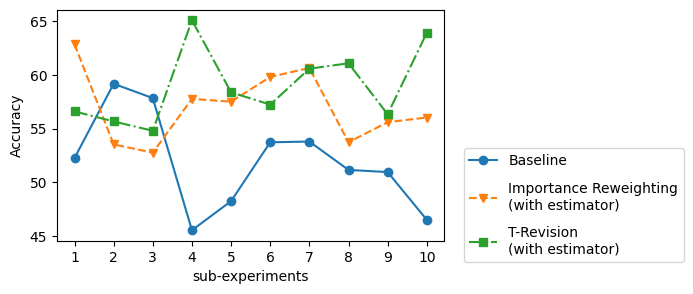

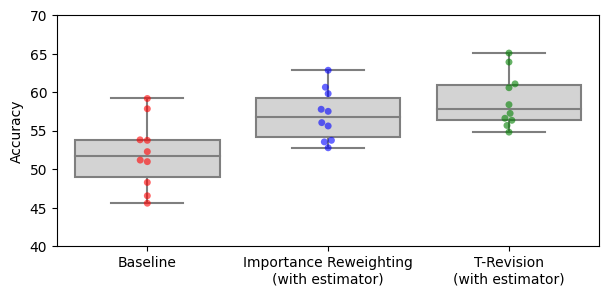

In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:
    experiments_results = []
    for f in ["log/2023-11-04_15-22-01_experiment_results.obj", "log/2023-11-04_16-18-37_experiment_results.obj", "log/2023-11-05_16-34-01_experiment_results.obj"]:
        experiments_results += (joblib.load(WORKSPACE_PATH+f))
    generate_experiment_results_chart(experiments_results)
    generate_experiment_results_boxplot(experiments_results, ymin=40, ymax=70)


In [ ]:
if ENABLE_EXPERIMENTS_ON_CIFAR:
    print(generate_experiment_results_table(experiments_results))

               & CIFAR BASELINE TRANSITION MATRIX DISABLED & CIFAR IMPORTANCE REWEIGHTING TRANSITION MATRIX ESTIMATE & CIFAR T REVISION TRANSITION MATRIX ESTIMATE  \\
recall 0 mean                  &   (0.5193)   &   0.6569   &   {0.6723}  \\
recall 0 std                   &   (0.0716)   &   0.1144   &   {0.1199}  \\
recall 1 mean                  &   (0.5527)   &   0.5610   &   {0.6263}  \\
recall 1 std                   &   0.0685   &   (0.0657)   &   {0.1022}  \\
recall 2 mean                  &   (0.5322)   &   {0.5563}   &   0.5546  \\
recall 2 std                   &   {0.0786}   &   0.0519   &   (0.0477)  \\
precision 0 mean               &   (0.5546)   &   0.5625   &   {0.6449}  \\
precision 0 std                &   (0.1218)   &   {0.1413}   &   0.1347  \\
precision 1 mean               &   {0.5132}   &   0.4894   &   (0.3966)  \\
precision 1 std                &   {0.1992}   &   (0.1493)   &   0.1519  \\
precision 2 mean               &   (0.4901)   &   0.6587   &   {0.7273}  

The transition matrices of experiments and it's mean and standard devision.

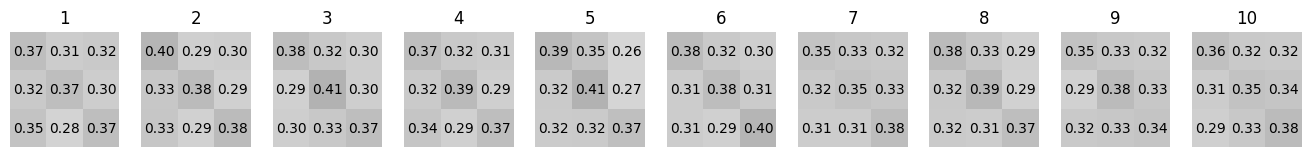

CIFAR_IMPORTANCE_REWEIGHTING_TRANSITION_MATRIX_ESTIMATE


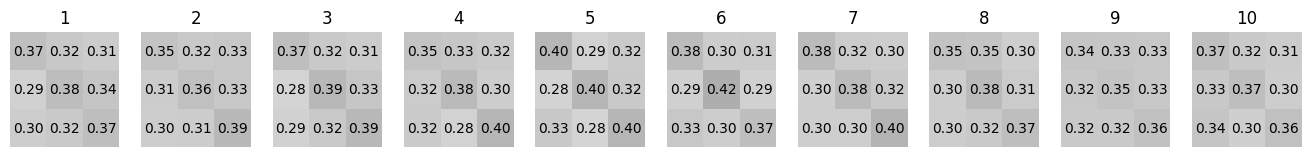

CIFAR_T_REVISION_TRANSITION_MATRIX_ESTIMATE


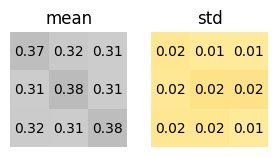

In [ ]:
def generate_estimated_transition_matrix_heatmap(experiments_results):

    experiment_names = set([i['cfg']['name'] for i in experiments_results if i['cfg']['transition_matrix_type'] == 'ESTIMATE'])

    buf = {'all':[]}
    for name in experiment_names:
        buf[name] = []

    for i in experiments_results:
        if i['cfg']['transition_matrix_type'] == 'ESTIMATE':
            buf[i['cfg']['name']].append(i['cfg']['transition_matrix_estimated'].numpy())
            buf['all'].append(i['cfg']['transition_matrix_estimated'].numpy())

    for name in experiment_names:
        generate_heatmaps(buf[name])
        print(name)

    generate_heatmaps([np.mean(np.stack(buf['all']), axis=0), np.std(np.stack(buf['all']), axis=0)],
                      labels=['mean', 'std'], colors=['Greys', 'YlOrRd'], vmax=[1, 0.1])

generate_estimated_transition_matrix_heatmap(experiments_results)